In [3]:
import numpy as np
from tqdm.notebook import tqdm, trange
from alive_progress import alive_bar
import time # to be used in loop iterations
import caffeine
from multiprocess import Pool
import matplotlib.pyplot as plt
np.random.seed(1234)

### I implemented gaussian kernel-approximation using SGD to 3-spin model, in the 2018 paper by Vanden Eijnden and Grant Rostkoff entitled 'Trainability and Accuracy of Neural Networks: An Interacting Particle System Approach'.

In [4]:
def spin_func(x,a):
    """
    Calculate the spin function for a given set of vectors and coefficients.

    Parameters:
    x (np.ndarray): An array representing a set of vectors with shape (n, d).
    a (np.ndarray): An array of coefficients with shape (d, d, d).

    Returns:
    np.ndarray: An array containing the computed spin values with shape (1, n).
    """
    n = x.shape[0]
    d = x.shape[1]
    y = x[:,np.newaxis, :]* x[:,:, np.newaxis]
    y = y[:,:,:,np.newaxis]* x[:,np.newaxis, np.newaxis, :]
    z = y*a[np.newaxis,:,:,:]
    return 1/d*z.sum(axis = (1,2,3)).reshape((1,n))

def grad_spin_func(x,a):
    """
    Calculate the gradient of the spin function with respect to the input vectors.

    Parameters:
    x (np.ndarray): An array representing a set of vectors with shape (n, d).
    a (np.ndarray): An array of coefficients with shape (d, d, d).

    Returns:
    np.ndarray: An array containing the gradient of the spin function with shape (n, d).
    """

    n = x.shape[0]
    d = x.shape[1]
    df = 1/d*np.array([((a[p,:,:]+a[:,p,:]+a[:,:,p])[np.newaxis, :,:]\
                *(x[:,np.newaxis,:]*x[:,:, np.newaxis])).sum(axis = (1,2)) for p in range(d)]).reshape(n,d)
    return df

def spin_func_slice(X,Y,a,d = 5):
    """
    Calculate the spin function for a given pair of angles and coefficients.

    Parameters:
    X (float): The first angle.
    Y (float): The second angle.
    a (np.ndarray): An array of coefficients with shape (d, d, d).
    d (int): The dimensionality of the vectors (default is 5).

    Returns:
    np.ndarray: An array containing the computed spin values with shape (1, n).
    """
    x = np.sqrt(d)*np.array([np.sin(X)*np.cos(Y), np.sin(X)*np.sin(Y), np.cos(X), 0, 0]).reshape(1,d)
    return spin_func(x, a)

vspin_func_slice = np.vectorize(spin_func_slice)
vspin_func_slice.excluded.add(2)

In [5]:
#Initialise params
d = 5
a = np.random.normal(np.zeros((d,d,d)), np.ones((d,d,d)))

([], [])

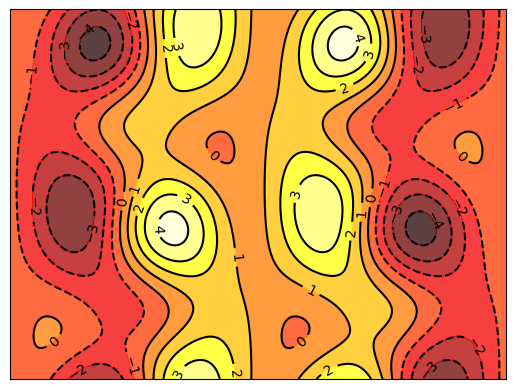

In [6]:
#contour plot of spin function
n = 256
x = np.linspace(-np.pi, np.pi, n)
y = np.linspace(0, 2*np.pi, n)
X, Y = np.meshgrid(x, y)

plt.contourf(X, Y, vspin_func_slice(X, Y, a), 8, alpha=.75, cmap=plt.cm.hot)
C = plt.contour(X, Y, vspin_func_slice(X,Y, a), 8, colors='black')
plt.clabel(C, inline=1, fontsize=10)
plt.xticks([])
plt.yticks([])

In [2]:
def neural_net_symm(x, c, z):
    """
    Compute the output of a symmetric neural network for given input and parameters.

    Parameters:
    x (np.ndarray): An input vector of shape (1, d).
    c (np.ndarray): Coefficients of the neural network with shape (1, n).
    z (np.ndarray): Weight matrix with shape (n, d).

    Returns:
    np.ndarray: The output of the symmetric neural network with shape (1, 1).
    """
    z = np.array(z)
    n = z.shape[0]
    d = z.shape[1]
    c = c.reshape(1,n)
    return 1/n*(np.exp(-x@z.T)@c.T).reshape(1,x.shape[0])

def neural_net_slice(X, Y, c, z, d = 5):
    """
    Compute the output of a symmetric neural network for given angles and parameters.

    Parameters:
    X (float): The first angle.
    Y (float): The second angle.
    c (np.ndarray): Coefficients of the neural network with shape (1, n).
    z (np.ndarray): Weight matrix with shape (n, d).
    d (int): The dimensionality of the input vectors (default is 5).

    Returns:
    np.ndarray: The output of the symmetric neural network with shape (1, 1).
    """
    x = np.sqrt(d)*np.array([np.sin(X)*np.cos(Y), np.sin(X)*np.sin(Y), np.cos(X), 0, 0]).reshape(1,d)
    return neural_net_symm(x, c, z)
vneural_net_slice = np.vectorize(neural_net_slice)
vneural_net_slice.excluded.add(2)
vneural_net_slice.excluded.add(3)

In [8]:
def sample_uniform_sphere(r, d, n):
    """
    Generate random points uniformly distributed on the surface of a d-dimensional sphere with radius 'r'.

    Parameters:
    r (float): The radius of the sphere.
    d (int): The dimensionality of the sphere.
    n (int): The number of points to generate.

    Returns:
    np.ndarray: An array of shape (n, d) containing 'n' random points sampled uniformly on the sphere's surface.
    """
    s = np.random.multivariate_normal(np.zeros(d), np.diag(np.ones(d)), n)
    norm = np.sqrt(np.diag(s@s.T)).reshape(n,1)
    result = r*s/norm
    return result

In [81]:
#Training
def train(d = 5, n = 16, Dt = 1e3, steps = int(2*1e5)):
    """
    Train a neural network with symmetric architecture on a given spin system.

    Parameters:
    d (int): The dimensionality of the spin system (default is 5).
    n (int): The number of neural network units (default is 16).
    Dt (float): Time step for training (default is 1e3).
    steps (int): The number of training steps (default is 200,000).

    Returns:
    tuple: A tuple containing the trained neural network coefficients 'c', the weight matrix 'z',
           and an array of loss values during training.
    """
    
    #initialise parameters
    c = np.random.uniform(-40*d**2, 40*d**2, n).reshape(1,n)
    z = sample_uniform_sphere(np.sqrt(d), d, n).reshape(n,d)
    losses = np.zeros(steps)
    #update step
    for step in trange(steps):
        grad = grad_spin_func(z,a)
        exp = np.exp(-z@z.T)
        #sample points on sphere
        P = int(1e3)
        x = sample_uniform_sphere(np.sqrt(d), d, P).reshape(P,d)
        exp_x = np.exp(-x@z.T)
        
        loss = 0.5*np.mean((spin_func(x,a)-neural_net_symm(x,c,z))**2)
        loss1 = -1/n*c@spin_func(z, a).T+0.5*1/n**2*c@exp@c.T
        
        #neural_net_symm(z,c,z)
        
        #c_next = c + (spin_func(z, a)-1/n*c@exp)*Dt 
        #z_next = z + (c.T*grad+1/n*(c.T*exp)@(c.T*z))*Dt

        #c_next = c + (spin_func(x, a)@exp_x-1/n*c@exp_x.T@exp_x)*Dt/P
        #z_next = z + ((c.T*exp_x.T)@(spin_func(x, a).T*x)-1/n*(c.T*exp_x.T@((exp_x@c.T)*x)))*Dt/P
        
        c_next = c + (spin_func(z, a)@exp-1/n*c@exp.T@exp)*Dt/n
        z_next = z + ((c.T*exp.T)@(spin_func(z, a).T*z)-1/n*(c.T*exp.T@((exp@c.T)*z)))*Dt/n
        z_next = z_next*np.sqrt(d)/np.linalg.norm(z_next, axis = 1).reshape(n,1)
        z = z_next
        c = c_next
        
        losses[step] = loss
        print('loss: {}'.format(loss))
                
    return c,z, losses

([], [])

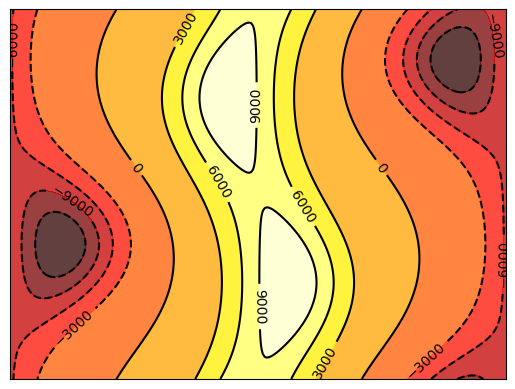

In [205]:
#contour plot of neural net reconstruction
n = 256
x = np.linspace(-np.pi, np.pi, n)
y = np.linspace(0, 2*np.pi, n)
X, Y = np.meshgrid(x, y)

plt.contourf(X, Y, vneural_net_slice(X, Y, c,z), 8, alpha=.75, cmap=plt.cm.hot)
C = plt.contour(X, Y, vneural_net_slice(X,Y, c,z), 8, colors='black')
plt.clabel(C, inline=1, fontsize=10)
plt.xticks([])
plt.yticks([])

In [206]:
#Training
def train_SGD(d = 5, n = 16, Dt = 1e3, steps = int(2*1e5)):
    """
    Train a neural network with symmetric architecture on a given spin system using Stochastic Gradient Descent (SGD).

    Parameters:
    d (int): The dimensionality of the spin system (default is 5).
    n (int): The number of neural network units (default is 16).
    Dt (float): Time step for training (default is 1e3).
    steps (int): The number of training steps (default is 200,000).

    Returns:
    tuple: A tuple containing the trained neural network coefficients 'c', the weight matrix 'z',
           and an array of loss values during training.
    """
    
    #initialise parameters
    c = np.random.uniform(-40*d**2, 40*d**2, n).reshape(1,n)
    z = sample_uniform_sphere(np.sqrt(d), d, n).reshape(n,d)
    losses = np.zeros(steps)
    #update step
    for step in trange(steps):
        grad = grad_spin_func(z,a)
        exp = np.exp(-z@z.T)
        #sample points on sphere
        P = int(1e3)
        x = sample_uniform_sphere(np.sqrt(d), d, P).reshape(P,d)
        exp_x = np.exp(-x@z.T)
        
        loss = 0.5*np.mean((spin_func(x,a)-neural_net_symm(x,c,z))**2)
        
        c_next = c + (spin_func(x, a)@exp_x-1/n*c@exp_x.T@exp_x)*Dt/P
        z_next = z + ((c.T*exp_x.T)@(spin_func(x, a).T*x)-1/n*(c.T*exp_x.T@((exp_x@c.T)*x)))*Dt/P
        z_next = z_next*np.sqrt(d)/np.linalg.norm(z_next, axis = 1).reshape(n,1)
        z = z_next
        c = c_next
        
        losses[step] = loss
        print('loss: {}'.format(loss))
                
    return c,z, losses

In [208]:
#Training with Nesterov accelerated gd
def nesterov_train_stochastic(d = 5, n = 16, Dt = 1e3, r = 3, steps = int(2*1e5)):
    """
    Train a neural network with symmetric architecture on a given spin system using Nesterov's accelerated gradient descent.

    Parameters:
    d (int): The dimensionality of the spin system (default is 5).
    n (int): The number of neural network units (default is 16).
    Dt (float): Time step for training (default is 1e3).
    r (int): The number of steps for Nesterov's acceleration (default is 3).
    steps (int): The number of training steps (default is 200,000).

    Returns:
    tuple: A tuple containing the trained neural network coefficients 'c', the weight matrix 'z',
           and an array of loss values during training.
    """
    
    #initialise parameters
    c = np.random.uniform(-40*d**2, 40*d**2, n).reshape(1,n)
    z = sample_uniform_sphere(np.sqrt(d), d, n).reshape(n,d)
    c_change = c
    z_change = z
    
    losses = np.zeros(steps)
    #update step
    for step in trange(steps):
        grad = grad_spin_func(z_change,a)
        exp = np.exp(-z_change@z_change.T)
        #sample points on sphere
        P = int(1e3)
        x = sample_uniform_sphere(np.sqrt(d), d, P).reshape(P,d)
        exp_x = np.exp(-x@z_change.T)
        
        loss = 0.5*np.mean((spin_func(x,a)-neural_net_symm(x,c,z))**2)    
        
        c1 = c
        z1 = z
        
        c_next = c_change + (spin_func(x, a)@exp_x-1/n*c@exp_x.T@exp_x)*Dt/P
        z_next = z_change + ((c_change.T*exp_x.T)@(spin_func(x, a).T*x)\
                             -1/n*(c_change.T*exp_x.T@((exp_x@c_change.T)*x)))*Dt/P
        z_next = z_next*np.sqrt(d)/np.linalg.norm(z_next, axis = 1).reshape(n,1)

        
        c_change = c_next + 0.9*(c_next-c1)
        z_change = z_next + 0.9*(z_next-z1)
        z = z_next
        c = c_next
        
        
        losses[step] = loss
        print('loss: {}'.format(loss))
        z = z_next
        c = c_next
        
        
    return c,z, losses

In [177]:
#Training with Nesterov accelerated gd
def nesterov_train_deterministic(d = 5, n = 16, Dt = 1e3, r = 3, steps = int(2*1e5)):
    """
    Train a neural network with symmetric architecture on a given spin system using Nesterov's accelerated gradient descent.

    Parameters:
    d (int): The dimensionality of the spin system (default is 5).
    n (int): The number of neural network units (default is 16).
    Dt (float): Time step for training (default is 1e3).
    r (int): The number of steps for Nesterov's acceleration (default is 3).
    steps (int): The number of training steps (default is 200,000).

    Returns:
    tuple: A tuple containing the trained neural network coefficients 'c', the weight matrix 'z',
           and an array of loss values during training.
    """
    #initialise parameters
    c = np.random.uniform(-40*d**2, 40*d**2, n).reshape(1,n)
    z = sample_uniform_sphere(np.sqrt(d), d, n).reshape(n,d)
    c_change = c
    z_change = z
    
    losses = np.zeros(steps)
    #update step
    for step in trange(1,steps+1):
        grad = grad_spin_func(z_change,a)
        exp = np.exp(-z_change@z_change.T)
        #sample points on sphere
        P = int(1e3)
        x = sample_uniform_sphere(np.sqrt(d), d, P).reshape(P,d)
        
        loss = 0.5*np.mean((spin_func(x,a)-neural_net_symm(x,c,z))**2)

        c1 = c
        z1 = z
        
        c_next = c_change + (spin_func(z_change, a)@exp-1/n*c@exp.T@exp)*Dt/n
        z_next = z_change + ((c_change.T*exp.T)@(spin_func(z_change, a).T*z_change)\
                      -1/n*(c_change.T*exp.T@((exp@c_change.T)*z_change)))*Dt/n
        z_next = z_next*np.sqrt(d)/np.linalg.norm(z_next, axis = 1).reshape(n,1)

        c_change = c_next + 0.9*(c_next-c1)
        z_change = z_next + 0.9*(z_next-z1)
        z = z_next
        c = c_next

        losses[step-1] = loss
        print('loss: {}'.format(loss))
            
    return c,z, losses

In [218]:
c,z, losses = train(n = 16, steps = 30000, Dt = 1e-8)

  0%|          | 0/30000 [00:00<?, ?it/s]

loss: 1704934.4473667743
loss: 1803804.8836145087
loss: 1797768.6735375181
loss: 1969767.9100137067
loss: 2124750.481820926
loss: 1990494.185011697
loss: 2180689.6912740464
loss: 2546145.0913713933
loss: 2307335.053385869
loss: 2445247.2284213253
loss: 2455161.4678013297
loss: 2809890.30747952
loss: 2638011.964612268
loss: 2898837.6581541663
loss: 3143640.0066867233
loss: 3276579.1904253787
loss: 3093872.1572017497
loss: 3116286.495090945
loss: 3483513.7784808017
loss: 3600786.1473042853
loss: 3282646.634728349
loss: 3667283.5496185375
loss: 5349542.896369053
loss: 4888717.131461834
loss: 4915987.382914568
loss: 5423620.170351351
loss: 6423046.247272105
loss: 6392742.502553487
loss: 6451814.591042251
loss: 5280088.902762472
loss: 6477766.508820714
loss: 5741094.0579637345
loss: 6628519.279106109
loss: 5704496.520505332
loss: 6483121.2777082175
loss: 6772847.164566003
loss: 6030484.922528863
loss: 6386848.36178345
loss: 5420819.680201368
loss: 3962474.683446681
loss: 5777779.901581468
l

loss: 7701637.823107144
loss: 7427935.70696107
loss: 6391061.173970937
loss: 7982855.279898529
loss: 7808235.678434387
loss: 9405641.543675013
loss: 8108975.477639437
loss: 7591823.886260961
loss: 7794673.293430653
loss: 7947435.818492435
loss: 6838723.66667844
loss: 6633865.132659659
loss: 7308113.964610495
loss: 9615456.864507683
loss: 8077112.394029718
loss: 7385906.740420693
loss: 8064674.421197556
loss: 8328263.490424975
loss: 8318328.783744681
loss: 7883634.566871048
loss: 8321987.763901501
loss: 9133396.746022966
loss: 9098869.82173043
loss: 8662954.346013302
loss: 7713564.09244594
loss: 7921553.68027249
loss: 7473266.505386873
loss: 8144235.9362797085
loss: 7652766.3216140475
loss: 7786752.911424216
loss: 7051053.124246348
loss: 6828233.962431467
loss: 7456510.13106373
loss: 7298909.387554223
loss: 10506466.462875886
loss: 7117244.216738299
loss: 8572834.471471492
loss: 6818292.947117654
loss: 6646216.746429592
loss: 7020840.566415598
loss: 7588709.221061539
loss: 8045183.50724

loss: 8610208.28455449
loss: 7525489.897968377
loss: 7445133.538966141
loss: 7693542.102034157
loss: 7128827.586402064
loss: 8377182.429370232
loss: 7446545.03136647
loss: 8037519.495187392
loss: 7784066.497019082
loss: 7537645.833822554
loss: 7477423.733217361
loss: 8955393.50525277
loss: 7493412.561480129
loss: 7455779.023798401
loss: 8928647.56599095
loss: 7144956.5740226135
loss: 8660723.635513434
loss: 7635674.166229565
loss: 6523209.087654149
loss: 7717565.432630307
loss: 7856125.320920262
loss: 7544142.924265536
loss: 6652520.545335608
loss: 8993587.807766857
loss: 7899700.248415062
loss: 6728188.172242853
loss: 7735767.356807836
loss: 8438489.726197587
loss: 7283659.119330677
loss: 7446822.259547278
loss: 7228109.767907095
loss: 7778047.304165598
loss: 7798963.1305149
loss: 6888809.38732382
loss: 8530300.048015155
loss: 8670205.893808376
loss: 7685528.739458487
loss: 8064325.224592734
loss: 8735153.443165833
loss: 8450068.902163379
loss: 8773817.526992885
loss: 7672370.32290701

loss: 7308407.422238341
loss: 7192427.91074638
loss: 7733573.364660528
loss: 7581730.556580984
loss: 7510816.082837382
loss: 7981056.551451087
loss: 7032503.556307121
loss: 8154030.1972796
loss: 7751602.110318293
loss: 8660179.557863794
loss: 7409283.952898766
loss: 8677011.553327454
loss: 8502172.156819534
loss: 8618044.477825563
loss: 8191209.53967971
loss: 8392288.867098756
loss: 7922862.286441846
loss: 7102196.076688137
loss: 8137657.816787731
loss: 7666735.539198027
loss: 7573388.2335237935
loss: 8853469.04023521
loss: 7624291.1176322615
loss: 7428035.203870861
loss: 7331119.8119315
loss: 8042486.967490143
loss: 8758486.315905651
loss: 6820420.69044153
loss: 7504229.979980726
loss: 8733168.550073503
loss: 7123466.82114789
loss: 8068869.56336413
loss: 7144789.811363524
loss: 7348845.918756126
loss: 7462387.005877318
loss: 7889954.940898943
loss: 5888790.194169776
loss: 7495732.720028523
loss: 7137899.163582123
loss: 7483400.567369864
loss: 7478497.575362719
loss: 7431775.032826015


loss: 8586020.725404222
loss: 8021175.023818189
loss: 7570947.671805576
loss: 7433904.129974156
loss: 7483833.785575983
loss: 7933875.276237981
loss: 6985115.252089208
loss: 7906075.78371346
loss: 7248948.806474274
loss: 7778099.966449333
loss: 6261215.794564539
loss: 6418121.959821718
loss: 7204763.581648283
loss: 7802739.438396921
loss: 6856006.322097982
loss: 6625822.069790041
loss: 7446305.475558843
loss: 7978396.847427517
loss: 7225284.03837491
loss: 8253519.181310181
loss: 7366349.039751495
loss: 7406857.068551606
loss: 8702490.895171901
loss: 7537047.135495861
loss: 7359172.24492442
loss: 8118382.280389498
loss: 7290350.532492099
loss: 7566386.798745718
loss: 7039792.541187599
loss: 6567665.621943947
loss: 7087178.327655954
loss: 7419082.28167854
loss: 7823574.790595542
loss: 7058683.710243845
loss: 7706236.564143304
loss: 7972158.240997426
loss: 8695582.48971614
loss: 7080170.045896185
loss: 7285833.1134298425
loss: 6963715.851176593
loss: 7054086.037690083
loss: 6385741.730733

loss: 7863184.294211977
loss: 7278341.949417597
loss: 8095794.60984008
loss: 7210183.717689066
loss: 8032757.438266869
loss: 7998881.38201853
loss: 7340613.020436217
loss: 7430241.4899355285
loss: 6273439.553072647
loss: 6987713.766874376
loss: 6539833.837351635
loss: 7657293.177702565
loss: 7357015.895270057
loss: 7961198.306987709
loss: 7004589.511563485
loss: 8237469.198111841
loss: 8447438.641102064
loss: 7214654.072713143
loss: 7091263.7231519455
loss: 7004404.202785888
loss: 8016671.108878794
loss: 7059032.463577447
loss: 8499336.976997808
loss: 6966907.415800354
loss: 7008504.399815643
loss: 7919373.0430930555
loss: 7165439.088322402
loss: 7068182.8314283285
loss: 5923201.158310851
loss: 7241378.003866008
loss: 7881066.667518399
loss: 7793360.345569903
loss: 6910218.630734892
loss: 7185988.716723409
loss: 6740409.9862932945
loss: 6146592.093229335
loss: 6867598.13467157
loss: 7332567.699388023
loss: 7390722.40026891
loss: 7632045.736939722
loss: 7150903.582475317
loss: 7476403.1

loss: 7028686.061337349
loss: 6601886.647224588
loss: 8189580.378905691
loss: 6588558.5483083
loss: 7314560.464990616
loss: 6775858.72954767
loss: 6795766.220062931
loss: 7424393.778444814
loss: 7954862.277609998
loss: 7395903.235657717
loss: 7790950.808931889
loss: 7711369.832868045
loss: 6603679.718267181
loss: 6784838.056916274
loss: 6743028.3520913245
loss: 6506076.787431861
loss: 6892039.991186428
loss: 7632324.085981363
loss: 7330155.997643331
loss: 7461691.032667864
loss: 6606856.608660041
loss: 7363717.983844377
loss: 7414414.48047493
loss: 7096306.107645126
loss: 7662350.686120199
loss: 7948091.5463114865
loss: 7868033.566715233
loss: 6494549.065504326
loss: 6364380.527759593
loss: 7888245.78033533
loss: 7803487.422048065
loss: 6394491.680380916
loss: 8129829.427538577
loss: 7530971.466248159
loss: 7587471.725773418
loss: 6481091.200963641
loss: 7111845.8335057385
loss: 6724584.784128056
loss: 8161279.910657295
loss: 7349947.564998476
loss: 6789785.878222605
loss: 8412681.8712

loss: 8116438.570273301
loss: 7510535.212976406
loss: 7166962.742489805
loss: 7942601.698787544
loss: 6744813.283935965
loss: 7504214.347038851
loss: 7180430.073305517
loss: 6845311.183089742
loss: 7970665.300698141
loss: 7966223.478728888
loss: 7407792.270769995
loss: 7240408.64149483
loss: 8209833.549035566
loss: 7305656.878482658
loss: 7600451.668066603
loss: 7966292.799697516
loss: 6852034.444453953
loss: 8261227.403975227
loss: 7861625.590489214
loss: 8153740.25599889
loss: 9794527.865256777
loss: 7966192.094854923
loss: 7397753.773344499
loss: 6493140.625854654
loss: 7242886.798818631
loss: 6990518.432040404
loss: 7169423.271176564
loss: 7781839.026915847
loss: 7704474.333830065
loss: 7105989.879675207
loss: 6815853.05340724
loss: 6671649.0129710445
loss: 7256542.897950116
loss: 6843550.055664054
loss: 6974918.161520844
loss: 6817662.913485822
loss: 7945739.065507834
loss: 7630218.913414033
loss: 6270071.2925222535
loss: 7553949.175225815
loss: 6878471.342079839
loss: 6800890.072

loss: 7654420.084494959
loss: 7783351.489278559
loss: 6534566.408856119
loss: 6437517.53387726
loss: 8350979.201291124
loss: 6081846.468872902
loss: 7325618.589963493
loss: 7336588.347196156
loss: 7106204.3545566965
loss: 6916325.071848865
loss: 6557048.322196844
loss: 8034032.237996607
loss: 8138863.64759348
loss: 5988451.367878713
loss: 7348157.36543357
loss: 7534736.976040474
loss: 7154811.384441179
loss: 7138587.441193599
loss: 6335385.926808679
loss: 7618821.878792188
loss: 7162875.214865509
loss: 6674942.705710881
loss: 7603125.945778812
loss: 7272863.648850286
loss: 7137903.798779659
loss: 7629346.420677736
loss: 6877259.123445624
loss: 7184716.506900208
loss: 7680045.56353796
loss: 7910083.578027883
loss: 7440723.4857722055
loss: 7151945.532396536
loss: 7980027.441840447
loss: 6348162.479297463
loss: 6668559.79379814
loss: 7497857.666488126
loss: 7022850.397386434
loss: 6919911.852696031
loss: 7975208.157353922
loss: 7836216.804476791
loss: 7902988.906035757
loss: 8001979.30690

loss: 7214744.57106524
loss: 8554633.157296583
loss: 7538471.832115417
loss: 5995498.561769368
loss: 7928758.107781092
loss: 8527389.476389093
loss: 6320185.927294449
loss: 7614252.526181645
loss: 7382218.627718343
loss: 7491414.777620928
loss: 6365735.10145369
loss: 7391622.302016292
loss: 7316760.125665992
loss: 7022919.371365187
loss: 7399032.519667368
loss: 8183959.547918087
loss: 6433471.083462517
loss: 7530607.338195572
loss: 6447766.236704016
loss: 7348595.495885629
loss: 7674424.616281037
loss: 6652114.269505146
loss: 6676154.106225365
loss: 7317217.03371783
loss: 7044146.7182695065
loss: 7412723.618790863
loss: 6554039.121665952
loss: 7255001.513591405
loss: 6724348.606925544
loss: 8112994.115948707
loss: 7792121.365371651
loss: 7306784.600911364
loss: 6778812.933878719
loss: 7275326.932192314
loss: 7005415.929347722
loss: 7126080.678910252
loss: 7418887.427476839
loss: 6965310.375692871
loss: 6960148.083260797
loss: 6814148.287985253
loss: 7221342.140362311
loss: 7590867.9296

loss: 7064729.453627133
loss: 7156603.8954965975
loss: 5775478.239977684
loss: 7779883.638274482
loss: 6104067.408316308
loss: 7070697.121598129
loss: 6884964.467299628
loss: 6947204.762765262
loss: 6601787.52146839
loss: 7214044.465809382
loss: 7015026.172909252
loss: 6640124.630565745
loss: 6833288.498824673
loss: 8472128.57917476
loss: 7188734.16402333
loss: 7843374.710990796
loss: 7549469.596403884
loss: 7585891.513728738
loss: 7152740.865658915
loss: 7606213.743604068
loss: 6928369.666799498
loss: 6895212.867430123
loss: 7794584.389717419
loss: 7246103.431771335
loss: 7637230.054510441
loss: 6720939.226150662
loss: 7521713.233085909
loss: 6413705.678628179
loss: 7534983.6966939485
loss: 7165992.448682925
loss: 7345433.188211983
loss: 6442518.7727324795
loss: 5678985.76934173
loss: 6831576.939788864
loss: 7136110.451349273
loss: 8087314.423440363
loss: 6811435.875775515
loss: 7268974.100622202
loss: 6528245.84296636
loss: 6510523.281981779
loss: 7370940.953589001
loss: 7012014.7213

loss: 7642132.262530505
loss: 6562341.345119231
loss: 7076805.614084738
loss: 6638560.244032917
loss: 7600685.592963126
loss: 7362577.472235446
loss: 7181125.509786213
loss: 7794136.055899525
loss: 7211639.561053445
loss: 6318845.3879913455
loss: 7200579.2485586265
loss: 5930087.963079226
loss: 7362048.152448278
loss: 7412827.870187372
loss: 8400238.387658471
loss: 7564491.313395367
loss: 6955966.757681719
loss: 6236792.70420047
loss: 6604512.271922612
loss: 6471758.189793954
loss: 7457872.432468152
loss: 7434658.622639745
loss: 6621167.690827785
loss: 8289881.31942818
loss: 7050827.501541178
loss: 7913877.048880562
loss: 7156314.110348217
loss: 6157891.147035206
loss: 6524773.174149515
loss: 6883895.064994766
loss: 6692108.910923623
loss: 7264585.746636165
loss: 6197184.935429086
loss: 7632985.31009661
loss: 7849715.032298681
loss: 7620703.511604486
loss: 7184359.916982571
loss: 7396937.986798322
loss: 6240542.153277938
loss: 6326417.795558386
loss: 6680517.07167829
loss: 7281355.5238

loss: 7715627.830352991
loss: 7378628.354259402
loss: 6914219.000966962
loss: 7367463.515542336
loss: 6227097.594486714
loss: 6902370.485213758
loss: 6977715.322708315
loss: 7194025.262282865
loss: 6611486.769935636
loss: 7784582.554103419
loss: 6007399.756391432
loss: 7056704.843764294
loss: 7373387.737178072
loss: 6249066.8066910915
loss: 7320411.135574288
loss: 7723180.229296446
loss: 6781770.393638653
loss: 7240514.963130726
loss: 7013275.852582012
loss: 6778664.24526415
loss: 6814462.73343066
loss: 7671134.614949321
loss: 6282962.063987263
loss: 6930599.789612421
loss: 7997865.669257759
loss: 6762722.531870541
loss: 6970546.589307319
loss: 6381547.936740782
loss: 7917028.647596188
loss: 7481245.199812466
loss: 6267836.68058812
loss: 6124474.956433259
loss: 5995108.911496208
loss: 7815989.656411279
loss: 6667318.906998166
loss: 6339145.5149851935
loss: 7071645.910768478
loss: 7124899.757973001
loss: 6634324.394768933
loss: 7582601.719128216
loss: 8562686.545727417
loss: 6684939.217

loss: 6740636.494074728
loss: 7525090.642231169
loss: 6997826.855016893
loss: 7224257.105051858
loss: 7655694.0908508925
loss: 7344740.666714866
loss: 6252963.640030482
loss: 6341983.558629977
loss: 6896256.581743557
loss: 6230793.638484859
loss: 6968826.294602305
loss: 7022748.756415603
loss: 6993259.369896923
loss: 7125907.10857072
loss: 6882189.144344772
loss: 6710397.0856816545
loss: 5716844.80611718
loss: 6553258.555905466
loss: 6217800.670692793
loss: 7138873.547179051
loss: 6014148.779810946
loss: 6919673.035646797
loss: 8001062.02882981
loss: 6985331.803533809
loss: 6271259.825498831
loss: 7072441.1965605095
loss: 7266135.20313561
loss: 5408576.291460581
loss: 6553406.13428542
loss: 6932132.528781973
loss: 7383175.602474831
loss: 6084053.805258245
loss: 6324699.872454678
loss: 7130393.935828808
loss: 6266976.769398023
loss: 6919565.596790683
loss: 7257894.785447945
loss: 8203879.319700249
loss: 6051707.121233464
loss: 7414850.70711685
loss: 7429532.532608801
loss: 7560205.91097

loss: 7312114.91206757
loss: 6846432.944636715
loss: 6863460.207607432
loss: 6840942.127553121
loss: 7912970.150495671
loss: 6365538.712316046
loss: 7586701.881086622
loss: 7419998.883501142
loss: 7882846.086956038
loss: 6372338.361792759
loss: 6197350.613729945
loss: 6614380.1975849895
loss: 7482031.921289072
loss: 6794662.351195015
loss: 6649622.973836176
loss: 6467353.33900942
loss: 7026133.16220735
loss: 7434266.23751758
loss: 6896787.5527500445
loss: 7062440.674448006
loss: 7147063.868859703
loss: 6292313.164029349
loss: 6442029.76579608
loss: 6501284.33861674
loss: 8245893.434839458
loss: 6628714.174050779
loss: 6403802.639587884
loss: 7707646.661882025
loss: 7225610.331708397
loss: 6498746.749860384
loss: 5851508.002261573
loss: 6219599.644635281
loss: 7168567.52985063
loss: 6849662.061078615
loss: 6921562.380648248
loss: 7287756.729642158
loss: 5999504.1124202935
loss: 6491332.691717453
loss: 6552949.550217817
loss: 7007323.534702324
loss: 6460613.509266052
loss: 5684364.389437

loss: 6772646.334457255
loss: 6184458.692347547
loss: 7601743.362371286
loss: 7043128.76044826
loss: 7519916.937000071
loss: 7431734.660182591
loss: 7680313.262329764
loss: 7062320.620657333
loss: 6750347.66551696
loss: 6258691.651391548
loss: 7029528.127114756
loss: 5820343.678046364
loss: 7163334.592958358
loss: 6622176.490850038
loss: 8071743.152928023
loss: 6960611.975279802
loss: 7210148.758713624
loss: 6647421.578015442
loss: 6282349.584449171
loss: 6949551.629017223
loss: 6434977.325423795
loss: 6290330.730971741
loss: 6268041.150469622
loss: 6668889.0129606025
loss: 6282374.384318035
loss: 7207805.210714597
loss: 7074472.281617576
loss: 6366923.13668931
loss: 6730265.597179524
loss: 7010990.023945434
loss: 7453121.19051943
loss: 7161282.61139501
loss: 6531050.792202145
loss: 7201744.68837775
loss: 7401539.840358474
loss: 6905857.796343145
loss: 7070150.12597418
loss: 5573267.321507774
loss: 7171668.275593907
loss: 6980229.636659433
loss: 6733004.135524013
loss: 7449642.22856961

loss: 6286585.8560674675
loss: 6510173.187512896
loss: 5926242.232931589
loss: 6567386.599329723
loss: 6736988.00875138
loss: 7828073.506919041
loss: 6794747.654367937
loss: 5494481.565609755
loss: 6525653.612340784
loss: 7045262.91013969
loss: 7061839.913800707
loss: 6317384.980970175
loss: 6853862.178458133
loss: 7222015.530161025
loss: 6424200.378554329
loss: 6705060.619815098
loss: 6088334.2321371585
loss: 6225230.542368656
loss: 7296140.138016848
loss: 7029860.589765923
loss: 7251301.841130618
loss: 5933101.16776387
loss: 6209578.157264845
loss: 6494618.416453025
loss: 6374404.121466723
loss: 6091031.69664284
loss: 6503622.908917736
loss: 6740523.320834335
loss: 6465903.510845961
loss: 6857763.737067171
loss: 6316152.997043181
loss: 6838394.624510731
loss: 7552499.883051851
loss: 6773925.060689688
loss: 5867901.546265582
loss: 7322930.256085146
loss: 6754086.07438433
loss: 6796065.523469841
loss: 6918517.395842558
loss: 5562131.594701689
loss: 6064333.384440851
loss: 7023478.78337

loss: 6388142.84125899
loss: 7011524.056133386
loss: 6961967.21029324
loss: 6127129.556041574
loss: 7146890.978907845
loss: 5557439.326662482
loss: 5861142.595915135
loss: 7078035.092075441
loss: 7276213.987941467
loss: 6839092.43302435
loss: 6214955.375294795
loss: 7122806.824728426
loss: 6990509.696300764
loss: 6974630.34810733
loss: 7259006.683438683
loss: 5747671.6106416825
loss: 6736354.796846714
loss: 6981151.722557993
loss: 6280312.429532645
loss: 6727349.744121625
loss: 6521195.159982818
loss: 6441882.8747553425
loss: 6556837.88272892
loss: 6623582.639966591
loss: 5616850.262426462
loss: 6926758.407276694
loss: 6430671.09788027
loss: 6000475.099023052
loss: 6870948.798001015
loss: 6506900.264934695
loss: 6759558.315910494
loss: 6916288.548443159
loss: 5801062.791223788
loss: 5544912.474844297
loss: 7050665.750540367
loss: 6714206.657970314
loss: 7327639.975588677
loss: 6514115.702595805
loss: 5820109.870011333
loss: 5014642.359207912
loss: 6631223.522770678
loss: 7442964.674100

loss: 6106940.380821186
loss: 7665449.124207266
loss: 6804207.010840359
loss: 6318092.100218058
loss: 7100830.445176259
loss: 7432679.677041168
loss: 6522541.950717726
loss: 6717798.049583145
loss: 6062887.690574922
loss: 6604683.681005628
loss: 6332233.135763248
loss: 6939311.360084898
loss: 6204639.03408869
loss: 6688213.859951972
loss: 6405612.913042215
loss: 5703998.182243146
loss: 7670419.188915171
loss: 7354422.704831516
loss: 6477276.704135884
loss: 7080099.36180577
loss: 6369280.149057263
loss: 6318703.56731346
loss: 6756501.5959882615
loss: 5635165.800874161
loss: 6214979.518492197
loss: 6486632.674563302
loss: 6465352.064183175
loss: 6510553.998705234
loss: 6626024.82690788
loss: 5874898.084516166
loss: 7515805.4813851295
loss: 6467952.083558781
loss: 6818064.946543989
loss: 7466902.154360296
loss: 6225667.375388752
loss: 7057408.364707573
loss: 6769580.925620174
loss: 6130746.735916343
loss: 8540483.020808607
loss: 7243793.515176127
loss: 7208626.799004191
loss: 6230211.3364

loss: 5862237.61265776
loss: 5956212.430357229
loss: 6597164.189949475
loss: 6262295.503964357
loss: 7255087.328756727
loss: 7026773.598499357
loss: 7886923.856180411
loss: 6975307.327047652
loss: 6127227.412218884
loss: 6194524.807791539
loss: 6364032.829020464
loss: 6088636.710310005
loss: 6158440.0370576605
loss: 7156943.484378274
loss: 7375946.691556652
loss: 6910132.613088968
loss: 6683280.372031217
loss: 6636614.347205543
loss: 6448594.137670932
loss: 6211399.97268482
loss: 7032690.1896360535
loss: 6325482.316686517
loss: 6445026.122425755
loss: 6392323.701413154
loss: 6810856.66432169
loss: 6713275.240675184
loss: 6723981.707675128
loss: 5844076.055632777
loss: 6088581.302838606
loss: 7036396.880039448
loss: 5884128.268096744
loss: 6284905.946377436
loss: 6446817.000788364
loss: 6264639.259284042
loss: 5862990.330157204
loss: 7050197.322019974
loss: 7136716.0739207
loss: 6813533.530013605
loss: 6122212.494888257
loss: 7074988.68274655
loss: 5661266.429335502
loss: 7113641.557217

loss: 5936272.546162928
loss: 6576892.145465294
loss: 7353186.103887088
loss: 6295427.473412224
loss: 6481049.099453762
loss: 6318757.532952553
loss: 5734517.220009881
loss: 5500830.190887485
loss: 6930340.910868012
loss: 7779420.080787365
loss: 6054229.117418457
loss: 5981383.306685211
loss: 5997540.007356327
loss: 7319140.849397741
loss: 6534411.258391181
loss: 6126539.847669796
loss: 6803220.988259506
loss: 5416821.967768687
loss: 5627925.194812926
loss: 5659469.504364649
loss: 7027832.384516661
loss: 5834036.220110115
loss: 5794734.682957387
loss: 7233134.062485265
loss: 7087452.523180337
loss: 6230258.418300708
loss: 5697640.190629853
loss: 6238956.528094807
loss: 5712981.857284542
loss: 8430487.578948546
loss: 6313832.701963251
loss: 6997279.928304741
loss: 6420815.27059573
loss: 5745289.433242077
loss: 6864342.086632956
loss: 6939639.83822764
loss: 6417657.495548803
loss: 6701171.62344842
loss: 6748005.807590175
loss: 6997252.0345843425
loss: 6378037.961330119
loss: 6409260.3412

loss: 7088858.29968286
loss: 6561843.592485326
loss: 6116346.309009699
loss: 5820387.300531616
loss: 6501649.670577683
loss: 6448151.336255474
loss: 6691251.899991954
loss: 6952828.706839971
loss: 5853758.721728324
loss: 5474471.115619694
loss: 6467260.629833376
loss: 6184955.838349508
loss: 6403756.311420468
loss: 6400409.400754237
loss: 5371621.673306412
loss: 5841235.068228729
loss: 6166274.580695846
loss: 5866178.327657953
loss: 5810222.279328077
loss: 7560419.822834278
loss: 6207271.819598806
loss: 5909998.975664963
loss: 6467332.649827025
loss: 7626964.273772302
loss: 7768572.419988485
loss: 6065504.446973682
loss: 6832630.336694152
loss: 7313330.632799489
loss: 6356782.806736336
loss: 6281240.101265166
loss: 6469770.645381462
loss: 6350218.650703057
loss: 5950534.065253496
loss: 5792346.88183769
loss: 6189344.47373168
loss: 6462400.887846333
loss: 6574977.740869884
loss: 6666924.833731285
loss: 5771083.419778585
loss: 6191936.181423371
loss: 5653797.051811012
loss: 6425713.02663

loss: 5800119.929830586
loss: 6843173.433384429
loss: 6493519.944740415
loss: 5523793.766534441
loss: 6308105.593140655
loss: 6935576.284917484
loss: 6093130.756698473
loss: 6709875.468840348
loss: 5502285.184816859
loss: 6017698.072780964
loss: 5878983.614635501
loss: 6696103.653141868
loss: 6489879.1079595275
loss: 6672887.225693982
loss: 5797079.314742775
loss: 6497360.462480289
loss: 6812851.221378526
loss: 5834567.366695453
loss: 6618410.895028028
loss: 6022938.216751147
loss: 7566965.287454676
loss: 6428618.546337646
loss: 5629625.957907766
loss: 5616469.602383588
loss: 6682442.627214601
loss: 6572260.710457683
loss: 6971199.489979503
loss: 5926576.390470045
loss: 6298556.856989145
loss: 6266437.929474638
loss: 6193192.080980549
loss: 6741909.971709159
loss: 6268880.853395424
loss: 7197153.924155689
loss: 6150660.919713567
loss: 6406667.087208904
loss: 6461611.9304687325
loss: 6104291.979953506
loss: 5776514.069239916
loss: 7069884.059679434
loss: 6014460.711423723
loss: 6304897.

loss: 6415580.11812505
loss: 6499565.096389647
loss: 5895108.5111106355
loss: 6996631.9163996605
loss: 6249695.932284233
loss: 6445216.878864416
loss: 7218453.669621584
loss: 6208105.518010359
loss: 7388690.660981728
loss: 6400834.103586323
loss: 6561795.033904101
loss: 5185841.541169522
loss: 7276429.021387762
loss: 6145006.679123369
loss: 5714148.268862149
loss: 6228344.475506311
loss: 6237359.539503627
loss: 6267429.069222505
loss: 6477711.970790026
loss: 6312759.505597434
loss: 6358078.734218652
loss: 6445723.606106425
loss: 6619699.6703559635
loss: 6760269.350300019
loss: 6327018.697941358
loss: 6570058.311668044
loss: 6957675.133957188
loss: 6311865.628412786
loss: 6425750.669015109
loss: 6857795.932457831
loss: 5987076.0826060455
loss: 6664614.020215218
loss: 5909317.475934815
loss: 5178299.428279487
loss: 6607612.733359771
loss: 7659134.817645881
loss: 6141912.3218816295
loss: 5797630.918088673
loss: 5940393.944098265
loss: 6134760.556573343
loss: 8017259.635031685
loss: 653012

loss: 6072443.807597121
loss: 6691857.126893624
loss: 6049116.708723822
loss: 4768485.674912554
loss: 5033635.865659025
loss: 5880666.766862105
loss: 6017641.742419944
loss: 6638870.641429687
loss: 6174209.526710205
loss: 6665383.118884159
loss: 5886438.679380028
loss: 6777060.166591324
loss: 5901820.341815651
loss: 5828411.982282373
loss: 5863933.151869288
loss: 6025876.838844491
loss: 6812889.034272505
loss: 5699537.352520015
loss: 5691315.966152517
loss: 6249516.343029038
loss: 6321150.73259968
loss: 5906932.663298193
loss: 6615977.870372401
loss: 5792246.680466707
loss: 6171210.910848301
loss: 5734377.100645846
loss: 6054618.329399769
loss: 6074378.650794041
loss: 6110584.070590202
loss: 6772946.666422975
loss: 5837157.703517447
loss: 6361779.01742939
loss: 6475965.216936407
loss: 6803322.655280076
loss: 5278749.654162487
loss: 6526395.462154018
loss: 6473222.27423184
loss: 7438836.212343997
loss: 7194730.286339266
loss: 6248904.140743102
loss: 6119240.532475752
loss: 5827410.74422

loss: 6573550.103214834
loss: 6050687.330717838
loss: 5641502.52439965
loss: 6642166.55044686
loss: 5494804.839193858
loss: 6128448.843925589
loss: 5372081.954279217
loss: 7194350.942277936
loss: 5412164.175968091
loss: 5887403.735066148
loss: 6005471.672367784
loss: 6031290.663292359
loss: 5647793.066394192
loss: 5488004.879574959
loss: 5950280.4667419195
loss: 5747867.4423645
loss: 6042511.9734752
loss: 5937782.355274199
loss: 5722042.274422551
loss: 5854492.756751843
loss: 6207020.204740269
loss: 5874091.002906851
loss: 5536158.386476791
loss: 6583793.604254046
loss: 7121561.2709609885
loss: 5909789.799095018
loss: 5947949.973009577
loss: 5471922.164402011
loss: 5890685.236308416
loss: 5833365.523952638
loss: 5752559.732335178
loss: 5249582.391729758
loss: 6606649.798063137
loss: 6536912.431849552
loss: 5269783.722336396
loss: 6635643.014750733
loss: 6448937.907413521
loss: 6382186.501803106
loss: 5644775.830910761
loss: 6563672.084415915
loss: 6908446.649275153
loss: 5660217.262863

loss: 5478993.655917593
loss: 5773763.496578138
loss: 5985084.400448015
loss: 6118598.935586828
loss: 5292826.903972429
loss: 5263809.595171164
loss: 6811323.642801394
loss: 6952776.533252643
loss: 5374978.183347103
loss: 6875310.815576085
loss: 5995260.390687875
loss: 6046132.4547801
loss: 6742458.778714553
loss: 6343936.515375821
loss: 6473224.299159676
loss: 6057530.144932192
loss: 6438355.411916596
loss: 6354990.390315677
loss: 5483041.2002085745
loss: 5821772.339741241
loss: 5776567.524601269
loss: 5472912.820249561
loss: 5732799.859903288
loss: 5310158.158145933
loss: 6600404.508887096
loss: 5781911.393130547
loss: 6446195.472765803
loss: 5628543.054754776
loss: 7162174.168007283
loss: 6575797.883015319
loss: 5949642.521653017
loss: 6674844.797618324
loss: 5925412.970833149
loss: 5987806.784609953
loss: 5582137.161954588
loss: 6044970.98523758
loss: 5799717.132612327
loss: 6322026.397567236
loss: 6699009.288685733
loss: 5965676.811973364
loss: 6237734.166394596
loss: 5556637.2990

loss: 5879317.9488101695
loss: 6866291.234872696
loss: 5435655.220623375
loss: 4778466.890399439
loss: 5445553.986088375
loss: 6449500.661689475
loss: 6060532.725383085
loss: 6317097.688169474
loss: 6677231.886767971
loss: 5591245.414999782
loss: 5968928.369802939
loss: 5132811.860385095
loss: 5625516.109852692
loss: 6232012.678556238
loss: 4826331.999828044
loss: 6740540.405068569
loss: 5690237.533126259
loss: 5663523.194769612
loss: 6523376.829150389
loss: 5792607.387167234
loss: 7738774.796143629
loss: 5283825.861863225
loss: 5805562.772699123
loss: 6161393.36188332
loss: 5484704.5902796695
loss: 6555665.037356255
loss: 5846503.987297587
loss: 6800475.55882597
loss: 6132817.668273772
loss: 5978298.635462501
loss: 4978771.949530369
loss: 5528787.323972865
loss: 5892512.740289182
loss: 6648295.893802162
loss: 6657816.5503338035
loss: 6226514.4177279705
loss: 5965690.58772019
loss: 5540879.831262419
loss: 6465247.592314421
loss: 5933951.877147504
loss: 5950217.023378721
loss: 5935354.0

loss: 5920502.234028168
loss: 5532629.175303743
loss: 5847039.433693159
loss: 5744317.325268412
loss: 5726360.921285221
loss: 5521096.332301464
loss: 5791447.556577341
loss: 5630806.315486675
loss: 6197877.718369774
loss: 5677752.920715805
loss: 7116263.4789039865
loss: 6647278.554859165
loss: 5798640.453414631
loss: 6469524.988816851
loss: 5528122.073319359
loss: 5213219.890585806
loss: 5731455.235518097
loss: 6183219.348422992
loss: 6821518.98065497
loss: 6056733.416619654
loss: 5672752.992889091
loss: 5722695.33827188
loss: 5522319.978476552
loss: 5914022.566359102
loss: 6247144.289375922
loss: 5795608.85031975
loss: 6185634.520588043
loss: 5557645.6461362075
loss: 6107837.625813824
loss: 5854968.502725605
loss: 5847868.404642615
loss: 6479534.531104025
loss: 6760156.052812216
loss: 5595600.904911188
loss: 6142709.0026451405
loss: 5650367.234858348
loss: 6520844.237138882
loss: 6351298.7855437845
loss: 6322040.716472698
loss: 6950290.564321706
loss: 6422748.174285164
loss: 5961926.7

loss: 6388700.333405245
loss: 6079696.443181867
loss: 5753225.297316366
loss: 5775586.243255679
loss: 5622824.81512637
loss: 5754760.052457449
loss: 6134719.931735685
loss: 6018041.185143527
loss: 5792126.887727177
loss: 5665961.374345081
loss: 5868536.727230574
loss: 6003128.510163752
loss: 6265335.044550308
loss: 5314044.876230095
loss: 5804027.772354651
loss: 5944332.465394919
loss: 5153492.739496126
loss: 6453455.699527056
loss: 5970389.25221366
loss: 6015292.882873605
loss: 7019667.198154382
loss: 6419330.353000879
loss: 6151600.306373485
loss: 5995532.038360964
loss: 5368831.171176937
loss: 6707517.927824552
loss: 5581308.274671003
loss: 6456132.807191066
loss: 5613173.125398544
loss: 5892551.67033334
loss: 6016130.240946657
loss: 4833067.729671403
loss: 6864202.299605333
loss: 5327331.698120244
loss: 7130678.402479437
loss: 5714599.355419397
loss: 6050467.785767652
loss: 4684305.15511872
loss: 5399575.769783029
loss: 6796088.2300792355
loss: 6984383.701300707
loss: 6009925.17660

loss: 6270989.080689116
loss: 6268440.771459356
loss: 5391009.065037556
loss: 5793598.968010929
loss: 6739216.798736862
loss: 6266987.551171466
loss: 6346443.013868337
loss: 5588436.131718674
loss: 7125547.904500157
loss: 6314206.111451849
loss: 6177200.827526004
loss: 5157072.529699529
loss: 5233165.78543886
loss: 5790789.936227569
loss: 5253068.8906316105
loss: 6164843.7511202665
loss: 6190578.174403038
loss: 6409710.814116677
loss: 6602226.140394266
loss: 6196788.038924288
loss: 6326182.013782224
loss: 5232812.721338714
loss: 5948508.846854231
loss: 7202866.922365368
loss: 6124941.661004257
loss: 5505744.40864771
loss: 5239822.949389981
loss: 5682479.3756727865
loss: 5730225.492412791
loss: 5580683.924818777
loss: 6136557.212105293
loss: 6369530.206445669
loss: 5401185.765993832
loss: 6018746.481101517
loss: 5912822.860383456
loss: 5551966.1755694505
loss: 5451437.705908081
loss: 6554303.521667927
loss: 6822612.132834709
loss: 6939618.788318998
loss: 5560512.0460248105
loss: 5515589

loss: 5828140.753045867
loss: 5739173.125132116
loss: 6128071.099255718
loss: 5561140.434210008
loss: 6035567.878840428
loss: 6413560.201861174
loss: 5789419.9232819
loss: 6394193.205798575
loss: 5255150.378510931
loss: 5205495.291069784
loss: 6473437.948254161
loss: 5985332.229144907
loss: 5390587.715993515
loss: 5529067.81177602
loss: 5773667.657367286
loss: 5704999.81334065
loss: 5725823.743007695
loss: 5082264.532353324
loss: 6264407.77052701
loss: 6330921.772674442
loss: 6738544.953344139
loss: 5927904.875838784
loss: 5866033.737945595
loss: 5861921.96281744
loss: 6433670.072134142
loss: 5716941.167017073
loss: 5223077.97743392
loss: 5727964.908209131
loss: 5280214.392783005
loss: 6177560.945294078
loss: 5500247.800590588
loss: 6431618.4257573
loss: 6344569.511906218
loss: 6979945.337560654
loss: 6453766.445864156
loss: 5360773.499694292
loss: 5409943.437699893
loss: 6394570.7820116505
loss: 5793889.0672702445
loss: 6312540.168631455
loss: 5825944.892916359
loss: 6506268.880669916

loss: 6417377.98210284
loss: 5861359.50815407
loss: 5719595.421284064
loss: 5538246.322171078
loss: 6112884.946249257
loss: 6119818.829482089
loss: 5845186.565064812
loss: 4913732.812294571
loss: 4893491.175423696
loss: 5552850.3525816705
loss: 5509672.37691496
loss: 5856732.935140108
loss: 5665788.169394779
loss: 5617825.942916981
loss: 5929614.544860108
loss: 6490674.254611914
loss: 5268619.0362699535
loss: 5312171.894498359
loss: 6263263.660252546
loss: 5025015.5479849335
loss: 5405117.29500376
loss: 5186648.476329405
loss: 5737193.213005378
loss: 6388519.406358083
loss: 4979972.927614863
loss: 5669276.453369804
loss: 5623964.92768742
loss: 5646853.847635884
loss: 5638059.328578673
loss: 6795584.226589254
loss: 6380830.6592953
loss: 5869567.469962343
loss: 5228281.927281513
loss: 5077081.946494102
loss: 5581447.335266497
loss: 5413035.419969183
loss: 6253265.070593818
loss: 6158483.780831865
loss: 5582645.027754181
loss: 5301225.7514588395
loss: 5857895.533897935
loss: 5543880.67177

loss: 5558600.0150421215
loss: 6345747.026966395
loss: 6111562.791192442
loss: 5160332.919555213
loss: 5928340.233384065
loss: 6749945.602976253
loss: 5331967.3342300225
loss: 5138544.641115965
loss: 5955895.047916962
loss: 5902652.035882288
loss: 5519705.368341735
loss: 5876426.101228692
loss: 5702813.107969721
loss: 6144158.090518102
loss: 5811655.223254154
loss: 5171404.980712959
loss: 6048789.207366442
loss: 5792622.488927959
loss: 5556441.097382228
loss: 5601409.61739146
loss: 5937102.323857712
loss: 5586362.348294935
loss: 6140443.831209645
loss: 6197061.324614509
loss: 6294048.740443208
loss: 6036513.221726454
loss: 5501000.419070074
loss: 5213978.843409187
loss: 5717395.617860992
loss: 6272825.164537124
loss: 4982795.313544763
loss: 5252915.587069927
loss: 4849987.015714887
loss: 6333351.886136825
loss: 5737133.616683631
loss: 5450867.721415392
loss: 5910059.674877043
loss: 5794341.433164255
loss: 5633741.698341879
loss: 5584417.27601354
loss: 6033758.70079081
loss: 6329107.430

loss: 5857896.259918354
loss: 5657483.458055445
loss: 6086642.723760559
loss: 5507864.917944806
loss: 6294931.358488945
loss: 6156854.295386893
loss: 5561947.766921684
loss: 5187522.987225266
loss: 5478297.495932828
loss: 6182169.53776673
loss: 6133266.880472002
loss: 6025500.613998504
loss: 5807394.323368028
loss: 5913301.904653115
loss: 6665287.190680414
loss: 6278171.46661746
loss: 6416763.311097164
loss: 5635699.536744211
loss: 5948973.4045536695
loss: 6067431.641074564
loss: 6108689.029830538
loss: 5589414.950476203
loss: 5868652.559069825
loss: 5083084.2437183745
loss: 6045243.848345216
loss: 5274802.333483248
loss: 6231732.473465122
loss: 5399621.841522082
loss: 6130373.091055494
loss: 5331367.47181064
loss: 6015763.277000025
loss: 5954643.140061612
loss: 6094032.662934827
loss: 5764336.959341151
loss: 5528017.895859431
loss: 6220936.434672667
loss: 6028871.326523437
loss: 4854362.143903564
loss: 5396951.336764453
loss: 5671270.287299923
loss: 6256886.341746386
loss: 5266845.852

loss: 5725506.063398764
loss: 5841248.173228184
loss: 6907138.041620722
loss: 5172885.954768264
loss: 5158337.564922464
loss: 5040447.646794873
loss: 5731232.723963879
loss: 5491206.710421029
loss: 5376087.130161836
loss: 5155089.596269194
loss: 5192177.686448633
loss: 6365641.4029621
loss: 5926442.583942534
loss: 5573603.879736193
loss: 5145954.785243698
loss: 5758448.21596984
loss: 5506981.201799458
loss: 5824396.139867515
loss: 6029413.264345451
loss: 5818425.172274192
loss: 6768701.81745461
loss: 5826763.337643394
loss: 5698119.682510044
loss: 5449795.270981596
loss: 5806694.466078935
loss: 4672582.957634798
loss: 6402466.094611501
loss: 5020130.171828043
loss: 5613592.504743073
loss: 6253003.658652749
loss: 5776089.06915656
loss: 6236133.828304103
loss: 5763816.824714624
loss: 4728036.7278735265
loss: 5176997.335434029
loss: 5607607.856699529
loss: 4808538.985850866
loss: 5508482.560118694
loss: 6226690.522780237
loss: 6023278.833558178
loss: 5386472.427244219
loss: 4486032.209573

loss: 4775845.371252953
loss: 5137181.466665121
loss: 5745585.759671859
loss: 5902561.801145982
loss: 5536770.469782164
loss: 5867530.073651758
loss: 6336655.789094246
loss: 5420067.937005657
loss: 5266115.27000485
loss: 5551400.033544906
loss: 5034281.874883945
loss: 5469206.991685347
loss: 5032019.902961028
loss: 6124967.972987872
loss: 5300887.098915292
loss: 6143157.991947864
loss: 5161614.392702875
loss: 4971312.692469441
loss: 5684173.462068903
loss: 6102577.990206852
loss: 4904560.8745013885
loss: 5394044.634478048
loss: 5868273.339393098
loss: 5103468.720854256
loss: 5676217.293931064
loss: 5893815.023545593
loss: 4726276.987090253
loss: 5604368.724254932
loss: 5826507.703702371
loss: 6191445.304608143
loss: 5333543.998661928
loss: 5235150.9146043565
loss: 4490465.782292636
loss: 6126586.082815855
loss: 5114877.814706087
loss: 5341469.683468851
loss: 6080772.557544501
loss: 5646120.1000817325
loss: 5379805.135736538
loss: 4753092.200709851
loss: 4992471.587995676
loss: 5455488.

loss: 5215047.825302421
loss: 5117967.39168449
loss: 5801230.67150403
loss: 5112946.41325227
loss: 5429776.302194922
loss: 5108043.599738209
loss: 5235669.037275444
loss: 5970186.859020175
loss: 5401510.581448375
loss: 6202559.041204734
loss: 6523856.701708448
loss: 5772486.396351816
loss: 5007780.810193348
loss: 5519940.736587379
loss: 6659996.241178889
loss: 5352407.053235987
loss: 5065967.11355583
loss: 4906091.713280581
loss: 5645818.852870614
loss: 6495406.570198649
loss: 5104244.065083098
loss: 5366711.880007622
loss: 5603363.588563137
loss: 5472818.405734508
loss: 5107907.8801038815
loss: 5222105.953999556
loss: 4986802.52855203
loss: 4833813.399070055
loss: 6157525.072090756
loss: 4762077.746331719
loss: 6650277.606239334
loss: 5719767.981697021
loss: 5107279.500198268
loss: 5978687.233684452
loss: 4898159.228726628
loss: 6164438.158307592
loss: 5642175.806219915
loss: 5901813.568993818
loss: 5564730.697436789
loss: 5711909.575107849
loss: 5124899.851510397
loss: 5749043.474314

loss: 5243306.357564652
loss: 6047184.039448271
loss: 5938146.613597272
loss: 5524386.357445309
loss: 5236950.40994389
loss: 5398261.856550551
loss: 5496890.334442938
loss: 5499348.247555999
loss: 5862980.693621216
loss: 6003664.905640742
loss: 6145049.909392821
loss: 6117534.335816738
loss: 5521300.21000979
loss: 5589665.808887757
loss: 5848652.908590286
loss: 5257421.527865894
loss: 6328305.355421629
loss: 5819495.137823185
loss: 5004776.663334182
loss: 6009412.984484536
loss: 5634066.01862031
loss: 5112760.563535701
loss: 6052766.228862196
loss: 5714250.403044334
loss: 5705029.308249166
loss: 5468561.596894972
loss: 6143321.49446145
loss: 4871486.278685794
loss: 5106346.647774836
loss: 5400590.395204317
loss: 5442258.380879633
loss: 4749360.435546806
loss: 4428213.586789144
loss: 5682729.7102009505
loss: 5040857.798666624
loss: 5864106.176795847
loss: 4951792.449193621
loss: 6533471.230736943
loss: 5280317.575956817
loss: 5889956.107908436
loss: 5071057.4479838405
loss: 5561513.0165

loss: 5710171.38209416
loss: 5169211.13240732
loss: 5664841.625892168
loss: 5243087.381370974
loss: 5048493.638054462
loss: 5632524.3261108855
loss: 4543744.0653790785
loss: 6246040.952998333
loss: 6017658.644393438
loss: 5343868.032344303
loss: 5029880.426407223
loss: 5977233.880737295
loss: 5409209.024494141
loss: 6066118.770649786
loss: 5539998.357630353
loss: 5945880.3276461465
loss: 5151550.794057471
loss: 5884305.6049552
loss: 5803939.17733649
loss: 5014639.765584104
loss: 5334232.628545713
loss: 4945235.446916489
loss: 5168832.682451136
loss: 5711747.180787214
loss: 6011362.739844773
loss: 4974139.61983125
loss: 5838933.445914672
loss: 5226068.278243017
loss: 5165595.128436676
loss: 5522869.594396843
loss: 5624074.956566431
loss: 5868953.254916328
loss: 5041414.886859228
loss: 5476094.9908900205
loss: 4978362.132417361
loss: 4973911.478893682
loss: 5322149.546819507
loss: 4891457.528872883
loss: 5352420.444423561
loss: 5158736.956895715
loss: 5575095.900975547
loss: 5641212.1001

loss: 5264136.5640297225
loss: 5441181.132897935
loss: 4695734.74568563
loss: 5562154.501469184
loss: 6014411.049960155
loss: 5786917.343215218
loss: 6273740.543557478
loss: 5676920.029167646
loss: 5390609.743191324
loss: 5346126.470384438
loss: 4852012.053099077
loss: 5910931.501961415
loss: 5460836.960113371
loss: 5793238.620390849
loss: 5664094.855646754
loss: 4740117.765044538
loss: 5084186.748715148
loss: 5026243.12469665
loss: 5775497.469016004
loss: 5597723.402608883
loss: 4899580.874379913
loss: 5723998.168289641
loss: 5079240.236941063
loss: 5616508.760494866
loss: 4936860.760151838
loss: 4711630.395111389
loss: 5601315.990747455
loss: 5720195.55210457
loss: 6415814.193813262
loss: 5365516.213554308
loss: 4775170.889383461
loss: 5815121.479538872
loss: 5129505.927055073
loss: 5327991.3462113375
loss: 6196986.723237129
loss: 5320849.547083086
loss: 5871478.525519026
loss: 6165766.288973479
loss: 5317406.185160783
loss: 5769090.711682228
loss: 5618610.944605498
loss: 5652519.458

loss: 4788654.079364936
loss: 5031780.83328307
loss: 5405900.230580078
loss: 5287642.616296169
loss: 5340075.734718477
loss: 6030433.277483362
loss: 5837070.837801678
loss: 4899145.369242323
loss: 4294164.973797085
loss: 5496942.949476437
loss: 5485871.246163515
loss: 5803738.568928678
loss: 5241772.894057186
loss: 6153047.03437991
loss: 5304698.550062421
loss: 5500914.5970122535
loss: 5761993.674094215
loss: 5595271.620465841
loss: 5403369.868511147
loss: 5730448.570387116
loss: 5729174.909061657
loss: 5057396.973377147
loss: 5962153.825297481
loss: 6276191.931329978
loss: 5387263.650592711
loss: 5410809.926163453
loss: 4663990.016578489
loss: 5203677.498717475
loss: 5478819.589763237
loss: 6241204.353879461
loss: 5656211.191664901
loss: 5574728.717671965
loss: 5468612.4292515125
loss: 5772368.371659962
loss: 5999633.223572816
loss: 5148599.909123683
loss: 5179194.521265903
loss: 4612936.938677831
loss: 5032061.1256681075
loss: 5862877.445180418
loss: 5053596.350021683
loss: 4987694.5

loss: 5221266.259682127
loss: 5352578.7245720485
loss: 5266635.376883914
loss: 5821325.219255514
loss: 4932785.547524309
loss: 5606938.17528241
loss: 4810719.666093754
loss: 5709132.48092209
loss: 4972524.437056758
loss: 5525651.236872516
loss: 6169430.771351419
loss: 5655803.986307249
loss: 6391535.349826329
loss: 5805925.518665831
loss: 5048986.982480688
loss: 5206023.601467328
loss: 5710578.188141492
loss: 5682667.150391655
loss: 4881256.670568357
loss: 5668166.009942103
loss: 4595166.963347615
loss: 5319622.225971402
loss: 5559742.272704964
loss: 5170599.046271441
loss: 5085038.1160296155
loss: 4867734.885209742
loss: 5509740.8638496185
loss: 5734257.443166233
loss: 4941640.851043671
loss: 5538463.442456617
loss: 5976986.2827958455
loss: 5487317.377008715
loss: 5386834.467437058
loss: 5434973.868861328
loss: 4851560.7899995865
loss: 5131222.768319193
loss: 5169661.341817329
loss: 4616310.780955187
loss: 5287447.52586575
loss: 5361703.220430431
loss: 4437570.9645360205
loss: 4850439

loss: 4873177.278360607
loss: 5042067.8250172725
loss: 5157089.818920925
loss: 4712694.697992687
loss: 5651249.238731267
loss: 4956802.602937738
loss: 5391343.664820446
loss: 5115750.083527143
loss: 5036117.292961536
loss: 5035889.223153111
loss: 5864516.105363991
loss: 5253091.547855911
loss: 5971376.911080947
loss: 5688584.860283393
loss: 5255203.469762536
loss: 5253177.535360456
loss: 4763148.270046001
loss: 5207321.487424261
loss: 6024751.616608408
loss: 4940964.909931655
loss: 5263208.480430574
loss: 5612622.890953604
loss: 4518874.975347622
loss: 4208050.411269
loss: 4786638.996972426
loss: 5706137.390696288
loss: 5313840.647593119
loss: 5692847.808224663
loss: 5606081.706243641
loss: 4862431.920492979
loss: 5698284.274578237
loss: 5000006.18715255
loss: 5435535.9521898385
loss: 5159172.093702844
loss: 5572611.104186675
loss: 5094446.557989958
loss: 5731941.209639122
loss: 5176515.377647347
loss: 4929577.081696945
loss: 5286355.865835319
loss: 4984527.6106955465
loss: 5292112.442

loss: 5278406.93940281
loss: 5010378.771798068
loss: 4959733.782249429
loss: 5116170.305343085
loss: 4568996.173597363
loss: 4698122.201514614
loss: 4868092.544714475
loss: 5332735.157095765
loss: 5658512.883834582
loss: 4974730.06329275
loss: 4236763.04103366
loss: 5575875.733807359
loss: 4948172.193729914
loss: 4978359.927266783
loss: 5467728.084107248
loss: 5825104.577246375
loss: 5802500.51927026
loss: 4651386.113840728
loss: 4954181.920047198
loss: 4505784.489034919
loss: 5642198.211101015
loss: 5638946.25585797
loss: 4790421.9344681
loss: 5487490.7194573805
loss: 4341503.19152565
loss: 5084252.298144182
loss: 4658639.002513817
loss: 5233095.745903146
loss: 4728015.42747975
loss: 6337804.849623415
loss: 5057705.325623233
loss: 5187388.922087021
loss: 5628498.89752264
loss: 5154713.362577529
loss: 4389758.723337963
loss: 6106084.279785401
loss: 5585341.986039307
loss: 5209810.989998701
loss: 5532106.636964615
loss: 5160034.405889198
loss: 5598849.813052183
loss: 5080226.232208055
l

loss: 4536575.768693246
loss: 5195483.9750638725
loss: 5731005.176336303
loss: 4463512.277995117
loss: 5114690.451119705
loss: 4895380.4125011135
loss: 5171207.23411682
loss: 5608977.127982642
loss: 5026235.909563667
loss: 5473901.689262896
loss: 4656738.8098175675
loss: 5214295.7850330565
loss: 5276589.882554261
loss: 4988145.10560148
loss: 5153868.862494056
loss: 4947932.115223164
loss: 5590883.173122827
loss: 4794842.997779966
loss: 4611589.525897622
loss: 5140868.735494272
loss: 5094920.704230826
loss: 4242790.947145222
loss: 5056154.04246948
loss: 5175557.40477719
loss: 4993662.423288023
loss: 5546756.700818123
loss: 4464585.802023711
loss: 5571108.034195052
loss: 5293604.815445097
loss: 5308045.32508343
loss: 4845730.149593256
loss: 5597469.090919194
loss: 5480652.140728607
loss: 5605862.800130159
loss: 4566809.949548936
loss: 5034047.94832438
loss: 5234617.969770863
loss: 4372139.067253822
loss: 5054914.391982754
loss: 5211936.562359919
loss: 5491078.11337998
loss: 6010727.09777

loss: 4740281.918912895
loss: 5123048.594885333
loss: 5013658.328061291
loss: 5244590.936237766
loss: 5094422.388548886
loss: 5382137.1068975665
loss: 5205016.9698223695
loss: 4988690.933820103
loss: 5260040.235372203
loss: 4630469.371860855
loss: 5191804.80346162
loss: 5433391.772560169
loss: 4933939.520777986
loss: 4702761.55633016
loss: 5301821.72234243
loss: 5214721.468968951
loss: 5211206.491312467
loss: 4658981.004387029
loss: 4556749.733773352
loss: 5007562.267200097
loss: 4981282.369645113
loss: 5160802.210028844
loss: 5120924.519682545
loss: 5106954.815083797
loss: 4981468.095907956
loss: 4638293.739746916
loss: 6284259.349199575
loss: 5077006.1820735475
loss: 4838562.521057098
loss: 4580608.676326723
loss: 4934665.208801417
loss: 5365119.636333935
loss: 4514311.515486082
loss: 4496672.0199475605
loss: 5329714.958594797
loss: 5476440.628466621
loss: 5146507.346063091
loss: 5200309.832671491
loss: 4983770.23222177
loss: 5775808.932814251
loss: 5105878.534133421
loss: 4691311.22

loss: 5249759.6487341365
loss: 4377338.62131869
loss: 4967083.666341087
loss: 4835577.077588177
loss: 5300080.584919558
loss: 4982218.480657179
loss: 4802822.698745564
loss: 5397894.11212722
loss: 4732791.29500791
loss: 4638771.476482315
loss: 4551551.213431518
loss: 5079430.9774477035
loss: 5192408.079822693
loss: 5273799.157890983
loss: 4711737.529699039
loss: 4777271.112516696
loss: 5425144.926932835
loss: 4887357.092188126
loss: 5192147.085320913
loss: 4995685.827804146
loss: 4646974.558118454
loss: 5171490.674466065
loss: 4545074.812575427
loss: 4975074.627972308
loss: 3889298.0304182507
loss: 5292007.067960133
loss: 4640994.268701441
loss: 5290632.543330224
loss: 4496118.452309307
loss: 5106549.986804716
loss: 4258710.399738494
loss: 5433790.1353944475
loss: 4632936.329770093
loss: 5777657.92309339
loss: 5183098.824831995
loss: 5382207.785176821
loss: 4855497.867134083
loss: 4897144.632480043
loss: 4525609.827255451
loss: 5219227.674569935
loss: 5090698.904057615
loss: 4818335.11

loss: 4425604.389328578
loss: 4869966.957556714
loss: 4813316.740241264
loss: 4871001.564560079
loss: 5127047.65488887
loss: 4534355.108071565
loss: 4008766.844561008
loss: 4651414.4696741775
loss: 4610071.374251291
loss: 4564542.631950103
loss: 4404419.716030281
loss: 5236620.954964568
loss: 4532130.5405163895
loss: 4859329.73127705
loss: 4841070.687673195
loss: 5360872.110584762
loss: 4602317.035320896
loss: 4885796.762534708
loss: 4033290.4983935473
loss: 4865357.069987809
loss: 5021383.6490491545
loss: 4336335.377067724
loss: 5250693.72927607
loss: 4633520.446443179
loss: 5702214.904839463
loss: 5209776.065150709
loss: 4907778.126631023
loss: 5072395.600120248
loss: 4535236.641404137
loss: 4606048.374911818
loss: 4341200.074458845
loss: 4849971.641261265
loss: 5213561.067488058
loss: 3874852.321501202
loss: 5155835.988658341
loss: 4266317.846946503
loss: 4961123.448788416
loss: 4632995.404677032
loss: 4935869.85068308
loss: 5437472.376268776
loss: 5506044.042537967
loss: 5413572.50

loss: 3953336.923727983
loss: 4799023.152422177
loss: 4327505.226833844
loss: 4479998.088084328
loss: 4310461.700465359
loss: 5086619.60962973
loss: 4854978.79352473
loss: 4779735.022735708
loss: 5250305.621730638
loss: 4857104.040231694
loss: 4800376.678921593
loss: 5211244.914345892
loss: 4730132.547392856
loss: 4548405.887774946
loss: 5045700.480147824
loss: 4738437.277534466
loss: 5012781.395374231
loss: 4796328.892936679
loss: 4921422.12297975
loss: 5492712.9579319
loss: 5052133.609556065
loss: 4852140.278912495
loss: 5470118.256613053
loss: 4731680.241434849
loss: 4665443.512744825
loss: 5322006.973172808
loss: 4780724.823142214
loss: 5065759.199610631
loss: 5088471.721104335
loss: 4787758.665912332
loss: 5089729.263430913
loss: 5327406.486946099
loss: 5968790.245432309
loss: 4403291.596726763
loss: 4831707.64224162
loss: 4463329.632785069
loss: 4408775.25211705
loss: 4532457.18874535
loss: 4767885.058747013
loss: 4800206.841389474
loss: 5163108.461243866
loss: 4327739.425841858


loss: 4626741.327415628
loss: 4932191.954454348
loss: 5575959.908329703
loss: 3909310.1082934486
loss: 4696889.466673743
loss: 5207888.986966443
loss: 5276412.167497276
loss: 4619827.450322158
loss: 4589071.88528736
loss: 5350984.385642736
loss: 5438274.44172189
loss: 5762359.784602413
loss: 4936523.781038984
loss: 5233887.916439817
loss: 5243139.943891679
loss: 5133464.331754044
loss: 5334864.285389585
loss: 4357444.951824278
loss: 5436035.539680514
loss: 4578682.202454487
loss: 4637167.198360668
loss: 5150638.29212599
loss: 4755896.332157395
loss: 5146765.162269882
loss: 4915779.039548752
loss: 4921546.132767814
loss: 4482108.0272223065
loss: 4884461.55849155
loss: 4024686.6705309376
loss: 4642408.871232843
loss: 4810233.749365202
loss: 6173779.265226873
loss: 4125779.815487183
loss: 4781226.358490294
loss: 5246039.148109636
loss: 5008558.0099742375
loss: 5401593.056299856
loss: 4578883.859956916
loss: 4916982.202048012
loss: 4519309.773380384
loss: 4818839.3738313615
loss: 4888582.4

loss: 5155131.000284842
loss: 4228331.348948593
loss: 5954224.995175625
loss: 4210979.869264657
loss: 4205198.571041773
loss: 4627429.9903836
loss: 4679593.7808735445
loss: 4398344.369961627
loss: 5191588.075388124
loss: 5507489.605441694
loss: 4458307.015017327
loss: 4680178.068580026
loss: 4718221.7973395465
loss: 4846112.623684501
loss: 4511907.816273115
loss: 4813738.522017475
loss: 4304064.528185545
loss: 4555811.477929901
loss: 5149960.645028433
loss: 5108352.8917898405
loss: 4908419.6003011335
loss: 4848302.374743369
loss: 5016464.337847815
loss: 4843883.588888595
loss: 4831606.175356077
loss: 4322933.418450123
loss: 5121699.404591888
loss: 4558151.8882595515
loss: 4518716.021437324
loss: 4632761.715536174
loss: 4295459.120060793
loss: 5021807.995328914
loss: 5105079.159109724
loss: 4833791.442280666
loss: 4702588.64373517
loss: 4337391.378021585
loss: 4157950.7294294364
loss: 4530752.741775484
loss: 4935871.0656085545
loss: 4583763.02293357
loss: 5129017.672697403
loss: 3790342

loss: 4330148.732324174
loss: 3813143.0983574665
loss: 5439658.3559486475
loss: 5191878.039903758
loss: 4871558.838890657
loss: 5345822.672411598
loss: 4724012.268939005
loss: 4988065.944702767
loss: 4911473.572542516
loss: 4823840.091186888
loss: 4615303.574425616
loss: 4978939.724864397
loss: 4181520.973184583
loss: 4493449.334412391
loss: 4911913.055368831
loss: 4242726.351753394
loss: 4864531.276203327
loss: 5146894.677131167
loss: 5409169.383032264
loss: 4930317.983501112
loss: 4487918.306103505
loss: 4605308.517238812
loss: 4174599.4192186478
loss: 4189621.2768208543
loss: 3850534.9976024306
loss: 4637024.121945779
loss: 4289986.067499011
loss: 5336506.266821743
loss: 5144092.633830368
loss: 4426374.661145532
loss: 5152915.982995352
loss: 4027430.1135612605
loss: 4624234.083817842
loss: 4630880.051056703
loss: 4424548.099876171
loss: 4445016.432042466
loss: 4136715.360065731
loss: 4604525.840854961
loss: 5504637.701572036
loss: 4739909.785228469
loss: 5138939.990547284
loss: 4593

loss: 5427253.702710104
loss: 4646354.059289527
loss: 4048887.3743172293
loss: 4572642.203107109
loss: 4522950.324788135
loss: 4601012.215837715
loss: 5265175.6393846
loss: 4718421.151606106
loss: 4841699.390192148
loss: 4813481.798183478
loss: 4642607.925147271
loss: 5016083.462116793
loss: 4733181.692621961
loss: 4814619.61479094
loss: 4799956.413076293
loss: 4462532.691535935
loss: 5048457.580908957
loss: 4874522.247047401
loss: 4514427.666817142
loss: 5257153.629030354
loss: 5002967.03880392
loss: 4597736.648305232
loss: 4828453.456762411
loss: 4073400.408138004
loss: 4423340.620265806
loss: 5620193.806246446
loss: 5314768.1307506235
loss: 4832143.289284683
loss: 4813120.011515797
loss: 4378213.093487894
loss: 4734363.812717724
loss: 4842474.312225402
loss: 4214554.7815918485
loss: 5734833.015198715
loss: 3629903.002186586
loss: 4447184.258244185
loss: 4707673.192534604
loss: 5025793.388713076
loss: 4080719.0221061977
loss: 4064491.83145881
loss: 5225462.43803447
loss: 4948240.6678

loss: 4054534.7592684533
loss: 5427631.574616671
loss: 4302114.754094419
loss: 4746682.601705096
loss: 4926979.541969905
loss: 5426288.070647858
loss: 4743766.144120443
loss: 4847763.573284851
loss: 4627964.358816703
loss: 5886210.446028285
loss: 4205404.175522703
loss: 4831378.962601143
loss: 4246185.523019636
loss: 4863690.124525978
loss: 5106872.720724278
loss: 4246145.864270566
loss: 3951184.4875721033
loss: 4590442.88239889
loss: 4252586.7285747975
loss: 4539109.870374478
loss: 4070009.851255911
loss: 5172945.959023037
loss: 5455852.07217246
loss: 4296915.219334599
loss: 4344056.821885103
loss: 4054242.900589236
loss: 4470368.77085564
loss: 4822970.485379252
loss: 5485164.5321512455
loss: 5548652.715232371
loss: 4372267.367346698
loss: 4699089.731972397
loss: 3941316.504446884
loss: 4153749.8020805777
loss: 4058292.0596312573
loss: 4685047.092122941
loss: 5083606.63251717
loss: 5234503.974425347
loss: 5193805.77469587
loss: 4965733.070289341
loss: 4385790.4813957345
loss: 4457126.

loss: 5407842.666789025
loss: 4570891.453424501
loss: 4341099.253703647
loss: 4891797.698934579
loss: 4094868.9731234303
loss: 4434654.720825816
loss: 4259764.412466332
loss: 4438670.321013127
loss: 4430947.700790928
loss: 4617454.812777161
loss: 4871338.279415488
loss: 4389130.93952722
loss: 4296247.394022607
loss: 4311440.989951861
loss: 4890123.068886833
loss: 5442030.5326748025
loss: 4773851.496969185
loss: 4575518.193067381
loss: 4941931.344376026
loss: 4161908.6238900027
loss: 4721531.872974503
loss: 5059177.772064898
loss: 4258608.569932573
loss: 4225566.466259535
loss: 4964888.179048331
loss: 4962336.859467078
loss: 4307525.974828545
loss: 4500296.600569513
loss: 4796448.907871015
loss: 5157880.942889746
loss: 4519396.124727588
loss: 4619456.933148804
loss: 4757454.473272932
loss: 4911435.125496832
loss: 4537822.964536572
loss: 4662005.651393148
loss: 4440177.904207142
loss: 5154367.618240597
loss: 4540414.004881363
loss: 5018940.88945764
loss: 4251511.006833311
loss: 4859236.2

loss: 5384405.367591574
loss: 4670758.271906463
loss: 5356738.503523845
loss: 4432213.109136699
loss: 4876619.807531336
loss: 4302153.164652937
loss: 4103065.2383398684
loss: 4179308.732677854
loss: 4432863.008336968
loss: 4924975.367404749
loss: 4338059.498400548
loss: 4457726.457251906
loss: 4932912.779933209
loss: 4596570.125643435
loss: 4212379.6711155055
loss: 4595118.788369206
loss: 5355426.09514134
loss: 4409736.450141729
loss: 5581782.2977629
loss: 4505786.243288599
loss: 5268211.67064417
loss: 4290271.820884074
loss: 4110628.9631673107
loss: 4848143.869763107
loss: 4886250.938946322
loss: 4730927.407880352
loss: 5415918.185292064
loss: 4597995.585470691
loss: 4163995.6903728866
loss: 4815053.894992531
loss: 4592912.777123088
loss: 4446543.540338556
loss: 4819009.402052767
loss: 4541858.676865913
loss: 4536998.033882654
loss: 5030311.430618986
loss: 4878982.849619521
loss: 5177350.328962322
loss: 4024350.3267743704
loss: 4421181.393621618
loss: 4007533.9867604896
loss: 4972282.

loss: 5082412.385783825
loss: 5114496.037010502
loss: 4988797.154871696
loss: 5255462.903494388
loss: 4328968.784972209
loss: 4551461.426237472
loss: 4501835.013357245
loss: 3956250.012222253
loss: 4604438.131252425
loss: 5279225.9433658905
loss: 4638774.3810327705
loss: 4609853.34922948
loss: 4725422.078313525
loss: 4100175.06965816
loss: 4462178.811417273
loss: 3860194.2681732005
loss: 4621624.6113781845
loss: 4362081.446441774
loss: 4460019.39060272
loss: 4819161.99358257
loss: 4164287.197113415
loss: 4719592.889890659
loss: 4025890.5233220523
loss: 4165421.4971848154
loss: 4794078.833514817
loss: 4664564.225565617
loss: 4644418.680515841
loss: 4648744.527663034
loss: 4616319.784801723
loss: 4291573.686230182
loss: 4818705.759525847
loss: 4597912.011667484
loss: 4565217.800411335
loss: 4556847.023953245
loss: 4472360.664092578
loss: 3980961.0815635854
loss: 4530762.9041782
loss: 4870703.154713538
loss: 4038164.0205854755
loss: 4817202.041434906
loss: 4745369.69234671
loss: 4484694.0

loss: 4365895.312533472
loss: 4396293.907144674
loss: 4900598.49927598
loss: 4084295.4869938963
loss: 4681777.667424492
loss: 3972795.7136823093
loss: 5045493.601550499
loss: 4267978.490507298
loss: 4058371.5295575513
loss: 4460536.903707926
loss: 4593702.967922038
loss: 4193606.5705705765
loss: 4685438.544057703
loss: 4798764.634545243
loss: 4332867.824622587
loss: 4795724.201823133
loss: 4179469.0241662427
loss: 3948805.335533188
loss: 4925717.728852419
loss: 4124262.19485194
loss: 3925786.296645886
loss: 4482580.324965006
loss: 4142180.977480346
loss: 4792651.468243674
loss: 3578879.242134905
loss: 4377536.691285455
loss: 4667056.632096718
loss: 5140342.601915341
loss: 5259669.319238481
loss: 4335225.608829829
loss: 5250479.095480972
loss: 4641359.903191605
loss: 4654869.339016319
loss: 4647040.805917252
loss: 4165243.415171946
loss: 4740664.684528181
loss: 4474818.735821844
loss: 4873217.097782204
loss: 4459798.3746715365
loss: 4416464.454695793
loss: 4943429.653111549
loss: 461298

loss: 4143323.1121201897
loss: 4858371.608058304
loss: 4621260.714054426
loss: 4147500.861133151
loss: 4556007.838952452
loss: 4321903.529908273
loss: 3769423.9952947856
loss: 4490659.585972265
loss: 4355789.075933409
loss: 5163237.012110634
loss: 4095950.0506903715
loss: 3614176.276572073
loss: 4040584.8508943827
loss: 4794222.967394142
loss: 4463270.467612305
loss: 4676962.64138196
loss: 4391509.339441285
loss: 4373925.883711779
loss: 5027132.331697378
loss: 4838177.363800175
loss: 4804404.092961699
loss: 4043621.9370517246
loss: 4001825.358833234
loss: 3941001.3489655033
loss: 4899494.841220055
loss: 4216419.195404022
loss: 3973147.9444038677
loss: 4650533.4244848825
loss: 4294145.743555787
loss: 4466193.763639337
loss: 4643301.599687126
loss: 4722440.103486611
loss: 4657447.999524616
loss: 4583095.42125791
loss: 4966445.1447523935
loss: 4198213.997104458
loss: 3983856.34341875
loss: 4618553.477290169
loss: 4931665.716196929
loss: 4756367.524919537
loss: 4214659.877463361
loss: 4923

loss: 4391959.695649175
loss: 3961978.1180250314
loss: 4308469.089039398
loss: 4567473.628246189
loss: 5020652.461574817
loss: 4330192.79487764
loss: 4333755.633677318
loss: 4973695.692776451
loss: 4742809.45377923
loss: 5011374.78142295
loss: 3746468.5752583886
loss: 4184571.285251927
loss: 4143924.1497023636
loss: 5059002.50020332
loss: 4649709.097539095
loss: 4220488.134089569
loss: 4117273.547860878
loss: 3860330.8043971243
loss: 4514815.645860181
loss: 4507874.8947447855
loss: 4660161.019579342
loss: 4660369.584622715
loss: 4398395.55857006
loss: 5356765.728403097
loss: 4840217.454602828
loss: 4041967.227236684
loss: 4903144.081838278
loss: 4625686.991603029
loss: 4420925.526203918
loss: 3480192.6512712343
loss: 4387571.766777097
loss: 4161370.905767227
loss: 4218618.749256792
loss: 4163878.5923465774
loss: 4241841.806640191
loss: 3903982.3442565403
loss: 4801412.962103752
loss: 5063025.7232608115
loss: 4092441.029171749
loss: 4662474.096636002
loss: 4254136.324101155
loss: 413581

loss: 4534312.925806946
loss: 4364683.440461542
loss: 4297705.440266533
loss: 4459689.3795863055
loss: 3562379.608668171
loss: 4798257.21393474
loss: 3980684.8033892363
loss: 4498147.7569266455
loss: 4306415.797485553
loss: 3913894.5535400705
loss: 4993128.698304774
loss: 4151402.3167191437
loss: 4280336.862832851
loss: 5233032.435471291
loss: 4830736.049436805
loss: 4173648.3202059274
loss: 4457396.659676681
loss: 4150889.9668658935
loss: 4591094.974874306
loss: 5146668.26611813
loss: 4776557.744227221
loss: 4766544.204930939
loss: 4007662.6431203997
loss: 4663600.004458641
loss: 4330217.383606188
loss: 4169639.9714065995
loss: 4106907.3020924567
loss: 4156744.6674166033
loss: 4214132.976494918
loss: 4435851.627687872
loss: 4132170.856710635
loss: 4775320.147615622
loss: 4316266.240869237
loss: 4544780.46176252
loss: 4708581.752615416
loss: 5017417.84619085
loss: 4851852.660356684
loss: 4108499.5838221456
loss: 4896975.330224567
loss: 4277904.032767984
loss: 4164632.9321734062
loss: 4

loss: 4490568.107296161
loss: 4618656.302725622
loss: 4573035.091948021
loss: 4118664.62458574
loss: 3726394.6915497133
loss: 3960279.884354775
loss: 4719038.611394209
loss: 4377856.156640111
loss: 4508477.068603539
loss: 4137464.6612734348
loss: 4281022.347038803
loss: 4965453.803009535
loss: 3959624.946365593
loss: 4454265.066914966
loss: 3722271.5187445628
loss: 4526482.166420174
loss: 4070000.758618781
loss: 4321028.896304702
loss: 3985848.7929068403
loss: 5069692.75902008
loss: 4030592.665177123
loss: 4419987.121123848
loss: 3933859.0676124217
loss: 4870558.309202981
loss: 4586965.289404716
loss: 4807091.126806256
loss: 4599799.395635185
loss: 4113808.1421837094
loss: 5155298.119672077
loss: 5166672.067804411
loss: 3573568.7790313624
loss: 3642795.8642568663
loss: 4799176.139413216
loss: 4251040.520000462
loss: 4487988.122705735
loss: 3754328.3475430687
loss: 4751517.380720804
loss: 4390417.6869031275
loss: 4583223.4393129675
loss: 4149423.127535112
loss: 4619842.131891764
loss: 3

loss: 4476156.874790823
loss: 4735193.629776862
loss: 3569192.0763737573
loss: 4065130.244142669
loss: 4718543.033431475
loss: 4489592.562992353
loss: 4102552.113028988
loss: 4140490.9249899955
loss: 4590792.840425488
loss: 4365130.459454203
loss: 4475136.801427059
loss: 4351492.208280731
loss: 4068919.3953173086
loss: 4723621.804027343
loss: 4633889.879037717
loss: 4200533.769251408
loss: 4323321.309687919
loss: 3824692.633778494
loss: 4421096.246894209
loss: 4874096.0902018845
loss: 4028224.665040862
loss: 4824590.290288265
loss: 4800963.31228558
loss: 3799764.571375048
loss: 4032493.256915253
loss: 4075385.2823050935
loss: 4418406.65519012
loss: 4517421.767419401
loss: 4446878.3055100115
loss: 4244798.894285
loss: 3578817.656207006
loss: 4283980.684904449
loss: 4970054.88386109
loss: 4933234.956665394
loss: 3546723.735421324
loss: 4654813.916170477
loss: 5000598.430079668
loss: 4316378.457056818
loss: 4128674.1757843927
loss: 4220344.897185591
loss: 4514754.838312392
loss: 4500485.3

loss: 4570812.4126221435
loss: 4940779.904585318
loss: 4370577.271924623
loss: 3850192.0251497985
loss: 4261295.84314095
loss: 4256683.714921805
loss: 4182705.1685350914
loss: 4530738.573365745
loss: 4223173.773959305
loss: 4860800.632881014
loss: 4001327.0910016308
loss: 3710512.8194403974
loss: 3876728.441986509
loss: 4453400.534959929
loss: 4502221.509479702
loss: 3883438.420824684
loss: 4415869.3602740085
loss: 4207513.633047925
loss: 5051719.533093713
loss: 4562804.409419007
loss: 4437857.471980024
loss: 4892155.325609498
loss: 4044362.049979849
loss: 4333681.145980789
loss: 4740904.610173314
loss: 4121459.3503720197
loss: 4522809.838753557
loss: 4748193.817332317
loss: 4168647.328452272
loss: 4752198.003892952
loss: 4446041.660401255
loss: 4086414.1622671257
loss: 4247600.058615961
loss: 4435148.033536061
loss: 4402980.8128156215
loss: 4559947.5396639835
loss: 4567230.0559844505
loss: 3913176.2881992552
loss: 3676594.2426190823
loss: 4359795.617541344
loss: 4935613.80759219
loss:

loss: 4207556.607076438
loss: 3697877.276154379
loss: 4678857.150639342
loss: 4794481.589885591
loss: 4451782.907255287
loss: 4177110.798378652
loss: 4104737.587194773
loss: 3867233.66566093
loss: 4354035.740534267
loss: 3925616.087094106
loss: 4032040.14569327
loss: 4329714.754982657
loss: 3983586.402013791
loss: 4048366.5113750747
loss: 4292603.7201742
loss: 4256437.71462526
loss: 4532909.965612204
loss: 4353085.229200939
loss: 3986931.3163412553
loss: 4324594.056409972
loss: 4096830.952509171
loss: 3705727.9644281985
loss: 4201429.8897328265
loss: 4237074.175205455
loss: 4157675.682437561
loss: 4365244.784625445
loss: 4414461.205731499
loss: 3995462.2739047897
loss: 3804012.5737484377
loss: 3867827.4969586
loss: 3692563.9013738614
loss: 4076335.698338385
loss: 4421042.192488667
loss: 3652924.783154068
loss: 4482051.334409034
loss: 4240770.509164713
loss: 3700610.3591163303
loss: 4035662.749267337
loss: 4231853.833323788
loss: 4007628.3628279734
loss: 4058393.6041001184
loss: 4174431

loss: 3923605.890948003
loss: 4564129.878488391
loss: 4004382.9742181264
loss: 4123597.956079502
loss: 4371878.556670757
loss: 5150968.95968074
loss: 4482461.137819788
loss: 4994034.478488708
loss: 4574001.295310861
loss: 4012943.5640774593
loss: 3993485.9054469415
loss: 4568368.711141794
loss: 4049996.736764874
loss: 3570502.9340954437
loss: 3639529.0912187966
loss: 4075998.429088105
loss: 3994766.561697654
loss: 4300685.3022837695
loss: 5162385.923640709
loss: 4827878.211086783
loss: 3882409.126053634
loss: 4643214.72164302
loss: 4050624.161623412
loss: 3631280.3162699584
loss: 4589320.985695053
loss: 4090043.8081612866
loss: 4488360.560366231
loss: 3896793.183620121
loss: 4158208.3925890997
loss: 5011199.736253245
loss: 4418533.575117801
loss: 3608052.3872441654
loss: 4128991.1359023363
loss: 4006946.6011953726
loss: 3565397.431895963
loss: 4277949.823136123
loss: 3417716.966520134
loss: 4285175.82372133
loss: 4078879.3423512997
loss: 4363012.133121166
loss: 3988951.5387772033
loss:

loss: 4266440.161335909
loss: 4860106.858936589
loss: 4995339.282032302
loss: 4258853.011843242
loss: 3125458.018361311
loss: 4214603.277515039
loss: 4364885.52724901
loss: 4394881.690667578
loss: 3576458.368326131
loss: 4017200.2846858315
loss: 3940294.4825938423
loss: 3873596.4774110024
loss: 4147842.163706519
loss: 3894962.577935519
loss: 4461465.089889105
loss: 4340805.878232634
loss: 4351195.943078758
loss: 4093244.522010272
loss: 3689418.9000827493
loss: 3872100.88707866
loss: 3848517.730736686
loss: 4254491.259885218
loss: 3988061.781568147
loss: 4300095.88002462
loss: 4578158.152403053
loss: 4711133.453424534
loss: 4386192.535215778
loss: 4100558.4295527516
loss: 3745669.6441412694
loss: 4574913.808009268
loss: 4173358.4524898585
loss: 3969018.9465568517
loss: 4227499.21550798
loss: 4837150.599837715
loss: 4705795.520325096
loss: 3760322.3858255846
loss: 4684444.940451649
loss: 4586665.211834887
loss: 4334179.512383343
loss: 4256434.797022246
loss: 4064033.2292652754
loss: 3511

loss: 4188944.219490903
loss: 4598149.217713178
loss: 3871529.7097022524
loss: 4210042.911426252
loss: 3155686.0773320156
loss: 4076442.8626956264
loss: 4429602.173590476
loss: 4620031.3824774325
loss: 4101331.0938665885
loss: 4083449.8279149923
loss: 3899553.219335322
loss: 3948191.313609246
loss: 3737079.1099508367
loss: 3994783.9330307553
loss: 4206069.506700906
loss: 3896802.038387564
loss: 3932149.980595823
loss: 4192264.168353317
loss: 3618520.0513466485
loss: 3649064.1279271697
loss: 3567693.5533554377
loss: 3470846.6027412233
loss: 4050603.974013194
loss: 4142734.247210213
loss: 4070363.2078824635
loss: 4104730.700781913
loss: 3551290.925770068
loss: 4077805.0588525245
loss: 3980911.4053666233
loss: 4464570.717675788
loss: 4270109.577059728
loss: 4435666.819899826
loss: 4085794.4560380764
loss: 3741221.401547655
loss: 4231274.653792363
loss: 4052401.8777315123
loss: 3603459.92227395
loss: 4398541.031278725
loss: 3779960.5145093347
loss: 3801994.0120343245
loss: 3931316.74675624

loss: 4156297.560683469
loss: 3549923.9505084753
loss: 3721550.7340077055
loss: 4032379.365539104
loss: 3863254.0839902884
loss: 3644820.0223520785
loss: 3703357.818095343
loss: 4465511.5792697
loss: 3809519.055883722
loss: 3721095.9902087795
loss: 4173145.670756291
loss: 4109928.9301070482
loss: 4296825.289097991
loss: 4369593.0559400655
loss: 3539955.470351946
loss: 4246397.335665235
loss: 4612008.988370568
loss: 4134015.6031570034
loss: 4242600.387936958
loss: 4070225.4026828613
loss: 3974096.2763502873
loss: 4545127.624298775
loss: 3163010.720004099
loss: 4005503.5141416453
loss: 4577225.2956516575
loss: 4858734.4444660265
loss: 3904317.7162879724
loss: 4114817.7045206376
loss: 3488189.728886383
loss: 4327772.468068189
loss: 4559277.171234533
loss: 3895084.8180401837
loss: 4294249.909339443
loss: 4474486.18642884
loss: 4581738.792241801
loss: 4378801.32171047
loss: 4000969.1145304046
loss: 4536405.158437124
loss: 3893462.322302256
loss: 4361853.304705744
loss: 4285154.173804247
los

loss: 4174306.706410798
loss: 3891884.570901354
loss: 4313760.892298708
loss: 4593405.066445904
loss: 4221673.347849487
loss: 4445122.517182563
loss: 3889730.2178400927
loss: 4222357.734888378
loss: 3883368.5315853255
loss: 3818632.592726318
loss: 4442366.369708684
loss: 4368917.913677963
loss: 4695786.643512823
loss: 3967959.843351357
loss: 4169841.8433157173
loss: 4010689.8542920025
loss: 3832805.630444314
loss: 4167293.8863420566
loss: 3759668.1809135834
loss: 3781267.2002550354
loss: 4054984.536799301
loss: 4053260.7352960543
loss: 3619827.236429898
loss: 4227291.88047326
loss: 4005995.194762185
loss: 3995492.025127816
loss: 3750515.32060413
loss: 3944044.2909167577
loss: 3998856.360548127
loss: 4101532.190037485
loss: 4250056.37885436
loss: 3652594.37804883
loss: 4006367.9456757023
loss: 4080163.9250293807
loss: 4096292.279520467
loss: 4087793.5110944174
loss: 3757901.119247613
loss: 4454589.641300134
loss: 4015540.4952105237
loss: 3369708.3738347967
loss: 3933758.762142844
loss: 

loss: 3844527.8021827186
loss: 4385049.798099371
loss: 3829272.9155957154
loss: 3927803.2036778177
loss: 3811132.801529576
loss: 3790094.3092069454
loss: 3789939.023933779
loss: 4256533.238372817
loss: 4324666.476577623
loss: 3422747.411383586
loss: 3999397.0084809046
loss: 4350176.547030779
loss: 3746459.1987893637
loss: 3937700.35223378
loss: 3109567.728287822
loss: 3444779.225809616
loss: 3762881.1116448566
loss: 4115307.276207884
loss: 3942763.1486561224
loss: 4019034.916689869
loss: 3877574.0287249596
loss: 4164592.2579715108
loss: 3572496.292967319
loss: 3392767.1626882222
loss: 3732319.6822556984
loss: 3715582.5924366587
loss: 3545392.4030158757
loss: 4452155.895834629
loss: 3436158.0613016994
loss: 4290802.654401712
loss: 4051927.639343208
loss: 3907363.5041433056
loss: 3852465.8004122246
loss: 3758641.0101682455
loss: 4137406.1564290505
loss: 3819530.4752285946
loss: 3953181.9934074236
loss: 3919506.5759579246
loss: 4010406.701146531
loss: 3921473.2152737896
loss: 3761871.8462

loss: 4029352.6018941915
loss: 4420340.806065138
loss: 2906561.2475838517
loss: 3895510.797775809
loss: 4223659.928737283
loss: 4309709.743386511
loss: 4099759.905179782
loss: 4244901.228963984
loss: 4242226.286216531
loss: 4135845.538299242
loss: 4324553.3593312735
loss: 4406852.993142318
loss: 3733599.779782831
loss: 4391144.298356964
loss: 3875966.3978392715
loss: 4029791.6328019802
loss: 4219940.768338739
loss: 3354551.499972053
loss: 3864950.658711002
loss: 3864297.1821631966
loss: 3648990.029930493
loss: 3975974.1790380348
loss: 3547020.225959976
loss: 4442636.542517673
loss: 4370524.773136171
loss: 4420847.90393885
loss: 3679619.797376849
loss: 3964103.6706994036
loss: 4091938.252963846
loss: 4500089.33416492
loss: 4299940.866652878
loss: 3956970.31144844
loss: 3642824.065547692
loss: 3841756.3564490434
loss: 4484199.552050115
loss: 4129953.9313462256
loss: 4163760.1471524714
loss: 3794134.4258766836
loss: 4362406.641022491
loss: 4292587.247235996
loss: 4183113.0231421595
loss: 

loss: 4228858.589195835
loss: 3868479.694474638
loss: 3784430.552776039
loss: 4104333.341524247
loss: 4166407.243268912
loss: 3956956.787153092
loss: 3936490.606565798
loss: 3476053.090231186
loss: 3787918.8880532817
loss: 3613038.1935581234
loss: 4065241.9455907415
loss: 4507417.432663282
loss: 4257325.644027892
loss: 3889519.304570036
loss: 3987914.1179433074
loss: 3765848.593786207
loss: 3437863.1391682224
loss: 3886743.8764450834
loss: 4271759.900795004
loss: 3760315.089427947
loss: 3772952.6587938224
loss: 4064955.2344905334
loss: 3319365.9453645516
loss: 4274466.577704281
loss: 3697789.705294178
loss: 3695223.2493904065
loss: 4276270.483900867
loss: 3420711.828462903
loss: 4395313.303024697
loss: 3690279.6406818763
loss: 3550826.98017241
loss: 4113023.807460873
loss: 4361099.166551092
loss: 3394685.1228298037
loss: 4096312.092387822
loss: 3948213.8053332632
loss: 3682022.991236582
loss: 4237847.511147774
loss: 3660601.027377056
loss: 4167897.3100941065
loss: 4276472.3782755835
lo

loss: 4331168.24970684
loss: 3658222.911216663
loss: 3521207.6640141527
loss: 4439951.47280326
loss: 3735017.831589959
loss: 3719498.348294602
loss: 3951623.7707438413
loss: 4351767.332323355
loss: 4125573.1372233955
loss: 3836181.1393851773
loss: 3854396.6988070593
loss: 4775602.09840114
loss: 4155231.7904024553
loss: 4109812.5406314475
loss: 3707895.0377020184
loss: 3774834.021200916
loss: 3670752.785224901
loss: 3919019.4788731327
loss: 4125626.556229734
loss: 4018500.7908384325
loss: 3936477.869878305
loss: 4294752.725402445
loss: 4744597.486641618
loss: 4228154.759953099
loss: 3722001.8276535473
loss: 4254912.234457286
loss: 4170032.2735844995
loss: 3948064.6344435723
loss: 3556596.501362403
loss: 3773090.3761660587
loss: 3544131.6532188086
loss: 3409450.8099430627
loss: 3779614.8012666465
loss: 3855931.3890451486
loss: 3868797.662156757
loss: 4039196.6832029363
loss: 3830931.2430165377
loss: 3669593.825570119
loss: 4104945.2630183473
loss: 3672762.5725413198
loss: 4025141.5573057

loss: 3692604.3806172144
loss: 3982389.9834283525
loss: 3913131.6050906964
loss: 3511149.4351140177
loss: 3403126.1424095365
loss: 3265385.345512093
loss: 3723793.3293294436
loss: 3630694.0731623974
loss: 3559540.976376354
loss: 3356775.903484153
loss: 4266044.586920693
loss: 3908706.077470708
loss: 3985052.5600439426
loss: 3302211.275384542
loss: 3951050.618099937
loss: 3870242.04466467
loss: 3871620.184723957
loss: 4187872.863373988
loss: 3871915.992915547
loss: 3994855.3861926678
loss: 3519368.3979343954
loss: 4150105.530039476
loss: 3505940.114291889
loss: 3821850.5199500285
loss: 3688525.8709207173
loss: 4104678.123873344
loss: 3983434.701570921
loss: 4224754.369609765
loss: 3360020.5000848426
loss: 3849052.4707544027
loss: 3823217.8237574557
loss: 3160060.649015194
loss: 3887265.380438496
loss: 3808831.385476916
loss: 4094311.4587007677
loss: 3920026.460286752
loss: 3846344.402138468
loss: 3993360.8304095245
loss: 4073533.8161361027
loss: 3838974.4510737485
loss: 3376793.34409048

loss: 3389474.099828289
loss: 3869781.943273652
loss: 3861837.5166585855
loss: 3874076.0072391345
loss: 4103526.216466925
loss: 3452195.0875178496
loss: 4142932.969769095
loss: 4257571.808429836
loss: 4347837.368167027
loss: 4066015.7287344867
loss: 3998079.2713056747
loss: 3839547.987820608
loss: 3723728.79877899
loss: 3921097.150789661
loss: 4736271.375371434
loss: 4203618.8985645715
loss: 3970701.4530847236
loss: 3431609.6137281973
loss: 3718318.8836733075
loss: 4521953.604552693
loss: 4357455.227694602
loss: 4023314.51364611
loss: 3765163.308532029
loss: 3966805.556423907
loss: 4003820.375550431
loss: 3777093.0068244417
loss: 3546560.724690508
loss: 3928678.224096138
loss: 3861949.92482338
loss: 3353776.366458627
loss: 3563231.664867302
loss: 3601623.35152916
loss: 3494183.214718692
loss: 3813455.044004202
loss: 3818103.299226977
loss: 4070822.481344031
loss: 3732968.834541808
loss: 3878644.7919332865
loss: 3462915.2557222415
loss: 3444154.924349308
loss: 3849489.4559470043
loss: 3

loss: 3788031.42888795
loss: 3814252.111382743
loss: 3481675.451897885
loss: 3691778.688279618
loss: 3665141.678810418
loss: 3372423.290612053
loss: 4041834.9767788365
loss: 3795817.4512297306
loss: 3747152.716568894
loss: 3628766.983774008
loss: 3802449.6806400325
loss: 3755484.6714457152
loss: 3370088.959234264
loss: 3633780.0305574615
loss: 3682715.9804425593
loss: 3481256.92683948
loss: 3880744.6596654076
loss: 3914879.72446592
loss: 3604360.2031018124
loss: 4110645.3420135374
loss: 3662608.9635469033
loss: 4065269.2962072734
loss: 3331655.5089235683
loss: 3735323.137017967
loss: 3894286.367373599
loss: 3294387.602515035
loss: 4299831.296056382
loss: 3869357.5295971995
loss: 3372123.6549342778
loss: 3580258.77113625
loss: 3915673.2513693036
loss: 3745597.146036341
loss: 4127998.2273450424
loss: 3814486.3450041893
loss: 3640186.820623182
loss: 3916067.046864684
loss: 3845133.8547137077
loss: 3521993.862527774
loss: 4648404.476439034
loss: 3422390.348784811
loss: 3535407.5708640595
l

loss: 4338465.691365626
loss: 3712348.229414222
loss: 4331402.035410107
loss: 4156379.9897944354
loss: 3282832.698832245
loss: 3810643.51845571
loss: 3794817.220349762
loss: 3939584.9410017612
loss: 3717507.2824046104
loss: 3342270.849223834
loss: 3455144.7695720415
loss: 3705005.5503589544
loss: 3517976.1243724446
loss: 3899815.4378934917
loss: 3979784.868397622
loss: 3778401.6237179595
loss: 3455347.9572894108
loss: 4539503.093800157
loss: 3319964.1062549017
loss: 4251745.064328329
loss: 3898291.7378031346
loss: 3596415.8652130314
loss: 3964405.282221001
loss: 4611271.929064875
loss: 3833386.053800635
loss: 4184151.581113711
loss: 3791468.581895292
loss: 3723067.4893522407
loss: 3719527.6844305643
loss: 3506314.894345725
loss: 3865726.3416242627
loss: 3577132.4362421576
loss: 3741311.459890779
loss: 3708163.187232263
loss: 3972263.8913914817
loss: 3901571.9991941825
loss: 3469335.6332117543
loss: 4496534.318454732
loss: 3931649.1972389333
loss: 4283693.906571049
loss: 3793810.0445373

loss: 3822002.403740684
loss: 3640778.83777773
loss: 3542473.87650531
loss: 3814741.180385352
loss: 3702319.572185594
loss: 3631914.5025856695
loss: 3827031.240878005
loss: 4288224.65492243
loss: 4068007.557350112
loss: 3359354.439571984
loss: 3921721.6120400354
loss: 3992244.901500916
loss: 3311609.7532281023
loss: 3787788.503748769
loss: 3541855.369526318
loss: 3879539.154081766
loss: 3934690.152757345
loss: 3459193.6849592472
loss: 3405620.3626468666
loss: 3713913.7307335604
loss: 3520453.460601159
loss: 3609394.376675175
loss: 3810618.189495659
loss: 4090698.5545516494
loss: 3746933.2354106437
loss: 3401856.637205905
loss: 4464176.93874652
loss: 3627022.63736385
loss: 3312778.651224635
loss: 3529117.2210127953
loss: 3948724.5467251893
loss: 3843188.01876297
loss: 3636723.7000150015
loss: 3584322.294269564
loss: 4102255.2879305487
loss: 3780938.2970161517
loss: 3809659.4106536135
loss: 4149358.7456243243
loss: 4115268.3679043246
loss: 3488976.3243725793
loss: 3793036.459355765
loss:

loss: 3223876.4195669554
loss: 4159930.96879731
loss: 3648605.794191863
loss: 3199896.047069191
loss: 3963083.7481827345
loss: 4110516.4431003137
loss: 3675261.7037812145
loss: 3875549.1072335383
loss: 3490483.227115595
loss: 3901829.9726826134
loss: 3995681.6768947747
loss: 3762650.6601178586
loss: 3402931.523836052
loss: 3423683.491638496
loss: 3447716.464121329
loss: 3611488.064828414
loss: 3367147.846997548
loss: 4022860.171915759
loss: 4183483.036498794
loss: 3894188.682467949
loss: 3731509.342791778
loss: 3835362.2847094163
loss: 3864561.668696093
loss: 3755363.0923935683
loss: 3666862.525412252
loss: 3571009.688176857
loss: 3903261.7932993127
loss: 3521036.4586457377
loss: 3889938.0534866564
loss: 3687509.3281078255
loss: 3577955.3867100887
loss: 3711473.2954538423
loss: 3204745.9824815933
loss: 3812680.9128723843
loss: 3650831.80539703
loss: 3164154.0956031946
loss: 3666777.247096753
loss: 3275165.979791284
loss: 3568792.1250220155
loss: 3562981.7832144764
loss: 3599511.3136783

loss: 4000780.095183218
loss: 3270100.3157859156
loss: 3643286.538316286
loss: 3680010.274601183
loss: 3440683.2555290135
loss: 3800570.696896468
loss: 3636268.7288012877
loss: 3857094.8404004984
loss: 4078463.4211491733
loss: 3591886.795231705
loss: 3534722.6902714996
loss: 3622818.185573246
loss: 3497310.148237036
loss: 3504079.600558067
loss: 3858336.683196104
loss: 3712478.824240344
loss: 3802771.963484767
loss: 4250012.020887118
loss: 4434953.455980672
loss: 4085519.2157512754
loss: 3720026.7682620455
loss: 3538146.565494106
loss: 3427500.6224136096
loss: 3166977.159355857
loss: 3146961.4322410403
loss: 3905887.2283485886
loss: 3576311.3600791353
loss: 3500119.0853349133
loss: 3967520.0977133913
loss: 4180174.661755123
loss: 3560985.2580372887
loss: 3935248.0099514704
loss: 3183874.614295963
loss: 3592756.723051939
loss: 4060702.724782733
loss: 3300804.5318728276
loss: 3800515.4944928666
loss: 3392178.7118840544
loss: 3698926.762170992
loss: 3615638.816671365
loss: 4115384.1034528

loss: 3408401.681270511
loss: 3983025.6932912315
loss: 3782265.3516513933
loss: 3461686.601033904
loss: 3673424.1696183034
loss: 3286846.892967661
loss: 3173982.740656762
loss: 3873979.57006081
loss: 3633352.592279109
loss: 3957698.891693378
loss: 3968248.4684875933
loss: 3239575.285198583
loss: 3063286.353489111
loss: 3297953.066625717
loss: 3542988.0941809136
loss: 3281709.466870093
loss: 3821152.331906874
loss: 3378456.516079822
loss: 3802101.4324787855
loss: 3293627.8098215894
loss: 3582960.9505310324
loss: 3877473.663873069
loss: 3168785.2333936137
loss: 3472213.3341890336
loss: 3452057.1147253523
loss: 3406752.7859215857
loss: 4087831.4047069144
loss: 3595522.2173790988
loss: 3503576.6204617387
loss: 3304922.254014823
loss: 3939437.4252964114
loss: 3517414.6126859332
loss: 3600820.8020596695
loss: 3498031.138740869
loss: 4346005.888820052
loss: 3409716.866720154
loss: 3912419.8001191798
loss: 3954011.0209885114
loss: 3609353.64079828
loss: 3516951.231675936
loss: 3342037.44066844

loss: 3843074.252502883
loss: 3677419.705399755
loss: 3407813.679699339
loss: 3698405.4424172565
loss: 3771876.4353058664
loss: 3717795.617281278
loss: 2973759.5642248285
loss: 3300027.8779641194
loss: 3170077.2603516416
loss: 3620439.9468730693
loss: 3353305.984265266
loss: 3909764.9999050954
loss: 3752384.228117159
loss: 3738697.1539647607
loss: 3631053.089175499
loss: 3895270.880389858
loss: 3414731.9713777914
loss: 3525504.5775491106
loss: 3613625.915074439
loss: 3167687.458158736
loss: 3929781.642868538
loss: 3629568.095322218
loss: 3511853.9707595357
loss: 3449179.7555046664
loss: 3725898.404009287
loss: 3371171.5638424903
loss: 3412869.126102279
loss: 3557996.1406348697
loss: 3198931.848025729
loss: 3535451.9040312576
loss: 3374309.0882501984
loss: 3199650.45080186
loss: 3644535.9909846657
loss: 3127894.6894963128
loss: 3401074.5306046763
loss: 3919086.992829018
loss: 3297769.899337125
loss: 3254138.4660494137
loss: 3275116.5432309583
loss: 3109966.632632735
loss: 3698108.955163

In [220]:
c,z, Nesterov_losses = nesterov_train_deterministic(n = 16, steps = 30000, Dt = 1e-8)

  0%|          | 0/30000 [00:00<?, ?it/s]

loss: 2518402.4920705184
loss: 2547145.6276033763
loss: 2450010.569129875
loss: 2566112.820141478
loss: 2804140.4080999345
loss: 3216831.6453055427
loss: 3901922.272854853
loss: 4592352.736155175
loss: 5574386.183870619
loss: 6133747.197843559
loss: 5865594.717157012
loss: 5742081.509850752
loss: 6494473.548679921
loss: 5170343.444914348
loss: 5751633.251192317
loss: 6062861.543705128
loss: 7037352.667741155
loss: 7200877.70470618
loss: 6825737.251183294
loss: 6596936.900580778
loss: 7351103.54379866
loss: 6659160.628292584
loss: 7445349.025576049
loss: 6595159.838642045
loss: 6184203.799512483
loss: 7816966.19091328
loss: 7567838.850878823
loss: 7394979.25905025
loss: 8186744.737287282
loss: 6543625.378281063
loss: 7093714.187922946
loss: 6045907.771679549
loss: 6684485.396715286
loss: 6596952.461662529
loss: 7600717.142832376
loss: 7696809.059664163
loss: 6483660.181334564
loss: 6299417.119068884
loss: 7637967.531718934
loss: 8121144.63840855
loss: 7786230.649052387
loss: 6223792.879

loss: 5928381.351151081
loss: 6071076.82279196
loss: 5915738.668011364
loss: 7020415.560650183
loss: 6424816.807418958
loss: 6718495.74036515
loss: 6203796.089902679
loss: 6153337.455319402
loss: 6226371.883624194
loss: 6535093.08662661
loss: 6472005.321962648
loss: 5849717.836872794
loss: 6094282.687505412
loss: 6773660.877803677
loss: 6375731.976897227
loss: 6570839.51440218
loss: 5643341.630972231
loss: 6598293.6443560645
loss: 5476452.214354508
loss: 6784262.167499513
loss: 6091961.561885141
loss: 6631377.12675363
loss: 6467480.089693339
loss: 5016661.8047833275
loss: 6608315.285374975
loss: 6466094.347301491
loss: 6974294.339132691
loss: 6148132.681603527
loss: 6932065.200565273
loss: 6770256.097736656
loss: 6624099.326245407
loss: 6017328.523587529
loss: 5753250.22282453
loss: 6517897.867432871
loss: 7092302.044830839
loss: 6273907.569991893
loss: 6578842.831288524
loss: 6208285.501076785
loss: 6406338.885240857
loss: 6120285.280170292
loss: 5692521.7039185185
loss: 6341622.48387

loss: 5602348.782282864
loss: 5532547.4423452495
loss: 5265425.439798882
loss: 5763930.861796082
loss: 5859138.515309261
loss: 6108663.520824961
loss: 5036232.412194123
loss: 5918370.976505827
loss: 5239758.289806818
loss: 5485664.116687081
loss: 5517014.469442592
loss: 4620684.673747788
loss: 5361946.540511847
loss: 5956291.262803875
loss: 6019539.489176037
loss: 6224123.984201882
loss: 4794661.454633252
loss: 5292379.085800438
loss: 5045980.394643551
loss: 5519515.239108586
loss: 5984377.572588669
loss: 5622318.478085775
loss: 6164198.293666838
loss: 5519372.976901922
loss: 6080341.709337892
loss: 6494190.451558619
loss: 5838697.700041951
loss: 5569139.162519886
loss: 4731481.2271672245
loss: 4591644.288327354
loss: 5576882.932127153
loss: 5519135.506387409
loss: 5396981.583703547
loss: 5839663.408189491
loss: 5047363.350364994
loss: 5317918.831768915
loss: 5919022.9335182225
loss: 5929288.01181654
loss: 5373302.066076045
loss: 5201866.869524712
loss: 5732769.0940826265
loss: 5901849

loss: 6025314.264050692
loss: 5311261.734844631
loss: 5186861.014440154
loss: 5158928.630065531
loss: 5011864.3154690415
loss: 5334898.655453087
loss: 5508972.899063828
loss: 4939948.049483428
loss: 4691982.05313373
loss: 5016028.761715605
loss: 5274642.858925328
loss: 5651874.784492627
loss: 4794831.280976587
loss: 4275500.622016098
loss: 4352238.090259379
loss: 5387203.644839359
loss: 4992547.881637623
loss: 4483376.688601357
loss: 5747404.85465112
loss: 5113703.495016367
loss: 4609783.582464865
loss: 4082392.630135519
loss: 4810280.228307605
loss: 4861176.44497924
loss: 5524378.343180764
loss: 4425323.642805782
loss: 5387605.07868536
loss: 4916698.994931637
loss: 5466197.566288238
loss: 5201593.574680773
loss: 4334163.4434359195
loss: 5139270.006052983
loss: 4967044.817404574
loss: 4793579.780760838
loss: 5414458.528572752
loss: 5342969.327330603
loss: 5019686.167951376
loss: 5505455.033750164
loss: 4495008.33146964
loss: 4815395.101415503
loss: 5326836.346041149
loss: 5670074.54690

loss: 5103824.898180362
loss: 4703693.781855465
loss: 3435134.0872166315
loss: 4051957.780031994
loss: 4133120.1548859864
loss: 4388783.298153509
loss: 4160422.981264455
loss: 3432556.9773223773
loss: 4295612.121866102
loss: 4417322.428685234
loss: 4096755.860648144
loss: 4583093.032615564
loss: 5073108.227173017
loss: 3995707.3511120663
loss: 4445237.915313627
loss: 4466356.2732202355
loss: 3724914.0536193475
loss: 4343138.649409198
loss: 4204429.595918779
loss: 4612013.717972748
loss: 3997741.029707206
loss: 4714165.483489725
loss: 4754065.897268675
loss: 4127639.6938390997
loss: 4521189.082509051
loss: 3484804.1481328164
loss: 4738111.082097688
loss: 4573298.3972823415
loss: 4420970.288110914
loss: 4678359.04205804
loss: 4008200.9278271073
loss: 4440725.075655113
loss: 5196083.520983038
loss: 4531229.386737374
loss: 4519096.875867471
loss: 3189591.608569039
loss: 4089860.6078751553
loss: 4146343.033907365
loss: 4701069.6624760525
loss: 4089524.701250472
loss: 4047394.565309691
loss:

loss: 3940628.5024804063
loss: 3598208.2669837666
loss: 4253882.760034701
loss: 4078638.086264092
loss: 3821105.0199738615
loss: 3846137.705081385
loss: 3519849.469699056
loss: 3727774.904846732
loss: 3725220.3838608675
loss: 4011681.261029935
loss: 3819418.932118452
loss: 3266483.1703908443
loss: 4314148.192838032
loss: 4215737.715810661
loss: 4511729.549641149
loss: 4032394.163634411
loss: 3769677.7098690765
loss: 4381725.40545265
loss: 3587757.9792140783
loss: 4070999.87152273
loss: 3761963.962237965
loss: 4286120.424561348
loss: 3748970.2189330873
loss: 3582573.0883604996
loss: 3339474.871308311
loss: 3429007.233209176
loss: 4126677.8756023664
loss: 3654745.767453758
loss: 4233324.613210512
loss: 4012570.9158350667
loss: 3905732.131058139
loss: 3952259.783288861
loss: 3565922.3909490113
loss: 3456794.0479527954
loss: 4135679.5587028526
loss: 4290628.492682268
loss: 3435361.56087094
loss: 3680519.0190784815
loss: 4187184.965611782
loss: 3844069.1918755635
loss: 3768126.206205724
los

loss: 3222512.6088152314
loss: 3852263.5537448376
loss: 3332373.948783414
loss: 3667088.944825984
loss: 3875322.6050089314
loss: 3488161.929122113
loss: 3950624.596056844
loss: 3538505.7770988285
loss: 3547882.1225221776
loss: 3437428.4961736077
loss: 4250063.891461196
loss: 3981704.5753024216
loss: 3385327.2007545778
loss: 3204449.730917117
loss: 3061437.3186305123
loss: 3612596.7748881322
loss: 3346256.7177887764
loss: 3420407.198042493
loss: 3102600.7077622907
loss: 3645268.591725333
loss: 3633373.351269396
loss: 3425078.6141470377
loss: 3725345.124005745
loss: 3440941.0293449536
loss: 3145319.374294075
loss: 4263726.157474284
loss: 3138187.175587825
loss: 3390484.1600649306
loss: 4090029.8337825784
loss: 2883304.1069235457
loss: 3716391.080023053
loss: 3735139.5422111666
loss: 3138091.6984442826
loss: 3236379.1776671237
loss: 3590715.783876849
loss: 3397369.0444847746
loss: 3766191.6193927946
loss: 3409333.891228858
loss: 2913430.7874772833
loss: 3102798.7166769654
loss: 3898041.29

loss: 2564489.277206882
loss: 3022236.5603895662
loss: 3100404.1335617793
loss: 3263927.1326688537
loss: 3130304.344318084
loss: 2347514.1682444206
loss: 2589165.9174772683
loss: 2903549.1231487915
loss: 2994086.7682664585
loss: 2659541.2482611504
loss: 2913351.335108312
loss: 2933791.6008063145
loss: 2616028.608215176
loss: 2885220.482172795
loss: 3118376.8768760054
loss: 3103434.4389497284
loss: 2839709.116084939
loss: 3910727.8636016394
loss: 3344266.6427573767
loss: 3149255.1953778686
loss: 3095163.6697450257
loss: 2890047.581234768
loss: 2795499.7582425154
loss: 3709846.3239335315
loss: 2980280.46316492
loss: 2896417.4626456043
loss: 2625221.06049784
loss: 3126573.3796242494
loss: 3271392.5710924957
loss: 3157971.0113606364
loss: 2881567.652945019
loss: 2661940.675530242
loss: 3279225.228402258
loss: 2606480.1757587986
loss: 2857939.475089431
loss: 3397392.682824397
loss: 2752345.051122826
loss: 3109398.0485427063
loss: 3213820.497178006
loss: 2770233.2993085166
loss: 2665868.0684

loss: 2441039.447760665
loss: 2906517.4900570554
loss: 2790482.5497153345
loss: 3024663.2494151937
loss: 3097746.222547682
loss: 2709313.984376726
loss: 2794166.026291139
loss: 2924532.820251969
loss: 3188197.5416463884
loss: 2985035.2701867973
loss: 2473245.421918209
loss: 2655423.08399897
loss: 2310113.0418298235
loss: 2609287.4185182876
loss: 2959693.4179315125
loss: 2125520.4366978575
loss: 2875502.400595565
loss: 2801793.533396004
loss: 2724970.665682152
loss: 3112347.9676486244
loss: 2568309.532288704
loss: 2704746.471833665
loss: 2361168.6979989414
loss: 2882107.530152753
loss: 2544926.439170864
loss: 2799659.285244938
loss: 2315501.164317277
loss: 2609763.7875386067
loss: 2819300.6743373023
loss: 2748572.9782024827
loss: 2670977.3669224936
loss: 2802047.0488675446
loss: 2669762.3060043342
loss: 2461043.6890238333
loss: 2672021.9325263794
loss: 2372605.493989837
loss: 3155112.658192295
loss: 3040628.398219723
loss: 2342245.600090845
loss: 2551114.2261258736
loss: 2386292.9617518

loss: 2449512.976515564
loss: 1991170.8863096556
loss: 2512453.4908729927
loss: 2664543.8145676516
loss: 2229021.2431236045
loss: 2187786.1339767096
loss: 2211584.3033712436
loss: 2098192.1935846955
loss: 2628952.5335670523
loss: 2706702.533352299
loss: 2068458.981965796
loss: 2343491.156333533
loss: 2037762.7092366137
loss: 2289545.209390896
loss: 2261742.1402399456
loss: 2638326.6432847176
loss: 2697520.4459353453
loss: 2555774.648535815
loss: 2662851.2684534215
loss: 2255252.8237832743
loss: 2161811.8545413953
loss: 2500887.422136403
loss: 2234773.1500017396
loss: 2352765.5136843314
loss: 1990492.3059904713
loss: 2213599.2274878994
loss: 2264016.610292625
loss: 2502119.623646394
loss: 2311550.069972639
loss: 2135341.5155246295
loss: 2153852.9873579517
loss: 2176541.2758088857
loss: 2123634.9163825163
loss: 2474286.405872442
loss: 2183586.411399125
loss: 2337905.6426511025
loss: 2237446.7676122254
loss: 1946440.802068406
loss: 2369066.585050027
loss: 2358521.9894660194
loss: 2267738.

loss: 2183722.832794214
loss: 1956901.6775970827
loss: 2137732.7039691135
loss: 2486246.0395636507
loss: 2486807.8438396016
loss: 1814976.9364471217
loss: 2335225.8078573374
loss: 2356389.238861569
loss: 2201197.9998653326
loss: 2063632.6718156834
loss: 2073794.5438968411
loss: 2217900.4453852745
loss: 2478137.6995056085
loss: 2215902.364708778
loss: 2137323.3148414725
loss: 1894700.5171598746
loss: 1981382.9750045876
loss: 2430846.9709609696
loss: 1871360.1870344763
loss: 2170469.322827308
loss: 2323437.280290182
loss: 2291925.4124924913
loss: 2071269.8424777153
loss: 2059250.3035727958
loss: 1980227.939137405
loss: 1929111.5490280204
loss: 2019204.8400521388
loss: 2154871.705850018
loss: 2077002.9392137672
loss: 1978843.9521115527
loss: 2055627.2560361691
loss: 2262270.638526517
loss: 2227327.0791885536
loss: 2143411.2045995365
loss: 2145638.828675196
loss: 2397622.9303491716
loss: 1853025.8983312063
loss: 2200225.838412684
loss: 2021286.7738765571
loss: 2109471.4193494623
loss: 2206

loss: 1880699.6105154466
loss: 2005509.3369824248
loss: 1915869.2008332186
loss: 1492111.73266974
loss: 1763793.3404692698
loss: 1816744.4868862797
loss: 1932477.2088973923
loss: 2061267.4166346376
loss: 2123158.6181979664
loss: 1798712.0816396542
loss: 1786783.010974398
loss: 2184958.5766772586
loss: 1969772.1462742076
loss: 2148046.2501356294
loss: 2144043.3293245477
loss: 1859331.0356171587
loss: 1707313.1531119156
loss: 1760266.7091497497
loss: 1862412.9042920317
loss: 1645815.3310049395
loss: 1813929.8676004775
loss: 2018511.5316883733
loss: 2298898.000004346
loss: 1959817.3228541631
loss: 1747581.3966844513
loss: 2193060.6840666295
loss: 1910007.9547810983
loss: 1804922.5498286597
loss: 1923111.9363017909
loss: 2077112.6761978636
loss: 1637333.8151320298
loss: 2162995.4387143366
loss: 1919948.2265091948
loss: 2011998.2559298093
loss: 1706343.1940393506
loss: 1751366.104810033
loss: 1914885.3995310096
loss: 1674238.728116179
loss: 1691168.4076466083
loss: 1595588.4497107214
loss: 

loss: 1865657.4190778795
loss: 1731410.9909250105
loss: 2121578.7068257285
loss: 2185242.9618044766
loss: 2008822.1907549014
loss: 1933885.106796524
loss: 2022885.4790896936
loss: 1758498.6996792858
loss: 1700499.031137167
loss: 1563357.0007539038
loss: 1645044.3022703724
loss: 1627003.3187800227
loss: 2014844.698176476
loss: 1949428.5601839337
loss: 1793394.9657706467
loss: 1603818.1859772005
loss: 1805949.8400341026
loss: 1758006.0934238802
loss: 1872245.1544591265
loss: 1534006.759896057
loss: 1785449.666779924
loss: 1934112.9394757478
loss: 1670134.112143658
loss: 1729479.5022251667
loss: 1459448.0982289584
loss: 1613272.6787407394
loss: 1605682.1382843193
loss: 1906445.0474317188
loss: 1596485.786345267
loss: 1939136.184500571
loss: 1584390.4560182868
loss: 1593288.6428282412
loss: 1540247.8293694274
loss: 1800586.784592696
loss: 2012688.2829054624
loss: 1783596.8401537414
loss: 1760268.7130862852
loss: 1753706.0695261264
loss: 1613568.6111608665
loss: 1635800.7352567678
loss: 210

loss: 1326002.204656414
loss: 1492360.0187605848
loss: 1514444.4516959304
loss: 1736212.9684905529
loss: 1495839.5918112036
loss: 1892639.157563817
loss: 1732009.160745355
loss: 1615552.212247742
loss: 1481039.996361888
loss: 1631104.4686436784
loss: 1791560.1413696858
loss: 1731389.8820087772
loss: 1832098.4065681805
loss: 1501187.9384746156
loss: 1761338.5814993032
loss: 1705108.0494279303
loss: 1673739.9103459702
loss: 1494633.2313275025
loss: 1484488.9263366368
loss: 1359269.8313272707
loss: 1844037.3509682526
loss: 1580520.5264742135
loss: 1638777.1442560386
loss: 1324418.3175297321
loss: 1504898.4276766148
loss: 1551852.5642005077
loss: 1622186.5478282312
loss: 1561718.8062912803
loss: 1512929.071251748
loss: 1776233.005389718
loss: 1378924.7740871818
loss: 1700660.76619405
loss: 1541753.3929837523
loss: 1635496.8393885517
loss: 1652687.901873266
loss: 1688152.673445403
loss: 1578985.0481239562
loss: 1562433.5680991993
loss: 1545013.9843129516
loss: 1726059.588472732
loss: 152763

loss: 1478803.2436782168
loss: 1378378.2796127128
loss: 1281389.7550641713
loss: 1509154.2077534366
loss: 1369253.4126252425
loss: 1416765.2401746253
loss: 1458170.31323105
loss: 1548772.680802278
loss: 1526552.2104874635
loss: 1443271.8990000314
loss: 1342863.3526128493
loss: 1266336.5889513744
loss: 1535060.7383238946
loss: 1262929.9409004268
loss: 1498150.827360959
loss: 1327156.5434947847
loss: 1398149.453631158
loss: 1358512.8704858741
loss: 1555062.2607660082
loss: 1217489.9055036765
loss: 1303000.5406683479
loss: 1400429.0273825352
loss: 1725993.667215644
loss: 1414936.0656727361
loss: 1630154.8620262127
loss: 1330405.514215691
loss: 1536815.1097328681
loss: 1375772.2382557513
loss: 1365046.156690805
loss: 1429137.5137996096
loss: 1418501.2464396334
loss: 1400744.7675877577
loss: 1745460.0940433384
loss: 1456455.1898677703
loss: 1442213.8618483222
loss: 1294040.0939795894
loss: 1615144.6094862535
loss: 1513440.4886653528
loss: 1350552.3663658523
loss: 1498795.283962981
loss: 146

loss: 1256342.9122580895
loss: 1169095.609706923
loss: 1216009.8499648257
loss: 1135001.325552218
loss: 1274608.8197796608
loss: 1378894.1880256108
loss: 1252880.9430626072
loss: 1215060.3254452103
loss: 1446642.8837209777
loss: 1135780.3827739987
loss: 1294726.8556704181
loss: 1205829.2773253503
loss: 1377544.6352518438
loss: 1278462.7199962104
loss: 1258541.5893059869
loss: 1460583.4584837058
loss: 1287773.9103165506
loss: 1191179.488617556
loss: 1148414.2589476956
loss: 1426947.215443133
loss: 1196432.357099034
loss: 1436165.630456778
loss: 1328589.7382064525
loss: 1085089.8393274818
loss: 1223264.553457343
loss: 1494284.6681112952
loss: 1275893.431648953
loss: 1337368.6314802028
loss: 1182711.9766332968
loss: 1225379.796199234
loss: 1405327.581766286
loss: 1376359.4476248813
loss: 1410128.9265359135
loss: 1136137.915264293
loss: 1298998.585545592
loss: 1179693.670976035
loss: 1348334.4624033368
loss: 1235179.0324184685
loss: 1207518.2446056986
loss: 1262795.1296146566
loss: 1568036

loss: 1045486.7954016348
loss: 1145834.1668437303
loss: 1144561.446226522
loss: 1187645.6074479523
loss: 1204515.809130002
loss: 1149342.867476851
loss: 1266826.5847155354
loss: 1208157.273258745
loss: 1113119.566243116
loss: 1187834.0789265332
loss: 1156183.071643383
loss: 1032581.6700844417
loss: 998002.9515044248
loss: 992739.6181564756
loss: 1169152.6362344117
loss: 1049900.7192155274
loss: 944232.3986271126
loss: 1183456.7212885756
loss: 1190493.213324577
loss: 1462852.4561817327
loss: 1018356.2798590817
loss: 1061977.9387622133
loss: 1156638.5799616738
loss: 1168499.891028471
loss: 1003748.4462291084
loss: 1157773.2924977315
loss: 1251314.926339517
loss: 1064446.5177268463
loss: 1234454.5627812576
loss: 1179899.9379862775
loss: 1215717.5943684387
loss: 1109206.8698118732
loss: 1125183.6821118088
loss: 1219806.649523119
loss: 1137617.0782401157
loss: 1243541.3378297517
loss: 1303783.576416158
loss: 1013558.2180424769
loss: 1168766.2654701837
loss: 1171164.4052513598
loss: 1179351.

loss: 1126313.9444038507
loss: 1107593.1497191333
loss: 1136516.3224527931
loss: 1011985.2654477925
loss: 1050424.5592364634
loss: 1083280.3812955145
loss: 1186428.1851224909
loss: 1085576.3123408859
loss: 1111939.4151499975
loss: 993451.5656113791
loss: 1155960.3910254992
loss: 1187088.5496623972
loss: 1086148.009651977
loss: 1065396.7795169128
loss: 973878.8756383524
loss: 1236935.3737872362
loss: 1031471.9769983587
loss: 1121803.801692651
loss: 951416.6200167553
loss: 1197474.0947354285
loss: 1105195.0927895082
loss: 1090924.2145129666
loss: 1120380.136963983
loss: 1194543.1930905976
loss: 975694.3454910989
loss: 1089119.457759367
loss: 1234338.9927509413
loss: 906318.8653760384
loss: 900669.0136487824
loss: 1095245.643967199
loss: 967603.5129413573
loss: 1119617.0712969075
loss: 949160.7109471008
loss: 1110127.0019008121
loss: 1170334.8894413987
loss: 1179799.145036849
loss: 1134458.9324511122
loss: 983189.9742248185
loss: 1007857.6249196263
loss: 903568.6270749784
loss: 980795.589

loss: 902846.3998987533
loss: 937045.610752088
loss: 885175.2907949493
loss: 831968.1679590388
loss: 921283.0906483325
loss: 1169667.3000412225
loss: 1027145.253463836
loss: 939742.2441088496
loss: 969810.3377778274
loss: 876870.8715229112
loss: 908762.3661321984
loss: 996025.047400137
loss: 927780.1424872727
loss: 1037676.4385411406
loss: 1081933.832752504
loss: 1093105.8959229216
loss: 904669.1640259819
loss: 853631.6814349325
loss: 807793.6125065953
loss: 1030900.5096746892
loss: 930769.6284561534
loss: 930917.7925205576
loss: 1029835.1002453524
loss: 905773.5594723336
loss: 911913.2889804499
loss: 889984.981880618
loss: 1036849.0315670508
loss: 910246.9075642638
loss: 837459.6314359424
loss: 906923.0624087496
loss: 895163.5606668749
loss: 1026114.9829162951
loss: 923460.433914486
loss: 916043.5699693055
loss: 982803.8526414683
loss: 893488.1892595337
loss: 991458.5190765758
loss: 940077.3233228053
loss: 886056.1942419611
loss: 1065838.327076945
loss: 866736.9435757058
loss: 878409.

loss: 881548.5185633652
loss: 978029.3771589926
loss: 749379.8259177303
loss: 826761.3147486276
loss: 886921.0683737339
loss: 861077.4635029344
loss: 893482.9889455966
loss: 970605.2728873424
loss: 927377.9091790431
loss: 791936.8657414706
loss: 929003.8854993522
loss: 732402.8326594215
loss: 727628.651399949
loss: 804455.8392495506
loss: 839111.7278026474
loss: 868245.6820909758
loss: 883963.908395555
loss: 803710.9273036179
loss: 707076.474565938
loss: 928251.894714922
loss: 809590.7574517663
loss: 807608.1038163502
loss: 809156.0875858697
loss: 857016.5371525465
loss: 925809.0695476102
loss: 800053.9654121336
loss: 934788.5012249675
loss: 969859.915651387
loss: 931624.020327401
loss: 799728.3543909311
loss: 808361.7728876079
loss: 731015.9095019937
loss: 754339.0969445759
loss: 763026.7988647356
loss: 720170.4250825181
loss: 847321.9354363894
loss: 916766.4270098796
loss: 975823.5087465043
loss: 689615.9391441088
loss: 858781.7713664577
loss: 786449.5075990116
loss: 800928.296709063

loss: 791037.5700390282
loss: 775442.7294221969
loss: 741183.9035514614
loss: 728017.5184638347
loss: 848309.5860362649
loss: 721788.757256203
loss: 703313.180480265
loss: 827456.912895879
loss: 780290.4401812858
loss: 717642.2548138142
loss: 658293.8004259549
loss: 712583.1134029079
loss: 763979.241216678
loss: 702029.5808457457
loss: 803807.6779686103
loss: 679557.6907104658
loss: 890341.8456542959
loss: 750094.7574342019
loss: 886419.6959985179
loss: 690209.2217158672
loss: 677005.0819179702
loss: 758128.0196404536
loss: 709088.718873254
loss: 848258.0275774084
loss: 788393.56185804
loss: 722040.9954499193
loss: 766416.6327604022
loss: 858711.236197286
loss: 750265.391139074
loss: 740616.9443835327
loss: 841879.3517039006
loss: 768051.8259562209
loss: 788639.102696445
loss: 821811.3283085275
loss: 691522.0961301038
loss: 715487.0735291283
loss: 732949.8499735949
loss: 859062.6520786274
loss: 702609.8040157175
loss: 817575.0554288271
loss: 683948.657232775
loss: 786094.343137497
loss

loss: 679302.9535413425
loss: 755686.9950234826
loss: 666984.8376669689
loss: 684388.8608642209
loss: 667047.5264458469
loss: 709581.547041706
loss: 685504.1588726243
loss: 740580.6704814858
loss: 601666.2121713939
loss: 711873.8235030997
loss: 692895.292470389
loss: 682688.207629478
loss: 622331.3766250173
loss: 645705.2474965656
loss: 666108.2361870788
loss: 616497.9572202448
loss: 649984.2381458716
loss: 682666.4269495016
loss: 714590.5395585358
loss: 747237.0798756153
loss: 649587.1447954419
loss: 721181.4853418749
loss: 757112.7735189194
loss: 672921.0960626948
loss: 688816.4914635558
loss: 820393.1922811208
loss: 725580.1276948793
loss: 721098.3770116913
loss: 769224.6118890046
loss: 635452.2350735447
loss: 767368.3176127186
loss: 592175.3518592033
loss: 665670.315883381
loss: 674304.559188025
loss: 763043.7978296011
loss: 684613.2830562112
loss: 676793.4357122722
loss: 669886.0312241364
loss: 668216.2178750708
loss: 744429.9419083914
loss: 707874.6594859748
loss: 696181.89650875

loss: 632649.0015223813
loss: 666382.6191737247
loss: 621665.7537082549
loss: 665744.7874883671
loss: 642750.4086208112
loss: 700841.8771253328
loss: 623350.1542703145
loss: 556769.6945751066
loss: 760120.4060849646
loss: 518457.4854978738
loss: 711095.4723138424
loss: 691060.2927726619
loss: 571569.8858682419
loss: 577968.9830389078
loss: 581118.9876794039
loss: 571282.2048209183
loss: 653816.3003867063
loss: 569931.4643961894
loss: 681372.8526625747
loss: 650259.0627597267
loss: 611113.6050681972
loss: 660779.813817982
loss: 716418.3185988272
loss: 638977.1502918365
loss: 553295.9653792231
loss: 602384.05889693
loss: 641436.242012455
loss: 646580.2716488303
loss: 656143.9676634251
loss: 577153.2355825282
loss: 667627.9406360493
loss: 670927.8027878857
loss: 585512.4224776048
loss: 641760.7847555768
loss: 584747.2162668436
loss: 518203.4249970053
loss: 588478.0759429191
loss: 589636.2777746553
loss: 662031.9445113003
loss: 542822.749120145
loss: 673546.6481100502
loss: 711143.52944455

loss: 572354.4323335815
loss: 633338.2601863476
loss: 706935.1198953403
loss: 555959.2022416434
loss: 608781.728714048
loss: 578108.9969455916
loss: 546401.1959227446
loss: 641398.8715702062
loss: 486445.4321871508
loss: 508811.8624470202
loss: 548859.6116965131
loss: 586382.3062650218
loss: 547607.2731604272
loss: 605790.6871567663
loss: 516703.7930335755
loss: 528292.4968886249
loss: 623027.2021646862
loss: 517246.0199684951
loss: 586350.085592879
loss: 617663.0526964414
loss: 619312.0875630561
loss: 604879.9843346594
loss: 629395.9450737061
loss: 558093.5886987936
loss: 576940.2238222184
loss: 512717.0951057926
loss: 542108.9334076813
loss: 549387.7955682289
loss: 660178.6422703647
loss: 564214.4692877822
loss: 521348.97220465547
loss: 585247.6252727122
loss: 458703.3910354648
loss: 514333.9902201866
loss: 517644.41265666456
loss: 641134.7209889456
loss: 595996.2059473
loss: 502571.7668121254
loss: 563513.2143033234
loss: 617818.6623887538
loss: 593897.6127234421
loss: 564563.312923

loss: 534075.504206743
loss: 560691.7822642868
loss: 579210.5297960464
loss: 536614.9088894974
loss: 472012.5576663889
loss: 571272.1922807632
loss: 576711.893820633
loss: 596681.1412798233
loss: 475133.18095399986
loss: 490830.69819104933
loss: 452923.94870878966
loss: 576543.4786930956
loss: 511105.99280609103
loss: 453967.1919863776
loss: 454009.4580618274
loss: 472044.66342855466
loss: 616965.2258770814
loss: 552578.5070175913
loss: 558586.2066999507
loss: 525150.2126814062
loss: 512409.747062826
loss: 544175.5913003124
loss: 541902.9058959299
loss: 554165.5772458715
loss: 470660.88082946074
loss: 490879.1152147247
loss: 568158.784969011
loss: 605345.5680534056
loss: 581091.0266835546
loss: 558049.7470195225
loss: 428961.06392448116
loss: 490368.60977891204
loss: 448909.0689698776
loss: 555444.0107249314
loss: 532064.2544684812
loss: 536208.3686056429
loss: 540167.3961456786
loss: 542613.8780342063
loss: 593183.1827977252
loss: 548256.5278758985
loss: 615304.6518343247
loss: 531890

loss: 447105.83028731117
loss: 462600.422318072
loss: 451688.05417663656
loss: 525572.9856271084
loss: 445533.80509253877
loss: 580491.6527276783
loss: 521458.12064798805
loss: 432999.9016903441
loss: 509484.878400847
loss: 407102.5224665736
loss: 476989.5908812656
loss: 509189.9392841508
loss: 461629.81732854526
loss: 446641.09431763325
loss: 553359.883754983
loss: 479389.01348186645
loss: 452296.737854063
loss: 453700.77631817554
loss: 527623.0643776942
loss: 513120.27366266807
loss: 557811.350065203
loss: 491717.0233705666
loss: 430693.52774628345
loss: 429203.9690147657
loss: 467571.2701551264
loss: 583777.0050921988
loss: 481445.58424091164
loss: 509124.9839744446
loss: 492559.3160721153
loss: 534369.1412830084
loss: 465573.3988731185
loss: 466522.75644834887
loss: 430241.462064105
loss: 512879.2943983749
loss: 466753.62590881716
loss: 460091.64395709074
loss: 473437.6612233297
loss: 420491.4058619624
loss: 500791.1646516259
loss: 493404.3451587836
loss: 476622.62504944
loss: 4533

loss: 521653.6652607834
loss: 441857.2302997732
loss: 442533.2279552026
loss: 451398.06716825726
loss: 545075.8135451708
loss: 391432.8585622163
loss: 461830.0120890968
loss: 471555.1552109597
loss: 492073.69989274937
loss: 469775.5982261371
loss: 476924.17508656206
loss: 488829.5928790238
loss: 466201.93183601607
loss: 424856.34317267133
loss: 510674.85392800416
loss: 400290.0657567089
loss: 422481.7362870417
loss: 395849.8115945511
loss: 462481.2389671574
loss: 392577.80570801796
loss: 461931.33844467904
loss: 406425.4403326241
loss: 512060.9682639509
loss: 521063.4564016748
loss: 528906.7292238091
loss: 405473.89023970766
loss: 434612.21982999
loss: 504874.34268860676
loss: 462858.8842663256
loss: 463625.08006996976
loss: 436184.75278373936
loss: 531106.715597112
loss: 496015.52625495254
loss: 520160.41420526395
loss: 429460.0660570288
loss: 471071.7447118219
loss: 554638.9637351439
loss: 412312.8043053595
loss: 413936.2426713055
loss: 456422.70333175163
loss: 382469.69882613193
los

loss: 378779.5531977799
loss: 414612.20766789175
loss: 408744.9367867476
loss: 439294.0200588263
loss: 398681.9358949399
loss: 387237.3172942224
loss: 473125.30925915384
loss: 371860.7119678145
loss: 474176.0258241091
loss: 432675.58247590315
loss: 395324.1108320007
loss: 362765.2624618159
loss: 416118.33862683916
loss: 394888.0686343824
loss: 378389.3157953825
loss: 479626.90891804936
loss: 366145.1904325618
loss: 381647.68934293033
loss: 417782.2568624713
loss: 400709.3610535618
loss: 355274.23993838544
loss: 375241.0183774355
loss: 449866.08603554784
loss: 372937.24400673975
loss: 460649.9639684192
loss: 378933.19782847655
loss: 382279.3477456194
loss: 409717.7956935209
loss: 430320.3740188693
loss: 436360.16962762095
loss: 381257.9255937402
loss: 395844.709453843
loss: 411122.6033046402
loss: 454503.31078617356
loss: 353292.64803962316
loss: 385754.986228124
loss: 441592.05813690764
loss: 448898.9738025392
loss: 443655.9391991601
loss: 384374.10204650473
loss: 429591.8287567247
los

loss: 369417.73141322157
loss: 487453.5300638776
loss: 401150.13127240184
loss: 441672.31184740126
loss: 385026.5574101067
loss: 372140.1863678415
loss: 366501.9295383242
loss: 427158.83162415406
loss: 433563.2138966534
loss: 372101.0158554751
loss: 346706.0462130317
loss: 400103.7641529856
loss: 318210.35128484917
loss: 440387.1711748619
loss: 335995.1859599295
loss: 395282.173974686
loss: 390797.2479189308
loss: 341843.75918107026
loss: 441527.4964057771
loss: 400593.5977334458
loss: 355603.6199881413
loss: 398429.9057033476
loss: 381825.0262442665
loss: 393462.293905311
loss: 410639.94601650944
loss: 383636.2816104432
loss: 450330.62555958476
loss: 368841.59822235646
loss: 387419.59052037157
loss: 366665.9363287182
loss: 445219.4221296076
loss: 362060.8861340021
loss: 374742.99901820085
loss: 358264.098105283
loss: 327415.82224591647
loss: 395770.4401156298
loss: 347503.53052520036
loss: 367223.0013333535
loss: 411423.40643493127
loss: 361527.2990628117
loss: 420323.78966467356
loss

loss: 388930.0764497518
loss: 343030.7819176046
loss: 401579.02333776595
loss: 341626.15239087754
loss: 357347.2747683451
loss: 357432.26089258253
loss: 322598.86812269414
loss: 368335.1504163445
loss: 312354.76923404244
loss: 342291.9499026983
loss: 388499.52162399126
loss: 367424.62023413915
loss: 381482.45680834487
loss: 440275.96535621845
loss: 312459.5577960941
loss: 324087.52324938134
loss: 328395.13810789783
loss: 320522.57569275826
loss: 363545.874202013
loss: 367734.3136697634
loss: 354424.97039305593
loss: 370403.28812955425
loss: 390021.6667964523
loss: 313157.49975347315
loss: 422531.1194373825
loss: 419226.0906695167
loss: 324824.27269556274
loss: 359335.07942003553
loss: 293227.9427880693
loss: 323274.89818997047
loss: 402047.9545608592
loss: 344286.4931363226
loss: 365191.00773366017
loss: 356154.0313386413
loss: 329924.97100440727
loss: 291207.00736765383
loss: 297381.9369802595
loss: 304543.71532153856
loss: 362615.81342751055
loss: 397803.57372200233
loss: 338731.8452

loss: 299645.3784089632
loss: 363544.1742124844
loss: 424086.6807697184
loss: 322149.78595268464
loss: 363106.1308763933
loss: 352580.1320824801
loss: 366005.9810116316
loss: 357600.3631569824
loss: 364749.37017253606
loss: 345815.9157569816
loss: 339357.05217090447
loss: 351979.6353438666
loss: 382891.2294336929
loss: 371111.63025230967
loss: 367260.89344558044
loss: 304624.1476984122
loss: 341824.9368406275
loss: 361480.25992660725
loss: 275145.6216279049
loss: 341182.24255519273
loss: 328104.76533931703
loss: 337988.90982847096
loss: 364859.923124575
loss: 356854.91185210383
loss: 335047.6136953001
loss: 316936.85609891394
loss: 366648.3197610506
loss: 315940.6275263365
loss: 350760.10661930416
loss: 335478.37864992965
loss: 345701.53757321165
loss: 349449.77174072503
loss: 347497.88325705065
loss: 331761.31397696864
loss: 365228.48799759947
loss: 343755.51427436306
loss: 374197.24401780404
loss: 373637.36784212134
loss: 355764.1030631677
loss: 400095.8911045666
loss: 335674.7608838

loss: 276093.19167876214
loss: 329779.79541085596
loss: 342267.896451102
loss: 308322.4002863595
loss: 343809.4371622536
loss: 295465.86767525604
loss: 313068.31120142876
loss: 297067.5803081074
loss: 276612.10699252057
loss: 331211.23931931047
loss: 332121.7854260362
loss: 324917.45194073656
loss: 367669.2482253055
loss: 308387.69156096515
loss: 361200.7320381087
loss: 286354.72882613353
loss: 331170.21203894884
loss: 308671.29299913754
loss: 270369.6857829815
loss: 383710.92488513165
loss: 345915.5180360352
loss: 347738.3775140775
loss: 311232.62018251594
loss: 309729.0461072202
loss: 326287.7337802629
loss: 298430.98963907035
loss: 302861.24100837327
loss: 337528.1053653864
loss: 306189.7682956841
loss: 286595.2234215602
loss: 302525.17715316714
loss: 328847.6685348932
loss: 288365.91769610986
loss: 320663.82293427014
loss: 304198.8873179112
loss: 333308.94583383546
loss: 320507.8468801679
loss: 302620.3330964552
loss: 289044.64852012024
loss: 388803.12267157674
loss: 324167.9610697

loss: 308204.2800153621
loss: 312228.7258589103
loss: 293168.09913785016
loss: 295355.57943096285
loss: 270506.30817792367
loss: 357058.0010613134
loss: 370093.3724968459
loss: 294819.30849764944
loss: 289633.2615239789
loss: 305680.06125200883
loss: 349758.3424029722
loss: 335037.1817595647
loss: 263466.8481640277
loss: 306487.36121548596
loss: 270440.0376560776
loss: 346117.8754196676
loss: 278305.5002738697
loss: 277182.45720333495
loss: 300208.3862045058
loss: 313557.449273372
loss: 355794.5271980659
loss: 313858.6128763712
loss: 360188.51506797614
loss: 289254.0567691753
loss: 296211.3762574264
loss: 298349.75674729404
loss: 281011.7098513195
loss: 304886.77632721927
loss: 330364.2932810037
loss: 265142.0873393412
loss: 374443.87793527805
loss: 331812.81950304133
loss: 279367.2930646254
loss: 279838.17324333475
loss: 329317.3172365832
loss: 280090.2349896595
loss: 343980.0023994752
loss: 307879.16366244655
loss: 290854.4345090193
loss: 312622.2495810767
loss: 291342.34084021056
lo

loss: 258743.41653167453
loss: 299672.0805055543
loss: 269395.4808308847
loss: 371337.177840091
loss: 317978.85241069354
loss: 279269.7473560015
loss: 347984.9903583355
loss: 250415.05676863473
loss: 328324.3668106979
loss: 296291.7669063129
loss: 258884.63578396733
loss: 274260.06824772124
loss: 294580.3916819703
loss: 260805.18528730512
loss: 346444.71655410505
loss: 261014.2464647978
loss: 252129.23651432848
loss: 266970.6593934231
loss: 328053.8770143571
loss: 302374.18265129015
loss: 292510.02810014406
loss: 291719.5492442687
loss: 255504.85047728816
loss: 299521.6357262135
loss: 346752.11785635364
loss: 300345.6832498193
loss: 303558.9797333459
loss: 344024.7761104962
loss: 266992.1612735234
loss: 231426.434521044
loss: 247312.15613537392
loss: 287290.35908137535
loss: 290668.60163119616
loss: 314702.35445285565
loss: 281027.03867792775
loss: 275455.68244149233
loss: 288023.5851735122
loss: 317237.08643628814
loss: 300915.4271405247
loss: 342158.77849542565
loss: 290364.817209313

loss: 284579.371729566
loss: 346449.07474748953
loss: 318647.3535926821
loss: 289084.770359665
loss: 313118.8612641256
loss: 264170.08303297125
loss: 234698.48864654946
loss: 271756.82537567377
loss: 292758.2360329149
loss: 262533.94137557916
loss: 312097.7744661912
loss: 333087.56728717627
loss: 275361.8346921028
loss: 294310.0176858764
loss: 224756.95876748682
loss: 278055.93571065104
loss: 309604.6822704518
loss: 287709.70870803454
loss: 259078.19483425186
loss: 244890.14252570103
loss: 279668.669270214
loss: 284156.63114457554
loss: 272273.99983692373
loss: 283421.3088931997
loss: 313641.9053280735
loss: 297059.77856653
loss: 253496.5001051709
loss: 276419.66790695884
loss: 260077.5058011412
loss: 252762.9982086916
loss: 266708.79377502244
loss: 269048.3209382515
loss: 291910.64003827976
loss: 242000.13804900929
loss: 335807.71925742115
loss: 290569.6404962368
loss: 308982.26620155526
loss: 288099.2936361955
loss: 282128.9102996633
loss: 236443.12697913122
loss: 241504.36569764448


loss: 258456.4101880319
loss: 231644.6332793766
loss: 306720.04669702775
loss: 279263.7430414763
loss: 262659.3051142538
loss: 259955.13901794684
loss: 260810.63668921948
loss: 211098.7684760766
loss: 274179.97255006025
loss: 278787.8318990301
loss: 284108.27832026785
loss: 298328.6141056219
loss: 267937.59964372136
loss: 312980.5353261336
loss: 273190.84653476847
loss: 316617.2579517049
loss: 225378.52711345692
loss: 244734.28745447975
loss: 263309.5645894966
loss: 300140.3206272012
loss: 286313.4240250641
loss: 291913.5752472187
loss: 257280.2088201604
loss: 251139.38189874828
loss: 302147.1467762615
loss: 282430.0913091494
loss: 251570.03929371716
loss: 261811.46236536198
loss: 226748.70220937414
loss: 277045.1592593082
loss: 265475.0918272838
loss: 247214.72201570534
loss: 265007.1542267231
loss: 252635.96188904878
loss: 266481.56047713105
loss: 307703.9886377645
loss: 287014.0861579356
loss: 300663.3741008767
loss: 278607.6969212702
loss: 259222.00127566658
loss: 273931.0759534325

loss: 299893.4496549392
loss: 258774.38442705118
loss: 218584.4819768492
loss: 229958.29454111593
loss: 311691.77451880934
loss: 282856.2773414137
loss: 285721.2711543065
loss: 273823.0191650122
loss: 264350.72889682493
loss: 271456.244718864
loss: 244023.3066774605
loss: 256104.02942456145
loss: 243312.2341261748
loss: 273410.3503659742
loss: 229136.25424919467
loss: 263277.9165937493
loss: 220108.96858861207
loss: 210023.05753623898
loss: 218026.78635802478
loss: 269569.1738137144
loss: 219927.93400375915
loss: 214593.43195680977
loss: 236425.39041042936
loss: 240026.16889445108
loss: 260372.1803315031
loss: 252545.1177532809
loss: 255405.48725952624
loss: 263005.4087018599
loss: 235106.83836991567
loss: 251942.91295704187
loss: 226661.20460250496
loss: 259357.16952552478
loss: 269309.0453103363
loss: 232749.28294931955
loss: 223832.58797157614
loss: 250305.9836096025
loss: 277318.35585381894
loss: 281536.6035898738
loss: 274084.13440044876
loss: 250628.33609380233
loss: 247896.02650

loss: 243038.62893059594
loss: 241590.08592812027
loss: 249935.39562419048
loss: 246883.37978725327
loss: 251891.1492805522
loss: 226693.17271661983
loss: 255978.46806158614
loss: 249326.00953028977
loss: 257193.66732330824
loss: 245846.87588918387
loss: 266230.27502994897
loss: 253368.96658884527
loss: 227583.93084386873
loss: 228083.57438937007
loss: 260498.91409059957
loss: 285455.8288302808
loss: 241978.88522108865
loss: 241586.43268899817
loss: 239568.49684897508
loss: 235923.40370358643
loss: 238471.38817105728
loss: 281553.3296332836
loss: 233328.37652716963
loss: 260701.9058309321
loss: 254403.83634536105
loss: 240267.10565661598
loss: 256286.9464503861
loss: 257059.96283585567
loss: 219716.44372363325
loss: 257590.0261780028
loss: 255231.35069961016
loss: 256330.37457993723
loss: 309150.0173341281
loss: 259459.63148545707
loss: 298699.4603885931
loss: 206805.19795338443
loss: 215044.0776927591
loss: 248718.52270798752
loss: 249780.31823597557
loss: 226355.80094105756
loss: 265

loss: 242987.56216092582
loss: 220411.55963054916
loss: 249534.79769043197
loss: 193385.9618798984
loss: 226592.88202824665
loss: 243242.37906176993
loss: 221877.72910351073
loss: 225995.12438368946
loss: 256006.58873179907
loss: 238251.79778166232
loss: 232777.43154863204
loss: 177041.42499158072
loss: 251907.49530766835
loss: 249605.88751416455
loss: 215540.07666380226
loss: 260771.5402657681
loss: 230171.321809008
loss: 246730.39965848115
loss: 255433.27527340423
loss: 263255.207372789
loss: 223830.35737567893
loss: 269267.4377023126
loss: 263840.106597279
loss: 197461.800421856
loss: 214401.11510287577
loss: 258261.66408204442
loss: 255102.06979068732
loss: 234218.96553016646
loss: 265472.9339858153
loss: 246322.7193884484
loss: 230901.66048840655
loss: 232464.83642013225
loss: 222234.69567178452
loss: 235966.36232024056
loss: 238747.89222766476
loss: 258105.00130952985
loss: 216152.04489587777
loss: 238544.5328764028
loss: 241807.79827807957
loss: 203744.4915850102
loss: 200330.98

loss: 247185.63275929558
loss: 229486.6684108947
loss: 210088.58993452578
loss: 236522.116409003
loss: 218439.5120071332
loss: 220540.03564775147
loss: 267026.4308220379
loss: 228164.99455407215
loss: 269786.87926934304
loss: 218969.2795203988
loss: 211925.91722875342
loss: 232638.4870312695
loss: 222776.76837637962
loss: 226723.73127214657
loss: 223071.5470702244
loss: 235815.74192776714
loss: 257320.18557769898
loss: 244574.63582864596
loss: 245410.15291414285
loss: 250477.9146356338
loss: 233488.70612837846
loss: 197154.09500651978
loss: 240436.05729653683
loss: 217406.07707568453
loss: 192527.51048108024
loss: 224341.3677212894
loss: 194805.9672741316
loss: 213484.9117865956
loss: 222661.84709635595
loss: 220002.74458631303
loss: 235935.8834660836
loss: 214975.85239649488
loss: 197753.6757451065
loss: 226139.8491910422
loss: 221770.85356410063
loss: 214518.51589111364
loss: 221674.40949308092
loss: 198470.42330120027
loss: 224831.82463704146
loss: 216389.1410294525
loss: 205346.768

loss: 207697.64477113867
loss: 208998.99608342338
loss: 211063.7279113192
loss: 197334.74715484458
loss: 215321.98387245985
loss: 212650.79770565868
loss: 199966.18004921544
loss: 254904.0186258356
loss: 178791.82489693817
loss: 204975.21227802287
loss: 216658.68875003725
loss: 227059.40087618754
loss: 202218.13849546976
loss: 213635.05549304816
loss: 197391.46489202345
loss: 222906.227051982
loss: 217497.302059802
loss: 228357.2668715908
loss: 206757.03223690265
loss: 209949.4875810541
loss: 249527.22969326412
loss: 248216.01915297002
loss: 227707.2139245625
loss: 200090.08773470038
loss: 199372.969005528
loss: 218966.31051663394
loss: 202216.47153948597
loss: 209733.32868569338
loss: 235620.8112625314
loss: 217783.26663941197
loss: 245470.08688701398
loss: 170103.21559896448
loss: 188115.26857475154
loss: 200097.36552416478
loss: 194733.24763097608
loss: 210772.47451480693
loss: 234014.23542102045
loss: 213625.1079706499
loss: 216312.2132542854
loss: 215687.8558084231
loss: 216794.67

loss: 201632.6211546963
loss: 222438.669879849
loss: 181807.46398943686
loss: 242472.90819785174
loss: 186477.7908977361
loss: 221858.4358772826
loss: 213437.52067255072
loss: 201578.018979861
loss: 240639.14743524315
loss: 187724.64795160698
loss: 210409.7240547982
loss: 208628.10416128658
loss: 191601.9129250785
loss: 222922.90867803682
loss: 189470.57358329953
loss: 229728.51992349667
loss: 194131.06903453142
loss: 207605.53542457288
loss: 255312.22456525845
loss: 186288.69070469416
loss: 198186.06412133682
loss: 248712.24615621965
loss: 183458.16616500771
loss: 186000.4711264743
loss: 247599.18039616846
loss: 218953.31352807587
loss: 184997.58395851456
loss: 212057.0430827728
loss: 204208.1984710292
loss: 194708.06721039832
loss: 186233.76051866688
loss: 215005.32896211528
loss: 178103.89385347484
loss: 218740.33275931506
loss: 199998.25708744663
loss: 192366.1650058224
loss: 223593.66670105612
loss: 185766.88128748728
loss: 186543.5838402033
loss: 208089.93646791374
loss: 207585.1

loss: 201856.02448797858
loss: 211899.44524625974
loss: 210044.3223555088
loss: 214486.12506920114
loss: 230425.94675950528
loss: 166159.25983375928
loss: 179682.62617175275
loss: 200750.52905912284
loss: 195939.4025244004
loss: 189781.02873262935
loss: 212545.16464683425
loss: 172083.62372913116
loss: 197399.00419907083
loss: 169481.14928299093
loss: 178357.80670120168
loss: 176099.0999854232
loss: 221794.68186513698
loss: 273459.55663436325
loss: 219596.25459966957
loss: 182108.46598013423
loss: 184907.5833083563
loss: 218097.60302620995
loss: 214639.7659947511
loss: 167862.50143340504
loss: 180561.6699195382
loss: 205051.38966126204
loss: 186191.11147856066
loss: 190766.2997106152
loss: 180671.72785723294
loss: 157264.45201622095
loss: 212624.72191547323
loss: 194364.1475894566
loss: 167392.47609821265
loss: 181743.7112498158
loss: 232264.6280277778
loss: 211908.46461709435
loss: 167736.20204687698
loss: 204231.77105209595
loss: 219032.56059293612
loss: 192169.56684231843
loss: 1618

loss: 226729.17521075523
loss: 200993.74100138695
loss: 207545.52775521378
loss: 175366.0041647402
loss: 155067.99043563058
loss: 202198.96830171085
loss: 216505.39880854386
loss: 166250.65012578364
loss: 183659.60685045933
loss: 178583.98740505712
loss: 225711.22418403084
loss: 230607.8526814337
loss: 180350.10049974424
loss: 185096.9004920869
loss: 209317.47273986426
loss: 189532.33182283063
loss: 184180.76200608895
loss: 199110.07688272547
loss: 195473.98901909436
loss: 162745.83065517663
loss: 173909.3266845097
loss: 173629.44523018072
loss: 172080.3668190481
loss: 194431.47298168487
loss: 191017.49510264906
loss: 209444.2133244297
loss: 184098.76126684147
loss: 198039.5796356781
loss: 182840.12642726977
loss: 188152.60696729526
loss: 179778.88488341088
loss: 222805.5683587436
loss: 191267.23388938306
loss: 197729.0541497975
loss: 174016.30786095903
loss: 215256.3867060617
loss: 199022.90480673712
loss: 183845.79527169926
loss: 187777.52835128698
loss: 206369.31472619215
loss: 2167

loss: 184039.65382216888
loss: 149617.34301357483
loss: 185105.26086377483
loss: 213472.3094366195
loss: 180141.61980340278
loss: 193499.57854083343
loss: 141733.87234392972
loss: 183552.54217523188
loss: 187422.55909076048
loss: 156549.52791011706
loss: 171755.8460187974
loss: 207752.37351156454
loss: 176802.41557377463
loss: 190209.5564032502
loss: 174838.23041442115
loss: 166636.24201851798
loss: 187535.20437207204
loss: 170180.82572889826
loss: 169006.96067032823
loss: 194675.3564553262
loss: 203384.05715179862
loss: 176242.02499224598
loss: 188791.2484128701
loss: 167425.32455738907
loss: 171307.52513991614
loss: 190805.144082561
loss: 199718.87312229985
loss: 198807.45761742425
loss: 168169.07833210437
loss: 164678.64356592807
loss: 194108.21967621226
loss: 181937.64919162312
loss: 190187.06637393928
loss: 187325.22706529105
loss: 198626.10621202478
loss: 167192.18921005368
loss: 207709.89784662344
loss: 179361.0525511657
loss: 191053.70341302903
loss: 172032.1699427177
loss: 186

loss: 182876.7529524534
loss: 162734.98472090976
loss: 157576.8567766198
loss: 181056.21522362446
loss: 180737.93901825827
loss: 209385.37846049154
loss: 202307.651231389
loss: 183836.37368257798
loss: 186845.66481428756
loss: 161566.32993601914
loss: 170454.48950660092
loss: 157526.18424161948
loss: 189604.40729037448
loss: 167611.03468460773
loss: 174448.19237564912
loss: 140198.75161296024
loss: 189846.53854289846
loss: 157504.7187050087
loss: 170543.70790252637
loss: 166529.27027697524
loss: 199138.47732577723
loss: 178346.386966968
loss: 201668.3889370229
loss: 170144.52517605157
loss: 161016.66594374515
loss: 190437.91651322384
loss: 184998.8631140333
loss: 195286.1350450916
loss: 242831.8565345257
loss: 167278.48994745107
loss: 174756.505955626
loss: 174689.40702731872
loss: 187762.83162009678
loss: 199674.46779308753
loss: 189673.2414567672
loss: 179514.10663409714
loss: 176030.42859719915
loss: 179590.16122658487
loss: 197103.7492436084
loss: 153114.14660412582
loss: 168448.28

loss: 200922.52667692408
loss: 187095.24229558842
loss: 178453.22003362584
loss: 156108.80647960943
loss: 165431.4125226789
loss: 180233.2549160235
loss: 163781.4661625168
loss: 161989.18812371726
loss: 160622.11983519996
loss: 140818.40381620824
loss: 205875.4700227154
loss: 187230.5985968327
loss: 165090.78121756934
loss: 178017.6778658642
loss: 176210.1327774634
loss: 176704.50530940067
loss: 160354.2918678389
loss: 174786.59924379352
loss: 163285.07112445933
loss: 170666.53814778588
loss: 144911.60059982195
loss: 198786.95056111814
loss: 174598.05947581975
loss: 151783.98934471005
loss: 180252.25931765384
loss: 138228.29492622113
loss: 151972.41192640705
loss: 165703.00270343604
loss: 164367.99436985594
loss: 166117.05869319796
loss: 144760.43714844904
loss: 196017.05539700965
loss: 174861.33611282776
loss: 162896.5656987924
loss: 172069.97148597773
loss: 186460.2271388652
loss: 168044.00554255667
loss: 176334.2028013105
loss: 152801.23367272966
loss: 160554.11455075984
loss: 17432

loss: 162169.4629157742
loss: 157099.3671668976
loss: 146173.8549352795
loss: 157357.48470345992
loss: 170924.66171972922
loss: 171332.87916092627
loss: 156773.73536332653
loss: 157182.10325789644
loss: 171019.33117576243
loss: 160755.20023957358
loss: 145705.80634837737
loss: 163793.53105867674
loss: 170592.80055161947
loss: 163762.80075532265
loss: 156419.14416911756
loss: 188339.8851325608
loss: 185465.9856862279
loss: 153717.44721660795
loss: 166262.13228276005
loss: 162302.46182993695
loss: 138691.80690347755
loss: 189814.74426401706
loss: 160586.10622435022
loss: 180317.33430454295
loss: 161039.37883749884
loss: 135327.0048954121
loss: 134847.2024256086
loss: 158293.88753754826
loss: 183261.45871165182
loss: 174125.86847080925
loss: 158958.45186129253
loss: 150666.59166124932
loss: 148580.72331605697
loss: 151428.38328395464
loss: 167185.5893832758
loss: 160200.14167972057
loss: 147702.26847593123
loss: 174243.77250388952
loss: 159750.9438056942
loss: 150471.98422526717
loss: 132

loss: 155374.11097062848
loss: 170314.03381581773
loss: 150630.51816799102
loss: 165984.6908564883
loss: 151909.54023184304
loss: 147543.27539984774
loss: 158864.6167058242
loss: 198512.44176601735
loss: 141242.32584246053
loss: 178719.96206236715
loss: 145696.11731018167
loss: 128881.6309984666
loss: 160504.22483743425
loss: 164448.36431738705
loss: 163237.89541224335
loss: 152196.6944247607
loss: 153970.13527027058
loss: 180147.687497176
loss: 159304.16573460097
loss: 170815.83697964525
loss: 164027.52855155867
loss: 147416.71115665638
loss: 157775.79527492292
loss: 159966.25768774215
loss: 171730.57171620845
loss: 149340.25194146982
loss: 133795.61639459987
loss: 186963.18946571695
loss: 161720.02636230952
loss: 138142.69792891789
loss: 174463.5313322546
loss: 158799.63252569654
loss: 156933.6911701931
loss: 170030.2487400175
loss: 177892.024494529
loss: 143080.5683264311
loss: 167617.67182273138
loss: 156674.85022327595
loss: 149203.28000779657
loss: 145238.30548824364
loss: 148710

loss: 154577.1009030914
loss: 151621.71444795697
loss: 156892.60173121054
loss: 156803.87272129752
loss: 148349.49736264982
loss: 147836.084534908
loss: 161085.85332559366
loss: 159218.20578538062
loss: 158046.04763666596
loss: 171501.1367893407
loss: 142134.8154885128
loss: 137661.11998254276
loss: 132811.17203566682
loss: 158133.1710095659
loss: 173230.65249396235
loss: 165067.30336859534
loss: 166381.81299152304
loss: 162500.61861731924
loss: 169977.53726296246
loss: 146420.852477044
loss: 160618.70668525947
loss: 148016.18578121613
loss: 132651.73970267322
loss: 145787.48882821808
loss: 163124.988128523
loss: 140524.04943476175
loss: 158593.2358888428
loss: 126565.63458957507
loss: 151148.9906720085
loss: 153484.1433633701
loss: 182602.38094247293
loss: 172428.037980225
loss: 175022.44019992946
loss: 141171.13884556163
loss: 162433.8496924889
loss: 126635.97237649531
loss: 162614.69848395654
loss: 147355.5085103402
loss: 140101.8000082824
loss: 167521.0129712438
loss: 149671.562983

loss: 121952.59874090452
loss: 134203.73386357373
loss: 126507.6632525481
loss: 125192.3492989338
loss: 128429.64466860509
loss: 138156.48738604813
loss: 124956.95520895993
loss: 127971.47549259465
loss: 142381.38894486325
loss: 140986.82633289724
loss: 128069.01064375794
loss: 145361.20724742542
loss: 127594.98862796962
loss: 137671.6800480217
loss: 156005.7902179451
loss: 147908.4421102785
loss: 131172.2788463072
loss: 142774.68624211894
loss: 129885.2211563634
loss: 145351.75364747108
loss: 173139.48379595042
loss: 163700.6700690382
loss: 126648.42932255185
loss: 149119.01082298625
loss: 136820.02634522345
loss: 134992.71874585963
loss: 158417.50221993355
loss: 126808.01388539751
loss: 135368.37509653415
loss: 145657.6296308742
loss: 149312.05428664625
loss: 127464.8735715299
loss: 137375.9800207597
loss: 167689.02236698958
loss: 146891.70050682733
loss: 138569.62415654593
loss: 160032.25465553618
loss: 164845.58289890504
loss: 142164.7939566239
loss: 128811.61065026121
loss: 140287

loss: 150752.00432780688
loss: 163765.6815090173
loss: 126298.90769572546
loss: 143645.60581740673
loss: 144741.26485937816
loss: 130377.42981473623
loss: 145965.97943769136
loss: 154665.41058595845
loss: 154092.74934930514
loss: 150548.8509345473
loss: 137471.53708096594
loss: 146931.78139279532
loss: 134249.34708896684
loss: 142982.0398705917
loss: 112858.996301622
loss: 141980.9616344787
loss: 146867.30871473305
loss: 132210.17246793586
loss: 122067.06325860598
loss: 141931.50252151562
loss: 142457.62943866377
loss: 150577.46095629936
loss: 142863.7021603101
loss: 146623.95556173628
loss: 155328.65137881108
loss: 139823.38319843067
loss: 117677.06120070624
loss: 135287.44546362353
loss: 154663.05307138024
loss: 155451.95571788473
loss: 133517.95655751307
loss: 130996.15033585308
loss: 147311.64410755972
loss: 120534.31285659494
loss: 127192.9494522361
loss: 159369.4947320335
loss: 122160.80780100253
loss: 158588.64604496985
loss: 132519.62389643633
loss: 159124.57514295887
loss: 145

loss: 150352.6122659815
loss: 122800.78991597905
loss: 131674.74622487457
loss: 149628.43719300185
loss: 144688.4233913074
loss: 130960.19724675345
loss: 126001.9607426181
loss: 147768.84636026455
loss: 129835.82376470628
loss: 147205.16899370533
loss: 159291.58820909675
loss: 139464.3699582508
loss: 146710.10802065503
loss: 131461.90833143727
loss: 129165.11088374573
loss: 134735.62627947435
loss: 146345.968188868
loss: 141534.30311489964
loss: 141860.04984695817
loss: 144361.1803873675
loss: 118883.68834183144
loss: 114698.19364004947
loss: 124720.2646502814
loss: 156341.64075125425
loss: 148619.17691054993
loss: 148034.9022734902
loss: 106148.70446466739
loss: 140264.7610363701
loss: 140696.97108617937
loss: 139739.0692636757
loss: 146794.19967352293
loss: 147796.701333401
loss: 167675.57748013997
loss: 137443.59976432045
loss: 120190.14236020038
loss: 146777.3572670896
loss: 133321.07455123734
loss: 132006.65440449194
loss: 144492.21955574598
loss: 136973.13335366274
loss: 139074.0

loss: 140544.9756783747
loss: 127415.38662919746
loss: 144552.00726882723
loss: 125066.79247141503
loss: 135026.20695053006
loss: 147862.13652186716
loss: 123854.81645211387
loss: 129291.6716474268
loss: 135084.2825378363
loss: 123949.0097586865
loss: 155695.1747453326
loss: 123880.80522990391
loss: 128561.39389745328
loss: 129977.62097097353
loss: 123782.20898577657
loss: 149723.23749567728
loss: 126473.83123700175
loss: 121586.22816670018
loss: 125070.2884619176
loss: 126461.22156186891
loss: 146650.16090052534
loss: 130403.60980064848
loss: 136672.1536535896
loss: 150476.89515867477
loss: 112819.18232256848
loss: 140543.85327702863
loss: 135775.89175417036
loss: 134671.91058010925
loss: 146815.5095629193
loss: 145167.48192929922
loss: 149923.7223797385
loss: 127387.66855374783
loss: 120736.66042353405
loss: 129825.70522472134
loss: 135309.44115792305
loss: 133952.8922415052
loss: 141907.45843438595
loss: 119483.76500101846
loss: 142535.55219946837
loss: 126011.79338206416
loss: 1257

loss: 140583.33944382117
loss: 144689.68017402358
loss: 147909.1099214726
loss: 153444.4264068952
loss: 109567.28872073146
loss: 129414.58579253187
loss: 125688.42134152674
loss: 118359.09563946025
loss: 116575.30881370133
loss: 113306.98909823685
loss: 122774.98704846988
loss: 139594.31091804834
loss: 126628.03872009885
loss: 127799.09932316499
loss: 125987.59142179653
loss: 121872.1871305157
loss: 127732.12826768385
loss: 120029.94889470843
loss: 150373.16830427697
loss: 131659.99693122858
loss: 125715.6917554324
loss: 130199.30156625476
loss: 120848.09802444551
loss: 103594.06362955885
loss: 107324.16946564805
loss: 115013.57911936054
loss: 129340.76682562122
loss: 127944.51437414807
loss: 127346.90014351523
loss: 125914.610616269
loss: 117057.59601420155
loss: 136991.47539650995
loss: 115482.83555394529
loss: 130342.84508762052
loss: 126482.5758404971
loss: 130180.8806060359
loss: 147556.5800799979
loss: 119253.08201749981
loss: 130296.67088684978
loss: 111575.65940213895
loss: 107

loss: 101728.86704703378
loss: 108087.94650605027
loss: 111198.84631375449
loss: 126533.26225523898
loss: 118594.8103035396
loss: 128590.62982585208
loss: 111445.62379277039
loss: 146186.6129125289
loss: 112536.06364846333
loss: 120086.20663741817
loss: 113192.25263646131
loss: 122541.49274224517
loss: 116900.92412737923
loss: 112619.93797258587
loss: 140484.64603972243
loss: 104345.53783736295
loss: 134780.33244519046
loss: 113014.84544158397
loss: 96856.61735227173
loss: 123347.27479735036
loss: 120369.0333451285
loss: 118118.98272219258
loss: 98273.27040190557
loss: 134877.73455028594
loss: 117319.64239630726
loss: 103446.22866941798
loss: 107896.08099504255
loss: 113164.30949842739
loss: 111680.81295753217
loss: 118391.16386746323
loss: 114208.5202378605
loss: 122478.044773655
loss: 109115.46915077319
loss: 121041.97371494811
loss: 115261.29127063771
loss: 120039.06146004134
loss: 118419.75218951724
loss: 105250.67535858312
loss: 106958.45717010411
loss: 124592.44942096938
loss: 13

loss: 122104.09177795294
loss: 111557.68210458836
loss: 124074.71738678747
loss: 114755.64932948524
loss: 116087.76090251455
loss: 115538.63376606992
loss: 116871.90899488238
loss: 101242.17166353221
loss: 102074.19940250275
loss: 128988.18492630607
loss: 110361.75743525215
loss: 126532.01837907905
loss: 126752.21904150212
loss: 124686.08043358677
loss: 112426.1789376742
loss: 102419.24957273298
loss: 107514.02660710044
loss: 118299.92736261744
loss: 125058.12315493546
loss: 130422.90218009902
loss: 118409.89586310279
loss: 124360.3275642958
loss: 117010.1633153533
loss: 106968.13378212877
loss: 121822.61683087274
loss: 104183.97345154636
loss: 104329.51483851501
loss: 97360.04508235405
loss: 124509.12614113203
loss: 125344.66237398997
loss: 126870.8192141082
loss: 130177.3128987181
loss: 119299.03770885676
loss: 84552.01310782343
loss: 104335.04576277676
loss: 102112.40796438795
loss: 102597.09073746958
loss: 109371.78323493201
loss: 127404.1136294943
loss: 119629.95122464947
loss: 12

loss: 114008.4016609316
loss: 111682.35370057684
loss: 109211.70026615619
loss: 135506.98922685522
loss: 120293.94048298713
loss: 122787.6940075107
loss: 115528.27192082319
loss: 101950.12805054062
loss: 109366.87732910823
loss: 112060.98628059938
loss: 110756.65504303623
loss: 123957.1317979694
loss: 118887.89993324003
loss: 93021.80987981183
loss: 116915.03075219184
loss: 119235.11052376915
loss: 113930.50470409328
loss: 104092.26188938686
loss: 101193.49862637428
loss: 100897.45400060699
loss: 117174.0842579856
loss: 109311.17721201669
loss: 126754.42392994577
loss: 114845.0854714127
loss: 124597.21962205763
loss: 100981.08526590418
loss: 97035.05232894415
loss: 101847.62353522415
loss: 130723.55100787654
loss: 104324.94195191536
loss: 120962.56081514129
loss: 138317.7180679444
loss: 104986.04654965755
loss: 117697.30918623753
loss: 105051.88375523174
loss: 124707.13845976024
loss: 115063.46599416649
loss: 124319.19120573321
loss: 113192.69915042262
loss: 123563.50612967662
loss: 12

loss: 114299.71852666122
loss: 106480.2307782422
loss: 105014.62657717356
loss: 117327.75696599376
loss: 87765.35133172131
loss: 111896.9817845124
loss: 109690.04888899016
loss: 113747.09389454366
loss: 129076.0710258245
loss: 107581.45853377983
loss: 119809.13181332556
loss: 112709.8360997846
loss: 114872.81370697517
loss: 116411.87847298232
loss: 95653.94546297625
loss: 112106.30901106585
loss: 102856.56795957402
loss: 107766.03757033788
loss: 107047.3613144523
loss: 110990.6772065629
loss: 96680.38630935492
loss: 122120.8571860896
loss: 122764.66697476259
loss: 122032.00835571719
loss: 110452.33907615574
loss: 107596.7876542976
loss: 113883.2830906826
loss: 122410.4265295065
loss: 99277.5030803913
loss: 118910.8253062869
loss: 120946.97501894172
loss: 114760.21155836094
loss: 113330.23458203455
loss: 124078.30101061775
loss: 114290.9252422175
loss: 104222.39481852409
loss: 112051.43847378394
loss: 108416.9515293637
loss: 106540.18739600606
loss: 116520.94964052543
loss: 109079.27753

loss: 115082.5207339035
loss: 114140.15360047537
loss: 114114.26242647743
loss: 111561.4676250985
loss: 100690.31945834066
loss: 99306.09564875059
loss: 127105.76895258558
loss: 123874.42238959805
loss: 103365.91538553366
loss: 121514.41157213003
loss: 100728.49176136703
loss: 108265.6618122604
loss: 113357.03820347777
loss: 116046.86593695456
loss: 110839.02251566072
loss: 121237.75231525696
loss: 102615.21673577047
loss: 102632.3205889207
loss: 116215.08151168689
loss: 115225.2494605251
loss: 90536.73330959701
loss: 97261.80800553627
loss: 127283.01839289312
loss: 104752.85034176058
loss: 103342.17209782735
loss: 92939.92164583519
loss: 110563.496554789
loss: 118301.42601241902
loss: 116600.21921701365
loss: 104494.37596709027
loss: 93201.12039128017
loss: 102003.99038320343
loss: 104946.19993687845
loss: 104925.06305550439
loss: 111860.7475876053
loss: 109713.24298480927
loss: 97240.48077917259
loss: 114718.17032522094
loss: 102193.32118824395
loss: 99863.50537734688
loss: 111950.13

loss: 113945.24815675653
loss: 113494.90534535403
loss: 108535.87811604002
loss: 105294.08226999885
loss: 106618.60782181998
loss: 121054.51266074386
loss: 105080.8047236978
loss: 116318.09300617226
loss: 105264.75664496922
loss: 107815.56732282162
loss: 93367.01408039343
loss: 111133.12000215324
loss: 96876.7721918579
loss: 107428.46587440338
loss: 103084.1293616727
loss: 112705.54680534563
loss: 100366.91880146255
loss: 90038.06756926993
loss: 99530.3699081018
loss: 102080.40203234802
loss: 103590.21723948345
loss: 100866.04285591347
loss: 109196.78965983976
loss: 102558.71623918503
loss: 103644.41398660326
loss: 108633.56734874389
loss: 102792.22672885793
loss: 117819.53363275301
loss: 115951.23211931113
loss: 97516.46739777652
loss: 94556.31210915184
loss: 106260.29767629638
loss: 96897.25713082355
loss: 119498.54501510909
loss: 92922.70437321007
loss: 106465.26945759967
loss: 99526.69562363192
loss: 109060.85685699707
loss: 130812.5549242327
loss: 106512.890998529
loss: 88752.0263

loss: 87590.34492099202
loss: 113364.55544462404
loss: 93662.31205690463
loss: 101951.14691609573
loss: 112605.56075292033
loss: 91604.51296471813
loss: 96948.58566890734
loss: 87477.76242925128
loss: 89872.38568589154
loss: 93803.07620161155
loss: 87181.88886540136
loss: 84823.5571194772
loss: 107141.72801763992
loss: 106847.07405967043
loss: 96571.36538418966
loss: 104049.82267489785
loss: 93118.51373708888
loss: 102710.03033048041
loss: 96192.79049626169
loss: 82535.39225148744
loss: 111437.8867335411
loss: 99706.89601786001
loss: 90442.71016320756
loss: 91598.29293919337
loss: 111683.07642486111
loss: 107814.59696119161
loss: 106265.49516876931
loss: 87177.66064758085
loss: 92233.76465693722
loss: 77555.05581022188
loss: 114041.80479396078
loss: 99836.58222294161
loss: 112700.7452700272
loss: 94003.44974917255
loss: 108957.56165561189
loss: 85541.68994402033
loss: 97693.82222299317
loss: 116869.22022891753
loss: 97326.9928022426
loss: 93976.58880174402
loss: 113392.36194632697
loss

loss: 101814.6108042188
loss: 84262.2362118267
loss: 101001.86755035521
loss: 94528.77544911094
loss: 100977.09216049848
loss: 99007.52556898436
loss: 99839.28012892125
loss: 113750.67242723481
loss: 89011.84374719682
loss: 91457.84198597907
loss: 103330.3230694128
loss: 100490.52353748065
loss: 92378.09307251117
loss: 108792.89151800117
loss: 88120.82102229554
loss: 102147.72859882335
loss: 114392.10484413453
loss: 91626.75250213924
loss: 94190.38391606517
loss: 85324.24252292185
loss: 90037.81287168848
loss: 117356.8936574479
loss: 85083.13179133109
loss: 100923.8629053038
loss: 93915.37324852339
loss: 87030.26547209943
loss: 86438.17575495443
loss: 98152.49318500378
loss: 74893.82888578314
loss: 95119.85002395077
loss: 105260.79125838721
loss: 98260.07978754505
loss: 81612.52154471225
loss: 108393.09045164793
loss: 87356.11355445412
loss: 93472.8659527285
loss: 82207.81845862
loss: 100982.7763661716
loss: 104964.728927586
loss: 105692.04777516458
loss: 94658.42777547202
loss: 97467.

loss: 91809.18173749089
loss: 89790.84452659909
loss: 98151.70950807782
loss: 77536.6218024636
loss: 83674.21233459674
loss: 94444.00628639382
loss: 94270.32034276427
loss: 105332.63132182324
loss: 87334.32747582135
loss: 98142.9972893632
loss: 98019.62629698898
loss: 73832.40997871844
loss: 92375.4757640931
loss: 100827.77475288732
loss: 109210.72618702495
loss: 88213.3269721542
loss: 89691.66968101986
loss: 95371.63532078365
loss: 88825.19394108959
loss: 86065.45491387331
loss: 94644.25049230081
loss: 82890.7206971819
loss: 86015.37967978737
loss: 100025.55793538541
loss: 90025.04387772977
loss: 89902.11081720365
loss: 74227.15154857723
loss: 100502.65985537712
loss: 96051.9557926518
loss: 107834.36203588611
loss: 97368.18716735899
loss: 87287.14370493036
loss: 103151.75317853145
loss: 92393.6199380928
loss: 89005.08194559034
loss: 101340.52972143971
loss: 101919.99835322936
loss: 122068.94392468044
loss: 89207.54285527911
loss: 92437.79171686478
loss: 95169.77892405038
loss: 88776.0

loss: 74143.92072055388
loss: 92858.99874337295
loss: 75117.51328182766
loss: 97643.44561960426
loss: 90038.26833347401
loss: 92751.55838717912
loss: 96239.70427397461
loss: 83653.7840048095
loss: 94717.00043826323
loss: 104646.74901887753
loss: 88264.11775188813
loss: 86764.66332902858
loss: 86502.84820741537
loss: 102191.97380723491
loss: 86674.8135129936
loss: 91840.30240696907
loss: 93788.37264652405
loss: 90225.27671204192
loss: 87663.28555858914
loss: 85168.84277571055
loss: 98092.2688939088
loss: 88557.55627864489
loss: 91320.94563624208
loss: 86187.13442341161
loss: 72756.30933518427
loss: 74654.70742935484
loss: 103996.59347234192
loss: 115994.82604225565
loss: 93113.00109238173
loss: 90577.50492806348
loss: 83330.96256154662
loss: 91672.82271898296
loss: 86479.53618104375
loss: 92622.18949489441
loss: 79467.36789970077
loss: 85711.28277127954
loss: 99055.19489908415
loss: 97484.47274400896
loss: 89441.16943726044
loss: 90676.49657351531
loss: 94832.93717438413
loss: 97787.919

loss: 88410.88079498199
loss: 75673.25223058197
loss: 75981.50557300792
loss: 74498.08141667074
loss: 83713.2172856625
loss: 84390.63257043851
loss: 95197.08936939666
loss: 86246.74971849825
loss: 92208.0218659376
loss: 85826.7535563643
loss: 86247.26361260077
loss: 82105.00858806336
loss: 83463.58538165993
loss: 95391.20412768984
loss: 77139.17391454309
loss: 86867.40516514044
loss: 95833.58299194583
loss: 92546.91419320903
loss: 82393.35919939942
loss: 80626.74862711239
loss: 85143.41460916043
loss: 97433.70668571779
loss: 71256.28686677513
loss: 82620.84757833972
loss: 81725.6087645776
loss: 86137.13463035628
loss: 74962.87039365176
loss: 85628.86898493639
loss: 85581.17169881931
loss: 77970.77272619294
loss: 104048.21210958034
loss: 93568.6677781141
loss: 84009.85655733764
loss: 90852.19203171897
loss: 83009.45005357676
loss: 79223.70570881921
loss: 80292.98602770847
loss: 84416.88311170816
loss: 97325.78030660056
loss: 84305.37335700769
loss: 81907.18358523893
loss: 86496.62216404

loss: 81771.78437011954
loss: 75462.43796795458
loss: 102176.39319008487
loss: 90039.04382666832
loss: 84328.61465331208
loss: 81906.86951394354
loss: 98881.8604834929
loss: 82342.22779071167
loss: 89746.4124977328
loss: 94937.12340471658
loss: 69608.912107733
loss: 83396.64589338625
loss: 103243.00666367772
loss: 83313.35300670579
loss: 86437.1869089224
loss: 87564.37702442265
loss: 81658.65332292744
loss: 100398.80257140359
loss: 95816.48199969038
loss: 99312.16148177549
loss: 90460.15838627031
loss: 83305.99876233119
loss: 81796.78762402161
loss: 85080.56631474712
loss: 84396.36620690793
loss: 87958.68547524055
loss: 76549.10592155457
loss: 87720.1251512102
loss: 97949.17909623473
loss: 77122.32220661877
loss: 68683.86461458815
loss: 80710.53306514437
loss: 84922.19878313199
loss: 82003.09225942293
loss: 71647.46490182786
loss: 75314.7607272008
loss: 84878.84826376378
loss: 88361.19257186173
loss: 73265.06150366113
loss: 86209.91441038388
loss: 83427.18474685533
loss: 89545.55734677

loss: 68472.44392446363
loss: 92365.02331403962
loss: 77996.85954870454
loss: 82312.72466034234
loss: 77831.11887440894
loss: 96338.38402603322
loss: 81876.82478005384
loss: 97365.63637098068
loss: 75192.41107551662
loss: 78101.53228922896
loss: 87524.41692261347
loss: 76421.39939646241
loss: 89713.84562318788
loss: 80384.40634302497
loss: 69319.24351780924
loss: 81790.75073517907
loss: 85647.51457790947
loss: 79582.75690822102
loss: 72925.15953908257
loss: 81100.80573270087
loss: 84038.52190586954
loss: 78276.93432345965
loss: 82175.03533014894
loss: 86493.54077450463
loss: 79535.22676538586
loss: 81804.82727456075
loss: 79784.2922205488
loss: 65567.12431815514
loss: 94838.15767432212
loss: 91494.84639892567
loss: 89104.7524430232
loss: 83115.45172812355
loss: 80584.0502538339
loss: 84897.71610124972
loss: 89989.15713044067
loss: 69502.28060570438
loss: 74950.66537650028
loss: 76960.55605325701
loss: 83556.17228691718
loss: 73073.34945502588
loss: 82887.58364544963
loss: 78468.1845852

loss: 90042.7529642299
loss: 82320.42819693137
loss: 79254.72127824592
loss: 92951.16606814173
loss: 74903.16855514976
loss: 81779.09385222313
loss: 78757.08403370337
loss: 76182.163864097
loss: 84023.75193419716
loss: 78419.6894877744
loss: 81506.6475190057
loss: 86763.66801186901
loss: 71645.6724422297
loss: 73927.95272768088
loss: 80298.6409972162
loss: 82881.19279152056
loss: 92373.82801495734
loss: 100622.89490472016
loss: 70059.72998591128
loss: 89306.51837380642
loss: 66337.8464983034
loss: 81787.09886707405
loss: 83220.90926738697
loss: 78711.63816467716
loss: 82940.22657001701
loss: 75052.033202827
loss: 82036.60350371581
loss: 79497.63611488935
loss: 78105.38566130938
loss: 85470.74137908846
loss: 83649.67016751433
loss: 78733.1506802966
loss: 82060.77712620443
loss: 79747.77338629571
loss: 78271.59429102771
loss: 88693.46630435523
loss: 82160.5874130189
loss: 85391.8876358118
loss: 77353.35568800375
loss: 79813.0696038047
loss: 63616.52732763402
loss: 84992.97833430159
loss:

loss: 81955.261119796
loss: 67830.11839578956
loss: 88806.21836511401
loss: 66148.56789965705
loss: 73112.2109712671
loss: 70083.51718362696
loss: 74029.53828544542
loss: 85172.40956232228
loss: 92841.17360138074
loss: 75414.83171540425
loss: 79254.2201783022
loss: 81249.15248520051
loss: 87707.35728037763
loss: 78098.26457303602
loss: 77641.86950315621
loss: 76208.66910059417
loss: 89997.10783686647
loss: 79499.03628940927
loss: 77788.4405828683
loss: 84340.98954877222
loss: 85505.74696852948
loss: 78525.79070003465
loss: 79068.21971073389
loss: 78276.60113583267
loss: 81691.58167773833
loss: 84103.16969056323
loss: 74784.5697381499
loss: 83755.86015144688
loss: 72359.69216200036
loss: 77302.9433757482
loss: 79749.30907899082
loss: 77833.96948796186
loss: 88414.7608096641
loss: 95786.03242467025
loss: 84660.90783511737
loss: 83938.1859332988
loss: 71124.0535903176
loss: 80303.35441448497
loss: 86921.10796606858
loss: 80166.36949405062
loss: 83355.61362529131
loss: 66294.48803911943
lo

loss: 88332.67680186588
loss: 81517.49420007612
loss: 76734.66177406916
loss: 65199.70239375509
loss: 73157.85639540973
loss: 72009.67291176853
loss: 71844.52940131104
loss: 79099.94010156985
loss: 79706.43794943685
loss: 78231.11319897696
loss: 90624.4800617489
loss: 86123.18399391847
loss: 84308.13919155348
loss: 77156.25139118712
loss: 70865.46396006146
loss: 69241.39006363215
loss: 77989.82048354784
loss: 77705.57736542141
loss: 70204.7639489572
loss: 79380.13511285582
loss: 75370.56310304036
loss: 71075.13702100734
loss: 67386.0874363732
loss: 68787.50080010662
loss: 74930.01315004275
loss: 77898.83067549532
loss: 76262.68352042316
loss: 80110.67546335438
loss: 78788.17570224499
loss: 84165.28309577264
loss: 77614.26949565242
loss: 72177.79273258365
loss: 83105.42129147261
loss: 79394.01919178042
loss: 85755.92665999866
loss: 76713.18934407232
loss: 84415.87792839525
loss: 82034.7568321074
loss: 85904.06050251098
loss: 85034.52351118052
loss: 77468.98061352926
loss: 70037.29682678

loss: 79656.65178386806
loss: 85223.86913317686
loss: 74677.60461738014
loss: 87363.70415574608
loss: 82493.03148396328
loss: 74347.18395619215
loss: 64384.17764318081
loss: 80310.14962550101
loss: 84238.89361694183
loss: 92192.81576058552
loss: 81547.96270272456
loss: 70677.63865659514
loss: 72330.64642246426
loss: 67560.26507972954
loss: 72146.70350439186
loss: 61145.45294817302
loss: 78105.04577235681
loss: 72265.79943602176
loss: 74689.07672501476
loss: 71710.10456668705
loss: 74338.9220745979
loss: 67300.07369318159
loss: 71342.17805511228
loss: 73742.86379102153
loss: 71316.02945659736
loss: 81973.68103074071
loss: 74529.50588595815
loss: 70786.86162876947
loss: 72969.95606634063
loss: 63614.917877627755
loss: 83982.86398887601
loss: 75336.38499511735
loss: 69943.34292277387
loss: 86524.00097898596
loss: 60865.54142203145
loss: 79737.36728083224
loss: 69888.47095452902
loss: 74914.88512569228
loss: 77902.5994913751
loss: 74993.58789487381
loss: 77697.66530010999
loss: 76885.61568

loss: 71341.85909438171
loss: 74865.23410837463
loss: 62127.681027974584
loss: 65454.312886779844
loss: 72554.78623179889
loss: 62063.24859515188
loss: 85687.50899901969
loss: 63496.877909550414
loss: 67929.2813418348
loss: 77401.24613964446
loss: 73576.6987959011
loss: 61677.689100890486
loss: 63031.540917524144
loss: 74688.72737256346
loss: 77738.891820937
loss: 71854.14692361238
loss: 73321.81130466372
loss: 72371.08128089397
loss: 71156.92802858273
loss: 76012.23395044541
loss: 78545.1749244518
loss: 82204.2132129632
loss: 76051.32586994249
loss: 57010.59218152333
loss: 76219.73438100056
loss: 83622.24934296653
loss: 71775.19610127399
loss: 72447.87117785754
loss: 78510.08828357866
loss: 76042.14801520943
loss: 71806.39095339285
loss: 76816.90085262537
loss: 65632.6380552287
loss: 88224.9874395526
loss: 66405.05696183316
loss: 66595.82845382026
loss: 71952.7309654766
loss: 70000.63185966054
loss: 70781.60629531193
loss: 71147.87919715005
loss: 64191.717021676355
loss: 74421.8106784

loss: 58563.950492319236
loss: 64222.37089716913
loss: 70946.90716154028
loss: 73437.42490169672
loss: 56584.498417153256
loss: 66277.33255147253
loss: 66433.21576699369
loss: 63889.976760429905
loss: 75517.4579426549
loss: 59397.679283433084
loss: 72009.189186156
loss: 74740.23998536581
loss: 61033.09012906193
loss: 74717.44234609223
loss: 79431.45494704148
loss: 80447.03107228321
loss: 80713.2671623278
loss: 79872.19327122832
loss: 69632.46669320013
loss: 61477.849214425725
loss: 74343.59813033178
loss: 77622.11623266118
loss: 73253.33736859332
loss: 66945.54344212454
loss: 66014.53597744467
loss: 66882.49998351392
loss: 71695.33007373962
loss: 67352.70101130802
loss: 81322.3820420562
loss: 69725.06067695221
loss: 71167.90729881794
loss: 68139.06758883494
loss: 77130.53737169177
loss: 71661.1207226088
loss: 68910.18151534616
loss: 69632.70294594631
loss: 72150.22666555665
loss: 75438.86947835168
loss: 75001.72425038725
loss: 64241.52620086999
loss: 75932.54102664304
loss: 72660.32819

loss: 64984.478944803406
loss: 68837.85589040519
loss: 63449.91232736067
loss: 66395.71626818276
loss: 67193.78893677925
loss: 65254.575459677435
loss: 68532.74192884521
loss: 65302.77244506087
loss: 73764.33764622014
loss: 70637.62701157542
loss: 60315.53624279125
loss: 82083.69882862561
loss: 64942.91123552409
loss: 71993.18115818774
loss: 64072.214407375126
loss: 58595.52811412075
loss: 70548.58496402678
loss: 73082.96123231684
loss: 80349.80632094314
loss: 76603.98194219309
loss: 68034.9384158876
loss: 80589.25853338126
loss: 72552.63979452402
loss: 64861.884262697575
loss: 59047.033112117446
loss: 60758.2277213414
loss: 66201.53204864256
loss: 65274.40025154208
loss: 63993.77100341721
loss: 66998.70877553865
loss: 70974.54397365477
loss: 64835.5658569948
loss: 63000.197582161905
loss: 62716.860806958335
loss: 69043.00147243463
loss: 79872.07649338365
loss: 66804.47814775787
loss: 69285.19868610038
loss: 58657.63767674336
loss: 66261.75571850888
loss: 82443.9744127305
loss: 70218.9

loss: 53314.726369552714
loss: 58718.37889819713
loss: 64185.24893836983
loss: 61722.42096269765
loss: 72571.81314017985
loss: 79851.39469084906
loss: 54629.17223320349
loss: 71982.68822836182
loss: 65236.17008155605
loss: 75234.64892641807
loss: 64282.12587654001
loss: 78586.7815386987
loss: 67975.14840064719
loss: 63142.997384806826
loss: 68626.09197415784
loss: 86048.0366110546
loss: 73858.01764772163
loss: 73397.92599231505
loss: 59747.29049158006
loss: 70687.53539660567
loss: 61365.702136337866
loss: 62657.34183159802
loss: 76675.1304866789
loss: 70957.26699179765
loss: 67383.3643141435
loss: 71504.39157337461
loss: 67855.05590258661
loss: 68400.79355835772
loss: 65087.47326934707
loss: 62329.39674884714
loss: 54208.341659793616
loss: 67369.66114398578
loss: 57606.72579177789
loss: 60247.321908787235
loss: 66045.68025186636
loss: 59741.98302904619
loss: 72323.48523986722
loss: 74989.14871248182
loss: 55033.53259298598
loss: 68242.69905398192
loss: 62637.743148755144
loss: 67255.00

loss: 59701.23343143077
loss: 56280.435689707774
loss: 70572.4115033734
loss: 69455.13183937198
loss: 71370.2565247144
loss: 74109.59721305766
loss: 65166.94867830597
loss: 61416.71110487226
loss: 66789.8672721593
loss: 69421.55397478196
loss: 83136.393857863
loss: 64257.15196549394
loss: 77223.37931706215
loss: 68319.26008189902
loss: 62828.381763280275
loss: 58727.87615231955
loss: 58430.20107673639
loss: 60678.637880892435
loss: 71088.70423054343
loss: 65285.802627082856
loss: 63739.05450077932
loss: 68822.80932015966
loss: 65827.07656254158
loss: 65881.9706552558
loss: 67445.21165391848
loss: 72366.43680234205
loss: 70875.35424730483
loss: 70354.11284469129
loss: 66399.40249312622
loss: 59735.39846036239
loss: 67547.10810624364
loss: 61509.74729350845
loss: 60890.21465682361
loss: 65022.13460413155
loss: 69809.64438790662
loss: 60708.2443428993
loss: 64448.238678617134
loss: 61341.93450625734
loss: 59075.787769730916
loss: 56575.41741198722
loss: 71843.48586922111
loss: 65813.25753

loss: 66132.36781585317
loss: 56521.48205267648
loss: 55959.731602288615
loss: 55453.870409956864
loss: 61788.736256274904
loss: 66338.81101833709
loss: 61628.969716159525
loss: 58871.96454411699
loss: 69190.77396416607
loss: 58141.97335222669
loss: 67139.1894888688
loss: 70044.53291232049
loss: 53778.72187394845
loss: 59611.74267184979
loss: 52660.20619226095
loss: 72086.17786613642
loss: 74898.1130523066
loss: 56354.631216341506
loss: 60798.80315060112
loss: 66925.72435025749
loss: 63077.51951722319
loss: 69073.06138406668
loss: 62596.54398283327
loss: 60938.68901400657
loss: 60384.007876538024
loss: 62551.98596820665
loss: 56275.56105416278
loss: 55420.51594688137
loss: 56095.85768703491
loss: 63472.52969130315
loss: 67674.73723872971
loss: 59889.81255309784
loss: 65589.28478584622
loss: 56887.15376965959
loss: 67829.15713458705
loss: 64349.43575312549
loss: 51548.72526081109
loss: 66621.66500015106
loss: 57204.21247799281
loss: 66619.74568976682
loss: 57568.946509222435
loss: 70999

loss: 80013.9499588907
loss: 62892.33008099969
loss: 70003.99040038565
loss: 57314.54783304249
loss: 67615.98253999221
loss: 66763.42651216224
loss: 51485.42984964774
loss: 56325.71231243275
loss: 70017.51029832795
loss: 49390.71091818057
loss: 59541.93778155174
loss: 63853.092116773354
loss: 58684.532377361444
loss: 57152.64058690394
loss: 63137.02096935792
loss: 63362.51296383503
loss: 54672.56321897973
loss: 62472.625885523375
loss: 61180.90520795799
loss: 70538.53728524223
loss: 56426.71371495091
loss: 67359.9021850769
loss: 66950.48081894651
loss: 51184.58852386229
loss: 66484.42380039717
loss: 68013.62002522127
loss: 65510.00755361277
loss: 62580.37728508507
loss: 58518.51194478685
loss: 63996.29497712795
loss: 59905.90831029147
loss: 63769.518786276865
loss: 61274.64244550923
loss: 66584.8354817092
loss: 56050.260730282636
loss: 62113.66216243968
loss: 50518.439479625544
loss: 65745.27660782682
loss: 55527.90207093914
loss: 64526.02973071051
loss: 57407.18398450231
loss: 62799.4

loss: 64236.73690709959
loss: 56698.43443981499
loss: 64962.522366365825
loss: 57671.339708170715
loss: 60857.53973461123
loss: 67431.49966652851
loss: 58345.22861380084
loss: 52018.57388833122
loss: 78944.46897828547
loss: 58828.59548378022
loss: 59214.090135611594
loss: 56721.170867277935
loss: 50773.26568815811
loss: 67120.19007228476
loss: 69727.30037660987
loss: 61881.40923504076
loss: 58424.92709967204
loss: 63677.96922575644
loss: 67705.21423022826
loss: 64009.226521907585
loss: 60135.854810628516
loss: 61855.98087218688
loss: 51578.44571281284
loss: 63613.2569716164
loss: 63049.71796095627
loss: 63299.434469840686
loss: 55970.06073261057
loss: 64057.80225228702
loss: 51303.66236490427
loss: 63625.54445656692
loss: 56276.98598619432
loss: 49378.545155888496
loss: 56577.22715102324
loss: 60980.14842056415
loss: 65391.69123366822
loss: 58003.10826866463
loss: 59717.84978173202
loss: 56320.78771904257
loss: 61179.7809681423
loss: 51114.46451224004
loss: 69402.95440053222
loss: 6439

loss: 54678.62428843087
loss: 52533.77903567968
loss: 56915.406915011925
loss: 59448.22601658642
loss: 58751.18654118056
loss: 53723.74503543771
loss: 54855.70763300595
loss: 49368.448329541614
loss: 61161.0236023058
loss: 53619.314504280715
loss: 64814.08038117128
loss: 43269.518045202225
loss: 70007.1232908726
loss: 65888.45782611812
loss: 55612.7709315241
loss: 63145.89201924121
loss: 58848.07688070173
loss: 52331.47057011883
loss: 55741.68988833405
loss: 56300.76568416966
loss: 51471.28297975124
loss: 59922.32716476867
loss: 67801.60447683097
loss: 62076.46685124366
loss: 55404.077817725716
loss: 61270.97761493465
loss: 58723.699722772006
loss: 60898.96301864441
loss: 59081.051020756146
loss: 55738.24796858254
loss: 63273.67470966786
loss: 56994.380198327395
loss: 64618.51564283945
loss: 60906.058237137186
loss: 59705.60285041986
loss: 57185.79804341121
loss: 56493.44051249667
loss: 55200.96692002473
loss: 62029.274233705226
loss: 63910.30410559411
loss: 54612.4324130301
loss: 6268

loss: 68496.48333918101
loss: 51126.6995277757
loss: 55651.896618039726
loss: 54892.81614117895
loss: 59517.6960089503
loss: 59328.45543880283
loss: 63250.02587840976
loss: 60689.77356630899
loss: 55321.93601329192
loss: 61552.81031345345
loss: 65289.20185052288
loss: 54072.34758154356
loss: 60828.278936777635
loss: 51494.20461606
loss: 59527.754034406316
loss: 55196.409482414725
loss: 55304.45752455486
loss: 58721.18799924953
loss: 51754.811586171905
loss: 55506.23528694952
loss: 49468.14622398379
loss: 56214.15011267192
loss: 63013.561555709435
loss: 56394.01500793824
loss: 59812.296720066355
loss: 56916.9227016204
loss: 62846.2249368594
loss: 51904.697227450924
loss: 49706.24936305417
loss: 52138.144378145094
loss: 57019.31511517729
loss: 61842.27617347102
loss: 63469.71975744646
loss: 55353.441104638354
loss: 58190.98444883824
loss: 61748.43237971502
loss: 63392.18603789036
loss: 62951.55949099601
loss: 55510.03722074078
loss: 50263.44329595058
loss: 59840.262891697945
loss: 50479.

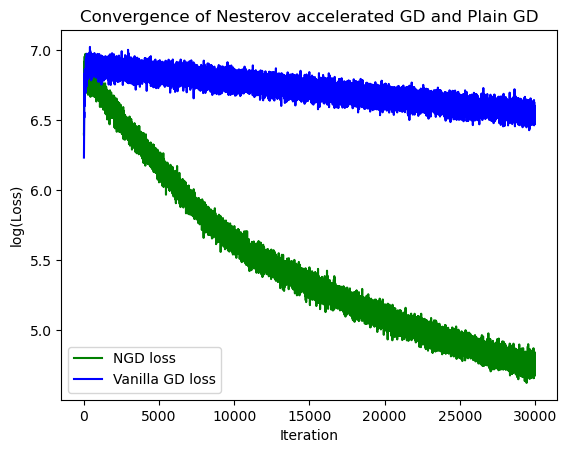

In [221]:
plt.plot(np.log10(Nesterov_losses), label = 'NGD loss', c = 'g')
plt.plot(np.log10(losses), label = 'Vanilla GD loss', c = 'b' )
plt.xlabel('Iteration')
plt.ylabel('log(Loss)')
plt.title('Convergence of Nesterov accelerated GD and Plain GD')
plt.legend()

In [213]:
c,z, Nesterov_losses_sgd = nesterov_train_stochastic(n = 16, steps = 30000, Dt = 1e-8)

  0%|          | 0/30000 [00:00<?, ?it/s]

loss: 5733900.438442878
loss: 6148047.832249496
loss: 6570938.783293152
loss: 8149699.1114764325
loss: 9712132.224501347
loss: 12963122.21661054
loss: 15833976.940889103
loss: 20048276.20662152
loss: 27102534.507907007
loss: 32197552.669072494
loss: 34351795.04512052
loss: 35093928.15591681
loss: 32686422.794176865
loss: 31331450.164588
loss: 32120678.34061653
loss: 32816916.02504172
loss: 28364435.550334863
loss: 27516996.02242876
loss: 33629827.05329093
loss: 30721942.018320717
loss: 24428624.379957087
loss: 27601206.116942696
loss: 31666743.132507518
loss: 35145968.303713106
loss: 27489444.66000452
loss: 26363146.998580504
loss: 28900774.307842053
loss: 29864838.194376625
loss: 28181436.156695016
loss: 33685061.14636102
loss: 29984818.986466505
loss: 34513689.42571094
loss: 32940823.246535882
loss: 39955341.7364522
loss: 35991960.47323023
loss: 29811548.502325583
loss: 25794625.93878682
loss: 29847597.836370073
loss: 24525598.67023276
loss: 32079270.06548284
loss: 33667225.389490806

loss: 30486057.23810981
loss: 32589478.366612803
loss: 32338395.92583491
loss: 25242009.622390654
loss: 33044077.264983226
loss: 31760957.894655395
loss: 29446977.779048573
loss: 27608222.029754516
loss: 31033657.715700503
loss: 31787777.117152635
loss: 25011169.520115707
loss: 24361512.65711453
loss: 26633161.088425543
loss: 31872822.733067658
loss: 31595134.472285107
loss: 24122740.416869853
loss: 30605226.648354527
loss: 24404831.595056374
loss: 31630914.078090288
loss: 32633001.610597566
loss: 36141520.234042265
loss: 30263472.002329197
loss: 30292491.193497732
loss: 26542088.291750092
loss: 29780816.75026495
loss: 30479866.631264962
loss: 25382744.576648965
loss: 36846238.94893214
loss: 29531942.753221948
loss: 35351898.629746564
loss: 25662259.359344263
loss: 28998110.36637168
loss: 29065944.699996505
loss: 29594169.711911935
loss: 41393851.84938813
loss: 30241953.750267964
loss: 33409032.189963076
loss: 33982217.55520231
loss: 30980287.342383876
loss: 30067432.553257074
loss: 41

loss: 26007959.389400005
loss: 24885622.55178142
loss: 27552774.48392942
loss: 33646248.825218014
loss: 29381248.74463818
loss: 27253874.831851877
loss: 29580226.242509935
loss: 34698100.62263458
loss: 26765074.878198564
loss: 30376867.995170236
loss: 30487564.872032024
loss: 31113884.865127597
loss: 31029265.38902691
loss: 33024685.493943978
loss: 28358672.562114257
loss: 27492832.545589708
loss: 32803438.68889879
loss: 33375326.378441166
loss: 31429247.996532578
loss: 29373826.21421651
loss: 26567159.442625213
loss: 27275263.487511575
loss: 31325391.54051266
loss: 31425615.761711746
loss: 31415799.971429583
loss: 36737090.75914249
loss: 30693282.98476129
loss: 33298740.322325155
loss: 29434028.017791886
loss: 32809698.67602076
loss: 35052662.38793643
loss: 25843568.813401192
loss: 34972353.56999122
loss: 32530900.062462796
loss: 24443913.357477687
loss: 34998371.16260474
loss: 24852825.709184326
loss: 30052359.987344764
loss: 30991757.677390914
loss: 23334073.530991595
loss: 33342895

loss: 28144336.30075545
loss: 38782613.3294516
loss: 31280820.58037227
loss: 30363325.52284988
loss: 28873174.904877443
loss: 34201620.72316038
loss: 33358489.53854407
loss: 35421323.09889734
loss: 33801773.33280142
loss: 33585249.81280559
loss: 33204766.597220473
loss: 30160967.034186386
loss: 31380912.40194794
loss: 28543764.22564844
loss: 30196022.322676726
loss: 38594120.083196186
loss: 29808187.04396042
loss: 29431991.6905213
loss: 33287191.46761296
loss: 29274303.32190122
loss: 25124916.035598367
loss: 25565999.307652812
loss: 36763839.24202136
loss: 30276067.557201736
loss: 31275057.3338256
loss: 36725398.53977112
loss: 30254042.369454358
loss: 23652008.15832855
loss: 26699708.01189821
loss: 34046859.98387774
loss: 34320070.935146786
loss: 34628540.4823327
loss: 31571332.037330497
loss: 28265502.42626572
loss: 37813908.98087953
loss: 30943122.973489903
loss: 34668325.402987204
loss: 31000327.384633265
loss: 33138513.782753587
loss: 35928678.00021224
loss: 28795875.18046216
loss:

loss: 27236276.65817386
loss: 32096546.701565217
loss: 31490971.390984796
loss: 25329106.497606117
loss: 30875560.135849647
loss: 28008623.251908883
loss: 29684657.50286821
loss: 30391356.750109155
loss: 24148293.014662735
loss: 30995510.922690492
loss: 24744320.274264563
loss: 32869653.787091114
loss: 30127153.255935706
loss: 31137895.59235803
loss: 28825019.388172362
loss: 31615554.14246959
loss: 26928122.241532955
loss: 29199706.659193225
loss: 30594915.792841285
loss: 28891034.78697398
loss: 30703489.689851295
loss: 30787983.66373929
loss: 31330383.30847414
loss: 35224479.229497656
loss: 37299449.602472946
loss: 26792365.612899262
loss: 30432236.433252368
loss: 32084552.02008048
loss: 33057018.964779846
loss: 31199767.826346535
loss: 27312816.96247175
loss: 32842377.645975746
loss: 30831267.28712584
loss: 30475332.23743149
loss: 32298944.19631228
loss: 31182668.551964257
loss: 25164365.37169509
loss: 31372411.242162123
loss: 27293973.740839038
loss: 25300737.013728242
loss: 2532891

loss: 27593619.711980507
loss: 28974336.27802468
loss: 31494584.812901486
loss: 27840778.537032146
loss: 30874011.104262933
loss: 25786131.84000041
loss: 30924968.87857096
loss: 33127182.956260163
loss: 32861218.17805363
loss: 33447779.800292213
loss: 27107811.284332298
loss: 35729214.03840228
loss: 33936559.54375302
loss: 28092621.415913932
loss: 27024478.915528122
loss: 29536489.756190307
loss: 27159250.854994316
loss: 25119347.33595626
loss: 27405972.9477884
loss: 25309041.336629722
loss: 28064858.855214827
loss: 29310006.783075675
loss: 31221400.28794748
loss: 33688292.69294923
loss: 30766112.427385494
loss: 29726393.412468225
loss: 30727199.462500274
loss: 28501838.179233693
loss: 24241822.883931655
loss: 24883392.257794913
loss: 26595658.893204506
loss: 29129041.811478857
loss: 30437208.04121412
loss: 33788179.919355325
loss: 34157554.18834214
loss: 26848556.008304078
loss: 29947726.774987854
loss: 27431568.29858724
loss: 31795276.371177856
loss: 30934658.443344437
loss: 26049816

loss: 28809773.22472765
loss: 33996840.79733556
loss: 26766591.502726775
loss: 35592396.6979381
loss: 33799038.912778
loss: 29255218.381058313
loss: 31193402.49518996
loss: 31746064.454254385
loss: 28508402.618868385
loss: 28412273.199453726
loss: 27444981.45491936
loss: 28329710.01400808
loss: 28949503.56069357
loss: 32165343.239357643
loss: 27201600.604421258
loss: 24867049.014310982
loss: 32826535.346016746
loss: 31580528.749250177
loss: 31664755.117970224
loss: 29850530.8464709
loss: 27686771.308356132
loss: 28290347.50683794
loss: 27347025.615992423
loss: 29643979.85805849
loss: 34051336.99402162
loss: 30030809.675488975
loss: 23684775.720250655
loss: 29748051.505680237
loss: 28019791.995996177
loss: 29817572.091754004
loss: 33365675.553252235
loss: 28481492.79035989
loss: 29965297.967704166
loss: 26524665.372817807
loss: 27615166.76524678
loss: 32917640.966564987
loss: 29655696.934911452
loss: 30645005.876326114
loss: 30241841.665734496
loss: 28393376.101986367
loss: 26976854.348

loss: 27436980.399174906
loss: 28720538.291355614
loss: 30065353.31427697
loss: 33066797.12797242
loss: 26261781.241520707
loss: 36568681.98987036
loss: 32051203.34739126
loss: 30218448.12426983
loss: 29441343.513910864
loss: 25426231.592701387
loss: 27036185.394606117
loss: 34565813.64403186
loss: 28927285.691744473
loss: 27778676.72545745
loss: 33046889.25633785
loss: 29073591.633433014
loss: 31958515.381989617
loss: 30872466.56754496
loss: 28330769.932553664
loss: 28936173.56274807
loss: 24315564.513330743
loss: 29201237.140090194
loss: 27739330.552493278
loss: 26411192.007506013
loss: 28253799.815692835
loss: 29703691.207826335
loss: 27361305.778320424
loss: 27564034.350641362
loss: 29071627.634709533
loss: 30253641.333297998
loss: 31469502.47024002
loss: 32256280.17494759
loss: 29047323.38980133
loss: 28798775.851515222
loss: 30309956.734132905
loss: 30928841.109192915
loss: 30087796.278217316
loss: 30396866.474145908
loss: 21429577.3297662
loss: 31241771.581023943
loss: 33729400.

loss: 28499678.016725365
loss: 30905883.638146825
loss: 30817296.61560208
loss: 28608166.272796784
loss: 30436746.623039268
loss: 30360279.869690698
loss: 29472081.406436138
loss: 23782350.93304999
loss: 36670261.820669554
loss: 31041729.876394052
loss: 28576313.414036192
loss: 28781583.244801275
loss: 30342108.269436933
loss: 24002336.299809996
loss: 26300271.86293387
loss: 26779548.698712576
loss: 25643454.36228164
loss: 25325105.515290625
loss: 29966115.319569256
loss: 27184042.77137358
loss: 29973652.51362606
loss: 26734980.55962705
loss: 30210358.456171554
loss: 25494366.129671127
loss: 26704883.15425746
loss: 25900114.136833344
loss: 32762673.45849452
loss: 28753433.03871382
loss: 29929333.35453478
loss: 28304127.149738405
loss: 24242083.995405123
loss: 31966387.843539834
loss: 30445099.619106133
loss: 29423904.392405037
loss: 28726168.18814007
loss: 25017616.244859826
loss: 29990243.52377298
loss: 26591759.238818556
loss: 24441658.059772015
loss: 28298329.39193837
loss: 28704255

loss: 27568353.114549473
loss: 27640683.599604473
loss: 22764538.661528442
loss: 30975220.861121062
loss: 25030186.262219857
loss: 23808768.155456245
loss: 28634787.53411789
loss: 32189047.27077185
loss: 22375996.293813087
loss: 23093724.739927765
loss: 33606588.26697625
loss: 29649170.721521728
loss: 28789324.71377556
loss: 25989258.81452808
loss: 27244692.294869523
loss: 28790991.685689416
loss: 25141818.78517311
loss: 30759513.36944856
loss: 26474992.987213805
loss: 36697733.64425055
loss: 30475796.664825283
loss: 30641055.03955884
loss: 29351844.550275754
loss: 25660547.411221214
loss: 27111278.444256503
loss: 26051594.45990689
loss: 32442173.21921311
loss: 32360493.756831795
loss: 30288960.01485839
loss: 26987847.920787077
loss: 27698363.52698263
loss: 35392712.468182966
loss: 27139587.299048178
loss: 29144216.322023626
loss: 30069998.11752852
loss: 30239964.92726648
loss: 26654871.597190373
loss: 27567205.05765213
loss: 29113345.85157175
loss: 28968452.200383473
loss: 26409606.79

loss: 25800901.845029514
loss: 30260422.31182602
loss: 29655263.06184854
loss: 26619476.791304886
loss: 23776350.465818826
loss: 35231494.02550778
loss: 29351530.452901237
loss: 26851290.917961717
loss: 32481336.722933497
loss: 34632382.60345753
loss: 30410148.1519536
loss: 24945769.96873184
loss: 28158147.54899387
loss: 22780162.287207954
loss: 33106942.089038264
loss: 25036930.890491728
loss: 27190128.50457799
loss: 26473657.77626239
loss: 26317321.059267953
loss: 23235968.81521043
loss: 24303074.084247686
loss: 25266269.790530983
loss: 25024887.595173057
loss: 27812702.972404152
loss: 32541206.705761824
loss: 28380001.514618844
loss: 31026796.89674954
loss: 22385688.75191316
loss: 28092783.14815223
loss: 28976549.64900695
loss: 29977823.757510036
loss: 31250524.409781422
loss: 27726835.21383963
loss: 25752641.320155494
loss: 25944479.669330772
loss: 24587226.891722832
loss: 25974517.38901409
loss: 33184953.533899914
loss: 29510128.621276435
loss: 28148449.370689373
loss: 26093367.86

loss: 25110517.992016844
loss: 23879795.38955664
loss: 30056462.485441506
loss: 24377123.79252131
loss: 31563858.376894295
loss: 26479968.151728395
loss: 26704958.260689843
loss: 25951754.092765044
loss: 22081750.097831354
loss: 30462121.38812996
loss: 31217166.903017696
loss: 27162030.749375902
loss: 29900417.189335342
loss: 29857896.221940268
loss: 31296958.738040384
loss: 23425796.286367614
loss: 26669638.827645227
loss: 31328253.644319434
loss: 28850997.558313444
loss: 28659782.902495902
loss: 19784959.14568292
loss: 26881047.679717507
loss: 27842404.013040308
loss: 29015955.931929115
loss: 34093645.60610353
loss: 24765966.562984496
loss: 31180769.800761376
loss: 24303100.057170127
loss: 24235058.738239102
loss: 28011607.142873447
loss: 33108039.841324173
loss: 25793634.782961864
loss: 32619991.839552455
loss: 26384988.018597443
loss: 25397550.209472466
loss: 24529955.868969403
loss: 31467244.8830859
loss: 25935697.743670076
loss: 26136033.23923549
loss: 24360298.29722277
loss: 281

loss: 31020064.964829937
loss: 32774159.888066724
loss: 28310375.74669118
loss: 28526497.29218836
loss: 28655868.88724721
loss: 23821601.090371422
loss: 25336402.1482035
loss: 28926430.78538254
loss: 22545307.455392487
loss: 23924493.43791969
loss: 27116292.052484017
loss: 31812977.41732384
loss: 29202510.385398347
loss: 24534521.283386156
loss: 28310108.35469987
loss: 31828630.512111958
loss: 30701620.197229896
loss: 23886533.08098266
loss: 23274884.020083033
loss: 26111417.23203461
loss: 30489136.074982494
loss: 29613284.55599986
loss: 20731793.105916344
loss: 24930463.575038575
loss: 22265979.238207847
loss: 31255189.888998833
loss: 23136784.487385243
loss: 27161085.39076035
loss: 29394092.180965837
loss: 28748706.831685312
loss: 33086684.27415909
loss: 28551602.615491375
loss: 28116277.5634126
loss: 30854667.10677858
loss: 26706035.52312942
loss: 25112529.523094174
loss: 25045304.999713715
loss: 22806235.04850341
loss: 31449469.25380024
loss: 26127659.85038496
loss: 25486143.539880

loss: 30904557.83770035
loss: 29466725.138642203
loss: 25794214.204718307
loss: 24866819.778299116
loss: 26856529.807618994
loss: 28458783.14712183
loss: 28171864.577397253
loss: 28635591.138457235
loss: 25275568.089819785
loss: 26166097.059322577
loss: 28170403.311565895
loss: 26364540.666279167
loss: 27503607.84242001
loss: 31680545.458003525
loss: 26233666.06050594
loss: 27892590.467693955
loss: 28687775.85734813
loss: 27378612.192695018
loss: 24676495.262631975
loss: 30980281.76253424
loss: 28789811.12729599
loss: 27873664.22795726
loss: 25750379.015542354
loss: 34691649.97624771
loss: 26833484.717915803
loss: 27929659.56049329
loss: 24790622.89339961
loss: 26899598.19848349
loss: 27974518.673097465
loss: 24625287.744635347
loss: 21963651.252190206
loss: 25696330.60391015
loss: 26091223.381297022
loss: 30267261.64784751
loss: 22732955.69305079
loss: 26470319.013868462
loss: 25862005.929766405
loss: 25686236.41582987
loss: 22179204.551891748
loss: 29267085.2799574
loss: 25659799.996

loss: 26565689.97311969
loss: 28099989.818584193
loss: 27124537.78571385
loss: 23628060.522407696
loss: 25443612.14859825
loss: 27192385.653623857
loss: 28264658.674301058
loss: 26955540.766086813
loss: 25836629.599469084
loss: 28564722.982962277
loss: 28879799.318798248
loss: 28217093.067227747
loss: 19413392.767928872
loss: 30074646.37891016
loss: 32049156.670467053
loss: 30345165.50822067
loss: 23478512.841314845
loss: 28026967.557448037
loss: 26933518.324669912
loss: 23188620.982704226
loss: 25468106.144219086
loss: 25908015.406307876
loss: 20616046.76382667
loss: 25298749.168046802
loss: 25289226.255612623
loss: 22440768.45172446
loss: 31217954.005043916
loss: 21269920.45360318
loss: 29933534.721224155
loss: 26839981.51543468
loss: 27079850.6579287
loss: 26405216.149084833
loss: 25927254.434728853
loss: 29939098.344883516
loss: 23721739.937588125
loss: 26811102.76939426
loss: 26290723.731320627
loss: 29377937.139011353
loss: 24767403.587506544
loss: 29114543.342332557
loss: 260199

loss: 27097184.68465199
loss: 23106836.837067712
loss: 28033921.863219447
loss: 27868619.314774495
loss: 26302255.470579363
loss: 23119300.30887547
loss: 27879028.196657646
loss: 28460462.82158126
loss: 27976352.286314424
loss: 25012350.172347527
loss: 22443350.43278309
loss: 25150453.349355813
loss: 26820603.791690856
loss: 26981085.824744575
loss: 23653681.880284287
loss: 22215366.416326143
loss: 22984388.356539976
loss: 22330699.870226935
loss: 25285072.78166567
loss: 26000336.085453458
loss: 29240362.65940778
loss: 23975899.27217084
loss: 27026042.424025085
loss: 25526896.23758479
loss: 23543826.365354393
loss: 25508891.341460243
loss: 23436043.90509827
loss: 27478404.363169935
loss: 24930951.15941641
loss: 29450009.72498885
loss: 26082698.999428842
loss: 30029628.94373971
loss: 24129458.042196088
loss: 25736096.245320186
loss: 30432015.77152491
loss: 25325867.57033525
loss: 26973168.6433643
loss: 25929197.29017192
loss: 28322954.046821397
loss: 29001644.91527333
loss: 23256636.334

loss: 23743696.502904616
loss: 24151540.363091365
loss: 23637280.875227574
loss: 27879243.07247345
loss: 24786601.41390773
loss: 24046477.987554085
loss: 24759115.970937118
loss: 23907020.276771933
loss: 29974604.40926232
loss: 31235295.841695018
loss: 22755091.77654009
loss: 29028417.213946756
loss: 29567458.47128769
loss: 31500576.705036033
loss: 24588237.34404965
loss: 24769167.563402805
loss: 22202695.0646068
loss: 25981037.997721527
loss: 30812544.91348017
loss: 25403009.80755117
loss: 26188875.737390433
loss: 22452018.813902643
loss: 29825418.05320546
loss: 26873350.832975674
loss: 27583865.555655938
loss: 22687351.593300704
loss: 21731748.33896254
loss: 24876200.33538047
loss: 28309286.73301785
loss: 26406595.59122267
loss: 26729083.89528116
loss: 27811334.05985147
loss: 24906680.544607848
loss: 27206486.66527562
loss: 24659883.73411036
loss: 30752383.17811115
loss: 29327917.817697525
loss: 23921949.183121465
loss: 21761695.107441083
loss: 24555571.485690184
loss: 24812319.67821

loss: 23489677.71130593
loss: 30759831.01148301
loss: 23946683.227313787
loss: 23710411.832765616
loss: 29854824.11960368
loss: 25076858.16358061
loss: 23728294.21279921
loss: 25514754.688523248
loss: 29594981.703970693
loss: 30404770.83570856
loss: 24903093.690769866
loss: 24654083.32854833
loss: 27757184.78084163
loss: 25696347.402751487
loss: 30446535.36447132
loss: 28888748.184638344
loss: 27787968.854289316
loss: 27007505.803938728
loss: 23166567.432957374
loss: 23747398.226340156
loss: 25043245.247225944
loss: 25100192.13759072
loss: 24512760.08003494
loss: 27598792.68644523
loss: 23623333.052167144
loss: 21415824.867266096
loss: 24218579.2705114
loss: 25238697.014920607
loss: 25716461.253946852
loss: 24210947.175747827
loss: 28369578.667617507
loss: 27005987.962405745
loss: 25222934.871351678
loss: 23583700.109296568
loss: 27162907.320398346
loss: 28131905.751694612
loss: 26477124.061821025
loss: 25712668.576373883
loss: 21431599.529131457
loss: 26209188.94261972
loss: 26598073.

loss: 25797168.542024653
loss: 27181063.530833427
loss: 24540924.363323472
loss: 26159282.8417737
loss: 22861754.01285718
loss: 24202741.615186304
loss: 26851233.706264194
loss: 28120948.28050682
loss: 25861200.65045654
loss: 25514855.39472338
loss: 25758084.58763674
loss: 22788729.73114837
loss: 26356249.56659286
loss: 28374855.925639383
loss: 27775618.08032585
loss: 24343904.875109766
loss: 24888253.872395843
loss: 22190334.871963706
loss: 27892391.236985933
loss: 21129682.98352816
loss: 27228629.499026787
loss: 22667574.5912762
loss: 26606264.011467714
loss: 30260292.117167905
loss: 26683505.5052696
loss: 20481366.000872497
loss: 26291726.18206024
loss: 27238089.130591787
loss: 24884034.274064355
loss: 22951220.76887885
loss: 26340059.063628472
loss: 22640409.511544198
loss: 18625444.614981033
loss: 23684111.822645683
loss: 25601633.984038077
loss: 23628745.06869906
loss: 28081296.974664874
loss: 23100009.143578835
loss: 22838348.158700753
loss: 27629981.693193983
loss: 26463731.566

loss: 27055317.332830656
loss: 21300835.513707243
loss: 25683665.377650354
loss: 22387272.230183076
loss: 28846851.202246163
loss: 25343969.336416665
loss: 25454873.90679516
loss: 31168280.451624177
loss: 23135129.21403512
loss: 24837755.223638225
loss: 24673390.93506925
loss: 24771386.563659355
loss: 25135793.84037455
loss: 28262557.031267896
loss: 31298901.725084506
loss: 23866769.280853685
loss: 23819776.853017867
loss: 31369521.303939782
loss: 18935754.361400824
loss: 23288527.031183183
loss: 24141550.696438394
loss: 29618535.31709701
loss: 24480539.0241987
loss: 20538579.46669821
loss: 26456554.69016215
loss: 24548516.710012946
loss: 27253972.816824064
loss: 22744500.208739486
loss: 26200971.432382092
loss: 26170157.603531014
loss: 21833684.83095636
loss: 26151400.103512496
loss: 19392279.4003958
loss: 19770735.56979444
loss: 24089613.894095868
loss: 27701421.044796616
loss: 24686547.797537994
loss: 26262625.426463347
loss: 25530043.152121697
loss: 22960960.00880064
loss: 25840437

loss: 25075804.32930213
loss: 25562543.78820175
loss: 27286001.051357783
loss: 24653046.32036048
loss: 20908358.027697753
loss: 26879391.912301414
loss: 20574598.463075887
loss: 25026523.273335006
loss: 27773015.45315872
loss: 23534838.559456024
loss: 29797108.076348443
loss: 27278950.1884642
loss: 26722167.465280645
loss: 23176786.012681205
loss: 25177329.307530943
loss: 27359483.96813998
loss: 24017541.08106405
loss: 25596312.093773663
loss: 29901846.326697435
loss: 22537851.17640964
loss: 22409987.291489184
loss: 23547534.10033496
loss: 25271204.567747734
loss: 26648415.08585075
loss: 25643454.346363716
loss: 19926422.476567782
loss: 20826820.546710327
loss: 22078173.4259368
loss: 20739049.831457462
loss: 21796835.26515662
loss: 24924428.997201286
loss: 25188274.404048678
loss: 29496342.960330345
loss: 23140918.003064033
loss: 21759968.77720057
loss: 27353592.573338944
loss: 21249829.20414251
loss: 26592274.484691516
loss: 20487688.41845023
loss: 27956555.191270437
loss: 28962869.13

loss: 25609836.934961915
loss: 26519011.238863625
loss: 23239684.02827473
loss: 23470430.158866357
loss: 28180916.204967733
loss: 22162365.08283364
loss: 21423644.78455494
loss: 26431904.398131732
loss: 21852161.214663215
loss: 25600992.605476897
loss: 26691263.955655284
loss: 21908133.01471919
loss: 25152247.832699493
loss: 25564558.00536937
loss: 29498810.350677997
loss: 21165197.77462829
loss: 21796424.57018405
loss: 26183426.80697229
loss: 24660052.740045954
loss: 23664544.617994685
loss: 24144601.01676148
loss: 22996054.293344453
loss: 22220648.70001308
loss: 25008014.41939078
loss: 24253388.127393838
loss: 24381585.003135733
loss: 23743278.65004786
loss: 25583057.96088776
loss: 20809062.681619376
loss: 30301845.9283846
loss: 23668339.569302063
loss: 23832026.400285974
loss: 24351862.31841849
loss: 22910296.228376295
loss: 21301074.449253593
loss: 25006696.99531535
loss: 25865567.921671484
loss: 27864879.823969595
loss: 28916798.642068338
loss: 23629544.42074015
loss: 29223305.122

loss: 23392919.68672376
loss: 23351839.032378394
loss: 21034971.440516282
loss: 26448325.289421212
loss: 26522407.885567162
loss: 23601004.64715398
loss: 28086888.46822809
loss: 26170770.710765712
loss: 28277563.984655216
loss: 23001268.608053077
loss: 23985170.371252127
loss: 22009793.248910714
loss: 26849186.844340425
loss: 22806458.087120872
loss: 25052204.402185332
loss: 29875026.945334535
loss: 23548105.25522371
loss: 21727979.306648254
loss: 24108096.770145614
loss: 17242605.348975718
loss: 23435537.23332615
loss: 18928415.956524193
loss: 19887702.37437904
loss: 19194768.6253219
loss: 21895439.694324624
loss: 22766310.360015724
loss: 25355637.259004626
loss: 25319854.383676413
loss: 25680326.48204741
loss: 21844818.206364837
loss: 22866386.492464073
loss: 22855390.136495948
loss: 21260464.953764427
loss: 18981396.703774896
loss: 23854303.715611324
loss: 22164893.223183684
loss: 24743329.186755314
loss: 27984009.240642685
loss: 26519743.2458589
loss: 25300395.576977577
loss: 25290

loss: 21196853.09216752
loss: 25324864.8665029
loss: 32646558.170171715
loss: 24118622.390714962
loss: 24580113.132456545
loss: 25130853.298693083
loss: 19161870.503188178
loss: 27502591.66641233
loss: 24212994.901480876
loss: 23415721.645082146
loss: 22215416.730781935
loss: 21132365.38468039
loss: 24958774.081354503
loss: 28577399.711942855
loss: 22611813.883624434
loss: 25311343.90233312
loss: 24080418.173808243
loss: 24346600.508015387
loss: 25530439.42786414
loss: 23634766.73051768
loss: 22392736.866839573
loss: 19364536.622979607
loss: 24295318.900635492
loss: 20171633.480996206
loss: 22621948.244842723
loss: 24253484.64096921
loss: 21076797.30307717
loss: 23966626.42460746
loss: 24789714.115350787
loss: 21935509.572139837
loss: 21853103.988317724
loss: 19418057.068578187
loss: 24460624.89068621
loss: 24018913.88578346
loss: 22601200.73806391
loss: 25609798.619518492
loss: 21205812.537354626
loss: 27844444.89065443
loss: 21457805.812946513
loss: 23695937.46107184
loss: 27293515.0

loss: 23074688.391545746
loss: 25415951.543797318
loss: 22148565.758021936
loss: 28232163.648712706
loss: 20055290.091878965
loss: 23551847.435509294
loss: 23119821.277631763
loss: 20035557.615900956
loss: 25555797.25972703
loss: 21761656.505576067
loss: 24430919.947561692
loss: 22317869.459134057
loss: 23652580.426183634
loss: 19882900.851289596
loss: 22119170.324880082
loss: 23110686.28328264
loss: 26492399.05724627
loss: 23936336.309471183
loss: 23082538.919769075
loss: 24873957.189979218
loss: 23673755.11348422
loss: 23813952.276124947
loss: 22050289.145771783
loss: 27470237.918173127
loss: 23598204.244623292
loss: 26808340.38970689
loss: 25221945.84565335
loss: 20803525.762405265
loss: 25166263.214047316
loss: 24138941.60193666
loss: 24669558.999566372
loss: 23886105.12601813
loss: 20883871.087951377
loss: 26535258.383196253
loss: 18879063.544440873
loss: 22844819.02712699
loss: 25708604.88076644
loss: 23112724.039523233
loss: 22293860.863260422
loss: 21887641.48445619
loss: 22462

loss: 23822545.38376563
loss: 21236525.401687793
loss: 26881449.185008742
loss: 25932459.83494278
loss: 24902886.261215147
loss: 22095156.789042618
loss: 25272698.60325857
loss: 23380111.586478822
loss: 24250070.585331786
loss: 24129053.660060696
loss: 18274375.121574424
loss: 23278628.082203217
loss: 26132866.81632543
loss: 21177068.010704275
loss: 22919659.6159959
loss: 23003881.46632566
loss: 25553790.923519142
loss: 22000033.032259054
loss: 24161745.7778648
loss: 19802231.752549384
loss: 27876271.332489982
loss: 25400628.428121585
loss: 24647745.29806833
loss: 21919521.650435682
loss: 23230414.453119475
loss: 22359839.49437126
loss: 23675910.54718298
loss: 20954221.568568625
loss: 22340611.60773736
loss: 24229302.99354934
loss: 20673163.56820697
loss: 25907824.96997463
loss: 19862307.889009744
loss: 22680852.773311898
loss: 17641205.601713136
loss: 25674319.33762255
loss: 22256629.923779815
loss: 19837835.242928978
loss: 23904726.760962117
loss: 28177868.282907326
loss: 23881093.69

loss: 22878978.03867536
loss: 23810527.190591887
loss: 24549192.928694673
loss: 24171623.015136167
loss: 22035431.082334965
loss: 20812898.464116983
loss: 23495425.266313642
loss: 27359801.180698734
loss: 19476015.99034057
loss: 25112093.678427003
loss: 18449249.401968963
loss: 21599038.158330854
loss: 23963351.309208672
loss: 16131037.60376183
loss: 21328063.843025908
loss: 23047768.195608757
loss: 20306416.813516144
loss: 23545696.27526034
loss: 21274091.337936416
loss: 24450372.055878606
loss: 24706310.639904417
loss: 24975749.882646475
loss: 24984561.26162499
loss: 18878299.479622968
loss: 24818434.948880855
loss: 21694707.218543258
loss: 21818178.15390172
loss: 17878014.730731416
loss: 29319394.932505406
loss: 23647641.886293206
loss: 23558613.621670343
loss: 27238102.845157724
loss: 24652041.283582475
loss: 21415979.86183425
loss: 23368801.69704519
loss: 28051877.70166896
loss: 23742278.372260667
loss: 25034028.37567558
loss: 21370599.55603705
loss: 23190187.632086586
loss: 21248

loss: 22465476.122146547
loss: 19750213.153555345
loss: 21512433.625755887
loss: 17603776.89354773
loss: 24887240.854352415
loss: 19649977.843575064
loss: 22916437.119534295
loss: 25479967.693760928
loss: 22613088.886918712
loss: 20547154.215818916
loss: 20770645.04475138
loss: 20328350.948520318
loss: 21390850.076985803
loss: 21809840.419373
loss: 22063360.982201528
loss: 21493928.735172927
loss: 25131461.194248527
loss: 21737753.31546257
loss: 24559844.58122657
loss: 18138192.40065903
loss: 23697976.239473805
loss: 25024584.04423333
loss: 27551008.955880914
loss: 17848827.96957647
loss: 26623058.993434895
loss: 27851294.168040566
loss: 25856925.128537644
loss: 26244102.782748383
loss: 21446703.3067758
loss: 21878554.379021686
loss: 21247398.46630063
loss: 21849381.536631607
loss: 22931887.936201178
loss: 21354655.172406938
loss: 22116116.643423393
loss: 19946499.52268091
loss: 25023451.639814902
loss: 23201579.131686
loss: 23342199.934041694
loss: 19752448.862037964
loss: 26370281.21

loss: 19662432.161346015
loss: 24668882.965257544
loss: 20026276.231337342
loss: 19704040.790771574
loss: 25659866.812930383
loss: 22713756.530521587
loss: 17972183.325462326
loss: 23357843.292006362
loss: 23427742.3679659
loss: 24673750.07533032
loss: 20802961.26537783
loss: 23507282.077411056
loss: 28763817.39270534
loss: 20369206.04482527
loss: 23936121.172528815
loss: 23122115.177241165
loss: 19359366.692541648
loss: 19729092.440332573
loss: 21438536.80908996
loss: 23989508.35433738
loss: 26800416.45586379
loss: 23308888.166705478
loss: 25161045.713923134
loss: 27303855.269643486
loss: 22451680.60678496
loss: 21538340.562376875
loss: 21777003.227160443
loss: 26578025.09125898
loss: 22860383.50016201
loss: 21512681.586230434
loss: 21510130.496325016
loss: 25152382.490674384
loss: 22026276.260680225
loss: 23057067.186899096
loss: 21061125.262803465
loss: 24978016.07574894
loss: 24656541.49553404
loss: 23904794.625746094
loss: 22273545.4660984
loss: 20127940.680004112
loss: 20850027.0

loss: 20778281.264709983
loss: 20753352.911982443
loss: 22002637.45627787
loss: 19721958.39759403
loss: 19850128.74903016
loss: 25727574.65106594
loss: 16429850.453518394
loss: 22429399.118052576
loss: 27374295.46340542
loss: 22312587.743903328
loss: 16910491.05502381
loss: 24951251.05155011
loss: 24651851.85276051
loss: 20436007.67729521
loss: 25892900.595631294
loss: 22084071.465769164
loss: 20099362.84362757
loss: 18880078.565028794
loss: 18176254.502891984
loss: 19109812.995894257
loss: 21883087.589081354
loss: 23153232.593217067
loss: 21934141.714873902
loss: 20621107.81358114
loss: 21084021.842321146
loss: 21524194.558999155
loss: 21660590.523172386
loss: 22481993.765733894
loss: 23493201.744190257
loss: 27236759.13472346
loss: 20132975.80607832
loss: 21474821.38221868
loss: 26707527.20024042
loss: 24992373.06927256
loss: 19803603.082385704
loss: 25430717.130568635
loss: 21303257.176502593
loss: 24483647.669036012
loss: 20808939.7504761
loss: 24436366.585359413
loss: 24305366.135

loss: 22585688.873460814
loss: 24427392.32175166
loss: 24732353.76432393
loss: 21889980.62855806
loss: 21878141.22154741
loss: 22999954.45241268
loss: 25172654.767863404
loss: 17917384.67645312
loss: 20721884.542354707
loss: 16898285.81938057
loss: 22647534.34756054
loss: 22070940.680201028
loss: 19238268.796044033
loss: 26380064.78792788
loss: 20123298.033929083
loss: 22013595.71897211
loss: 20774259.476062194
loss: 21715064.13620359
loss: 17657892.93091543
loss: 24541917.49913894
loss: 23894588.138998147
loss: 23460806.000645503
loss: 19014583.099744316
loss: 23563280.133354973
loss: 22980964.50149524
loss: 18987727.31520767
loss: 22245217.828920018
loss: 19015643.61677216
loss: 22442505.521500006
loss: 21336136.03785862
loss: 20959673.802763496
loss: 22836256.29905809
loss: 21914453.039006166
loss: 20887087.77219792
loss: 18543395.036764912
loss: 21814922.599281486
loss: 21540139.090473242
loss: 18655878.095235437
loss: 21538133.54292054
loss: 24921272.892938808
loss: 21400688.39704

loss: 27324446.454140756
loss: 25856697.2061324
loss: 18211677.40580454
loss: 22163678.934627175
loss: 21444024.33248958
loss: 21434826.184663925
loss: 25570193.078653693
loss: 21189719.956349187
loss: 18299365.065989554
loss: 23954867.77866524
loss: 26916470.65115517
loss: 22081077.13776411
loss: 21394075.772245143
loss: 18906985.349426445
loss: 21857542.690981228
loss: 22265251.445437387
loss: 22954925.809710342
loss: 21421000.242044665
loss: 22608911.289389998
loss: 19366241.628320612
loss: 21814182.771729395
loss: 18470603.415573295
loss: 26335982.258772068
loss: 19934258.240070175
loss: 21406168.37496917
loss: 19872295.964031793
loss: 21478295.55421966
loss: 22544603.0639176
loss: 20551499.5558478
loss: 21438228.782068633
loss: 23471640.445692204
loss: 22442130.56650298
loss: 21903947.78893155
loss: 20167906.709436424
loss: 23214365.487133283
loss: 20475320.547001593
loss: 19439215.40494404
loss: 25785123.188138127
loss: 22313535.300652698
loss: 20447533.327622306
loss: 23657855.1

loss: 20500306.019386612
loss: 25468373.04115227
loss: 22438272.276421882
loss: 20263107.25283207
loss: 20394977.58552369
loss: 22388210.111164268
loss: 18762270.85205442
loss: 20034962.287703045
loss: 23592325.566789288
loss: 21434340.93098397
loss: 21363714.687357843
loss: 23014067.241781607
loss: 22207027.563941613
loss: 19168776.071395446
loss: 20336609.135631002
loss: 22559412.250150632
loss: 19421000.876011893
loss: 21068808.15142036
loss: 25349382.853704955
loss: 18277781.399851326
loss: 22370715.186498
loss: 21853421.021450955
loss: 19237869.459622644
loss: 19417906.76708763
loss: 19518503.261685006
loss: 18084781.37254787
loss: 18259564.532403402
loss: 22237018.592909746
loss: 24419583.293577414
loss: 17408734.816654496
loss: 22353336.9136149
loss: 21183860.0434156
loss: 23320190.470272843
loss: 18562639.451651815
loss: 19536961.99405844
loss: 17369406.18877946
loss: 21144036.30536275
loss: 17772914.22568586
loss: 15911228.200009195
loss: 24731915.5109952
loss: 24988147.173690

loss: 19439040.497679565
loss: 24559362.132299546
loss: 23442720.23118644
loss: 16966346.405567463
loss: 22263429.70434968
loss: 20574491.613514014
loss: 20458474.91682136
loss: 22041848.037609767
loss: 24482547.463648695
loss: 20801697.119511522
loss: 21517633.496936295
loss: 18643911.81603235
loss: 20770698.070005685
loss: 23150916.427807875
loss: 20738185.54186445
loss: 22572521.425393865
loss: 23626056.63453238
loss: 22149737.891915794
loss: 20244543.98062518
loss: 20132365.559284102
loss: 19734068.28917329
loss: 24799777.317072187
loss: 21277120.156375337
loss: 25544632.295636505
loss: 20550535.582160737
loss: 25688046.01054179
loss: 19619672.056484986
loss: 20986573.83863513
loss: 18898387.582874075
loss: 22623240.233281396
loss: 21303111.089251656
loss: 19165144.573981315
loss: 20705577.049771342
loss: 22487047.947820242
loss: 18549016.31932788
loss: 21142284.247843146
loss: 22132749.901765544
loss: 25747706.964666065
loss: 19977998.554772254
loss: 22324386.53933657
loss: 217502

loss: 22125850.96976874
loss: 23352892.771161553
loss: 23831948.00030081
loss: 22014018.755462762
loss: 21623419.710845917
loss: 23793960.687908214
loss: 24705092.869262453
loss: 22503477.31574103
loss: 25678996.152097903
loss: 16645715.56182703
loss: 19205143.2084266
loss: 21858419.919750273
loss: 22328793.04446862
loss: 22424521.373972055
loss: 19141262.231769152
loss: 20218449.53434777
loss: 22824413.940918945
loss: 18509273.48329745
loss: 20772762.53495056
loss: 19412987.73080651
loss: 20786355.55824157
loss: 20073485.473185115
loss: 19648161.901795022
loss: 19212527.041938316
loss: 25220175.902331855
loss: 20075534.498896617
loss: 18208846.24566368
loss: 23963218.34946289
loss: 19762890.853990495
loss: 15684205.965640802
loss: 21144036.257482752
loss: 22301184.091134988
loss: 19804117.220317665
loss: 18996507.240723077
loss: 21470025.14138452
loss: 23447636.315179963
loss: 16569833.878869073
loss: 22577871.81578179
loss: 20779733.45257759
loss: 23502993.493543115
loss: 19421692.71

loss: 19899724.370063737
loss: 21183999.49686368
loss: 22238537.818262096
loss: 17166785.10691904
loss: 26934043.627925888
loss: 18838247.23262964
loss: 19475345.041095108
loss: 21563870.228693865
loss: 21189896.43890095
loss: 23466223.00288655
loss: 22285037.367613297
loss: 22280810.1058751
loss: 19310552.259292886
loss: 20599951.21554059
loss: 21806058.56891533
loss: 19274567.440365043
loss: 27471817.71849713
loss: 18267050.940237556
loss: 18071227.97337787
loss: 18088524.57681201
loss: 21895663.761811532
loss: 19091154.845611352
loss: 25258975.886809755
loss: 18386784.961932883
loss: 22991389.072943732
loss: 21103673.74585997
loss: 22803664.603292592
loss: 24358134.453164354
loss: 19664990.601197273
loss: 22731013.301050797
loss: 20364362.286165755
loss: 20910413.595820416
loss: 20801761.452298135
loss: 22004691.954674155
loss: 22455841.83678201
loss: 28149077.60073719
loss: 20514746.265390377
loss: 20535502.917650916
loss: 21131770.516794343
loss: 22036818.717436835
loss: 21414994.

loss: 15403641.33818006
loss: 24741736.787694983
loss: 19584243.867055748
loss: 18046712.56926164
loss: 19390556.715841647
loss: 17147038.81058609
loss: 18455617.6261137
loss: 20523743.95516857
loss: 17497237.799481735
loss: 24918165.450028915
loss: 17989671.86198862
loss: 14893010.318784026
loss: 15422330.395875072
loss: 23841724.81953005
loss: 19330929.848808326
loss: 21003184.44915274
loss: 21911846.610500183
loss: 23145233.500367615
loss: 18003317.058523532
loss: 22050909.047008667
loss: 19056625.291996796
loss: 18590385.987877272
loss: 19000944.971482445
loss: 17847580.625836093
loss: 21242362.1142305
loss: 24077682.315369338
loss: 23918134.39154211
loss: 21605885.69703521
loss: 24016525.19436543
loss: 21039493.26825148
loss: 17411875.219931383
loss: 21937212.32280559
loss: 19162042.852816314
loss: 22861144.917551048
loss: 17489478.246275432
loss: 24143345.98075713
loss: 21171137.710682508
loss: 19979382.227086928
loss: 21643401.2554024
loss: 21766589.575672112
loss: 22271103.4881

loss: 18420034.102097515
loss: 20223068.04121537
loss: 25009316.38374443
loss: 20822239.347989883
loss: 19065843.249826875
loss: 22265962.042730216
loss: 23642260.94368572
loss: 17828823.16344968
loss: 15379989.952725476
loss: 22431596.5892666
loss: 22316946.099761397
loss: 19928490.531274475
loss: 20906183.875481714
loss: 21078814.641596824
loss: 19035126.442232724
loss: 19213842.504839167
loss: 22843756.759691846
loss: 20907557.07501514
loss: 17768270.289251495
loss: 21281715.931321245
loss: 23554419.637257986
loss: 20048612.16078089
loss: 20790507.083409924
loss: 21779649.503488183
loss: 23315792.700128034
loss: 22635039.005248383
loss: 22484994.821639434
loss: 19746859.488078408
loss: 19073945.99492781
loss: 19790425.76212478
loss: 18559397.150942717
loss: 20836587.20793561
loss: 20037393.394402616
loss: 21451247.60182321
loss: 16172901.671175899
loss: 23133451.35615787
loss: 21541629.212654646
loss: 18444602.530999895
loss: 18877851.539675344
loss: 20656408.820487153
loss: 1871323

loss: 21786746.393564455
loss: 19370139.929500554
loss: 22390052.140592147
loss: 22320419.942099143
loss: 18595290.783622526
loss: 21748094.051729165
loss: 18787927.590243753
loss: 19226426.474141814
loss: 18684454.426803946
loss: 23414656.46244922
loss: 21925893.18855721
loss: 19854331.684245802
loss: 20374690.608353313
loss: 19042993.527484313
loss: 23385491.549839433
loss: 24140156.700355787
loss: 19420867.823801797
loss: 16376852.592578994
loss: 21515674.541470837
loss: 20113606.337995064
loss: 16760992.008289665
loss: 17830333.411869537
loss: 19994707.569736656
loss: 22529061.763907965
loss: 20260674.716666475
loss: 19783847.80433989
loss: 19926521.139823124
loss: 20249310.850710455
loss: 23174087.257627837
loss: 16441061.218421383
loss: 19761434.97610106
loss: 23046373.024653584
loss: 16545861.971402897
loss: 20750584.350461014
loss: 21003951.915639535
loss: 16826156.70398718
loss: 22671554.935197603
loss: 16285338.95762468
loss: 16441602.506028228
loss: 23527381.440191377
loss: 

loss: 17067867.081637233
loss: 18103030.674897335
loss: 17225023.886455353
loss: 19465063.255741894
loss: 19274194.609429993
loss: 19564395.545467164
loss: 20649173.361990083
loss: 20916926.69784995
loss: 22120298.271114826
loss: 18786894.180940256
loss: 19834049.86212704
loss: 18540347.566295892
loss: 20136968.819661018
loss: 17203786.41435295
loss: 22028574.455674883
loss: 19925926.582082413
loss: 20168604.24110437
loss: 19664047.946197487
loss: 19110505.596045434
loss: 19792249.62249948
loss: 17458080.840813644
loss: 17259546.630551502
loss: 18888460.541748594
loss: 18618162.894236848
loss: 23160110.953612674
loss: 21948763.894026283
loss: 24497568.248359818
loss: 20078125.6504208
loss: 17702524.87933101
loss: 17128117.25133937
loss: 20633858.899716016
loss: 19484047.70806681
loss: 19593486.829069566
loss: 16362888.713732474
loss: 22298108.817962855
loss: 21472796.351577435
loss: 21488559.02117372
loss: 15233730.071804626
loss: 17506303.369809885
loss: 19155708.079393838
loss: 23109

loss: 18144867.797897004
loss: 19708130.522961274
loss: 18870185.125183232
loss: 21363123.9931186
loss: 17056198.766186487
loss: 19363211.205389757
loss: 20350870.533152115
loss: 18545742.91300195
loss: 22226628.963246804
loss: 21524924.374077555
loss: 18373105.241338193
loss: 21389846.257982686
loss: 18405799.534157027
loss: 18453464.622845735
loss: 18404459.745250195
loss: 17087427.314154807
loss: 15523274.047588691
loss: 18552553.614833068
loss: 19449046.940666717
loss: 21413472.086875923
loss: 19644564.375380334
loss: 21140833.75741765
loss: 20473543.583007697
loss: 22797549.030462813
loss: 17111660.62229771
loss: 19638980.34413942
loss: 24687616.59490003
loss: 20320606.634369187
loss: 20185004.21086221
loss: 17128521.063610367
loss: 16966173.947279558
loss: 15621211.92876579
loss: 18295954.801777795
loss: 20496486.81016247
loss: 21780758.88852547
loss: 19251464.386870347
loss: 21474599.93093024
loss: 18768486.617756814
loss: 19319567.507167496
loss: 23321580.39071284
loss: 1696726

loss: 18199427.274955675
loss: 21458447.592381258
loss: 20346424.3697164
loss: 16401313.402276088
loss: 15410188.107196677
loss: 20517681.8581248
loss: 19583932.729583614
loss: 17575236.169880714
loss: 20830991.039195683
loss: 18272338.569557168
loss: 17814393.344103783
loss: 18575843.586612415
loss: 20425427.159524444
loss: 19378711.34294284
loss: 19291483.77758644
loss: 16120912.065479018
loss: 16895509.942148115
loss: 20377719.31775453
loss: 15441160.076627377
loss: 20968644.683711007
loss: 18921407.23804419
loss: 17246847.433666706
loss: 20720252.584196277
loss: 20399550.409614895
loss: 19955173.412890278
loss: 19811015.614017706
loss: 21780863.155370224
loss: 21677613.132682532
loss: 19333948.106023543
loss: 19165723.240872838
loss: 19594023.03212748
loss: 17992282.374925353
loss: 19343719.518049415
loss: 18496044.161799572
loss: 18434326.58594909
loss: 15514553.633390442
loss: 20664841.87453357
loss: 17606129.071236096
loss: 16141616.741612965
loss: 22291324.318023715
loss: 16595

loss: 17256811.41029885
loss: 17968294.83663343
loss: 21898463.3353468
loss: 20520112.062647607
loss: 19416065.27925567
loss: 16492417.181331955
loss: 16256999.389427872
loss: 17994839.51914028
loss: 18949666.49020269
loss: 20066391.557740048
loss: 17781656.446631372
loss: 21827692.686819587
loss: 20841832.03886584
loss: 18329479.788110208
loss: 18618008.13724274
loss: 17292198.85749616
loss: 18424391.952546354
loss: 20192381.7404517
loss: 18473440.64575767
loss: 20560036.510869093
loss: 19638033.58328727
loss: 17009199.862518378
loss: 15880790.29477711
loss: 17428641.679469176
loss: 20612226.62273661
loss: 16599691.023844713
loss: 19318083.390184466
loss: 20669755.897153843
loss: 19222549.241336457
loss: 22253544.914222296
loss: 18202035.452538323
loss: 19853520.203076057
loss: 15949280.494917493
loss: 21903082.354446642
loss: 18749674.724573053
loss: 18395993.507968795
loss: 14989720.087965297
loss: 18920204.332814086
loss: 23912416.100070685
loss: 21433635.031455018
loss: 24491175.8

loss: 19970056.25504716
loss: 17985553.11014464
loss: 21185716.260194845
loss: 19313487.661987387
loss: 18383016.774082616
loss: 22630416.587489907
loss: 17412708.78834108
loss: 22042940.344671577
loss: 18958128.318208322
loss: 21240072.42884729
loss: 16612784.290910725
loss: 19987015.58312462
loss: 19383731.675994515
loss: 19078776.739105705
loss: 16570025.04577605
loss: 22108526.847160224
loss: 21637248.74076271
loss: 16827760.88846376
loss: 16666581.201557796
loss: 17240130.849533536
loss: 19470246.03309977
loss: 17070368.325302128
loss: 15797483.53195193
loss: 17811928.505129352
loss: 17446205.757099595
loss: 22666233.450973723
loss: 21553504.39228672
loss: 18570988.53790948
loss: 18659643.35116026
loss: 16960614.46333514
loss: 20359067.585680306
loss: 18386073.3707492
loss: 20756669.928736757
loss: 17619204.910953168
loss: 20485978.358348653
loss: 20557273.494795594
loss: 17353225.850060288
loss: 20553263.627908144
loss: 21620909.664872598
loss: 15811722.890017051
loss: 21549875.9

loss: 19308371.869294025
loss: 21539481.776266098
loss: 22044419.282105345
loss: 18587500.40329742
loss: 16347305.456232691
loss: 20216739.08409461
loss: 18886729.322805665
loss: 18034823.213183332
loss: 17643465.383167937
loss: 16698057.91708869
loss: 20133088.26878041
loss: 22248059.830951698
loss: 21200645.921483006
loss: 17480980.153558422
loss: 21101064.87961019
loss: 19715623.293722093
loss: 19072459.76412121
loss: 18260657.874986943
loss: 22857489.54902827
loss: 17892317.95189356
loss: 15181938.246153092
loss: 18417519.187006775
loss: 18035031.530523557
loss: 16973046.805347346
loss: 22122865.039056517
loss: 21515166.268588096
loss: 17741799.41189191
loss: 20294715.307503775
loss: 18102979.93411187
loss: 15487551.196220959
loss: 19635115.821144402
loss: 17550661.537803162
loss: 16575352.956832906
loss: 19915797.897856038
loss: 17384688.40946594
loss: 20761065.74684607
loss: 20968353.52787344
loss: 20267013.516084723
loss: 18431940.692195818
loss: 19885042.79236334
loss: 23555756

loss: 19964253.140641738
loss: 20163384.87206742
loss: 21247368.157015502
loss: 16791999.50436088
loss: 16620694.030944608
loss: 17430560.376568828
loss: 20784996.785076294
loss: 20546049.848816063
loss: 18202314.00445725
loss: 17203420.107693046
loss: 22121191.73957754
loss: 17884123.125606854
loss: 20699809.55495265
loss: 17719573.9796446
loss: 16504500.299198708
loss: 18262398.344018932
loss: 22033942.252533477
loss: 16904854.165381532
loss: 20840576.415943887
loss: 17788103.613703493
loss: 19065774.361016966
loss: 18479964.553445645
loss: 19453044.243162878
loss: 18397009.561136693
loss: 17969335.52463115
loss: 19913437.613192257
loss: 19119942.419528957
loss: 16692483.860091306
loss: 22167051.8832183
loss: 14978342.471905733
loss: 18800715.163431115
loss: 22623695.686528593
loss: 15115489.46886538
loss: 17170673.93719039
loss: 20266782.314242747
loss: 16276480.600539586
loss: 21368513.031694535
loss: 20828908.760377016
loss: 17908605.615902252
loss: 17853597.157063693
loss: 165185

loss: 19155826.950817585
loss: 18257422.909339055
loss: 16449828.316790871
loss: 16668931.173200168
loss: 14017639.64109578
loss: 18536638.487024136
loss: 21011809.383112982
loss: 19471848.854135323
loss: 17573411.875030693
loss: 16432387.844019491
loss: 21483589.13700911
loss: 19684998.29808756
loss: 20960710.971899327
loss: 17737675.12174888
loss: 17615169.925436333
loss: 24062974.980015814
loss: 17422643.8477748
loss: 15509525.085581638
loss: 19856755.25247169
loss: 19823393.733034644
loss: 20320202.02798786
loss: 21452926.71066813
loss: 18176618.76755063
loss: 20734607.381606165
loss: 18411190.46843083
loss: 16481627.762759367
loss: 16195575.272998799
loss: 18982261.79256979
loss: 16672976.99592512
loss: 19053808.391515583
loss: 17003700.298302103
loss: 20053589.88834239
loss: 22774573.113839615
loss: 19290936.646402985
loss: 22587747.915904388
loss: 15649863.806994114
loss: 19700504.39108756
loss: 19847464.107348554
loss: 16776320.79880519
loss: 19955965.850038353
loss: 20860388.3

loss: 19996434.20636018
loss: 15972046.12598772
loss: 16856887.410873093
loss: 16486724.42237459
loss: 22656576.90750354
loss: 16807591.67230736
loss: 15240497.863210017
loss: 18942774.926667664
loss: 21422551.46246309
loss: 18986643.601957228
loss: 20641933.131406266
loss: 17037677.813143898
loss: 20145484.818898346
loss: 14356401.242811538
loss: 16353562.881614573
loss: 24240140.939120714
loss: 17880929.875603814
loss: 19710055.937928703
loss: 14581168.118373428
loss: 16423702.254664103
loss: 17733820.42191649
loss: 18427932.662284583
loss: 14564648.204218954
loss: 13448097.398088407
loss: 21734684.49657735
loss: 15162967.688830178
loss: 21190362.730574124
loss: 16716143.202399958
loss: 15766121.50604551
loss: 18220929.424192768
loss: 17389018.704557374
loss: 16091324.13106078
loss: 24200299.112626676
loss: 20213490.77044106
loss: 14960960.95846109
loss: 15691673.549938343
loss: 16164723.898208266
loss: 17719801.272846002
loss: 19833142.561625034
loss: 17948206.72554364
loss: 1407689

loss: 22264740.68793496
loss: 18967777.0968469
loss: 19067244.79686441
loss: 15590211.12198436
loss: 18640064.092031173
loss: 16177869.541383209
loss: 20080041.305726297
loss: 18702432.898799364
loss: 20577016.873162184
loss: 18864377.15221041
loss: 18097474.961145736
loss: 16119292.708406134
loss: 14455953.723034935
loss: 17634707.159270216
loss: 14324419.184092592
loss: 19389100.227816522
loss: 18308842.34768164
loss: 16571545.856626367
loss: 18704051.769627217
loss: 17480252.081396673
loss: 17807974.06986493
loss: 19959837.256383535
loss: 19839082.05499361
loss: 20251475.857991423
loss: 17472493.403883226
loss: 20497889.396472022
loss: 17432959.5435021
loss: 20611617.32042222
loss: 17170247.186900657
loss: 19736414.095648795
loss: 16036208.037568992
loss: 18411530.840762652
loss: 22378692.72948824
loss: 17144019.424302217
loss: 16814918.782173894
loss: 20421404.36114506
loss: 18163368.298330817
loss: 23854666.911165413
loss: 21034146.734146975
loss: 18724027.442085993
loss: 16559299

loss: 18429001.82716243
loss: 13546893.427040724
loss: 17154929.449545473
loss: 24200259.34399015
loss: 16398873.824829206
loss: 17898467.292770546
loss: 16999020.109814215
loss: 15867595.589434162
loss: 19819976.452636376
loss: 15978843.865072897
loss: 18126199.985948443
loss: 18611349.58638162
loss: 20671998.38322094
loss: 14300992.27084824
loss: 17488446.112532847
loss: 19924708.200802863
loss: 17359374.822116286
loss: 16570636.89365447
loss: 15779070.40794388
loss: 16415312.774636628
loss: 13256764.335105112
loss: 19622918.826399878
loss: 15969255.42609994
loss: 16832333.126133
loss: 16873675.154515173
loss: 14759574.735066537
loss: 22413429.511718087
loss: 20702670.147498224
loss: 17571507.99015123
loss: 18681190.908737775
loss: 17972320.0466795
loss: 16483749.533901017
loss: 13066369.51710467
loss: 16763722.557979107
loss: 15392385.45662141
loss: 17398613.93904464
loss: 17877877.29448951
loss: 18776092.571794923
loss: 17127530.866909254
loss: 19472663.097919073
loss: 16013423.479

loss: 18883953.628673192
loss: 19531923.357783522
loss: 17328376.904302098
loss: 18616567.2256427
loss: 18969366.353014354
loss: 17216681.737701274
loss: 18012185.81464663
loss: 18748125.59231758
loss: 16826168.64562329
loss: 19943367.41033599
loss: 18430218.40580489
loss: 19675303.10637477
loss: 21700376.276932284
loss: 18579890.94947876
loss: 19258939.015455294
loss: 17955494.370133497
loss: 16227064.211501632
loss: 20147206.465838257
loss: 18166760.102972697
loss: 20436960.651785675
loss: 17479331.82215447
loss: 15619714.169600032
loss: 19379834.863206696
loss: 16264009.476265518
loss: 17050477.806964893
loss: 18424053.810161576
loss: 15085604.41789295
loss: 14227585.176056296
loss: 18564636.391424064
loss: 19131592.372420456
loss: 19520584.68640994
loss: 19847016.499590788
loss: 19448847.52074578
loss: 17150114.871308662
loss: 16939284.911364347
loss: 14965730.538151288
loss: 17159366.38233069
loss: 15761208.623765612
loss: 14712802.001574818
loss: 17600273.03056977
loss: 14802660.

loss: 18175372.87775153
loss: 13960899.076507026
loss: 16728141.711447872
loss: 20549793.65164631
loss: 16462632.820455162
loss: 15045114.100992616
loss: 16172053.835582377
loss: 13771945.215616077
loss: 17726440.88427524
loss: 15068738.530188804
loss: 19452852.65842261
loss: 16689800.786839867
loss: 16470068.330813231
loss: 18096511.038679093
loss: 19503247.06308195
loss: 17700690.322912194
loss: 14592069.553939125
loss: 18846803.658681735
loss: 18959097.609159537
loss: 15417345.075879307
loss: 17545242.8958766
loss: 15979514.464294469
loss: 17243713.631237816
loss: 16332886.503417026
loss: 13160347.949706463
loss: 17042089.953722544
loss: 17313965.677735228
loss: 17345098.380392782
loss: 15093025.938655332
loss: 16839941.816939488
loss: 17918478.251588136
loss: 18425707.02492253
loss: 16703786.811669935
loss: 18080225.005104188
loss: 18193545.987237502
loss: 17728582.847028833
loss: 19366268.332917333
loss: 15267027.304524694
loss: 15344280.845740609
loss: 16219009.734021815
loss: 17

loss: 17385275.23753542
loss: 15939053.010262849
loss: 18984173.398779664
loss: 15001565.121929185
loss: 15449226.157367446
loss: 17051352.85873248
loss: 17508512.074237827
loss: 17521206.616250962
loss: 17429924.512654826
loss: 17961323.472275443
loss: 17425918.429003775
loss: 17449415.949333068
loss: 16048543.840597764
loss: 15340717.50301929
loss: 19821966.798589434
loss: 17298642.042290922
loss: 17643883.47597099
loss: 15799222.86982161
loss: 16783491.604525857
loss: 16670131.651112748
loss: 16478347.030079974
loss: 18144906.88328247
loss: 16800046.759445988
loss: 16463491.876501372
loss: 17525627.659172904
loss: 15601833.514751002
loss: 16491723.710579243
loss: 14931670.176935935
loss: 19716409.7668604
loss: 14753520.842027461
loss: 14225675.77868051
loss: 21330868.338838767
loss: 13898316.688780796
loss: 17245223.001404118
loss: 22350023.40142749
loss: 16931979.073536716
loss: 16763302.895729749
loss: 16360923.204342311
loss: 16145948.827402735
loss: 17916694.249179788
loss: 2033

loss: 20209361.59915256
loss: 18938838.928136617
loss: 16770780.083509447
loss: 17234335.85463089
loss: 13874713.60224865
loss: 17074100.03491147
loss: 14491755.651113307
loss: 19427671.09470404
loss: 15397942.222389381
loss: 17576661.828284234
loss: 21065723.438824218
loss: 18314219.426309966
loss: 19322498.503074225
loss: 18474765.565116886
loss: 15837818.813453944
loss: 15789898.044005943
loss: 17886301.984037653
loss: 21009129.386768546
loss: 16509781.351695167
loss: 16112571.871490236
loss: 16647895.106291724
loss: 14620123.439703975
loss: 17789823.040682197
loss: 18776826.275498725
loss: 16785581.40591639
loss: 15497343.032660875
loss: 14106684.878308851
loss: 16366846.230499135
loss: 13431070.35020676
loss: 15609456.774767822
loss: 18681334.392527472
loss: 16339142.67803546
loss: 18737364.129332032
loss: 18217001.042249754
loss: 15780144.436400719
loss: 16096153.49017714
loss: 17445127.720391165
loss: 15731270.909400683
loss: 19701761.965343513
loss: 16337581.442031525
loss: 160

loss: 16130566.908987654
loss: 13503257.068133855
loss: 19651922.1447183
loss: 15989088.919158753
loss: 14639995.397378976
loss: 20843242.009008277
loss: 17166388.901038878
loss: 14220024.86821854
loss: 13281863.125351395
loss: 16285737.246244824
loss: 18366722.096530262
loss: 15456599.857843857
loss: 15429378.979314381
loss: 19053386.06362256
loss: 16036270.140019994
loss: 16969333.534456637
loss: 15978617.289940948
loss: 16281676.996672926
loss: 17993484.31152816
loss: 17572658.551371224
loss: 18330543.950038765
loss: 16431924.161980357
loss: 17538014.373174127
loss: 15362952.047992287
loss: 15810352.812875781
loss: 15371590.480576973
loss: 17361282.40058591
loss: 18949997.873029586
loss: 17686878.687084038
loss: 15166971.928392654
loss: 13559065.353322562
loss: 18331028.068781625
loss: 15376005.07721845
loss: 16867061.725910794
loss: 15977037.337867254
loss: 17364352.4959818
loss: 13757506.8034717
loss: 15209983.765029553
loss: 17160195.186505944
loss: 14979757.720376544
loss: 21207

loss: 16255346.81379486
loss: 18829537.775130533
loss: 16395383.327669853
loss: 16203855.693717474
loss: 16434263.283169527
loss: 19710386.332796007
loss: 14846519.207745723
loss: 17050625.785542972
loss: 14175231.516572237
loss: 19671114.356225
loss: 16341403.596567675
loss: 20761436.83469472
loss: 18487287.03128512
loss: 15923667.139297938
loss: 16040554.521954335
loss: 16930992.911090963
loss: 17473104.83394614
loss: 15364524.115391502
loss: 15806807.301566605
loss: 14004486.214617316
loss: 16939471.032219946
loss: 16162491.388899159
loss: 14494437.150237272
loss: 15868582.401305208
loss: 15291518.17319905
loss: 15023276.601181144
loss: 18293927.681823097
loss: 13310305.48339954
loss: 19300491.740358606
loss: 20376356.57768521
loss: 14882169.969656974
loss: 14471612.628780028
loss: 15201626.69789449
loss: 17498542.099373855
loss: 13822512.776103927
loss: 16279990.95617289
loss: 16349120.894331325
loss: 13806319.115064992
loss: 17077752.550770953
loss: 15259799.190410487
loss: 152245

loss: 16766262.03547988
loss: 16186335.147462785
loss: 16838915.275885485
loss: 16488754.058835093
loss: 15248906.01094342
loss: 15700497.952827463
loss: 17280476.245220985
loss: 16020688.960020488
loss: 14364542.423828099
loss: 14364879.124168137
loss: 16315942.031477371
loss: 16095995.722671047
loss: 16698337.364230283
loss: 15559682.539513074
loss: 18949841.282340612
loss: 16948103.83174446
loss: 19030249.24161561
loss: 19161863.396623418
loss: 14712286.929928074
loss: 15014761.91402306
loss: 13832762.728569966
loss: 18845163.38016062
loss: 15986126.437696313
loss: 14528979.262838246
loss: 18341203.22671663
loss: 12995260.417770462
loss: 19681600.929508913
loss: 17127285.624762524
loss: 14735156.934645858
loss: 16006206.25347405
loss: 15166035.812837547
loss: 16637540.002125729
loss: 19074560.34180144
loss: 14693001.530005313
loss: 16708746.186970493
loss: 15396935.69676342
loss: 18511636.085919168
loss: 18564855.200929344
loss: 16499879.843301194
loss: 18061264.462918963
loss: 1880

loss: 16750046.532266343
loss: 16531678.674586345
loss: 14725742.492024109
loss: 17041028.724858575
loss: 18206870.405114967
loss: 12445039.829079684
loss: 17685633.553364463
loss: 18539931.68718046
loss: 17080382.90994146
loss: 15531522.937713929
loss: 14162285.173276786
loss: 16386201.97336542
loss: 15113171.674742844
loss: 15135848.199259307
loss: 15543815.30746659
loss: 18235367.95947395
loss: 14539393.22294031
loss: 16914800.1261103
loss: 19088082.35569718
loss: 18175877.663772482
loss: 15984719.258118767
loss: 17011765.268225875
loss: 16257184.482649567
loss: 19166912.7721612
loss: 14952032.060838811
loss: 16100817.285958977
loss: 18073416.28789989
loss: 14054123.0235313
loss: 16832147.240644798
loss: 14584029.133903095
loss: 14453910.684804752
loss: 18484023.70062374
loss: 15706248.54441629
loss: 17397023.40808905
loss: 22112874.34007219
loss: 17251011.717242755
loss: 17252705.643029
loss: 15509243.392385256
loss: 16014762.166461824
loss: 14436810.382625913
loss: 14704611.697923

loss: 16822763.810432583
loss: 16436002.350938639
loss: 17777451.665332515
loss: 16177834.627755914
loss: 15522497.388502551
loss: 15578365.647601487
loss: 13312940.719096404
loss: 12263482.039916862
loss: 18186729.92920247
loss: 17011305.66223764
loss: 14611473.610985653
loss: 14177415.048284745
loss: 23054103.599288214
loss: 13667719.104255687
loss: 14055990.558758346
loss: 15349122.044796735
loss: 12355330.102586728
loss: 16497346.707739672
loss: 18062441.24436704
loss: 16641775.29636272
loss: 12722607.684270283
loss: 12920368.888375252
loss: 15754419.070071649
loss: 18494897.45027796
loss: 13691553.208404468
loss: 15608304.06440831
loss: 15466786.22083329
loss: 18434491.623701904
loss: 18158986.863805458
loss: 16737381.253269657
loss: 15141436.159722287
loss: 14608507.205117192
loss: 17220988.53092849
loss: 15048067.334008187
loss: 13884344.659407046
loss: 16251195.611705936
loss: 15423332.157149073
loss: 15111624.899685452
loss: 15476409.601437138
loss: 16992765.457565118
loss: 13

loss: 16574835.278285196
loss: 18039465.559007592
loss: 16264554.239786405
loss: 16108631.989270914
loss: 14866173.108812016
loss: 13644977.973251315
loss: 14330669.60597752
loss: 18796395.560258668
loss: 15402778.114030315
loss: 16141229.591051068
loss: 13431444.989707444
loss: 16734409.02157809
loss: 20251641.48517504
loss: 16868051.556179572
loss: 16763265.648896698
loss: 15983275.296472097
loss: 17475206.029782273
loss: 14740658.674397465
loss: 17190891.206192575
loss: 16353556.777148413
loss: 14325656.603565484
loss: 15942441.499740925
loss: 18111999.437208023
loss: 12303347.285509776
loss: 12944117.953027057
loss: 19758938.20825339
loss: 14160990.894908134
loss: 13629034.58296487
loss: 16912072.232038427
loss: 15708087.809943633
loss: 13145042.621927625
loss: 15203786.797429422
loss: 15739935.3861219
loss: 14122414.255001236
loss: 15891922.422451718
loss: 12118871.043786211
loss: 18183008.59904596
loss: 16751627.730318341
loss: 17790373.16376239
loss: 16851440.63353642
loss: 1383

loss: 15109826.386145718
loss: 15106990.29819883
loss: 12134970.416108891
loss: 16287226.405775206
loss: 15869810.034245104
loss: 18623437.709083557
loss: 13774681.837022847
loss: 16406515.11645672
loss: 16125337.102202317
loss: 15356734.841255352
loss: 16384489.775276478
loss: 13333214.83589362
loss: 14647004.890597114
loss: 14166133.533184463
loss: 19049368.39502435
loss: 16260811.208757764
loss: 17661220.588774577
loss: 13380117.982523968
loss: 18036771.29331579
loss: 17318666.073001496
loss: 15444914.083374871
loss: 15148658.799477024
loss: 12134098.861285023
loss: 15367239.149083039
loss: 14857012.690515641
loss: 15777486.619355675
loss: 12550199.102962922
loss: 16580735.271773277
loss: 16446833.345257767
loss: 12334894.66612822
loss: 14313463.068450438
loss: 15115385.089082535
loss: 16422088.489075156
loss: 13912495.27683102
loss: 17015792.267033864
loss: 17653538.41524078
loss: 14809192.491774129
loss: 13276177.422506899
loss: 11902874.60451397
loss: 14352915.259810884
loss: 175

loss: 17235388.96488264
loss: 14382303.215243679
loss: 14083125.554208064
loss: 17219640.12649341
loss: 14564006.897132587
loss: 13819661.48987471
loss: 15629037.251930073
loss: 14978339.081095362
loss: 12098107.546925206
loss: 16539974.700883443
loss: 17080856.688985124
loss: 17055652.45470883
loss: 14616860.51562858
loss: 17101277.773913145
loss: 15863158.47197763
loss: 13410774.898500232
loss: 13735172.170037167
loss: 17163576.324161846
loss: 17842414.427559722
loss: 16232509.754738105
loss: 15529207.994839733
loss: 16200195.393004116
loss: 15822264.614190085
loss: 18835656.77243559
loss: 16918734.61075476
loss: 18356684.52526616
loss: 14929772.364066813
loss: 12913699.58104395
loss: 15340335.928539526
loss: 14837948.81674626
loss: 15072424.297476929
loss: 14945662.719829239
loss: 18654152.26604715
loss: 12706709.841425717
loss: 16423023.093556995
loss: 12673363.912609218
loss: 16143229.273229068
loss: 14644924.030086517
loss: 15109602.99735405
loss: 14429141.450367363
loss: 1575139

loss: 13524923.476310208
loss: 15721377.955165477
loss: 15124804.79114908
loss: 15196886.107652508
loss: 14418783.262644773
loss: 14449270.274501503
loss: 16531723.72641661
loss: 15299971.065943139
loss: 14766195.323472958
loss: 16007791.121365307
loss: 15921551.984684108
loss: 16526763.193269175
loss: 12501641.411637766
loss: 15952298.845529161
loss: 15517703.483546054
loss: 15066449.829567764
loss: 15592622.6441098
loss: 17203811.632557455
loss: 13469146.74592538
loss: 14876596.06142942
loss: 14511129.3151425
loss: 14401398.89058135
loss: 18558770.65512514
loss: 16981146.086551655
loss: 15933849.522926196
loss: 13382391.01669428
loss: 16070080.67468322
loss: 15977630.275683539
loss: 15936595.75644326
loss: 15311615.80304935
loss: 16171987.883473555
loss: 14143003.034762014
loss: 14809648.50790197
loss: 16292334.771955872
loss: 15765582.974566681
loss: 15944033.693396458
loss: 16151604.413431011
loss: 15607337.005614787
loss: 17427322.30052697
loss: 14015642.287894215
loss: 18071809.8

loss: 14296152.390935998
loss: 14552845.49792681
loss: 12768285.479214303
loss: 13524346.513677528
loss: 15313304.088150986
loss: 14092148.245015476
loss: 13360177.286518456
loss: 14393534.541735232
loss: 17827256.082705885
loss: 15519347.872875396
loss: 14409034.066832023
loss: 16305690.882358257
loss: 13632186.947247596
loss: 13102259.480401263
loss: 14944686.8192112
loss: 15524153.609840339
loss: 15379718.395070404
loss: 16255799.529959287
loss: 14369031.382932642
loss: 15883545.598293839
loss: 18127077.04803552
loss: 15880926.365150481
loss: 13394221.278636094
loss: 13964110.858244939
loss: 15723481.377583973
loss: 14492342.585095657
loss: 16291346.371823391
loss: 15820960.306011654
loss: 13276028.6207556
loss: 16313617.95204467
loss: 14481182.724234145
loss: 16542768.032527084
loss: 16009972.353512496
loss: 17994129.447168007
loss: 15495234.813125268
loss: 15496867.456918277
loss: 11381746.319472633
loss: 16352552.455341503
loss: 20284316.33172458
loss: 15580930.43041825
loss: 136

loss: 14267675.269592388
loss: 14558630.674781766
loss: 12615835.052529152
loss: 15967817.785161769
loss: 15529184.926290607
loss: 16413713.576007668
loss: 14300445.793161122
loss: 15183039.534534674
loss: 13830673.069354359
loss: 15301748.156338938
loss: 11732166.326591957
loss: 13751291.319817021
loss: 13888717.853474949
loss: 15690888.389245605
loss: 13521183.605293078
loss: 13278181.573793441
loss: 15490017.111028621
loss: 13930269.963208325
loss: 14963926.873570316
loss: 12906321.07846209
loss: 15134504.331150176
loss: 15689510.595451487
loss: 16316857.463641573
loss: 14592706.655721912
loss: 15347273.738939118
loss: 16746994.050635913
loss: 13945097.201331029
loss: 12550465.45071356
loss: 15564196.718294267
loss: 14254582.485895727
loss: 13554661.042656869
loss: 15001528.549504276
loss: 13972705.174815698
loss: 13434338.414842045
loss: 12148719.898870466
loss: 15160069.562340578
loss: 14937541.94182293
loss: 16055649.033937953
loss: 14746732.43503603
loss: 14406814.765104443
loss

loss: 13880968.239258632
loss: 13628561.38176326
loss: 16075352.023238327
loss: 11766288.286076786
loss: 14829504.692125333
loss: 15706067.262375828
loss: 15748749.585760668
loss: 15750380.979877625
loss: 18102885.004500847
loss: 16889218.605554655
loss: 17632077.376514733
loss: 15940301.766756773
loss: 12926672.338116014
loss: 16295656.456338968
loss: 14031874.644612059
loss: 13556684.138128487
loss: 14068302.727770096
loss: 15712147.129936285
loss: 13441962.259532016
loss: 14863054.083524134
loss: 15102827.462152448
loss: 16336356.499207368
loss: 14488097.363785606
loss: 14451038.539729545
loss: 13279787.969381874
loss: 10995041.298679424
loss: 13145833.689232696
loss: 13555733.708691226
loss: 14005846.899786174
loss: 14187699.322957333
loss: 14105883.342190232
loss: 15637639.267397977
loss: 16233887.583569923
loss: 12659424.220874863
loss: 17055135.61454694
loss: 13255958.620999197
loss: 16005427.461447807
loss: 14591526.162351731
loss: 15132205.383626353
loss: 14439154.401739303
lo

loss: 14479065.818871291
loss: 14153547.132223308
loss: 13743079.387715414
loss: 14513773.322396008
loss: 13662337.594948227
loss: 14969432.588596042
loss: 13597863.981794233
loss: 12741656.892554589
loss: 14419531.67282786
loss: 14987122.999248516
loss: 15746819.173002562
loss: 12277151.82228047
loss: 17384441.57252635
loss: 13982796.664939428
loss: 15272354.512176525
loss: 14928219.245928632
loss: 15123630.197347008
loss: 13977231.298272366
loss: 10261300.500966094
loss: 12185128.19732636
loss: 18125468.016924623
loss: 12332358.966745432
loss: 16452955.855336076
loss: 13552669.085973443
loss: 14494817.108380977
loss: 15220489.67218082
loss: 17087153.34932575
loss: 13743222.3334479
loss: 11052620.296437256
loss: 15944202.673944484
loss: 16571204.174333854
loss: 14118061.331383899
loss: 13888572.665584324
loss: 15953140.964139452
loss: 13279311.124839593
loss: 18408679.687217675
loss: 15571629.660075247
loss: 15635710.220744079
loss: 15532354.803461345
loss: 15492425.478498382
loss: 12

loss: 13298733.499376057
loss: 12367584.396613277
loss: 12553552.016823364
loss: 16658969.947074905
loss: 16571085.202450588
loss: 12637233.609704966
loss: 13980060.787481338
loss: 14211646.597119477
loss: 14691140.00912746
loss: 13765308.851708103
loss: 14140993.730696278
loss: 12877497.849035976
loss: 12564227.8524263
loss: 13373811.094468147
loss: 12922287.111376623
loss: 14557885.401728356
loss: 15879358.28125541
loss: 15671728.591250878
loss: 12848460.522182181
loss: 15603865.059147105
loss: 11546676.685506538
loss: 11880835.576900575
loss: 15049336.146244882
loss: 11070190.74320809
loss: 15529102.90304248
loss: 15332708.563288288
loss: 13793567.015217418
loss: 15969607.391501179
loss: 13174487.984644348
loss: 14620504.463446865
loss: 14911957.943570768
loss: 13103808.87261312
loss: 13157843.022003228
loss: 13629125.849394746
loss: 15947819.907982873
loss: 12645330.87873631
loss: 12777586.933205152
loss: 15039795.897266906
loss: 15859395.505424675
loss: 16935659.413943626
loss: 17

loss: 15626871.233806424
loss: 17678852.397091307
loss: 12927902.81766162
loss: 14869663.625198543
loss: 15888731.74449066
loss: 13429551.798130061
loss: 13064015.181763321
loss: 13561016.76895481
loss: 12987557.059416054
loss: 13615909.090129435
loss: 13068573.441061165
loss: 13343675.44567863
loss: 13184833.348546539
loss: 13041374.606098205
loss: 14830772.723779127
loss: 14703711.902592532
loss: 13989708.819427276
loss: 11699306.356520977
loss: 14104917.281902079
loss: 13346917.792751247
loss: 14875282.026248474
loss: 14757466.130279144
loss: 14872729.380967883
loss: 16573624.133659914
loss: 16152596.161481248
loss: 14065710.444990736
loss: 14507978.327679241
loss: 13334320.041266168
loss: 15475167.845941162
loss: 14762981.940969808
loss: 13480480.433736077
loss: 13903263.600742351
loss: 12329106.943581844
loss: 14880424.589407766
loss: 13343181.708692543
loss: 15655018.949675992
loss: 14257092.47723305
loss: 16187528.016081106
loss: 15883199.887261203
loss: 12714152.307745196
loss:

loss: 13446543.246697208
loss: 13877484.738736756
loss: 12929719.921553416
loss: 12938977.044166062
loss: 15164383.23174226
loss: 12685753.569582324
loss: 13931702.78829594
loss: 14878182.711274631
loss: 12147680.195790749
loss: 12755141.740070958
loss: 15042502.92058031
loss: 14722025.429180706
loss: 13769252.802988077
loss: 14259174.042407475
loss: 16531684.287687993
loss: 12487941.817085328
loss: 14889992.206553547
loss: 14026026.82422174
loss: 17740788.445111077
loss: 14608191.266889725
loss: 12654366.534565834
loss: 14190911.64752823
loss: 15498001.354282051
loss: 13934923.910924189
loss: 12379853.145611947
loss: 14741814.59262251
loss: 15205234.197974233
loss: 14730866.48663626
loss: 14932221.487847565
loss: 15520929.35309879
loss: 14443824.317021552
loss: 15204564.935053239
loss: 13748030.235548893
loss: 16555455.713440381
loss: 15649114.014274856
loss: 11069153.888939839
loss: 15299617.718670888
loss: 15777381.211948693
loss: 16283805.160572032
loss: 15906658.549964353
loss: 12

loss: 13513779.408242527
loss: 15201010.866143748
loss: 16163905.307467755
loss: 15359991.679774173
loss: 14584261.969509704
loss: 13442371.674396468
loss: 15533566.46864473
loss: 13442576.228928497
loss: 15064048.770453893
loss: 13603830.551541012
loss: 16111927.710493904
loss: 13245041.143516133
loss: 13382133.021517895
loss: 13628231.965767464
loss: 13665927.738173755
loss: 12594586.510789013
loss: 17337902.85866693
loss: 12090263.60620289
loss: 14108765.774199491
loss: 14083478.225545617
loss: 14395118.219596349
loss: 14297656.047400754
loss: 12296291.888265522
loss: 13484902.356843544
loss: 14000109.883939698
loss: 14127586.592248505
loss: 17892696.074387796
loss: 13862043.551589504
loss: 13934198.245745705
loss: 13969628.243053455
loss: 14100485.87248028
loss: 12932742.761298126
loss: 12656458.717071198
loss: 12871241.693166507
loss: 14213849.10605216
loss: 13191787.075833844
loss: 12720753.650500076
loss: 14615676.870523335
loss: 14079995.966285096
loss: 13772213.411887815
loss:

loss: 12040831.532322826
loss: 11561932.984552234
loss: 12839102.213254046
loss: 17303208.56691855
loss: 12622687.22219707
loss: 13535884.123992566
loss: 12037014.557707142
loss: 14701661.518866232
loss: 14717813.02154285
loss: 14256121.563540965
loss: 18653690.126868073
loss: 13000687.749624433
loss: 13017682.398140438
loss: 12697263.075210126
loss: 14416659.847306982
loss: 14864220.48809551
loss: 13948629.607520703
loss: 14282123.928542262
loss: 10413850.174500987
loss: 13290517.205606077
loss: 12511431.735854276
loss: 12013087.841857083
loss: 12855346.205757946
loss: 13436006.210016448
loss: 13356907.325055303
loss: 12873555.382732714
loss: 16598512.580755973
loss: 12780448.856864696
loss: 15650248.760925528
loss: 16141514.597330134
loss: 15557886.794622162
loss: 13669420.79027979
loss: 13006232.855272371
loss: 13902997.680271741
loss: 14952672.544774432
loss: 13891975.436609803
loss: 14218874.747537585
loss: 14959673.174750714
loss: 12689887.074075878
loss: 11597017.963069696
loss:

loss: 11161738.288043484
loss: 12642488.440200584
loss: 11839776.634214707
loss: 11895012.129984554
loss: 12105012.838991562
loss: 13529070.545659102
loss: 15529425.536052933
loss: 15966013.322168734
loss: 14547014.830213845
loss: 12664445.39389833
loss: 11916958.63722161
loss: 11994986.088684205
loss: 12255371.377562556
loss: 13647412.167992115
loss: 15326721.17921713
loss: 13962879.720379815
loss: 14987749.329280328
loss: 13535315.398872295
loss: 13119030.20936275
loss: 13592254.357961826
loss: 12098605.026542412
loss: 15234458.415338103
loss: 14833548.248904182
loss: 14617863.773885312
loss: 14908787.80853107
loss: 15241377.750710571
loss: 12897473.564245515
loss: 12228119.402300656
loss: 15955236.975028126
loss: 13149488.031056678
loss: 13576764.040719716
loss: 12863523.458553296
loss: 12649244.37676949
loss: 12313873.600357011
loss: 12104817.084740326
loss: 15259098.084575802
loss: 12959365.853295038
loss: 14045468.372125674
loss: 13945509.717840783
loss: 12003871.841919204
loss: 

loss: 12783419.171073673
loss: 15233511.7905593
loss: 14154086.29846147
loss: 13209584.387047296
loss: 14877478.77660651
loss: 14472487.360236498
loss: 15036816.132248448
loss: 12508438.300082413
loss: 13902104.187132806
loss: 13273023.649865089
loss: 12814146.96134523
loss: 13886578.3412971
loss: 13292919.983978642
loss: 12616743.127250474
loss: 13013272.216586469
loss: 11848401.84064555
loss: 12963447.33457427
loss: 12324291.870718783
loss: 14545199.75396417
loss: 10961545.99061674
loss: 14407746.065152476
loss: 11685997.832757689
loss: 11729138.344669087
loss: 14090004.741767118
loss: 13854214.156777248
loss: 13316501.05150262
loss: 16324851.963160368
loss: 13907822.094528705
loss: 12738823.688288314
loss: 13150802.387041707
loss: 14524319.48473835
loss: 13321263.053156242
loss: 12832058.850234961
loss: 15429255.197653366
loss: 13392430.60864272
loss: 14110232.672918301
loss: 13468658.85200288
loss: 13682281.037363118
loss: 13884429.488640541
loss: 12028746.741963202
loss: 15257914.

loss: 14529760.613932107
loss: 15742392.037933717
loss: 12155324.847673513
loss: 11448714.619919043
loss: 13325035.350539658
loss: 13889240.911258202
loss: 12149107.97421688
loss: 10992709.602754496
loss: 11173152.824167654
loss: 12941230.675333124
loss: 11843231.433297286
loss: 12937276.418817844
loss: 14719384.083977459
loss: 14243615.835396245
loss: 14823513.108683541
loss: 14462901.012240373
loss: 14065102.00384129
loss: 14679269.355454048
loss: 14395559.82216003
loss: 12091457.55176939
loss: 11818805.13106105
loss: 11184286.181945106
loss: 13458841.221591363
loss: 14600830.672939537
loss: 14217536.390895767
loss: 13978564.494571999
loss: 14805162.9796614
loss: 12737073.97085474
loss: 13393755.482003924
loss: 11776274.545785453
loss: 15778513.012137175
loss: 14789344.981835438
loss: 14053400.668306837
loss: 12107067.419770492
loss: 11479300.77581357
loss: 15397769.111529365
loss: 10452830.33062505
loss: 12271004.937100597
loss: 11242968.906860057
loss: 13281976.060827743
loss: 1466

loss: 12751206.036773345
loss: 13365938.236718448
loss: 14857470.41955158
loss: 11272905.149777498
loss: 12390022.272259371
loss: 10836950.545296079
loss: 11135223.6775295
loss: 16039129.906856185
loss: 13707959.495289309
loss: 13144955.641664723
loss: 12743341.983190363
loss: 15115315.69566026
loss: 13529698.687144767
loss: 13782294.798191437
loss: 14566418.022283096
loss: 12944246.354993137
loss: 17073454.53496559
loss: 12958903.71725977
loss: 12246613.79649349
loss: 12975169.564984936
loss: 14424950.82276923
loss: 13313037.475728171
loss: 12471309.177133208
loss: 12797317.48329041
loss: 11063207.175626134
loss: 12950535.52098941
loss: 12853507.150506074
loss: 13456765.25808936
loss: 13093586.417036526
loss: 13813430.508918192
loss: 12117585.200179374
loss: 13450696.252787776
loss: 11982070.450449685
loss: 12679214.060805539
loss: 11958177.805944294
loss: 14695556.096793631
loss: 12733397.401129857
loss: 12085518.353313953
loss: 11077763.320097335
loss: 14301203.032370355
loss: 13323

loss: 13045903.523140505
loss: 11186054.60327827
loss: 12888928.327513713
loss: 12709564.213420762
loss: 15865891.069876334
loss: 15131515.594759796
loss: 11702775.321074119
loss: 13278674.451708563
loss: 14204247.00159916
loss: 12146046.676520484
loss: 12271664.383607225
loss: 12927813.412037743
loss: 11834851.52838003
loss: 12536874.359782325
loss: 11406252.871906197
loss: 12104515.715097602
loss: 11070801.527630158
loss: 12744263.618759118
loss: 11600162.536661588
loss: 12407171.949553454
loss: 12364951.970355641
loss: 12168158.130931072
loss: 14328263.635343222
loss: 15074233.92100033
loss: 12564854.529915486
loss: 13165917.222181424
loss: 13727095.620602006
loss: 10636353.176168099
loss: 14046214.34383742
loss: 12650875.081807273
loss: 12029921.798966462
loss: 12128085.872850353
loss: 12949358.675838558
loss: 13620812.067734482
loss: 14642455.04887794
loss: 13530930.26230606
loss: 13618457.50078143
loss: 13576981.442401012
loss: 15490741.64555989
loss: 12865641.621899216
loss: 127

loss: 13383286.659283744
loss: 11948238.720886353
loss: 13864826.421286324
loss: 12027985.787856657
loss: 10939858.913144074
loss: 14158802.384377126
loss: 14387279.78787564
loss: 13426511.53126598
loss: 11938858.73321219
loss: 13762953.141502516
loss: 12467444.047777114
loss: 14145941.325383423
loss: 13992129.222546559
loss: 12222982.392205937
loss: 13085871.33816333
loss: 12285224.079493262
loss: 14378287.944171527
loss: 9648302.165696954
loss: 14666401.591804566
loss: 11023672.899101665
loss: 13072590.026400616
loss: 12620301.955811618
loss: 14727566.87994816
loss: 13397586.099618262
loss: 11478850.969252398
loss: 12113217.62616739
loss: 14440374.23138561
loss: 11173754.776028778
loss: 12576451.022572864
loss: 12077735.174343728
loss: 12551812.522801327
loss: 13511274.369140528
loss: 13628745.236726703
loss: 11106095.79900071
loss: 11896272.69123283
loss: 12756526.617425973
loss: 13735894.142398631
loss: 11478187.13207732
loss: 11949583.854957916
loss: 14465320.49836036
loss: 128093

loss: 11181419.379574314
loss: 12340940.079406828
loss: 12619517.060766159
loss: 12150040.826654471
loss: 14745999.62440142
loss: 10498326.799047526
loss: 11055300.294685163
loss: 13505958.669569878
loss: 11166647.999891903
loss: 12928535.907911176
loss: 13763755.271582637
loss: 13909743.951730892
loss: 13652913.798259811
loss: 12425850.659558928
loss: 13554097.106361179
loss: 12636682.53258443
loss: 11293912.872397104
loss: 11457704.565553676
loss: 11293931.043901501
loss: 15452195.05217907
loss: 12044880.130533172
loss: 13249138.088500023
loss: 14565332.444119606
loss: 13814762.403468449
loss: 13516207.088230843
loss: 13267458.918568827
loss: 10388129.756964935
loss: 12872061.468616623
loss: 13715504.897511402
loss: 13300047.465368344
loss: 14264997.65398153
loss: 11312024.74013268
loss: 13140584.919831956
loss: 11604199.445090404
loss: 14465358.470143363
loss: 14403630.178395785
loss: 11441302.665435104
loss: 11884312.105847316
loss: 13876220.036514016
loss: 14364467.51739332
loss: 

loss: 11234413.113632271
loss: 14241638.736577056
loss: 11676333.578876115
loss: 12199580.376317771
loss: 12498103.818412928
loss: 14938001.062650643
loss: 11373244.141991653
loss: 11931848.809718704
loss: 11558076.419580678
loss: 13353312.861408858
loss: 11458684.92769768
loss: 12167458.972286712
loss: 10640835.856877562
loss: 13758730.832663422
loss: 12387561.323460368
loss: 13752883.45306588
loss: 13126135.508771362
loss: 12226853.840902513
loss: 12386883.341832245
loss: 14518822.324224846
loss: 11343203.115725454
loss: 12187666.52740694
loss: 13912413.674175313
loss: 12198704.87226622
loss: 13097868.761602165
loss: 13517081.160028437
loss: 12196067.153075341
loss: 12690583.57934098
loss: 12411781.970329383
loss: 14909387.45456488
loss: 14120659.659251343
loss: 12489754.435190178
loss: 11827294.562133975
loss: 12796533.585870283
loss: 12273036.983811162
loss: 13453720.641968071
loss: 14866181.76798553
loss: 13368416.516403686
loss: 10727166.148905667
loss: 12615455.629923897
loss: 1

loss: 9236455.59257968
loss: 12884017.265355462
loss: 12767012.058958687
loss: 9732769.274884667
loss: 12255935.836997174
loss: 13921357.99476027
loss: 12351059.648165127
loss: 12042451.179155147
loss: 10081789.470006246
loss: 14071671.689054478
loss: 10312632.19207527
loss: 13516548.000293218
loss: 12380879.472855164
loss: 12000170.97288813
loss: 13510006.553431656
loss: 10869254.7946488
loss: 11993189.89523399
loss: 12935866.912144287
loss: 12211288.316238424
loss: 13119493.346550321
loss: 9917078.421262734
loss: 14799263.911764113
loss: 13126186.011432353
loss: 12460228.857936047
loss: 12831847.720035926
loss: 9347421.328686096
loss: 11724451.45693614
loss: 10627974.589834388
loss: 12107350.209147278
loss: 13492344.706203314
loss: 11883705.234572541
loss: 13251166.30324448
loss: 11631499.221304264
loss: 12379661.2329925
loss: 13705045.745546788
loss: 12373634.190579712
loss: 11979117.82325676
loss: 11742715.121248838
loss: 12235538.280896962
loss: 14281506.502302082
loss: 11974411.6

loss: 11832334.942259341
loss: 11423154.747556377
loss: 13718188.910407508
loss: 11419065.756308848
loss: 13184851.31165162
loss: 15197882.53203525
loss: 9524965.829381162
loss: 11801512.723252274
loss: 11655173.060626183
loss: 12646020.770119613
loss: 13874867.497110438
loss: 12541733.558819793
loss: 12151822.582435772
loss: 10077129.67027985
loss: 13499249.450179504
loss: 11652551.336806707
loss: 13355938.498790693
loss: 12702973.734274227
loss: 11120489.741944442
loss: 10853461.749260578
loss: 13922921.748235965
loss: 12658217.288274787
loss: 12250473.725566296
loss: 12192010.828491619
loss: 12566244.978008714
loss: 11252418.029870758
loss: 10469676.143388981
loss: 13452820.045810806
loss: 11561162.2265667
loss: 10559958.365131129
loss: 11575176.967791973
loss: 13727726.110080516
loss: 11575126.314717904
loss: 12159082.723441957
loss: 12042354.11275711
loss: 11198573.57509433
loss: 11508972.22553057
loss: 12276803.280934248
loss: 11369756.314141497
loss: 13810616.997537715
loss: 996

loss: 11638432.818332287
loss: 14527704.163186789
loss: 10592474.550174875
loss: 11690071.931121968
loss: 12402621.14943628
loss: 12241877.870586734
loss: 10805258.059276305
loss: 13703389.546898402
loss: 12441317.064251583
loss: 12631224.838031871
loss: 12004224.241838086
loss: 13170820.304902624
loss: 11785581.743184669
loss: 11398385.094609307
loss: 12708706.20041644
loss: 12083054.121315038
loss: 11624464.36370219
loss: 12210407.222074896
loss: 12283553.88020611
loss: 13852540.178136196
loss: 11058333.116872
loss: 10817994.222905066
loss: 11185204.117348088
loss: 13080498.974410728
loss: 11574865.513048049
loss: 14056187.10729723
loss: 12817054.946194995
loss: 11709892.854656707
loss: 12474450.590213422
loss: 12498431.282007633
loss: 14645891.848625535
loss: 13540531.940058406
loss: 12799603.644504685
loss: 10517397.389935955
loss: 11098198.755834023
loss: 11401811.753096731
loss: 13004301.97812761
loss: 9920883.423567127
loss: 10836609.900365636
loss: 12828225.259208111
loss: 1156

loss: 12311415.772206578
loss: 11539672.229641251
loss: 12119392.411617631
loss: 12409809.555106552
loss: 9560795.112916404
loss: 10751306.57914306
loss: 13140934.671824055
loss: 11869687.947671268
loss: 13181269.209699271
loss: 12471168.645806098
loss: 13204843.340164227
loss: 11794918.355694478
loss: 9887382.020218093
loss: 10914096.058439484
loss: 15068071.877740223
loss: 14565748.479480896
loss: 9466496.319846215
loss: 11322556.337102901
loss: 12505057.412048042
loss: 15183061.560303222
loss: 12067497.366757393
loss: 10317820.88335131
loss: 12430475.931452442
loss: 10251799.592512943
loss: 11085014.662812809
loss: 11732375.661887882
loss: 10377545.524169551
loss: 13073045.529437236
loss: 10752833.003182076
loss: 13382423.763455212
loss: 12024023.778995754
loss: 12370110.847313797
loss: 11639031.924433742
loss: 11252565.711869657
loss: 12296329.855709894
loss: 12487400.939186348
loss: 12652595.61988028
loss: 11787880.219522115
loss: 9793919.010565307
loss: 12029605.842516715
loss: 1

loss: 11575141.843420532
loss: 12802557.115988709
loss: 13641700.053757535
loss: 11573471.139409393
loss: 13512779.36055473
loss: 9456937.739470717
loss: 11700253.736162418
loss: 12064335.266501661
loss: 11335649.392632894
loss: 13132399.842337081
loss: 9484221.768930845
loss: 11060770.590448277
loss: 12032146.512962593
loss: 12204658.718012435
loss: 10983202.502127625
loss: 13297389.597029084
loss: 9466937.35463211
loss: 11234215.332660489
loss: 9719608.605011467
loss: 12000171.804866068
loss: 11667971.558148999
loss: 11888366.629563428
loss: 13540120.398705048
loss: 14653869.565739099
loss: 12278869.210673558
loss: 12649250.669617759
loss: 12728588.128065985
loss: 11305455.348338066
loss: 12959977.800561879
loss: 11974994.104707705
loss: 13775296.44042888
loss: 10941062.98816077
loss: 12312954.865062864
loss: 10491418.998846272
loss: 11719725.0491646
loss: 11677042.4738658
loss: 11712502.07517475
loss: 9207432.057904052
loss: 11610932.960048497
loss: 11860905.664019085
loss: 12989749

loss: 11730337.173503516
loss: 10755150.968416592
loss: 11591450.089616852
loss: 11729480.107753891
loss: 11012915.906062111
loss: 12355862.724143758
loss: 11652294.845751569
loss: 13055571.327366095
loss: 11405964.690796275
loss: 10633766.516335972
loss: 11063868.915560087
loss: 12103609.93849549
loss: 14418335.159012457
loss: 12785955.676860783
loss: 9895515.845362315
loss: 14567016.108900819
loss: 12511964.207177179
loss: 10099335.556340646
loss: 10374734.973046089
loss: 14147098.055516478
loss: 11458272.502648575
loss: 11834645.800489524
loss: 10383757.842296543
loss: 10535599.800333058
loss: 10521375.147902234
loss: 12651691.614061862
loss: 11739766.99242527
loss: 12769299.756580185
loss: 13105567.517177705
loss: 13457832.94549432
loss: 12231799.808718191
loss: 10314978.149552215
loss: 13059129.703912444
loss: 13144691.56134383
loss: 10433887.305486385
loss: 11852874.220110783
loss: 13146500.308627844
loss: 12738350.727927601
loss: 11184411.05773769
loss: 12310108.878232872
loss: 

In [214]:
c,z, losses_sgd = train_SGD(n = 16, steps = 30000, Dt = 1e-8)

  0%|          | 0/30000 [00:00<?, ?it/s]

loss: 4471797.540689754
loss: 4164201.9838274145
loss: 5057895.348123056
loss: 5455295.204375465
loss: 6670235.149347346
loss: 7055629.65125607
loss: 7287389.970251884
loss: 7350544.462385546
loss: 7476239.774056877
loss: 8019631.869293925
loss: 9669108.207363894
loss: 9632207.175550839
loss: 10646227.87323176
loss: 10755397.889397321
loss: 10747900.641325664
loss: 11581316.851538884
loss: 12506058.21959106
loss: 13569767.973103786
loss: 13590722.533998145
loss: 13898298.70257647
loss: 14353339.222645206
loss: 15343320.351206433
loss: 15126960.11286392
loss: 18016401.456265092
loss: 20084527.695125815
loss: 17964614.70216205
loss: 18951569.910391808
loss: 23210960.31583664
loss: 19850190.491807457
loss: 19405771.814266518
loss: 19991069.782882296
loss: 17504775.38668802
loss: 22204473.818879016
loss: 23234751.33097649
loss: 25605832.767140504
loss: 22314255.257334992
loss: 26240392.764285874
loss: 26501348.382225953
loss: 24222034.768322904
loss: 24998079.377239678
loss: 26962486.82958

loss: 22220844.285361513
loss: 24862254.56951375
loss: 28191369.10306555
loss: 22883185.01215795
loss: 27405815.122989308
loss: 26801361.916400593
loss: 23155587.026253954
loss: 21685139.009897847
loss: 26982051.09717404
loss: 23555307.37578199
loss: 25569736.63088762
loss: 24801105.43210722
loss: 25327307.62254254
loss: 25527357.044004567
loss: 22815458.580209352
loss: 23211197.462843794
loss: 26557491.964833297
loss: 23806477.576843593
loss: 24238854.65932559
loss: 22596545.86025872
loss: 24617643.57911772
loss: 23912907.518219672
loss: 26832608.01181316
loss: 22874483.754794493
loss: 25531889.961102217
loss: 27250021.253576003
loss: 27424320.63106301
loss: 32720301.422914766
loss: 27347817.010520097
loss: 23064011.307990834
loss: 29161602.31961006
loss: 26970515.07069137
loss: 26904535.48644978
loss: 32131213.7794148
loss: 27816924.84550685
loss: 26938245.921808455
loss: 26008400.38820357
loss: 26482791.411925886
loss: 31146560.006609153
loss: 28269544.02435825
loss: 22622725.463495

loss: 19543735.45228832
loss: 20270474.115057494
loss: 27792884.042060938
loss: 21169047.546944775
loss: 20294424.14432527
loss: 21844865.755638625
loss: 25716877.158922937
loss: 24322140.227494966
loss: 21525651.638489302
loss: 24916831.737788215
loss: 22660721.725087676
loss: 22897571.611180723
loss: 23195338.3753547
loss: 25495931.226747908
loss: 24454018.292980537
loss: 25200892.89747753
loss: 28261830.52592884
loss: 22060441.190818172
loss: 21158080.58963443
loss: 30769385.526357807
loss: 24094995.12751313
loss: 20054514.827878185
loss: 26528414.226227526
loss: 23450727.22264267
loss: 22955836.594450995
loss: 23219325.7499867
loss: 21861624.458209746
loss: 26402054.155313272
loss: 23909844.512112852
loss: 25792599.400317293
loss: 22546690.188283022
loss: 21494120.001447886
loss: 27039124.98336523
loss: 23873519.3116674
loss: 26016241.597181294
loss: 25656307.231788192
loss: 29727556.654874846
loss: 21605415.138053697
loss: 28567584.495097745
loss: 22860594.223366942
loss: 23897679

loss: 22281002.327873904
loss: 24892957.99734515
loss: 25697033.72183654
loss: 21632778.080170095
loss: 21247438.55343883
loss: 28490226.988912195
loss: 28511969.716301408
loss: 21559510.23872277
loss: 26465223.066468626
loss: 27752167.94511595
loss: 23285409.447182402
loss: 21892092.61550752
loss: 21887699.387753706
loss: 19653104.91307579
loss: 27483113.721064456
loss: 24976407.138273872
loss: 25246609.485221192
loss: 25497053.940840825
loss: 23210864.13460019
loss: 20090634.977207802
loss: 30072217.786502257
loss: 27414768.85736392
loss: 22315319.64756775
loss: 25422179.46247449
loss: 21969998.139365766
loss: 27578476.456394996
loss: 24599944.390429933
loss: 23600237.242847618
loss: 24352565.4890604
loss: 23721910.934691567
loss: 21915349.706781
loss: 29060512.494659904
loss: 33757356.01018918
loss: 18877654.65366872
loss: 26468123.808116555
loss: 22723510.635945603
loss: 23279326.82955059
loss: 24118578.940512724
loss: 26237311.271310955
loss: 26113755.712674223
loss: 26273616.4180

loss: 25238568.138907358
loss: 24967905.126884244
loss: 25602347.399729226
loss: 23377036.210367326
loss: 23920751.932835277
loss: 25706779.444324616
loss: 26419498.456892766
loss: 25020257.13054001
loss: 25151038.50845586
loss: 22433133.700722177
loss: 28356176.02957548
loss: 23633970.404652484
loss: 23151672.568121415
loss: 22043969.008118797
loss: 26417757.27516731
loss: 27912277.532601196
loss: 23675477.43979661
loss: 21423132.40330415
loss: 21835696.08036869
loss: 29435448.681689437
loss: 27245313.169503815
loss: 22965864.323026482
loss: 25459487.35592198
loss: 21709890.611692034
loss: 25174411.59822673
loss: 25222775.697105996
loss: 23539237.388252486
loss: 28733930.412104752
loss: 25158007.431868996
loss: 23730291.391910955
loss: 22036692.68584083
loss: 21827100.404635247
loss: 33483848.41075883
loss: 21652500.4191958
loss: 26100923.21731346
loss: 26147880.637337036
loss: 25425336.726187196
loss: 22783792.624747086
loss: 25963571.129798662
loss: 21090582.06762108
loss: 23957764.

loss: 24217511.560123473
loss: 23825515.51563019
loss: 24305220.593401257
loss: 28317327.97713266
loss: 28760139.700304613
loss: 23075458.105589915
loss: 27249752.922143724
loss: 23483855.177233048
loss: 23473684.896700356
loss: 24119060.63070054
loss: 28960985.20419616
loss: 20224093.590306316
loss: 23283613.97172619
loss: 21954333.115481295
loss: 21747967.921376806
loss: 20344947.317378007
loss: 30492732.068117652
loss: 22613578.30522117
loss: 29083512.50327522
loss: 23219462.779342476
loss: 25095666.897839036
loss: 23749089.86497721
loss: 22197264.337313294
loss: 23412600.580170587
loss: 26584396.9835478
loss: 23453750.52284881
loss: 25889554.009345252
loss: 23763376.81645237
loss: 26232390.6550253
loss: 25815413.500679933
loss: 24351092.502143737
loss: 24848708.63401021
loss: 23683603.112896077
loss: 24416696.469527688
loss: 28552310.120068047
loss: 22954373.371622108
loss: 22134278.589522406
loss: 29379992.298765156
loss: 22911056.09608635
loss: 26751056.58951129
loss: 23692830.65

loss: 27410914.65683365
loss: 27708750.745026335
loss: 25541251.110636037
loss: 26936435.976054117
loss: 23646689.909143753
loss: 22445614.029076163
loss: 27179332.79154096
loss: 21587442.75595697
loss: 20308427.820263315
loss: 28995492.94330494
loss: 21542512.231357712
loss: 23434557.32002947
loss: 21488318.28643039
loss: 20095003.92460166
loss: 24556041.804469075
loss: 23661625.512927968
loss: 26672348.37717362
loss: 21785112.98542852
loss: 22950516.391979232
loss: 24156199.23968067
loss: 22636384.86066419
loss: 26639595.142771773
loss: 22641031.063058794
loss: 25212885.468279347
loss: 22597500.2313766
loss: 25661687.935191743
loss: 27066732.41657994
loss: 25848194.626171783
loss: 25889946.54490842
loss: 27325771.084427703
loss: 22497731.349078108
loss: 23704337.000549518
loss: 22386848.51625518
loss: 25145880.174939867
loss: 19367465.764716543
loss: 27008888.234373692
loss: 29703345.142785065
loss: 24672949.00206078
loss: 28371027.881150216
loss: 27466792.617731094
loss: 22167562.02

loss: 19039482.34322127
loss: 24881552.925667558
loss: 25355449.236155212
loss: 24401622.706768975
loss: 26476515.582035724
loss: 17851253.04322526
loss: 23339680.332424417
loss: 27068932.886710428
loss: 25879337.239935547
loss: 26037111.71215428
loss: 26033646.36230616
loss: 21416620.67227859
loss: 28973079.706828874
loss: 22691906.61199244
loss: 21176647.644843116
loss: 23356456.01979086
loss: 24579288.205360483
loss: 17982429.7228572
loss: 25717395.308710173
loss: 19849469.521215737
loss: 21371916.070333008
loss: 22510905.408051055
loss: 23751026.529121693
loss: 30673985.45927585
loss: 24938729.870327797
loss: 21188965.339761138
loss: 20403951.245442495
loss: 22234700.737119116
loss: 28614021.461549506
loss: 22996540.49299305
loss: 21769715.517434265
loss: 23577333.75867703
loss: 25615814.716471627
loss: 21807255.144740216
loss: 23971531.83853983
loss: 25667903.5662284
loss: 23513517.9148169
loss: 25819976.671499155
loss: 22018460.9444337
loss: 25411818.8581397
loss: 26277011.724262

loss: 23701854.325771097
loss: 21944764.539093927
loss: 26528924.849336673
loss: 25863052.524381746
loss: 24532563.300342076
loss: 25932785.370392032
loss: 27757604.610748183
loss: 23082904.069345247
loss: 21013688.50313514
loss: 20593554.491771463
loss: 23029012.651383013
loss: 21625764.510151062
loss: 25641257.84855629
loss: 21911926.93565396
loss: 29254393.176141907
loss: 25871182.71318307
loss: 26148636.609194245
loss: 24655756.50669106
loss: 23027684.208479982
loss: 28387564.35419967
loss: 24496117.11785518
loss: 25612401.771688275
loss: 23409653.385501746
loss: 27924304.98576845
loss: 27577859.56188983
loss: 26925200.972166233
loss: 26508886.94602391
loss: 23323770.292887654
loss: 26491000.50854955
loss: 18482767.002902284
loss: 27617013.956138875
loss: 24090245.262931958
loss: 23620517.243565492
loss: 21375856.770577088
loss: 22882839.73452772
loss: 25208596.98867852
loss: 26713300.106516648
loss: 26752979.99734826
loss: 24443792.286604494
loss: 25588623.53907976
loss: 27288549.

loss: 26767848.58796313
loss: 25780625.41307978
loss: 27910779.875844758
loss: 28740295.315196794
loss: 24726931.235883877
loss: 26837323.606951043
loss: 24100613.505968764
loss: 24859567.34543654
loss: 26050752.062619828
loss: 28714711.825810254
loss: 21970283.424972154
loss: 24772213.72010251
loss: 24859103.734079335
loss: 24737455.937831305
loss: 29649106.089118678
loss: 25374670.00705765
loss: 23895096.68758635
loss: 19000059.834191896
loss: 23363140.72882808
loss: 25621710.998330887
loss: 20988565.39431912
loss: 24245164.709840123
loss: 26983951.17247594
loss: 26016312.15297071
loss: 22406861.692457512
loss: 24326835.98823526
loss: 20441937.36803669
loss: 25159209.93318212
loss: 23226360.531470858
loss: 28029478.16707283
loss: 21598795.144129142
loss: 25462308.24431367
loss: 19764177.307582553
loss: 21719279.109178778
loss: 23059324.32375079
loss: 21319197.27883371
loss: 29799043.083368238
loss: 23792860.624173492
loss: 28195374.914409515
loss: 25473030.05348558
loss: 25308614.242

loss: 25168882.962105304
loss: 21868104.344172813
loss: 26428930.149450026
loss: 24618550.066499706
loss: 29449367.050374206
loss: 24348512.558149178
loss: 29101892.291651398
loss: 28999121.436352823
loss: 24140119.01035985
loss: 24741001.124981917
loss: 22449012.449380465
loss: 24615108.680088263
loss: 26614403.68351996
loss: 22983534.240206826
loss: 27934539.66596187
loss: 19667149.191955704
loss: 27249645.61492953
loss: 24838774.82127433
loss: 25294017.16588423
loss: 26993839.039984114
loss: 20303618.402871713
loss: 21446879.346538406
loss: 23404037.14648872
loss: 26552064.52933953
loss: 21064003.82807089
loss: 23168415.3732718
loss: 22249995.56039656
loss: 22365587.853616614
loss: 24985592.628523562
loss: 24722830.5206788
loss: 20153804.042936914
loss: 25366114.210505456
loss: 24966686.186049413
loss: 25300389.67178495
loss: 22404930.741050355
loss: 22365632.567422125
loss: 24545987.45049115
loss: 25777258.62003823
loss: 23884272.950033084
loss: 24652308.050611608
loss: 26424106.64

loss: 23730553.124703433
loss: 27099748.005285583
loss: 18848881.101474416
loss: 27849631.952111848
loss: 22470827.504456565
loss: 24383954.536884025
loss: 25424576.090025034
loss: 24479866.71101434
loss: 24542115.78498104
loss: 18721303.433427606
loss: 20617492.247341763
loss: 28699029.140051916
loss: 18404342.32485692
loss: 29189017.501895737
loss: 23695089.785564028
loss: 25880622.35304683
loss: 23173039.787407026
loss: 25652059.561439253
loss: 29468616.136487983
loss: 23720352.678401325
loss: 27268883.23214859
loss: 21088202.202673353
loss: 21295113.663645018
loss: 22483466.438051924
loss: 23142887.533723976
loss: 22220589.28217025
loss: 24479130.017009687
loss: 25421052.53700659
loss: 25174170.23704623
loss: 27005802.077948637
loss: 24450836.243230656
loss: 29433082.98141719
loss: 28902909.03004029
loss: 24821636.024211276
loss: 22346906.44787578
loss: 29333062.573043365
loss: 26837476.42057221
loss: 27557593.00762671
loss: 29515883.540353633
loss: 23237843.150444694
loss: 2699543

loss: 26503756.117443938
loss: 26203614.157901663
loss: 22253766.53630602
loss: 24088877.06783694
loss: 26908344.080782816
loss: 26876748.365744803
loss: 22779418.71591215
loss: 20842214.117189
loss: 25076742.47957759
loss: 25915420.91364176
loss: 27060962.59502437
loss: 18430427.41679089
loss: 23288408.736754503
loss: 22817645.242424212
loss: 28031269.689896844
loss: 24383642.547971845
loss: 24570316.644639328
loss: 23481404.59223604
loss: 21471075.182731964
loss: 23760044.428024035
loss: 25427984.428706337
loss: 22207593.532411836
loss: 21558245.575796593
loss: 30466163.514921278
loss: 24079140.875563562
loss: 23469362.362834383
loss: 21630779.879262183
loss: 25089696.28399836
loss: 24133715.589291852
loss: 22988006.436374824
loss: 18851349.679645713
loss: 28323038.8785358
loss: 23269308.022714615
loss: 23359400.710895505
loss: 30525531.802065097
loss: 22533550.434924874
loss: 22638491.928603698
loss: 22944835.452756602
loss: 26888572.68652706
loss: 24030786.091728345
loss: 22650319.

loss: 21760716.802806605
loss: 21384746.516447738
loss: 26015596.25356335
loss: 26282378.884846892
loss: 28515255.743095543
loss: 22254065.710022327
loss: 23975214.35954438
loss: 25880244.530399583
loss: 20456984.59412578
loss: 26727605.63197009
loss: 23110541.62051252
loss: 26913081.21403628
loss: 25615770.642894097
loss: 23346050.167083427
loss: 21385646.630883116
loss: 20702105.45643944
loss: 19673619.535367858
loss: 23313807.678537544
loss: 23370441.52355129
loss: 22190355.23699788
loss: 19862318.98580745
loss: 22753954.48275586
loss: 24136804.816558868
loss: 27110731.875636086
loss: 24131176.043093204
loss: 22656965.72766635
loss: 22660458.104076754
loss: 24575879.053147286
loss: 21142445.415129438
loss: 21561848.735855095
loss: 24954112.319557298
loss: 26755621.910252668
loss: 22119016.88000055
loss: 24570878.63637427
loss: 26141442.96395494
loss: 23341014.90506952
loss: 28481276.09092881
loss: 21998532.176124137
loss: 19366880.025767967
loss: 22792430.576595288
loss: 27402612.62

loss: 23169897.7455748
loss: 20554913.751782384
loss: 24252602.435606845
loss: 23440870.543882065
loss: 26619519.158438828
loss: 24375479.614404306
loss: 24342711.72139579
loss: 24957592.352443367
loss: 25645436.44596927
loss: 24702766.46305599
loss: 25859802.181474525
loss: 24504895.83860738
loss: 23752278.172427233
loss: 20584683.48737694
loss: 26749269.238177985
loss: 24599471.97456746
loss: 21777669.32865929
loss: 20648014.79423335
loss: 27107493.995681245
loss: 29855012.3104889
loss: 23338498.14830043
loss: 22752066.602437478
loss: 24942341.74952622
loss: 24236309.020197384
loss: 23306937.567757394
loss: 24665929.28612896
loss: 31156410.862526428
loss: 29105707.42729436
loss: 27386396.01287348
loss: 23759531.822388783
loss: 23338841.166625917
loss: 27216581.352258958
loss: 21670535.149292473
loss: 24727869.01939276
loss: 23843182.811271574
loss: 21687135.13756198
loss: 26822205.04085006
loss: 22065372.30770092
loss: 25520698.671473116
loss: 25553475.384293895
loss: 26188693.663415

loss: 23006951.76667495
loss: 25259155.36905317
loss: 23836903.374916222
loss: 22610456.34673301
loss: 25063902.933799148
loss: 23488709.90846264
loss: 25013873.775511842
loss: 24524989.546296854
loss: 21678127.44177225
loss: 22676437.156970214
loss: 23121094.023877367
loss: 27726923.313160058
loss: 27581034.638624772
loss: 22256488.92730075
loss: 21899631.192470882
loss: 21548567.315856352
loss: 20759460.425152536
loss: 19531578.53441018
loss: 24654408.63315505
loss: 23387413.938948095
loss: 23660696.72398108
loss: 22752543.52331061
loss: 26526255.92250537
loss: 24782864.95897212
loss: 20611435.98429586
loss: 22147906.70456032
loss: 24871653.1270292
loss: 24450002.980205294
loss: 22504361.1321334
loss: 23739986.817353483
loss: 20851909.89420966
loss: 26634413.182693664
loss: 26775990.249833222
loss: 24814006.479876168
loss: 25270594.52384658
loss: 21302383.202088665
loss: 23404775.95123307
loss: 28613884.291137893
loss: 24627912.464421265
loss: 23982700.881946575
loss: 22114503.615889

loss: 26645350.461946502
loss: 20205468.444355167
loss: 33541296.179941
loss: 26759457.00438039
loss: 28539785.4436335
loss: 26488834.625424452
loss: 25642278.36505102
loss: 23680170.52116782
loss: 23280030.32518248
loss: 25838825.06425816
loss: 21705171.8541382
loss: 18520285.312675856
loss: 25807761.41873045
loss: 29838113.56386384
loss: 24595656.25420134
loss: 21406197.867398344
loss: 27296445.017716583
loss: 23967576.42433748
loss: 27828658.166421257
loss: 26323625.27189768
loss: 23116956.911734328
loss: 19802590.861484427
loss: 24404454.958268996
loss: 25935748.771741133
loss: 20587163.89726754
loss: 19312889.03303614
loss: 23540455.332187746
loss: 18067884.173240848
loss: 24338542.310190078
loss: 21058200.470684227
loss: 28372310.411879305
loss: 27473743.22306503
loss: 27098933.399837825
loss: 22985652.45708214
loss: 24358967.287257377
loss: 21161135.926803187
loss: 29961114.439037375
loss: 25025012.077188447
loss: 25017657.23081481
loss: 26808270.862375204
loss: 25248315.5545157

loss: 26969993.323654678
loss: 26364690.87619642
loss: 27174030.043690216
loss: 26431075.758914452
loss: 28967395.20756381
loss: 23978835.24273945
loss: 28849883.561877344
loss: 23247232.025536392
loss: 21482718.15423922
loss: 26863404.726867095
loss: 22394603.394048654
loss: 23180078.35261203
loss: 28351712.570888944
loss: 23059090.3035946
loss: 20968442.56393798
loss: 24434352.752751853
loss: 24008663.81888084
loss: 24987374.771694053
loss: 23704142.450321615
loss: 23003733.907418244
loss: 18989810.83065908
loss: 24768438.612607416
loss: 24399578.69896182
loss: 21491051.72953939
loss: 21823406.73035204
loss: 26765576.229095705
loss: 27537836.05665481
loss: 25866415.33115748
loss: 25932706.27269699
loss: 22354048.975285403
loss: 25447197.56417755
loss: 24549240.89052555
loss: 23873682.143553533
loss: 24642220.391745146
loss: 21001882.214805584
loss: 24115123.536274444
loss: 27879700.05938886
loss: 24276953.954490844
loss: 23770111.06402147
loss: 22207860.860139318
loss: 21075564.16051

loss: 25420017.522245657
loss: 23778543.190389093
loss: 28843843.257726464
loss: 21946145.72107672
loss: 22846703.56802943
loss: 28502867.40127861
loss: 24607750.515729323
loss: 23580792.145822495
loss: 24256385.109351326
loss: 25881490.133193694
loss: 22019951.68994935
loss: 24974310.164391413
loss: 21850925.722784985
loss: 23670529.605331134
loss: 26198411.18448429
loss: 26240097.200902727
loss: 18922567.483274944
loss: 21744958.292111237
loss: 26432031.168750677
loss: 23355907.19661966
loss: 24441802.313205667
loss: 22293003.31759423
loss: 20789182.024685726
loss: 24336233.6209606
loss: 26871628.171897147
loss: 23478047.54166735
loss: 25895314.37212824
loss: 23482349.6414355
loss: 22857384.660189435
loss: 20753205.58417766
loss: 27006059.4477114
loss: 22836196.50061106
loss: 29865944.3137226
loss: 27571034.87402619
loss: 17177327.105507143
loss: 27729693.830662508
loss: 25621300.370531593
loss: 21310536.335619867
loss: 20212585.471376833
loss: 24135080.973997112
loss: 26370994.67143

loss: 22230932.827152792
loss: 21225752.922733467
loss: 23136914.428012155
loss: 22659290.781576138
loss: 26888651.652496222
loss: 23971242.14472631
loss: 25598032.25056417
loss: 26716132.46830623
loss: 24167894.559063
loss: 25380899.97067731
loss: 21883812.093339883
loss: 28941307.86253425
loss: 24716071.47253656
loss: 23927834.66299794
loss: 22934286.385198172
loss: 24078697.519394763
loss: 21883188.026524507
loss: 25323762.373083703
loss: 20388703.944521103
loss: 21720662.584743027
loss: 27153911.72589442
loss: 24247094.279300623
loss: 22433370.983710885
loss: 22651329.896866534
loss: 22649112.17810237
loss: 21742224.28109792
loss: 27180217.227657683
loss: 22246768.067098
loss: 24818222.430541046
loss: 23349159.18114754
loss: 23461878.081090983
loss: 24646871.44048062
loss: 25246732.0182629
loss: 22672431.556542538
loss: 19305492.21291422
loss: 19746028.772904214
loss: 26115748.911494445
loss: 20986620.774817366
loss: 27324957.927873712
loss: 24382676.068931133
loss: 28471718.988885

loss: 27592040.24044698
loss: 22481679.22424024
loss: 28850153.932587758
loss: 22655961.841690246
loss: 20450408.44138944
loss: 22445560.207287777
loss: 26253374.420735367
loss: 25592568.046560507
loss: 27304651.059908483
loss: 21727913.219941933
loss: 24004775.357447572
loss: 21015102.25947806
loss: 20990034.54172352
loss: 28425434.72562921
loss: 25800552.48332999
loss: 25747533.05228856
loss: 23949445.638727516
loss: 23193902.150567744
loss: 21276535.1712438
loss: 27945761.410052642
loss: 26746244.073263835
loss: 23771528.833836224
loss: 25888513.50359011
loss: 28113265.730402075
loss: 22184972.883632753
loss: 26021532.252931092
loss: 22824523.372553606
loss: 23138266.128090438
loss: 24330128.84123384
loss: 19098305.131696496
loss: 26304334.5705197
loss: 23773668.11303435
loss: 23382070.78152443
loss: 24758958.705830526
loss: 25725461.38479069
loss: 18344118.68850374
loss: 23966608.521642137
loss: 23818863.80961049
loss: 26029211.090629477
loss: 29676568.178956654
loss: 23004124.3691

loss: 23277059.915958952
loss: 26066037.15676089
loss: 23377621.815618712
loss: 23407334.95468949
loss: 29097715.974527318
loss: 26286068.03957599
loss: 22382836.45140524
loss: 22110794.39766743
loss: 23987541.514019027
loss: 21066362.26869945
loss: 30092335.01759409
loss: 23220708.257196244
loss: 22529040.429347128
loss: 22267408.091616675
loss: 20673194.556263205
loss: 22772275.69174477
loss: 22301055.42458699
loss: 22412315.095472183
loss: 21027193.161630027
loss: 26221163.92634011
loss: 28404281.709304664
loss: 25154136.412510313
loss: 27786473.651641857
loss: 23258508.17643696
loss: 21497777.226599418
loss: 23531026.50022584
loss: 23573953.03026655
loss: 19928749.449237682
loss: 20513763.212583687
loss: 24356714.095630977
loss: 25040455.248033185
loss: 22271961.05120845
loss: 20288835.365073845
loss: 20321353.61508438
loss: 19597057.578179855
loss: 22662928.114134293
loss: 23331476.61643673
loss: 25293686.587212726
loss: 20177324.69732712
loss: 22154764.0487797
loss: 26205193.2667

loss: 26131571.54557586
loss: 28498702.007180933
loss: 20536013.720230125
loss: 23319986.28099754
loss: 21463866.917656675
loss: 25732612.48250836
loss: 22820805.462438624
loss: 21161572.914558496
loss: 23926804.910718158
loss: 18063569.641167473
loss: 30300590.852281157
loss: 27666486.112469
loss: 28822497.198739555
loss: 27547357.797798403
loss: 22369480.04629013
loss: 21343420.522286378
loss: 23879662.80561451
loss: 23691590.027004234
loss: 23558816.220777236
loss: 20124141.88546812
loss: 28730638.456707057
loss: 24965700.198853
loss: 23835625.314746395
loss: 24584276.069561563
loss: 25669559.739375494
loss: 22571980.748728193
loss: 22981463.42684188
loss: 25659304.535487402
loss: 20774921.421531394
loss: 23419432.632172495
loss: 19495661.512570504
loss: 24404466.139129516
loss: 24859875.427121617
loss: 21164663.515412528
loss: 23769058.37239526
loss: 24656238.20106775
loss: 25886995.431372315
loss: 22235174.646460503
loss: 23394627.900364887
loss: 20855153.770045687
loss: 23060570.

loss: 23402179.055799775
loss: 23704106.102442328
loss: 23506093.553465832
loss: 28236224.793374255
loss: 23364532.793624774
loss: 22043162.200633544
loss: 27408638.608950347
loss: 24962330.629805386
loss: 25709862.836643845
loss: 18948920.831624836
loss: 23456367.91992555
loss: 28043558.212239303
loss: 23661368.47635238
loss: 23645782.645326875
loss: 27438873.70542408
loss: 23487598.845292076
loss: 24841788.5958271
loss: 23062116.30677182
loss: 20008075.89632692
loss: 19658931.0014765
loss: 22283771.146540526
loss: 21224579.22191127
loss: 23681182.07439775
loss: 25577237.662349563
loss: 17971379.80898753
loss: 23494623.036262855
loss: 22650977.15298445
loss: 22687241.447371077
loss: 24746553.74461326
loss: 21617418.250521064
loss: 21943452.82107207
loss: 26367614.14423435
loss: 24419245.768759564
loss: 23080559.57398293
loss: 23131987.56308953
loss: 21798749.630096436
loss: 22664433.748073753
loss: 31429836.652367774
loss: 21514436.014671218
loss: 22775692.34623775
loss: 23799594.5955

loss: 21077271.1259049
loss: 23755122.72452517
loss: 26993111.37147364
loss: 26098125.25288546
loss: 21914843.276231907
loss: 27971121.68430741
loss: 25067835.874337204
loss: 21414611.701094124
loss: 24542003.15880692
loss: 23156872.099334113
loss: 25299728.487797577
loss: 22603056.909055475
loss: 25824412.58436875
loss: 24549500.940961562
loss: 27853313.554606635
loss: 22734915.641477354
loss: 24919262.374078248
loss: 26531805.21579
loss: 24636617.863754798
loss: 27131604.35805133
loss: 25002940.70642075
loss: 23020436.355865195
loss: 28216139.822193768
loss: 23697631.35760119
loss: 19822631.81213109
loss: 19420882.246588413
loss: 26341822.58534412
loss: 21297514.85137596
loss: 24449535.132476352
loss: 27846978.29482832
loss: 23363306.200736154
loss: 20477817.201477744
loss: 27284557.350032218
loss: 23593984.127467148
loss: 26000188.04604647
loss: 18463033.796412073
loss: 24131893.863233667
loss: 24933222.29333235
loss: 24976004.23959417
loss: 25382979.073895566
loss: 26320896.7552752

loss: 21133550.16473406
loss: 22597334.93477329
loss: 21692965.494635336
loss: 22143091.884600565
loss: 24177623.08637741
loss: 21671504.427253533
loss: 22002057.15369745
loss: 23270496.102816474
loss: 24621871.50275744
loss: 21599465.731908772
loss: 27561240.152888212
loss: 23310018.18378308
loss: 24141082.374922924
loss: 23216614.571291864
loss: 24399238.171084672
loss: 27787314.38211557
loss: 27048951.080966372
loss: 21300792.399376694
loss: 23378900.48257814
loss: 23025949.55916611
loss: 22344500.476208013
loss: 23879823.421285026
loss: 22682916.38746686
loss: 20389848.869438194
loss: 24337267.020778205
loss: 27115052.38075071
loss: 23732674.95903576
loss: 20316124.92123131
loss: 25582627.90282128
loss: 22122372.195441727
loss: 27461512.734950278
loss: 22033118.25364336
loss: 23687769.89361627
loss: 19901876.76793824
loss: 20853182.32765883
loss: 26786136.613685273
loss: 23055447.832177866
loss: 20707994.5019181
loss: 24032219.649100814
loss: 24989975.640828878
loss: 25407950.23017

loss: 20198600.120287772
loss: 28788054.225221656
loss: 26643565.36841423
loss: 26411085.50264009
loss: 21225165.767231453
loss: 26026088.442973975
loss: 25437071.960823357
loss: 20177642.80432592
loss: 26375114.397374857
loss: 21556129.603458602
loss: 24435088.984928925
loss: 26426840.356923316
loss: 22846078.69728267
loss: 24949544.234702554
loss: 25455545.29024526
loss: 26441409.204053532
loss: 26028430.06531424
loss: 27031122.312626977
loss: 27683695.459240805
loss: 26325084.703914613
loss: 23346203.005874366
loss: 26406186.03803168
loss: 23398592.737844884
loss: 22252553.62605181
loss: 24449554.892265674
loss: 22750075.796353675
loss: 22617301.085657064
loss: 23953870.022750866
loss: 23148190.791343242
loss: 21805644.41284391
loss: 19815470.797011703
loss: 24047082.14095742
loss: 23900770.4436426
loss: 25771549.616910994
loss: 28481387.752970412
loss: 29639321.343251448
loss: 26402874.734261546
loss: 20673236.990382127
loss: 21628989.626776546
loss: 23825006.29483404
loss: 2565154

loss: 26722611.2191642
loss: 22248224.96240261
loss: 27529281.677216183
loss: 21651589.303920794
loss: 24647991.412525076
loss: 22678354.11363703
loss: 24687898.853984
loss: 24930295.62483071
loss: 24801567.59904976
loss: 24621245.226221524
loss: 24338363.396994606
loss: 23585317.555459563
loss: 23491440.603476632
loss: 22482807.82602398
loss: 24570738.01677973
loss: 27020670.395640105
loss: 24205862.776152648
loss: 23103076.574691795
loss: 19683605.654243674
loss: 17958281.519397724
loss: 22505672.82882332
loss: 22364539.50272712
loss: 24792715.860079467
loss: 23620653.96223267
loss: 22931586.278453093
loss: 26854322.533312455
loss: 20890687.86139289
loss: 26677043.822725784
loss: 25179304.64506106
loss: 25759481.561907943
loss: 29090936.632794593
loss: 25322873.721393466
loss: 20637113.50293603
loss: 23098511.447691523
loss: 28948836.390153114
loss: 22827478.01743531
loss: 29011261.09568718
loss: 22155005.04765397
loss: 24173226.148773875
loss: 21854667.043851327
loss: 25544543.30755

loss: 23892935.575915687
loss: 22535867.780368384
loss: 21209914.87615085
loss: 24147345.796974305
loss: 28933530.982796233
loss: 22911131.068853326
loss: 24364561.178193167
loss: 24082765.039140105
loss: 23741460.568753067
loss: 21149288.80967597
loss: 23582033.9418238
loss: 23936091.723178383
loss: 27894751.283230033
loss: 24048188.745550405
loss: 29511299.71693686
loss: 20789856.85951597
loss: 23421770.49215985
loss: 21479999.5445831
loss: 26367905.5873825
loss: 20543481.24867814
loss: 21014463.087475523
loss: 24331873.085595474
loss: 20938996.745671272
loss: 24178994.796285313
loss: 20629063.32520603
loss: 26029885.432024863
loss: 22147635.441962346
loss: 24126811.647588402
loss: 27851598.71058563
loss: 24858417.390054908
loss: 20963239.681535117
loss: 20321308.660438143
loss: 22000494.30987463
loss: 26501116.39255905
loss: 20863821.708017364
loss: 21776799.592590787
loss: 21430914.36487665
loss: 19504924.58039393
loss: 26735281.734684307
loss: 24498594.05644958
loss: 24813682.2468

loss: 27862886.316794496
loss: 22637798.421818115
loss: 20233328.231262553
loss: 19119859.60201486
loss: 27621697.04165964
loss: 17194754.726851493
loss: 25973842.420370854
loss: 18022497.577526312
loss: 23821505.2813683
loss: 25725475.54508919
loss: 24864521.926154755
loss: 23665972.851043746
loss: 22901044.8426412
loss: 25703691.874819502
loss: 26769452.660799384
loss: 23604187.215756997
loss: 25801455.35047495
loss: 30886940.409289412
loss: 25925829.443667542
loss: 21951491.86872705
loss: 22628016.725270774
loss: 24171986.30784636
loss: 29022494.30315201
loss: 24889793.22436255
loss: 21456323.156286377
loss: 22475143.50963867
loss: 25705826.484240785
loss: 23988121.9137092
loss: 25458673.265957396
loss: 22090982.803427987
loss: 23636740.966214478
loss: 23755743.54161193
loss: 22758218.53311365
loss: 26225196.954175536
loss: 24330191.102176253
loss: 24698264.964187928
loss: 20333621.732872047
loss: 22839518.892886378
loss: 24814298.951665677
loss: 22479544.83506697
loss: 21602000.973

loss: 21526472.821484372
loss: 28919033.23402905
loss: 22209193.512137253
loss: 21215009.517391633
loss: 24967309.650865424
loss: 23110602.3581491
loss: 26596438.398396753
loss: 25479824.321038667
loss: 24180292.34093022
loss: 21887923.995573618
loss: 27240521.40067002
loss: 26672875.144654438
loss: 23522470.206965365
loss: 25489797.62477074
loss: 26830243.125275884
loss: 24041849.368809875
loss: 24599720.40146095
loss: 24331693.147341203
loss: 21728457.579180963
loss: 25214120.224656653
loss: 22531263.63243564
loss: 23423237.241677765
loss: 25643703.480508495
loss: 21434714.438341185
loss: 23781220.434908364
loss: 23783119.445681695
loss: 22612269.152070783
loss: 22168176.69112504
loss: 30065064.996083397
loss: 23782242.260620836
loss: 21460719.25007962
loss: 24285541.66908085
loss: 24854756.993470628
loss: 22332901.672867443
loss: 25278574.577923417
loss: 22454911.827829055
loss: 22923770.659170568
loss: 21574317.02255913
loss: 20062333.747419752
loss: 16860235.25323423
loss: 2309572

loss: 24910011.959918607
loss: 19724085.360106874
loss: 22277539.924776975
loss: 24573500.36666734
loss: 20292827.056560036
loss: 23606998.7967768
loss: 23580535.45545639
loss: 21824381.023458615
loss: 21745243.31368579
loss: 25169944.37531906
loss: 21637851.629795898
loss: 19549955.255544387
loss: 23783315.86274707
loss: 26394095.295123138
loss: 25994038.050440416
loss: 26140007.227767494
loss: 26799816.714022294
loss: 23381847.01449044
loss: 23090974.214595597
loss: 22098086.49718801
loss: 23149494.059922785
loss: 23728366.09110643
loss: 21776821.026392974
loss: 24230278.471791398
loss: 26161975.843795504
loss: 22740984.526721742
loss: 23781379.819738474
loss: 22266242.948240284
loss: 27920631.062026445
loss: 26906848.364111453
loss: 24626471.818088945
loss: 27330152.067221183
loss: 24457000.541958243
loss: 24211321.63073971
loss: 25807650.910734482
loss: 21608988.298426352
loss: 22651100.61557206
loss: 26424964.60172948
loss: 21217296.658130787
loss: 26894077.694863465
loss: 2898187

loss: 21615577.836755965
loss: 29538534.685426015
loss: 21077618.747202702
loss: 20850462.180358205
loss: 20301619.180461362
loss: 20917123.72415313
loss: 23948450.963457115
loss: 17862497.867977526
loss: 25178045.158467498
loss: 19729487.964406084
loss: 22558151.802114848
loss: 22275394.95134433
loss: 23903280.33880063
loss: 22739513.606214352
loss: 25658389.643848266
loss: 22039661.05915594
loss: 21280226.61955041
loss: 25383447.39783044
loss: 25639007.748026576
loss: 22043087.84189155
loss: 24244801.059012264
loss: 23882141.49953733
loss: 24502832.93434215
loss: 26638706.139366105
loss: 23460673.79461469
loss: 22643623.393001813
loss: 17518878.822870914
loss: 21034360.237733614
loss: 21707250.997889686
loss: 25339866.299770255
loss: 25706355.837176185
loss: 23902598.596405923
loss: 20535995.10364295
loss: 24970567.53775919
loss: 25070292.827317156
loss: 20890622.809162717
loss: 23774929.706085775
loss: 22471451.26388379
loss: 25206245.098788187
loss: 25070977.740717705
loss: 2614528

loss: 24114293.518262215
loss: 24839735.20306358
loss: 21772587.897069182
loss: 22246210.509198252
loss: 22686852.357671034
loss: 25467631.4320483
loss: 24332468.05218906
loss: 24914403.829289984
loss: 29382478.474474017
loss: 24740498.934324183
loss: 27858435.064423002
loss: 23005240.290934686
loss: 24989250.121236514
loss: 24885533.49820456
loss: 27955856.379276343
loss: 26162696.865646996
loss: 22785894.24848588
loss: 23336628.844659552
loss: 30127650.66247071
loss: 20831753.116984453
loss: 26058992.43040104
loss: 28482430.511632353
loss: 23423019.842706133
loss: 28366054.806222968
loss: 22950232.79600283
loss: 24407280.22399981
loss: 26063458.167174745
loss: 22939616.9995229
loss: 26973796.6399479
loss: 24205510.709618773
loss: 20049499.17705062
loss: 25538017.20270443
loss: 20612149.27298442
loss: 25642070.490802415
loss: 23471569.287651245
loss: 27868003.314485773
loss: 23189261.043441437
loss: 27299415.62088644
loss: 22193329.693087365
loss: 26046339.15275734
loss: 20423141.8435

loss: 27227927.13825779
loss: 22996166.79522785
loss: 26091341.522138253
loss: 22269663.00092309
loss: 29642409.725038625
loss: 22009807.513452604
loss: 22515257.023422193
loss: 21530398.471280165
loss: 27198762.569986172
loss: 23501555.363891575
loss: 26513725.487572514
loss: 23481091.98691958
loss: 23326387.983140588
loss: 16871733.55426214
loss: 24234064.540775497
loss: 25093807.373197503
loss: 23541190.848970313
loss: 26534925.600414105
loss: 25651857.004562482
loss: 31841299.23548092
loss: 24543377.513979454
loss: 21060060.817047205
loss: 19126819.465334047
loss: 26358793.570369676
loss: 20567620.65466645
loss: 23858063.566506166
loss: 25277868.30024971
loss: 21132465.92230581
loss: 26581420.745996896
loss: 25328181.570233773
loss: 25168117.315825507
loss: 23891676.17673958
loss: 20271174.042339753
loss: 21491693.09330214
loss: 23902830.459346294
loss: 19013940.025556136
loss: 25222350.096044753
loss: 20804274.876559388
loss: 20199746.845614478
loss: 21419863.532333564
loss: 25877

loss: 24826814.863801025
loss: 23824109.617339876
loss: 25257193.875980157
loss: 23590713.166822433
loss: 21305398.929544143
loss: 21387931.11132537
loss: 21873989.31246578
loss: 24038398.798191577
loss: 25078457.85937454
loss: 18994519.756499648
loss: 20885639.75637164
loss: 22906204.102486562
loss: 25265070.720371813
loss: 19567413.016508028
loss: 23748823.946360692
loss: 25079967.05730717
loss: 23941165.949679695
loss: 23892200.53351783
loss: 20191864.056857217
loss: 23943290.877580803
loss: 22284162.547144573
loss: 20296852.027845077
loss: 22464048.602848306
loss: 20431251.752673205
loss: 24371089.509171758
loss: 23621481.222156737
loss: 25170780.67700391
loss: 25338790.80006148
loss: 23689543.38525052
loss: 26499165.62309758
loss: 21491417.609488554
loss: 22419655.61284488
loss: 22935262.92541926
loss: 25217548.002464723
loss: 23772681.134513974
loss: 21722162.058986593
loss: 26447975.9331813
loss: 24562464.79000802
loss: 24689978.606620956
loss: 28393017.53629998
loss: 23713591.9

loss: 22806194.093561377
loss: 26310551.519396495
loss: 20930004.631731935
loss: 21383058.835180696
loss: 24712502.766404845
loss: 23089501.28570813
loss: 22876361.379621092
loss: 23072574.091067795
loss: 26211065.980615214
loss: 22003129.533546492
loss: 19882166.90538986
loss: 19629469.142170805
loss: 24242879.881527964
loss: 25306257.08075737
loss: 22879611.368390255
loss: 22565114.43063444
loss: 24849360.052101843
loss: 28610516.920747496
loss: 21496411.08774603
loss: 22818769.460296124
loss: 26840504.70703446
loss: 24860742.657912366
loss: 22580553.21350228
loss: 24228213.596239783
loss: 24938101.161883656
loss: 20737152.10381912
loss: 24001242.155503966
loss: 20576167.542671233
loss: 24089894.61145622
loss: 21379080.293860048
loss: 25843597.14694545
loss: 23968567.376039702
loss: 26837285.35312194
loss: 23794419.586748037
loss: 24046148.73622564
loss: 25080525.477419432
loss: 22352096.79165937
loss: 25121846.43110219
loss: 23057327.79056023
loss: 23084215.382364973
loss: 20007831.

loss: 23729390.12788392
loss: 20886860.0323453
loss: 23044000.161008857
loss: 24214410.08555971
loss: 24176942.80307709
loss: 26382436.507144164
loss: 27256083.51278556
loss: 18336183.48760947
loss: 23158935.495728
loss: 23319799.888779603
loss: 20976297.91300232
loss: 27179254.431540042
loss: 25110875.479706872
loss: 25304975.36187509
loss: 27862314.515603736
loss: 19751964.466438394
loss: 24293469.658890966
loss: 23957009.566651244
loss: 21186247.141190253
loss: 26162165.19591407
loss: 22256845.683984622
loss: 22333311.668822043
loss: 24959973.16338971
loss: 21587054.81903022
loss: 24757911.123085648
loss: 21713559.661208153
loss: 24470657.524791967
loss: 23399626.52919406
loss: 25330836.191337258
loss: 19779983.83826796
loss: 21607073.52542482
loss: 24871892.996512912
loss: 25111162.198059227
loss: 22538611.98985466
loss: 23737706.020272993
loss: 21228773.576089196
loss: 24729728.794624854
loss: 23236894.750217423
loss: 21314666.17827556
loss: 26483941.17816757
loss: 16671379.159356

loss: 30361192.959615752
loss: 29585578.300347734
loss: 23574305.42353615
loss: 23557950.48427391
loss: 24648865.01546521
loss: 19275592.43129934
loss: 26826943.291537415
loss: 23467790.89259407
loss: 26466868.124659102
loss: 21778446.27238776
loss: 23129016.42513359
loss: 20884980.855495583
loss: 22617756.528531592
loss: 19017655.2532594
loss: 24369928.511508096
loss: 25852636.55374556
loss: 21995505.29361567
loss: 27883125.112666994
loss: 25499217.496848565
loss: 22512006.73885434
loss: 22640148.536634002
loss: 26483038.732106216
loss: 27055104.3257426
loss: 24099045.557867587
loss: 25819938.90514878
loss: 23005430.389132746
loss: 24753656.29821972
loss: 20386152.995660294
loss: 21484399.13193675
loss: 24937429.809228983
loss: 25591033.36333248
loss: 25007466.25024832
loss: 22042796.044519838
loss: 22391426.269374024
loss: 24892295.67669455
loss: 24991337.91868424
loss: 21502694.524761043
loss: 21982139.909912977
loss: 27028293.70337605
loss: 21475318.107971877
loss: 22318811.6798690

loss: 22314322.801909927
loss: 22688028.52890621
loss: 22084507.1814213
loss: 22296696.39953726
loss: 26983915.799824614
loss: 22381241.353699256
loss: 27368871.690915298
loss: 23342001.377655644
loss: 24570730.892906345
loss: 24782563.18143668
loss: 23990916.96983506
loss: 20119455.821797825
loss: 24644930.183764048
loss: 27797824.681110438
loss: 23255183.018229004
loss: 20728808.02048496
loss: 25303116.315346032
loss: 22507514.99623597
loss: 23118093.3470712
loss: 26895216.89039435
loss: 22846881.48132786
loss: 24720242.728435494
loss: 25903708.66880971
loss: 22602985.889399108
loss: 21302009.320858084
loss: 26733617.503437813
loss: 22836227.68989742
loss: 24603925.34497866
loss: 23148873.361425616
loss: 23835083.34355381
loss: 25690425.026319604
loss: 23629034.33035769
loss: 23227487.261945188
loss: 22487473.09501514
loss: 20325360.102992095
loss: 22460220.268942833
loss: 21461112.174933013
loss: 26058803.784709092
loss: 22408862.864791617
loss: 22897704.34091983
loss: 24836571.3748

loss: 18846969.511231694
loss: 18195904.411321282
loss: 25326372.38863733
loss: 25242712.705830324
loss: 21706366.9353006
loss: 24336780.252296466
loss: 25511359.58643429
loss: 21363140.11355216
loss: 26867707.8097274
loss: 20838165.851451147
loss: 24948696.53462781
loss: 26732295.890707012
loss: 25093444.439834878
loss: 19777933.053856626
loss: 23671669.504633415
loss: 23765012.64693454
loss: 26132191.728047784
loss: 21324119.319168814
loss: 23738596.7300155
loss: 21194486.142886892
loss: 23620478.560287118
loss: 24641468.986316003
loss: 27026627.212867837
loss: 21344798.838603646
loss: 24402291.63094549
loss: 26729839.061998826
loss: 23402498.030813843
loss: 26498142.098453093
loss: 25311713.494578972
loss: 21928314.647952363
loss: 25455743.7885496
loss: 26348619.281657882
loss: 24452106.657864664
loss: 23898586.122702636
loss: 23935942.323191494
loss: 22838315.44749722
loss: 23765474.7138989
loss: 24473598.786450416
loss: 22388201.28767569
loss: 23704914.898994744
loss: 20281250.681

loss: 21980603.964310784
loss: 21145996.156980928
loss: 23326588.279189583
loss: 23834641.87469716
loss: 24064139.191427726
loss: 26360104.76812408
loss: 23507694.657896385
loss: 23676142.669459753
loss: 26359242.583845764
loss: 22597332.558807112
loss: 27186723.168669265
loss: 26174859.82328183
loss: 25977018.687677186
loss: 24055998.715558864
loss: 23637224.90158614
loss: 21576697.762722053
loss: 26215029.50569667
loss: 27651124.349963337
loss: 26923126.491981942
loss: 22278888.927151974
loss: 26221124.37172507
loss: 21273475.76800462
loss: 20312390.42192311
loss: 21066288.176765006
loss: 29978060.11603512
loss: 22565011.213918947
loss: 24685087.516726334
loss: 21818928.68329926
loss: 23816278.498531926
loss: 24237310.631322518
loss: 22077990.718360055
loss: 22716312.07180868
loss: 20803840.40143319
loss: 27413763.525749628
loss: 28062637.549977332
loss: 24350989.853078615
loss: 25506470.0493433
loss: 24268303.181223914
loss: 19814573.67075131
loss: 22716580.37611663
loss: 22582526.1

loss: 21389882.698189948
loss: 26248509.745894235
loss: 23661599.278362114
loss: 20181874.87308223
loss: 23193631.057244774
loss: 20981784.211205214
loss: 21822513.739120454
loss: 25245161.216550965
loss: 22556549.33172333
loss: 24317062.696465842
loss: 24566831.149897363
loss: 22047698.539312437
loss: 22778496.868331887
loss: 24218907.136513963
loss: 23304664.16646533
loss: 22289905.211920522
loss: 19851869.379076447
loss: 25102465.257809177
loss: 23133044.313715618
loss: 21533995.18309759
loss: 22345786.959726408
loss: 23986704.848577477
loss: 25009555.77208968
loss: 23980451.779857595
loss: 23473540.257147454
loss: 19489401.74859581
loss: 24665259.8388431
loss: 24467976.90777288
loss: 20165402.02953028
loss: 23795914.009340744
loss: 25720136.236365538
loss: 23571260.776167262
loss: 28347555.93502846
loss: 22980538.960932408
loss: 25974030.71107518
loss: 22926914.3134658
loss: 19113878.46117402
loss: 21197877.21017466
loss: 26887332.877333462
loss: 23574543.458866946
loss: 23439436.2

loss: 24764304.907485384
loss: 21527982.913772963
loss: 22087328.073765654
loss: 22111434.38121473
loss: 22255895.91353013
loss: 25607149.276376676
loss: 26288088.658541746
loss: 21564251.38091377
loss: 21858310.714342162
loss: 24826485.072615616
loss: 21966544.12039026
loss: 25994646.947069023
loss: 25249188.19249391
loss: 23275162.967907704
loss: 24283670.709680863
loss: 27021353.058334526
loss: 24421327.541072357
loss: 23109110.726746887
loss: 24757577.97945246
loss: 23874990.996325683
loss: 25532598.350370213
loss: 24106674.644094046
loss: 25619722.70447682
loss: 23034372.14654815
loss: 27516092.75333577
loss: 22392839.70023531
loss: 18876996.913440354
loss: 25428275.961365473
loss: 22085621.1639066
loss: 24072076.80165949
loss: 26506518.179781456
loss: 22972043.268564884
loss: 20412585.385045975
loss: 25194424.756031808
loss: 22899072.634532243
loss: 27022736.51113903
loss: 22673464.857605964
loss: 27369494.63767967
loss: 17851097.873797253
loss: 22957669.344201334
loss: 26978859.

loss: 21514171.107951622
loss: 25501601.90264903
loss: 27781309.352052804
loss: 25296958.603490867
loss: 23062353.02186264
loss: 22447265.188035205
loss: 28581529.63136652
loss: 26023628.243208047
loss: 25451875.99436487
loss: 23021968.455899116
loss: 23354456.246867362
loss: 33383516.25668071
loss: 24430227.691154025
loss: 22367075.278807204
loss: 23754909.267151263
loss: 21521101.768728912
loss: 24089524.629068013
loss: 20355459.04411679
loss: 28204549.912831724
loss: 26428575.561038207
loss: 26896684.939556453
loss: 23987121.877753135
loss: 25015246.3536008
loss: 26825777.089859184
loss: 22476529.945872467
loss: 24621877.344367348
loss: 25215620.743679944
loss: 25256542.449693497
loss: 21246878.726132955
loss: 26487941.5519775
loss: 20808966.224870376
loss: 28320335.541882202
loss: 22125354.71449331
loss: 25052509.485590477
loss: 24219786.89070787
loss: 21417300.755322017
loss: 25568467.894842025
loss: 20815099.315170396
loss: 20465113.005468734
loss: 24518128.650386482
loss: 236732

loss: 22710995.354340814
loss: 26279544.244630173
loss: 26855888.354735237
loss: 26473719.01329519
loss: 17081360.37119557
loss: 20571522.027364366
loss: 21533593.5035805
loss: 24662575.441833
loss: 25479940.823287115
loss: 22273882.974270735
loss: 24602426.55699435
loss: 21904176.389153287
loss: 24986127.30054645
loss: 20683924.561555423
loss: 23025770.24660519
loss: 25882187.58609664
loss: 22409639.86823111
loss: 25728488.198622443
loss: 21620166.18633867
loss: 20485180.97890857
loss: 21371769.684929717
loss: 21784530.08902043
loss: 21565402.659954157
loss: 22790651.07328313
loss: 23422636.695909526
loss: 23767589.74319385
loss: 24549152.73968793
loss: 21965718.062342156
loss: 26585914.173836984
loss: 17739508.45947793
loss: 23509703.993350588
loss: 21315510.039715186
loss: 22834223.615626525
loss: 25406411.82701118
loss: 20441606.173167616
loss: 25357203.53462493
loss: 23699779.89790216
loss: 24286154.772923857
loss: 23688068.940636415
loss: 19750386.992217466
loss: 22497089.2228354

loss: 22314865.318424944
loss: 22805613.493053697
loss: 24413442.903148368
loss: 23308019.445248254
loss: 20522298.367134623
loss: 20528420.61435378
loss: 20401566.143817697
loss: 21687334.04012255
loss: 17423069.461011466
loss: 25814347.21105759
loss: 24672044.635014765
loss: 22237226.68625191
loss: 21802346.184845004
loss: 25768031.922499847
loss: 24378600.190415055
loss: 22069201.693591766
loss: 21116239.965950113
loss: 24666206.391271286
loss: 23550847.67012751
loss: 21893140.63295205
loss: 23531429.117247444
loss: 23820563.00077207
loss: 22306900.15013993
loss: 27027214.376864884
loss: 22836588.738111354
loss: 23737121.226360336
loss: 25369522.625321135
loss: 24278023.880989436
loss: 25719549.263572
loss: 20407426.751713466
loss: 23523231.774523538
loss: 21914901.81728017
loss: 21153018.57702707
loss: 21146817.199811973
loss: 22785127.683011085
loss: 19455893.392841414
loss: 23008665.021665193
loss: 20334295.33393419
loss: 27032636.53390888
loss: 22984918.48194986
loss: 18893177.9

loss: 23954866.363347854
loss: 22956674.31425327
loss: 27857789.792989302
loss: 23730719.00874373
loss: 25962085.61964744
loss: 19401845.752838552
loss: 24767764.395117156
loss: 23606307.568378516
loss: 26159563.92329692
loss: 23616019.0001089
loss: 23558501.18436886
loss: 22213765.62700981
loss: 26429357.849911302
loss: 24099619.8670035
loss: 22911654.481927946
loss: 21971451.688352272
loss: 22399346.780638102
loss: 20869337.791151535
loss: 25084024.79550527
loss: 22235801.796964668
loss: 26707195.865782257
loss: 26946011.997107133
loss: 23003710.12605253
loss: 24792579.229929633
loss: 20698241.223835684
loss: 21832466.55631335
loss: 21740658.518794104
loss: 29666425.060209382
loss: 25379908.079632454
loss: 23422401.503306158
loss: 24173492.29257127
loss: 27266047.497223105
loss: 26777871.677081
loss: 26576206.262222476
loss: 24433436.693586882
loss: 24459463.241969332
loss: 24761689.82811177
loss: 24301694.897886034
loss: 24342180.87882738
loss: 25141919.743736863
loss: 20995694.3220

loss: 24261649.3271154
loss: 27449348.953898422
loss: 22860893.287506133
loss: 20962624.85826546
loss: 22138716.894270368
loss: 22923415.624737434
loss: 27304825.998925406
loss: 25542136.67470418
loss: 21597107.76110294
loss: 27671268.947513085
loss: 22440707.835931085
loss: 21872649.38645366
loss: 22965536.434436843
loss: 22260281.8594477
loss: 18390035.375336513
loss: 21223626.233898826
loss: 26343168.659951147
loss: 23857338.7970851
loss: 22477263.548237294
loss: 20626859.54162405
loss: 27955829.40310312
loss: 19794866.027440347
loss: 22675642.62413765
loss: 24707260.21986002
loss: 21015526.228578933
loss: 24230127.553953055
loss: 21898468.55387004
loss: 22941980.53139653
loss: 26654026.521657906
loss: 28173537.32201705
loss: 21630416.026436877
loss: 23684265.909271553
loss: 22627912.864125565
loss: 16822778.538554657
loss: 22205038.372857068
loss: 21245720.157978453
loss: 26001804.795118187
loss: 20516544.883722875
loss: 26754311.233147997
loss: 24898339.518856596
loss: 21867849.31

loss: 26439740.97925332
loss: 22053648.10525003
loss: 22995740.304202065
loss: 23064887.386463106
loss: 25308449.38363538
loss: 21589648.099562753
loss: 23426022.639186226
loss: 20191694.901702635
loss: 21610593.344934978
loss: 21096091.568013854
loss: 22072820.882398948
loss: 21573215.878487945
loss: 22978982.441799287
loss: 23214049.885645855
loss: 21460769.96236635
loss: 24202577.4421649
loss: 24879421.078290854
loss: 23753969.0087967
loss: 21753879.319739487
loss: 23843548.2912467
loss: 27685690.607276015
loss: 23767297.966535337
loss: 21806244.890309535
loss: 19249719.04077136
loss: 24743868.10421186
loss: 24546259.801490348
loss: 23920224.496523686
loss: 26091718.201280333
loss: 22654113.216331977
loss: 20952490.10861296
loss: 27231598.91845317
loss: 21971699.0114644
loss: 24318183.43953456
loss: 22712477.479107123
loss: 24607258.179953415
loss: 21632756.465077765
loss: 17321040.82502253
loss: 25412554.579319794
loss: 20099284.286679663
loss: 20292957.577129006
loss: 23108604.657

loss: 22504941.899883136
loss: 20407795.58543615
loss: 22400856.345857393
loss: 25471329.26917025
loss: 23681314.890961435
loss: 22543727.8962281
loss: 24388320.51867556
loss: 25905821.300199356
loss: 23950207.433045056
loss: 27248994.569503397
loss: 24943434.672061794
loss: 22570121.083876897
loss: 17400274.179088466
loss: 27054861.232655663
loss: 24355544.43561907
loss: 28758520.525781337
loss: 23601370.170691796
loss: 23405535.895708904
loss: 22940664.55460047
loss: 26402736.718500298
loss: 22439549.17646526
loss: 22662168.52074018
loss: 22210193.360108804
loss: 21684627.01569201
loss: 24587206.41217834
loss: 19149775.778083656
loss: 24447659.335581925
loss: 21395627.34664
loss: 21356704.351260282
loss: 22162719.298560448
loss: 24073031.721831527
loss: 20173231.38722532
loss: 23468424.274512023
loss: 25038317.876568865
loss: 23484423.45920511
loss: 23250866.318830576
loss: 22218997.1895132
loss: 22791519.704939567
loss: 23468817.789050546
loss: 21720724.543046508
loss: 21238236.5648

loss: 23139037.221470352
loss: 22516544.061707664
loss: 26429761.89941332
loss: 24261291.315683816
loss: 22835447.21445324
loss: 28368124.923536316
loss: 21957918.269886978
loss: 27366763.085128106
loss: 22828770.305204447
loss: 16228910.99512089
loss: 25611808.088489495
loss: 20453087.43590911
loss: 25173476.038142256
loss: 29306132.923457295
loss: 21265036.726915907
loss: 22359300.022282027
loss: 25553084.941555664
loss: 20310212.670214906
loss: 22042995.76839043
loss: 22698761.443615478
loss: 19004921.90782791
loss: 19372564.027255107
loss: 22227224.363174185
loss: 21517995.668891486
loss: 22709892.885290023
loss: 21107189.8787661
loss: 20858435.67432257
loss: 22963024.582845178
loss: 27715203.59102592
loss: 19350089.180929463
loss: 21625429.363593098
loss: 22799909.046463124
loss: 23987037.929623168
loss: 22233345.632541362
loss: 22246456.10450824
loss: 21209037.442143124
loss: 18328839.487877
loss: 24411288.98258509
loss: 23503933.661773726
loss: 24456050.643783495
loss: 20392461.

loss: 21378756.131212898
loss: 24936557.59122889
loss: 27310229.1406647
loss: 20503159.95034913
loss: 21306686.526349995
loss: 20969586.73946373
loss: 20253874.34483931
loss: 22927584.220572498
loss: 21018592.162102837
loss: 26908760.326579973
loss: 21651114.511209037
loss: 21948109.00971637
loss: 21073948.091729492
loss: 19078392.086247902
loss: 29512983.38400106
loss: 21541328.96265427
loss: 22459001.51776571
loss: 21555759.437858175
loss: 24345067.186619207
loss: 24210676.551876403
loss: 25278431.607982803
loss: 18422278.036369424
loss: 21929960.82676008
loss: 22248215.083094984
loss: 24669369.51066577
loss: 18252328.87287694
loss: 21620339.0111547
loss: 24299822.393190507
loss: 21621620.318169884
loss: 20876417.351356063
loss: 22954791.430451166
loss: 29723151.473073374
loss: 19960828.301673837
loss: 20894435.756375276
loss: 22420249.897234492
loss: 24014139.81145532
loss: 20767584.152961895
loss: 25873943.38119889
loss: 24203266.08432286
loss: 25224811.98872902
loss: 26047772.4142

loss: 23660318.809226837
loss: 22329555.554307234
loss: 19217535.499937966
loss: 21654417.996109474
loss: 23138369.26319719
loss: 24589490.705626305
loss: 26738326.903514426
loss: 21591934.417181224
loss: 25132860.332567543
loss: 28623444.42751768
loss: 21734699.268330168
loss: 23325974.730398294
loss: 20000853.618393507
loss: 21029707.85231297
loss: 21448546.25228287
loss: 22971329.624914445
loss: 19294380.213970188
loss: 26415895.32326214
loss: 25450530.901350044
loss: 30872580.293103237
loss: 21356886.449242868
loss: 22216074.19502765
loss: 22105527.787633177
loss: 22603244.761398688
loss: 20879754.534183815
loss: 26402838.358872976
loss: 25620262.252171602
loss: 20375020.523566138
loss: 23622620.488772105
loss: 23650614.186453577
loss: 29484245.957690675
loss: 21960180.540379297
loss: 24761751.860709526
loss: 21948834.37081609
loss: 23421326.28541447
loss: 18788328.366902094
loss: 23712821.091583632
loss: 26741769.663705792
loss: 26317506.37173532
loss: 25905151.28050077
loss: 2638

loss: 22324377.102202773
loss: 24719476.653038286
loss: 26605963.2030634
loss: 23924059.046951193
loss: 24185746.072420705
loss: 23746640.89131563
loss: 26260174.858217973
loss: 19737203.449596792
loss: 27636563.68321262
loss: 22751833.60039165
loss: 26822595.439171705
loss: 25004726.338867407
loss: 23233362.437231056
loss: 24042603.399377313
loss: 25840732.79522716
loss: 24228754.89727865
loss: 22851465.851438433
loss: 23877607.65743648
loss: 26469308.37236769
loss: 23056174.48807556
loss: 22962118.51640388
loss: 21456314.088799085
loss: 23943060.075464476
loss: 23711042.557979953
loss: 25643090.012906767
loss: 21702008.461652238
loss: 21520031.290403992
loss: 21928496.152774993
loss: 17030263.783650573
loss: 22177531.320377
loss: 25897448.566505454
loss: 23124965.756655127
loss: 20181346.240232605
loss: 18350696.893870078
loss: 19204534.79367904
loss: 27670864.30167335
loss: 22870646.17483213
loss: 25270469.288258657
loss: 23570590.639060464
loss: 18882793.391315266
loss: 25435467.52

loss: 22576517.031281177
loss: 26083784.607964516
loss: 23192060.096659683
loss: 22074891.625818856
loss: 21657028.54955802
loss: 21260242.266018752
loss: 26294359.7302933
loss: 22872712.35593707
loss: 22033341.556768615
loss: 27528512.19041146
loss: 24532572.227682944
loss: 22336712.041830093
loss: 23050797.06588189
loss: 25834113.532628868
loss: 29079324.06573381
loss: 20113567.94976245
loss: 25926918.6948524
loss: 20530106.2623192
loss: 21612372.444387704
loss: 24794748.247432142
loss: 23696885.906908896
loss: 27785547.5460756
loss: 19435202.05455375
loss: 25264411.0053474
loss: 23366448.529299557
loss: 20728730.767180666
loss: 20592880.409634713
loss: 22684927.87880708
loss: 22882367.113146715
loss: 20531008.69870504
loss: 24827324.604999635
loss: 21931865.038807437
loss: 21946182.121934485
loss: 22603504.827930078
loss: 20805853.743250206
loss: 20697606.269850716
loss: 22240801.17790159
loss: 25682946.347148933
loss: 21835044.17897628
loss: 28426957.972257722
loss: 27567526.866876

loss: 19836598.230610356
loss: 21936004.939959694
loss: 21529857.700853337
loss: 22623576.859426178
loss: 20090590.05382573
loss: 22800571.1350549
loss: 23729685.153966207
loss: 23176249.7289314
loss: 20904343.95925155
loss: 19973196.549194597
loss: 24290195.577913284
loss: 21972962.92224064
loss: 24620141.619094953
loss: 26060634.459835272
loss: 24065176.252175808
loss: 23337509.498868134
loss: 20157293.41301833
loss: 27282827.3301985
loss: 25184224.44501131
loss: 26467115.007420085
loss: 24693654.602439646
loss: 21404683.1484928
loss: 23255760.559109483
loss: 27481301.004173692
loss: 21998520.44992688
loss: 20528373.71293993
loss: 20210769.604556315
loss: 26767219.796294834
loss: 21360776.281051785
loss: 22416177.137194775
loss: 26522743.98696041
loss: 25100386.566473383
loss: 27285666.970539857
loss: 22850620.93789592
loss: 27781314.681166284
loss: 20802158.368174393
loss: 21572027.32607379
loss: 24852551.081118677
loss: 19952902.102999985
loss: 18314238.28104998
loss: 20944903.2860

loss: 23294365.59544958
loss: 21345596.19825316
loss: 21849790.08734706
loss: 25433508.85782935
loss: 24265071.937635724
loss: 21733799.348500405
loss: 21821913.34884366
loss: 24783497.159681175
loss: 22021665.828049164
loss: 26605453.558967043
loss: 21170039.43215248
loss: 22103622.1568068
loss: 22185747.968295272
loss: 21917564.76756134
loss: 19661395.686602395
loss: 25976264.875190064
loss: 25484729.74858484
loss: 22609535.134306405
loss: 22705790.304761272
loss: 22644326.72392256
loss: 23613394.116860747
loss: 23586115.63087314
loss: 24040671.035357095
loss: 25062494.314154472
loss: 19528208.648803297
loss: 19572383.983858977
loss: 24746678.72024122
loss: 23168569.451551765
loss: 23947082.590233047
loss: 24367668.793724693
loss: 27339908.67917946
loss: 20516081.952662785
loss: 26224298.726918954
loss: 24012165.46714639
loss: 21766216.366289183
loss: 22919095.41127449
loss: 25430444.53209432
loss: 24361709.271842536
loss: 23504741.475573152
loss: 21939561.92882672
loss: 24736724.012

loss: 21436352.752543733
loss: 22299253.1376085
loss: 27853135.041102197
loss: 23378378.826518945
loss: 25659787.13941727
loss: 19626081.212372497
loss: 24718672.981926154
loss: 26269727.827371825
loss: 19652833.546433806
loss: 23544548.99764106
loss: 25337926.878931854
loss: 21804249.97899993
loss: 22611733.186335716
loss: 20498072.080648575
loss: 24364584.935825814
loss: 22460609.823210914
loss: 20027541.58524856
loss: 21665368.166045416
loss: 20559599.894320235
loss: 18390019.178123116
loss: 21845823.09175853
loss: 19939768.03486856
loss: 24212629.893262226
loss: 18857583.473504655
loss: 23343872.802194327
loss: 23602334.146302316
loss: 19452566.05874489
loss: 20783977.840894625
loss: 17955994.226828866
loss: 24524209.837341912
loss: 21225893.66593927
loss: 19397110.423771035
loss: 19852413.758007172
loss: 23423595.991181266
loss: 23535449.88756608
loss: 24795319.4884142
loss: 20037975.104398888
loss: 27835868.07738279
loss: 25384546.44221701
loss: 24614533.681466926
loss: 21140385.

loss: 24652585.069832873
loss: 23969061.98335208
loss: 24403661.378791377
loss: 23277183.17388467
loss: 22582436.1444562
loss: 18609107.25506093
loss: 20980006.736243058
loss: 21138544.219764076
loss: 24006085.466839883
loss: 23879193.08452515
loss: 25857914.168144327
loss: 22659430.02061511
loss: 21827424.98502917
loss: 23031542.595371947
loss: 24801441.2870177
loss: 23528587.79152734
loss: 25130705.382301856
loss: 25554750.48069906
loss: 23824847.61882442
loss: 24523369.391360957
loss: 23400786.21166583
loss: 27374845.673226327
loss: 21932053.36238926
loss: 25886986.225011103
loss: 22066407.331214257
loss: 22179266.808417466
loss: 23800499.662507176
loss: 20516611.908257607
loss: 22677574.786696542
loss: 19454097.186553665
loss: 21199488.27836841
loss: 22602765.019806106
loss: 21881835.24593032
loss: 22449484.38463195
loss: 25666956.183305062
loss: 25648219.781116843
loss: 23754072.12053241
loss: 20298115.492112033
loss: 23797770.59766313
loss: 21951751.14228545
loss: 23367555.644980

loss: 19587849.008969396
loss: 26213013.163880315
loss: 25676883.30739515
loss: 21520114.81473217
loss: 24525648.500417445
loss: 23905565.31717355
loss: 23611127.935142264
loss: 27698125.00020714
loss: 23315072.46673782
loss: 22435152.36551992
loss: 22755017.173740808
loss: 24344626.388907026
loss: 26929386.05492405
loss: 20991996.986514565
loss: 20977370.29890182
loss: 22741555.928744126
loss: 20714763.701308824
loss: 20614081.479552336
loss: 22629914.80973076
loss: 20871134.07195951
loss: 24401295.60006566
loss: 23890127.533123504
loss: 18742509.746308345
loss: 22667974.680184383
loss: 24755567.06157061
loss: 21129737.362628307
loss: 23884326.72195073
loss: 24905805.725465097
loss: 19008074.217071448
loss: 24389308.177416213
loss: 22238828.15168705
loss: 24165198.274519004
loss: 26239664.778014764
loss: 25580196.48992873
loss: 17790219.499354456
loss: 23002210.17600796
loss: 20959396.9322541
loss: 24676913.815534186
loss: 24428452.300835792
loss: 20691436.872218397
loss: 27516491.185

loss: 19443054.88647963
loss: 20839302.478345353
loss: 20786440.16452736
loss: 23468796.51004078
loss: 23398090.640003167
loss: 22109703.098288573
loss: 25579025.715479046
loss: 25602288.275817137
loss: 23079989.725782074
loss: 23882212.83269998
loss: 28841505.516233955
loss: 22729189.95016443
loss: 23531194.782571755
loss: 19930794.008277386
loss: 23875292.416228585
loss: 22768117.096808076
loss: 21545087.53237802
loss: 20352442.34473573
loss: 23266398.00124341
loss: 20744379.685180735
loss: 24342847.0083953
loss: 24257772.18564901
loss: 21345459.45640948
loss: 23370317.866125405
loss: 23722007.09992997
loss: 19177993.422711417
loss: 25893564.648871876
loss: 20184091.35220813
loss: 22109144.746276475
loss: 22229469.412514612
loss: 24067833.489002287
loss: 22921137.868853822
loss: 25991264.61685961
loss: 21378556.68075483
loss: 26877855.138273887
loss: 22846915.66000265
loss: 25746276.31661732
loss: 25462517.323631577
loss: 22945757.931080632
loss: 22769860.253505204
loss: 22084058.805

loss: 27790271.661876097
loss: 24952175.19563221
loss: 27691430.785319716
loss: 22017922.168375053
loss: 24370956.195923284
loss: 23386290.16520691
loss: 26743218.8560903
loss: 23214941.545371123
loss: 22758398.778882135
loss: 18463055.328178145
loss: 21559453.817915224
loss: 24759318.989032898
loss: 19790808.98058367
loss: 21002887.749180112
loss: 24354934.19329446
loss: 23139705.567159943
loss: 20478426.24537682
loss: 26121649.010734107
loss: 23592197.384473786
loss: 23931535.474125553
loss: 20721947.034415603
loss: 26493237.22934276
loss: 26765312.602958877
loss: 25491314.383233707
loss: 20996849.70998796
loss: 23490230.53164556
loss: 23455508.660498817
loss: 22118692.286715377
loss: 22287717.242390733
loss: 19892218.640351966
loss: 20203111.778870445
loss: 22701787.94635601
loss: 22111637.337665886
loss: 25665982.296019148
loss: 26293927.57749896
loss: 24696731.208479874
loss: 25074120.9667244
loss: 21289155.238431174
loss: 25177050.64787146
loss: 26767087.251414116
loss: 24948396.

loss: 19026763.584659945
loss: 26233951.54226005
loss: 23757008.248855155
loss: 20959826.717164475
loss: 24783204.11544497
loss: 23486056.419791397
loss: 19922820.618948624
loss: 21441421.7085288
loss: 25899534.139329802
loss: 21936518.68406611
loss: 22343928.631594077
loss: 26130850.152484953
loss: 22475250.527533073
loss: 23196938.039910614
loss: 26584810.151913315
loss: 24729009.563036088
loss: 23977083.650441803
loss: 20192507.880978316
loss: 22693136.435365103
loss: 22744471.42579406
loss: 22204035.554674927
loss: 26619973.59350679
loss: 17669314.933766086
loss: 26635947.18154378
loss: 28507590.697841827
loss: 19741826.72770233
loss: 22555796.380839407
loss: 21026659.42491489
loss: 21588486.994789314
loss: 20470263.937430877
loss: 20488133.04800615
loss: 27991939.202445403
loss: 22557213.413975168
loss: 17443142.719399344
loss: 23834646.552962944
loss: 24049701.38840212
loss: 22145145.41226965
loss: 20221105.190588903
loss: 21467605.484898508
loss: 27190154.959499095
loss: 2475896

loss: 20370012.73296786
loss: 23210374.768663734
loss: 26859524.021308653
loss: 17602475.52096714
loss: 26897723.58689402
loss: 23627646.705343
loss: 19659862.65066146
loss: 25910580.432412498
loss: 20187132.141260337
loss: 23092592.71267862
loss: 24115203.593716554
loss: 22997070.348035898
loss: 23565175.28467557
loss: 22346269.876515303
loss: 21581293.23124175
loss: 21640029.070133794
loss: 22469947.08615644
loss: 20482478.67179091
loss: 19187351.93405729
loss: 22431601.13215802
loss: 19376037.04878743
loss: 24352685.124189626
loss: 26184384.51996459
loss: 22452484.38020665
loss: 19129164.09083954
loss: 24943452.8127031
loss: 20194672.233369686
loss: 21722881.03798021
loss: 22429808.777632773
loss: 22880055.48931398
loss: 24412310.12190219
loss: 21999540.812797055
loss: 23162213.0612571
loss: 22708307.775648303
loss: 22963730.158267226
loss: 22406735.817471024
loss: 24175098.98514299
loss: 22954237.576414946
loss: 21695465.03619442
loss: 25237907.71437375
loss: 26327282.882049184
los

loss: 24114827.400835946
loss: 18179275.8997726
loss: 22176307.011215057
loss: 21448812.91526329
loss: 23221523.95632473
loss: 22172269.91603471
loss: 23572430.1480644
loss: 25882609.889756676
loss: 24409475.72732529
loss: 21711566.92056025
loss: 21250741.117383108
loss: 23554332.81214873
loss: 23728935.96894421
loss: 21505955.888429157
loss: 24828326.858749274
loss: 24769629.896554228
loss: 21647109.866748586
loss: 22907612.98690652
loss: 23288511.049183283
loss: 20970368.53294796
loss: 26191924.85553017
loss: 24430735.871710677
loss: 24650266.346735075
loss: 23243508.55869451
loss: 22519542.07572162
loss: 19846995.364115838
loss: 22448433.668211076
loss: 21150350.386186834
loss: 23697491.094190255
loss: 20103086.795142673
loss: 22302146.187608
loss: 23206845.063793454
loss: 21681407.865048666
loss: 22170580.8803824
loss: 26424453.31902997
loss: 22611630.225575726
loss: 21713871.162242047
loss: 21701616.095397126
loss: 17910896.16124322
loss: 20989809.06788539
loss: 24981959.84875612


loss: 23050242.382395066
loss: 25118705.657029226
loss: 22802802.517166466
loss: 24980034.811650004
loss: 21720284.8063727
loss: 20661633.140118744
loss: 25249404.671523206
loss: 22712137.549646113
loss: 22696005.638978112
loss: 24472705.960945696
loss: 23273514.01049973
loss: 24005588.674078748
loss: 20599682.412749484
loss: 25564435.150921874
loss: 23189189.24201909
loss: 26290891.671693902
loss: 25350667.985735442
loss: 22169282.068191595
loss: 24358843.38980526
loss: 24114226.38468513
loss: 22231974.270890716
loss: 24780327.15813832
loss: 21402067.96933299
loss: 20941341.11113932
loss: 22436575.12235556
loss: 23944014.072014317
loss: 21048550.056527477
loss: 20635605.765947096
loss: 21280694.870337036
loss: 25076486.957466647
loss: 21328182.5283878
loss: 23127223.467889655
loss: 26722407.185096547
loss: 22461411.81560553
loss: 24833716.467541263
loss: 20457504.85287397
loss: 21441701.587603975
loss: 22368700.237503633
loss: 24757433.364342872
loss: 22782673.86509055
loss: 21058706.

loss: 19701569.047150206
loss: 25739345.01092852
loss: 19766758.41061978
loss: 22100686.660097055
loss: 22684300.58902668
loss: 23958798.662454
loss: 23838715.252573606
loss: 20191878.707571503
loss: 18713961.62005097
loss: 22152052.36458683
loss: 22714817.78001577
loss: 24255211.88297502
loss: 26443102.667551532
loss: 23640889.949124403
loss: 24510590.081808567
loss: 21097443.04708526
loss: 21707998.867765673
loss: 23127411.965770494
loss: 19738289.40935659
loss: 24268498.294752244
loss: 23086807.987660766
loss: 20034471.960005622
loss: 20044229.71373794
loss: 19445137.709541474
loss: 28331503.505883437
loss: 19959403.05162208
loss: 22816546.007065937
loss: 20955504.805673692
loss: 23105598.443139527
loss: 24181991.955907196
loss: 19309055.204317473
loss: 18960602.277876463
loss: 20323524.73946221
loss: 23455946.03269975
loss: 15915775.045566216
loss: 22976324.481091745
loss: 18745026.309466034
loss: 20853656.715603843
loss: 24713049.72024516
loss: 23764459.25872539
loss: 24227801.482

loss: 23084255.46885465
loss: 24000242.666459724
loss: 30301009.826750938
loss: 28547385.604081646
loss: 21523709.20377936
loss: 27574282.062346093
loss: 27905978.21708445
loss: 26543368.548431788
loss: 21482689.016663644
loss: 20488593.924400818
loss: 25703480.372815557
loss: 21853090.174870886
loss: 26181071.860876016
loss: 22725133.296851195
loss: 22393398.311920423
loss: 23128307.053851172
loss: 24721918.481483225
loss: 18630863.19183248
loss: 23347492.07371643
loss: 21896130.866966296
loss: 21971950.583060134
loss: 20682852.84539835
loss: 25730138.651967697
loss: 22610581.25177845
loss: 26556567.520859633
loss: 24483212.946438406
loss: 21947379.109799217
loss: 21011202.41781581
loss: 25964998.548589043
loss: 22030346.47621845
loss: 21402408.126210593
loss: 21099298.842121437
loss: 21260009.189763658
loss: 18036049.565740045
loss: 22355807.25270564
loss: 23507690.03004732
loss: 22114171.09507427
loss: 18839692.535508204
loss: 22692491.51589681
loss: 20268253.21758145
loss: 22440639

loss: 20582508.919831794
loss: 22169752.34107348
loss: 23373525.986439746
loss: 24742537.452629212
loss: 21881423.17975309
loss: 21419817.19104696
loss: 22660092.797562506
loss: 21573918.19213584
loss: 26765379.121595293
loss: 26991216.315758232
loss: 24160020.86863285
loss: 21693330.27390546
loss: 23313225.569118135
loss: 19134236.20254033
loss: 22985138.101146054
loss: 26273572.25730188
loss: 23255605.48100237
loss: 19011400.524146028
loss: 20855263.49992598
loss: 21308827.13608408
loss: 20290299.045121077
loss: 23796767.166883793
loss: 23524304.88975909
loss: 22439540.138333075
loss: 23241323.530152824
loss: 23986270.157896157
loss: 20978045.764765423
loss: 23334376.188405484
loss: 24662403.172863524
loss: 25336474.58693176
loss: 23018904.798789803
loss: 24860611.97136558
loss: 25653662.814619523
loss: 18402617.954591643
loss: 21990839.030485958
loss: 21125621.333758797
loss: 22225489.045263365
loss: 18469902.917294115
loss: 22570634.56870434
loss: 23835311.897308413
loss: 22548219.

loss: 24617611.481522292
loss: 18573840.83548516
loss: 27945092.886647
loss: 19055747.87548928
loss: 20155591.511748318
loss: 20653156.45513819
loss: 23237512.34352259
loss: 25359540.375585914
loss: 25752366.324959654
loss: 21088294.524108145
loss: 19779712.53396755
loss: 21663944.526018664
loss: 24224852.942295007
loss: 24557408.676948097
loss: 21203834.853534315
loss: 26623877.259549398
loss: 21025218.895438768
loss: 27344457.788612198
loss: 23490429.929167334
loss: 22022170.06036732
loss: 24003208.87682785
loss: 23008226.61553238
loss: 21927420.040244948
loss: 21931717.950135443
loss: 16594370.710655943
loss: 20306778.222261988
loss: 24204737.831842154
loss: 17881209.632012993
loss: 27428356.600436844
loss: 20411209.765190896
loss: 24944814.691091098
loss: 26085345.576909643
loss: 22962579.234775573
loss: 19775490.27828408
loss: 20845110.32448201
loss: 23681496.62525265
loss: 26156184.97050838
loss: 23887941.666650858
loss: 19490887.19739453
loss: 21441739.452681515
loss: 23088076.9

loss: 22888565.819024064
loss: 18607767.190689333
loss: 22818976.327399377
loss: 23253005.409455016
loss: 19539389.438937705
loss: 23494902.408512138
loss: 23794499.096361015
loss: 23010694.242920898
loss: 27298102.364486855
loss: 23315776.599623892
loss: 21851874.544079017
loss: 22162524.373613384
loss: 24371128.07371784
loss: 25922987.641171783
loss: 21959973.91274195
loss: 25419960.915832587
loss: 21341391.53631615
loss: 23771818.36778195
loss: 22525062.811603993
loss: 23093954.38388364
loss: 24805480.747206412
loss: 18312614.521346428
loss: 23991238.565915976
loss: 26576894.412213765
loss: 20557487.17464836
loss: 23343755.940002143
loss: 24835163.89699622
loss: 25753304.80521764
loss: 22511496.054355238
loss: 21382656.297242556
loss: 21204879.730157524
loss: 22427335.946518425
loss: 21030562.99826127
loss: 22690911.888508987
loss: 24342564.605589896
loss: 21834591.49855873
loss: 18715616.317072913
loss: 21357442.63329325
loss: 22970993.928860523
loss: 21599324.398367234
loss: 23143

loss: 22723825.547356825
loss: 22755137.528654907
loss: 18551854.58677371
loss: 24041402.261073228
loss: 17537333.147357184
loss: 20609128.903759517
loss: 17924511.72507616
loss: 19792255.945133157
loss: 21927760.04645569
loss: 22485920.991002876
loss: 23159470.587485135
loss: 21963531.052497182
loss: 21438511.860607706
loss: 26008040.92710463
loss: 19760886.022350572
loss: 23289755.683620702
loss: 22318713.137817353
loss: 21639688.868762087
loss: 24186020.746842932
loss: 25717107.450229272
loss: 26900612.651913777
loss: 23250791.990154974
loss: 21490721.99840106
loss: 22097536.016248565
loss: 25049639.54410899
loss: 19101498.79727363
loss: 24875713.632692825
loss: 16494937.988376591
loss: 22185065.473331798
loss: 23788688.351104584
loss: 21915546.12064048
loss: 27421858.711049985
loss: 20478315.325174775
loss: 19332105.897738583
loss: 21180266.426697716
loss: 21289526.040926833
loss: 25894468.882621925
loss: 23907535.90002664
loss: 25930465.462378707
loss: 20121635.660636283
loss: 234

loss: 22168656.195703782
loss: 21229194.00005851
loss: 22424215.499053545
loss: 25672273.532639835
loss: 19369802.06521982
loss: 23999782.82449642
loss: 17495734.163381953
loss: 21558351.557152823
loss: 23813437.567580774
loss: 25622520.40442606
loss: 23902300.37082343
loss: 26139819.127209358
loss: 25173308.459320523
loss: 20520768.5454719
loss: 21021024.479803797
loss: 21201382.938772324
loss: 24630526.729218196
loss: 24601834.468079787
loss: 19656477.359537125
loss: 22595700.831239037
loss: 20221316.299460627
loss: 23346416.64604506
loss: 21510028.519508358
loss: 23102480.274980668
loss: 21473166.038716856
loss: 21947828.13233247
loss: 19917206.01652572
loss: 21243708.059212223
loss: 21926202.926430453
loss: 20906019.913757112
loss: 24415660.93691927
loss: 18754104.500667542
loss: 24591581.479350336
loss: 26396515.63983491
loss: 23351288.32407849
loss: 21882132.0300881
loss: 26219789.315754097
loss: 20970474.33718378
loss: 21224689.13440462
loss: 21417954.49498446
loss: 20710321.730

loss: 20225238.191300437
loss: 23627916.03482983
loss: 22899329.883183066
loss: 23573329.239138834
loss: 19723657.083219018
loss: 22315393.657267477
loss: 22380220.17474332
loss: 20457047.65928772
loss: 18767371.871223114
loss: 24436697.03965174
loss: 21826343.34927875
loss: 24838457.124918435
loss: 19599505.842192017
loss: 23263545.88923575
loss: 21853365.5160908
loss: 22649078.972349413
loss: 21138356.217814025
loss: 22241435.992901288
loss: 22290755.48676185
loss: 22425739.00419913
loss: 22910670.719546583
loss: 18404645.069231477
loss: 24858496.143977698
loss: 20931060.38940508
loss: 18978261.280020837
loss: 25656732.43946248
loss: 21401832.57690934
loss: 23558256.430176146
loss: 22485559.075858325
loss: 25710101.220547
loss: 18408880.114720415
loss: 23102422.643736787
loss: 22893810.74770613
loss: 22306615.33888222
loss: 24903116.980844606
loss: 23053476.865601875
loss: 23359029.613325737
loss: 21311307.632664546
loss: 26030766.15828546
loss: 24855553.86750978
loss: 26433758.86793

loss: 25509237.537958194
loss: 24875731.458192285
loss: 22507170.55252652
loss: 23297975.085568078
loss: 23355244.767980322
loss: 20512617.47190449
loss: 24094226.97686756
loss: 24257390.07677781
loss: 21373122.852986068
loss: 26167191.93579169
loss: 22265844.03169382
loss: 20541995.31613237
loss: 21707167.9757217
loss: 22539752.45965548
loss: 20701975.891082987
loss: 18439606.27321012
loss: 21889770.466208603
loss: 27964377.88161751
loss: 22886756.438436728
loss: 20940192.39520981
loss: 23695183.31990801
loss: 20923647.997500557
loss: 21917904.45144498
loss: 26704400.846445892
loss: 20694822.15218683
loss: 21721881.98809361
loss: 23378681.14667116
loss: 21584305.61275501
loss: 24028422.616800606
loss: 25888275.817707695
loss: 22428327.914715193
loss: 19914917.26012484
loss: 21091230.486888614
loss: 24958170.448717657
loss: 24832606.892950896
loss: 21009042.416462425
loss: 21027484.747974854
loss: 21571142.174020994
loss: 21599546.887039892
loss: 23007298.91248138
loss: 25809070.218292

loss: 20037494.308092687
loss: 21399674.55020048
loss: 25592877.358910136
loss: 21524063.45313616
loss: 21266460.68401748
loss: 22492064.694961496
loss: 24496204.349480715
loss: 19696059.162855215
loss: 25145331.857872177
loss: 22923551.678832613
loss: 19134063.610461663
loss: 21507435.954538237
loss: 22255792.84840824
loss: 27450126.662809044
loss: 20217373.295827683
loss: 20948729.854237683
loss: 24396573.37906897
loss: 23946917.84660774
loss: 16560468.405251656
loss: 30021972.44357963
loss: 20974096.881829713
loss: 24485119.120379858
loss: 21937266.589145485
loss: 22716215.223313674
loss: 24515653.602815636
loss: 18876322.3779127
loss: 22377112.986763436
loss: 23481741.038346063
loss: 22142598.87831011
loss: 20866517.518109377
loss: 25778800.46207408
loss: 20071038.695118584
loss: 22925116.968690034
loss: 26344831.686343357
loss: 19885968.946258407
loss: 25100462.445336662
loss: 22373984.373952705
loss: 25384020.70912296
loss: 25814750.364781093
loss: 22542490.915693704
loss: 256530

loss: 26126383.41244549
loss: 23153205.205993686
loss: 24581696.717358656
loss: 26217302.223317698
loss: 26283768.723226525
loss: 19879714.75019744
loss: 20119635.57455915
loss: 22815381.986079082
loss: 26059205.27726511
loss: 19798556.728490792
loss: 23281001.636930447
loss: 20446481.47272413
loss: 25547977.368376173
loss: 25706237.237188768
loss: 24679913.996735886
loss: 21917764.36210619
loss: 20704403.041825164
loss: 28330648.842252787
loss: 24822936.291521326
loss: 22103507.042534836
loss: 21844013.88834082
loss: 21095967.45872135
loss: 21502945.3036432
loss: 24568526.13058155
loss: 28139259.66437953
loss: 23610297.67563643
loss: 20622661.133113753
loss: 21867880.96106224
loss: 24652256.210072357
loss: 25742689.57132156
loss: 22983307.457530145
loss: 29319730.98187501
loss: 27032701.732783027
loss: 24112160.54870508
loss: 20711755.045811646
loss: 19126497.17706968
loss: 23959887.263196543
loss: 22134702.875809845
loss: 22227524.95894156
loss: 19020419.586243097
loss: 20653904.9798

loss: 23330131.222422473
loss: 18472017.31404587
loss: 21675404.70061806
loss: 21452679.779756546
loss: 24950651.62545565
loss: 21041210.941658728
loss: 21888401.97905637
loss: 20880876.63385532
loss: 23833159.925760362
loss: 21189373.695475508
loss: 27228266.670492835
loss: 23321731.235468876
loss: 22610461.798924617
loss: 18666690.330339108
loss: 23491476.771548476
loss: 21926855.726501
loss: 22922985.532854084
loss: 24059575.291847017
loss: 20741776.516806792
loss: 21154388.53251773
loss: 21122531.291006226
loss: 23056031.52137
loss: 23701773.052139893
loss: 24014723.358729035
loss: 23297544.88702292
loss: 22396507.877095222
loss: 25720402.966527414
loss: 26003427.688477393
loss: 26209078.1745389
loss: 20487775.121593848
loss: 26941485.028872352
loss: 21818146.9317873
loss: 19511073.07329728
loss: 21581433.268253937
loss: 23866502.070194058
loss: 23190937.406326618
loss: 22518220.499801774
loss: 22525486.40489847
loss: 25779171.435474407
loss: 20564192.195840776
loss: 26114512.69581

loss: 21825906.770474486
loss: 22770943.489115395
loss: 19256326.069069687
loss: 20014014.594736833
loss: 19849802.61038867
loss: 23533641.18685465
loss: 17635472.203549903
loss: 22864326.861282907
loss: 26009391.132525764
loss: 21870483.698726155
loss: 24022358.302895606
loss: 26095870.044119455
loss: 18455360.46593528
loss: 21515077.129177965
loss: 22380525.802222017
loss: 24377699.174433317
loss: 24810558.34345249
loss: 23351414.478816334
loss: 22881077.417317774
loss: 22249215.92535335
loss: 27201401.3111266
loss: 21359558.938886277
loss: 25062124.893998273
loss: 22577743.270830568
loss: 21713856.32867115
loss: 21596199.510840055
loss: 24600182.963601902
loss: 19339001.639112197
loss: 20357134.04205775
loss: 23351887.89958071
loss: 18155510.41454104
loss: 21283022.72779713
loss: 25972995.85409613
loss: 21276477.722552925
loss: 24859745.691815563
loss: 24294252.215680655
loss: 24559328.06288493
loss: 21512626.73971623
loss: 21331389.982759103
loss: 25338851.111847777
loss: 22486811.

loss: 27114577.42344944
loss: 20109331.306487076
loss: 19793630.949318077
loss: 21791343.29869937
loss: 22693683.63490441
loss: 19173806.29460838
loss: 19979234.33464859
loss: 24928894.3349281
loss: 24831811.467419244
loss: 22545129.78476367
loss: 22147131.271554902
loss: 22562600.547003172
loss: 22419950.17300714
loss: 21286147.249250516
loss: 23376763.71646797
loss: 23411892.30844707
loss: 22328975.157407813
loss: 22403636.021301523
loss: 25526674.968617707
loss: 20557831.220054407
loss: 25010313.57088137
loss: 20514990.01872124
loss: 24733929.37646252
loss: 23391404.50623831
loss: 22434798.151752617
loss: 19533754.265502367
loss: 22475728.891365454
loss: 20059810.086902335
loss: 27349221.139538646
loss: 26054298.089257058
loss: 20714054.799190536
loss: 18294544.016333714
loss: 22879313.87090261
loss: 23004027.4652246
loss: 20837585.41916623
loss: 19521244.44416109
loss: 23919058.796661757
loss: 27903884.27626036
loss: 25617832.223803475
loss: 22438793.15229844
loss: 23872674.4641839

loss: 21897091.992701493
loss: 15955213.072598362
loss: 22243431.031151406
loss: 24321872.238411263
loss: 19339435.15930445
loss: 24373125.001863673
loss: 25750101.433223974
loss: 24869678.355258234
loss: 24424671.506934907
loss: 25351512.768529616
loss: 25296444.715121374
loss: 21269137.575518202
loss: 18424114.510716155
loss: 23218488.946474176
loss: 18771014.055606354
loss: 23833985.325056303
loss: 18761957.832137752
loss: 23416441.694043487
loss: 17895968.9392451
loss: 24713445.96889723
loss: 22263927.922477737
loss: 21426752.626545228
loss: 27972375.82542509
loss: 21179901.460247714
loss: 22169988.298575293
loss: 25833927.11645077
loss: 20716542.200604003
loss: 19272410.556078415
loss: 24979239.85368191
loss: 21241917.05216291
loss: 23422593.509622533
loss: 21315605.015749436
loss: 20297242.982565068
loss: 21880478.74363715
loss: 19952930.41833467
loss: 25428930.90025476
loss: 18277936.20151509
loss: 23855146.52035662
loss: 20511016.67029887
loss: 21079600.307405066
loss: 24419572

loss: 16611966.544473344
loss: 20752716.293972354
loss: 19422144.21156688
loss: 22171978.90076587
loss: 23299297.1709587
loss: 23551064.084820136
loss: 20629446.376690283
loss: 21993899.775828775
loss: 21270455.219647683
loss: 22300729.844194412
loss: 21956554.781437147
loss: 19578344.592942163
loss: 23987909.285588957
loss: 24416212.94287613
loss: 21609420.5259655
loss: 26959365.193938844
loss: 25954801.24192671
loss: 21011926.765025474
loss: 18319041.82995376
loss: 22836916.980830353
loss: 26477078.52182611
loss: 20696200.079528656
loss: 22343266.69431302
loss: 20724240.738090966
loss: 19365213.111562643
loss: 24218916.442026917
loss: 22147658.384908777
loss: 24930729.199017525
loss: 24039850.23926799
loss: 23816051.419714674
loss: 25347314.071146596
loss: 20029294.125167653
loss: 26166655.88847016
loss: 22193553.913706884
loss: 23144606.5297548
loss: 19676251.536858972
loss: 23532840.642612707
loss: 19465994.109506812
loss: 20044651.061301835
loss: 21257456.77132146
loss: 22977472.6

loss: 19762340.321692627
loss: 20706062.46651026
loss: 23774798.309233468
loss: 25388935.035987396
loss: 21371514.04340979
loss: 20901486.263253063
loss: 21884737.148528602
loss: 20069098.765081864
loss: 22664496.338328812
loss: 20727429.565821342
loss: 26721849.26927137
loss: 20979873.87149404
loss: 22223010.28363443
loss: 23617221.257310227
loss: 18806828.79028712
loss: 22752732.506842203
loss: 24202056.347703688
loss: 24328713.5252724
loss: 19438221.721947204
loss: 23352449.20998158
loss: 22486963.181950204
loss: 22832409.05374455
loss: 21809163.196390666
loss: 24019166.47352205
loss: 20715048.648881342
loss: 21127777.77056066
loss: 21610627.76443349
loss: 24272153.79966017
loss: 22346531.355578613
loss: 22162782.655708015
loss: 27418584.263451073
loss: 28809289.920043927
loss: 26932096.341706377
loss: 19222863.248867426
loss: 22621029.248334043
loss: 22077793.20443721
loss: 22052098.586623047
loss: 20734196.149207722
loss: 23570174.48993993
loss: 23120698.15502873
loss: 20617232.61

loss: 20480433.507417645
loss: 18935872.679271504
loss: 23553910.5528079
loss: 19755098.709651407
loss: 24093128.85037484
loss: 20929079.800868817
loss: 20892965.691049773
loss: 24208061.819379624
loss: 23131113.002941765
loss: 25498233.677759446
loss: 24643243.69750255
loss: 20795972.69877074
loss: 25073353.15797907
loss: 20444991.30690384
loss: 21416711.475468345
loss: 22465448.936734527
loss: 18321026.617371682
loss: 26016555.149840556
loss: 22649236.806190636
loss: 23867934.03615057
loss: 24328265.08833415
loss: 24456977.914891496
loss: 20892858.147641808
loss: 23416488.17272077
loss: 22078928.713307258
loss: 18490755.04463512
loss: 22071154.82707824
loss: 20545093.404721808
loss: 22191094.598972853
loss: 20288654.391267236
loss: 18384603.21912045
loss: 19695288.35694036
loss: 20939969.19094237
loss: 20627772.162479874
loss: 22615094.443900354
loss: 23441812.7685785
loss: 21608229.98136357
loss: 22756133.436127573
loss: 20078218.85154909
loss: 18723260.732306093
loss: 24051435.6296

loss: 18488177.554353695
loss: 19485772.084357414
loss: 19980768.793077376
loss: 23483700.22335712
loss: 26492146.70971015
loss: 24214562.864767518
loss: 19699360.390245263
loss: 25321727.091634937
loss: 25425330.975608323
loss: 24265906.13898352
loss: 21902253.869926903
loss: 24145626.321426757
loss: 24478273.018877625
loss: 22833444.90574981
loss: 21449501.733131777
loss: 22404767.117808852
loss: 25881642.83060548
loss: 26117662.796990357
loss: 22708012.757424995
loss: 22610442.93752124
loss: 16330045.324913586
loss: 23436269.26959636
loss: 24321309.36878961
loss: 20570420.426704843
loss: 24145134.039491486
loss: 20744290.846926622
loss: 26832774.40946492
loss: 21736242.94346579
loss: 22107885.832869064
loss: 18287572.27844807
loss: 18987301.05610748
loss: 24519098.69102567
loss: 21612292.78321471
loss: 26095906.41685826
loss: 22391277.392511934
loss: 24948025.250650376
loss: 18926993.7328302
loss: 24985826.196970955
loss: 20207888.324736465
loss: 18838569.611194972
loss: 21979049.60

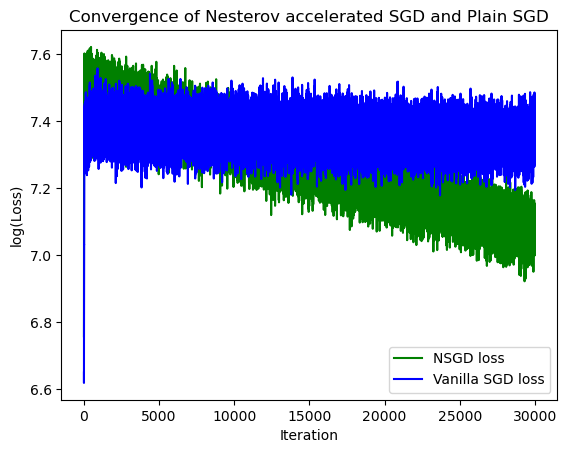

In [215]:
plt.plot(np.log10(Nesterov_losses_sgd), label = 'NSGD loss', c = 'g')
plt.plot(np.log10(losses_sgd), label = 'Vanilla SGD loss', c = 'b' )
plt.xlabel('Iteration')
plt.ylabel('log(Loss)')
plt.title('Convergence of Nesterov accelerated SGD and Plain SGD')
plt.legend()